### experiments on real world data 

In [1]:
from sklearn import datasets 
import logging
import sys
import os
%cd ..
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.utils import bin_random , bin_array, randints, solutions_to_dict

#from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
import gmpy2 as gmp
from gmpy2 import mpz , mpfr
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.gf2 import GF
from bds.rule import Rule
from bds.utils import mpz_set_bits
from tests.utils import assert_dict_allclose, assert_close_mpfr

#from bds.bounds_utils import find_equivalence_classes
import numpy as np 

#from bds.cbb_v2 import * 

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234



/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


In [21]:
import pandas as pd
import pickle 
def read_pickle(filepath_y): 
    objects = []
    with (open(filepath_y, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects 

In [29]:
# Load the CSV file using Pandas
dataset = "mushrooms"
data = pd.read_csv('data/mushrooms.csv')

# Print the data
data.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment   
0     p         x           s         n       t    p               f  \
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring   
0            c         n          k  ...                        s  \
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color   
0                      w                      w         p          w  \
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [30]:
y = data["class"]
data = data.drop('class', axis=1)
data = pd.get_dummies(data).astype("int")
X = data.to_numpy()

In [32]:
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### read labels 

In [33]:
y = np.array(y, dtype = bool) 

In [34]:
assert len(y) == X.shape[0]

In [50]:
# now we need to extract rules 
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random
from bds.rule import Rule
from time import time
#from bds.bbSampleTree import BranchAndBoundNaive
import time 
import random
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable


X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]


all_n_rules = [] 
lmbd = 0.1 
ub = 0.3 
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

show_progres = True

#for delta in [0.2, 0.4, 0.6, 0.8, 0.9]: 
#    for eps in [0.2, 0.4, 0.6, 0.8, 0.9]: 
for delta in [0.4, 0.8]: 
    for eps in [0.4, 0.8]:

        all_averages_times_MC = [] 
        all_averages_times_GT = [] 

        all_averages_counts_MC = [] 
        all_averages_counts_GT = []'
        
        all_n_rules = []

        for min_support in [5000, 4500, 4000, 3500]:
            
            print("min support " + str(min_support))

            ordered_input_data = preprocess_transaction_list(
                X_bag, min_support
            )
            tree = build_fptree(ordered_input_data)
            frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

            all_n_rules.append(len(frequent_itemsets)) 
            
            print(len(frequent_itemsets))

            # Now create rules 
            rules = [] 
            for i,itemset in enumerate(frequent_itemsets):
                tt = compute_truthtable(X,itemset)
                this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
                # we need the truthtable for this itemset 
                rules.append(this_Rule)

            pickle.dump(rules, open("rules/rules_" + dataset + "_" +  str(len(rules)), "wb" ))

            # approxMC
            all_times_MC = [] 
            all_counts_MC = [] 

            all_times_GT = [] 
            all_counts_GT = [] 

            
            for _ in range(n_reps):

                
                t = time.time() 
                test_cnt = approx_mc2(
                            rules, y, lmbd=lmbd, ub=ub,
                            delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                            parallel=False, log_level=logging.WARN
                        )

                elapsed = time.time() - t 
                all_times_MC.append(elapsed) 
                all_counts_MC.append(test_cnt)


                # complete enumeration 
                ref_count = get_ground_truth_count(rules, y, lmbd, ub)
                all_times_GT.append(elapsed) 
                all_counts_GT.append(ref_count) 

            all_averages_times_MC.append(np.mean(all_times_MC))
            all_averages_times_GT.append(np.mean(all_times_GT))

            all_averages_counts_MC.append(np.mean(all_counts_MC))
            all_averages_counts_GT.append(np.mean(all_counts_GT))

            
        pickle.dump(all_averages_times_MC, open("all_averages_times_MC_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))
        pickle.dump(all_averages_times_GT, open("all_averages_times_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))

        pickle.dump(all_averages_counts_MC, open("all_averages_counts_MC_" + dataset + "_" + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))
        pickle.dump(all_averages_counts_GT, open("all_averages_counts_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))


min support 5000
41


[D 230711 13:42:10 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 13:42:10 meel:363] thresh = 155.98
[D 230711 13:42:10 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:42:10 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 13:42:10 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:10 meel:278] initial solving under 40 constraints
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230711 13:42:10 cbb:136] density(A_rref) = 3.415% (from 49.7%)
[D 230711 13:42:10 meel:281] solving takes 0.01 secs
[D 230711 13:42:10 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:10 meel:98] calling l

rand_seed: 822569775
time_cost_info: 
|1|0.015837781997106504|
|2|0.019294696001452394|
rand_seed: 2137449171
time_cost_info: 
|1|0.017302362000918947|
|2|0.021316241000022274|
|3|0.01925025799573632|
rand_seed: 524453158


[D 230711 13:42:10 meel:149] search tree size: 176
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1046
[D 230711 13:42:10 meel:152] solving takes 0.02 secs
[D 230711 13:42:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:10 meel:137] ---- solve m = 3----
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230711 13:42:10 cbb:136] density(A_rref) = 49.593% (from 49.6%)
[D 230711 13:42:10 meel:149] search tree size: 103
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1787
[D 230711 13:42:10 meel:152] solving takes 0.02 secs
[D 230711 13:42:10 meel:196] |Y| < thresh (82 < 155)
[D 230711 13:42:10 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:10 meel:410] running approx_mc2_core takes 0.08s
[D 230711 13:42:10 meel:413] num_cells: 8, num_sols: 82
[D 230711 13:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:10 meel:278] initial solving under 40 c

time_cost_info: 
|1|0.013531172000512015|
|2|0.017196422995766625|
|3|0.017057834003935568|
rand_seed: 1365105717
time_cost_info: 
|1|0.013353279995499179|
|2|0.015489826997509226|
|3|0.014225600003555883|
rand_seed: 1880026316
time_cost_info: 
|1|0.012636685998586472|
|2|0.017654948998824693|
rand_seed: 481516916


[D 230711 13:42:10 meel:137] ---- solve m = 3----
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230711 13:42:10 cbb:136] density(A_rref) = 40.650% (from 45.5%)
[D 230711 13:42:10 meel:149] search tree size: 117
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1874
[D 230711 13:42:10 meel:152] solving takes 0.02 secs
[D 230711 13:42:10 meel:196] |Y| < thresh (92 < 155)
[D 230711 13:42:10 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:10 meel:410] running approx_mc2_core takes 0.09s
[D 230711 13:42:10 meel:413] num_cells: 8, num_sols: 92
 12%|█████▍                                      | 6/49 [00:00<00:03, 12.89it/s][D 230711 13:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:10 meel:278] initial solving under 40 constraints
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230

time_cost_info: 
|1|0.017434339999454096|
|2|0.018775436001305934|
|3|0.01606460900075035|
rand_seed: 1225605784
time_cost_info: 
|1|0.017466299002990127|
|2|0.018935389001853764|
rand_seed: 1165481977
time_cost_info: 
|1|0.014389573996595573|
|2|0.017007846996420994|
rand_seed: 1202486927


[D 230711 13:42:10 cbb:136] density(A_rref) = 51.220% (from 45.1%)
[D 230711 13:42:10 meel:149] search tree size: 177
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1103
[D 230711 13:42:10 meel:152] solving takes 0.02 secs
[D 230711 13:42:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:10 meel:137] ---- solve m = 3----
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230711 13:42:10 cbb:136] density(A_rref) = 53.659% (from 50.4%)
[D 230711 13:42:10 meel:149] search tree size: 103
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1843
[D 230711 13:42:10 meel:152] solving takes 0.01 secs
[D 230711 13:42:10 meel:196] |Y| < thresh (79 < 155)
[D 230711 13:42:10 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:10 meel:410] running approx_mc2_core takes 0.09s
[D 230711 13:42:10 meel:413] num_cells: 8, num_sols: 79
[D 230711 13:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.

time_cost_info: 
|1|0.013862412997696083|
|2|0.019248286000220105|
|3|0.014564087003236637|
rand_seed: 1549064881
time_cost_info: 
|1|0.01295377600035863|
|2|0.018059913003526162|
|3|0.015176799002802|
rand_seed: 1170776343
time_cost_info: 
|1|0.012887138000223786|
|2|0.015328781999414787|
|3|0.012703037005849183|
rand_seed: 646980841


[D 230711 13:42:10 cbb:136] density(A_rref) = 50.407% (from 55.3%)
[D 230711 13:42:10 meel:149] search tree size: 106
[D 230711 13:42:10 meel:150] number of prefix evaluations: 1828
[D 230711 13:42:10 meel:152] solving takes 0.01 secs
[D 230711 13:42:10 meel:196] |Y| < thresh (75 < 155)
[D 230711 13:42:10 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:10 meel:410] running approx_mc2_core takes 0.06s
[D 230711 13:42:10 meel:413] num_cells: 8, num_sols: 75
 24%|██████████▌                                | 12/49 [00:00<00:02, 13.30it/s][D 230711 13:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:10 meel:278] initial solving under 40 constraints
[D 230711 13:42:10 cbb:160] setting up the parity constraint system
[D 230711 13:42:10 cbb:129] simplifying A x = t using rref
[D 230711 13:42:10 cbb:136] density(A_rref) = 4.817% (from 49.2%)
[D 230711 13:42:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:42:10 meel:281] 

time_cost_info: 
|1|0.01139270299609052|
|2|0.013462430993968155|
|3|0.012985484005184844|
rand_seed: 1187404954
time_cost_info: 
|1|0.009670334999100305|
|2|0.011380103998817503|
|3|0.012117062004108448|
rand_seed: 852631582
time_cost_info: 
|1|0.015314443997340277|
|2|0.017608644004212692|
rand_seed: 1296531115
time_cost_info: 
|1|0.013461228998494335|
|2|0.01891695499944035|


[D 230711 13:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:11 meel:98] calling log_search with thresh=155
[D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:11 meel:137] ---- solve m = 1----
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:42:11 meel:149] search tree size: 169
[D 230711 13:42:11 meel:150] number of prefix evaluations: 373
[D 230711 13:42:11 meel:152] solving takes 0.01 secs
[D 230711 13:42:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:11 meel:137] ---- solve m = 2----
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 52.439% (from 52.4%)
[D 230711 13:42:11 meel:1

rand_seed: 1353614494
time_cost_info: 
|1|0.014970666998124216|
|2|0.017740945004334208|
rand_seed: 1967693548
time_cost_info: 
|1|0.014989496994530782|
|2|0.017083028993511107|
|3|0.015752833998703863|
rand_seed: 682106748


[D 230711 13:42:11 meel:149] search tree size: 110
[D 230711 13:42:11 meel:150] number of prefix evaluations: 1717
[D 230711 13:42:11 meel:152] solving takes 0.01 secs
[D 230711 13:42:11 meel:196] |Y| < thresh (83 < 155)
[D 230711 13:42:11 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:11 meel:410] running approx_mc2_core takes 0.09s
[D 230711 13:42:11 meel:413] num_cells: 8, num_sols: 83
 37%|███████████████▊                           | 18/49 [00:01<00:02, 13.62it/s][D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:11 meel:278] initial solving under 40 constraints
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 3.598% (from 50.7%)
[D 230711 13:42:11 meel:281] solving takes 0.01 secs
[D 230711 13:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.02026115799526451|
|2|0.018207125998742413|
|3|0.014812717003223952|
rand_seed: 1614618394
time_cost_info: 
|1|0.013648355001350865|
|2|0.01609592200111365|
rand_seed: 498808182
time_cost_info: 
|1|0.012899943001684733|
|2|0.015170434999163263|
rand_seed: 1536813498
time_cost_info: 
|1|0.013590244998340495|
|2|0.015783560993440915|
|3|0.012471485999412835|


[D 230711 13:42:11 cbb:136] density(A_rref) = 3.720% (from 48.8%)
[D 230711 13:42:11 meel:281] solving takes 0.01 secs
[D 230711 13:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:11 meel:98] calling log_search with thresh=155
[D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:11 meel:137] ---- solve m = 1----
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 46.341% (from 46.3%)
[D 230711 13:42:11 meel:149] search tree size: 170
[D 230711 13:42:11 meel:150] number of prefix evaluations: 368
[D 230711 13:42:11 meel:152] solving takes 0.01 secs
[D 230711 13:42:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:11 meel:137] ---- solve m = 2----
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simp

rand_seed: 55437432
time_cost_info: 
|1|0.012348188996838871|
|2|0.0174189299941645|
|3|0.010437993005325552|
rand_seed: 4274032
time_cost_info: 
|1|0.008989187001134269|
|2|0.010593917999358382|
|3|0.00965433500095969|
rand_seed: 2090933724
time_cost_info: 
|1|0.01034915399941383|
|2|0.013852291995135602|
|3|0.010101767002197448|
rand_seed: 787967301


[D 230711 13:42:11 meel:150] number of prefix evaluations: 1145
[D 230711 13:42:11 meel:152] solving takes 0.02 secs
[D 230711 13:42:11 meel:196] |Y| < thresh (142 < 155)
[D 230711 13:42:11 meel:202] big_cell[1]=1, return 2
[D 230711 13:42:11 meel:410] running approx_mc2_core takes 0.05s
[D 230711 13:42:11 meel:413] num_cells: 4, num_sols: 142
[D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:11 meel:278] initial solving under 40 constraints
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 3.598% (from 50.7%)
[D 230711 13:42:11 meel:281] solving takes 0.01 secs
[D 230711 13:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:11 meel:98] calling log_search with thresh=155
[D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=

time_cost_info: 
|1|0.009959224000340328|
|2|0.015185803000349551|
rand_seed: 1421700432
time_cost_info: 
|1|0.016839740994328167|
|2|0.024825893000524957|
rand_seed: 913548233
time_cost_info: 
|1|0.017914567004481796|
|2|0.018803090999426786|
|3|0.016268790001049638|


[D 230711 13:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:11 meel:98] calling log_search with thresh=155
[D 230711 13:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:11 meel:137] ---- solve m = 1----
[D 230711 13:42:11 cbb:160] setting up the parity constraint system
[D 230711 13:42:11 cbb:129] simplifying A x = t using rref
[D 230711 13:42:11 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:42:11 meel:149] search tree size: 169
[D 230711 13:42:11 meel:150] number of prefix evaluations: 356
[D 230711 13:42:12 meel:152] solving takes 0.01 secs
[D 230711 13:42:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:12 meel:137] ---- solve m = 2----
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 47.561% (from 47.6%)
[D 230711 13:42:12 meel:1

rand_seed: 1299827071
time_cost_info: 
|1|0.014365572998940479|
|2|0.018987301002198365|
|3|0.011884909006766975|
rand_seed: 1590214902
time_cost_info: 
|1|0.01061117100471165|
|2|0.013623648002976552|
|3|0.012959813000634313|
rand_seed: 421988862


[D 230711 13:42:12 cbb:136] density(A_rref) = 47.154% (from 49.6%)
[D 230711 13:42:12 meel:149] search tree size: 112
[D 230711 13:42:12 meel:150] number of prefix evaluations: 1864
[D 230711 13:42:12 meel:152] solving takes 0.02 secs
[D 230711 13:42:12 meel:196] |Y| < thresh (81 < 155)
[D 230711 13:42:12 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:12 meel:410] running approx_mc2_core takes 0.10s
[D 230711 13:42:12 meel:413] num_cells: 8, num_sols: 81
 61%|██████████████████████████▎                | 30/49 [00:02<00:01, 13.42it/s][D 230711 13:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:12 meel:278] initial solving under 40 constraints
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 3.720% (from 48.3%)
[D 230711 13:42:12 meel:281] solving takes 0.01 secs
[D 230711 13:42:12 meel:288] with |Y| 0 < 155, therefore call lo

time_cost_info: 
|1|0.02274000400211662|
|2|0.020341760995506775|
|3|0.017005007997795474|
rand_seed: 262835631
time_cost_info: 
|1|0.013577908001025207|
|2|0.014954206002585124|
|3|0.012880694994237274|
rand_seed: 240490034
time_cost_info: 
|1|0.010338154999772087|
|2|0.01587811199715361|
rand_seed: 13242096
time_cost_info: 
|1|0.01656440600345377|
|2|0.01991766299761366|


[D 230711 13:42:12 meel:413] num_cells: 4, num_sols: 139
[D 230711 13:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:12 meel:278] initial solving under 40 constraints
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 3.354% (from 50.3%)
[D 230711 13:42:12 meel:281] solving takes 0.02 secs
[D 230711 13:42:12 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:12 meel:98] calling log_search with thresh=155
[D 230711 13:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:12 meel:137] ---- solve m = 1----
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:42:12 meel:149] search tree 

rand_seed: 1901221627
time_cost_info: 
|1|0.019094564995612018|
|2|0.018208859000878874|
|3|0.016695861995685846|
rand_seed: 59135052
time_cost_info: 
|1|0.01396053299686173|
|2|0.024224804998084437|
rand_seed: 95107365


[D 230711 13:42:12 meel:152] solving takes 0.02 secs
[D 230711 13:42:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:12 meel:137] ---- solve m = 3----
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 48.780% (from 56.1%)
[D 230711 13:42:12 meel:149] search tree size: 111
[D 230711 13:42:12 meel:150] number of prefix evaluations: 1801
[D 230711 13:42:12 meel:152] solving takes 0.02 secs
[D 230711 13:42:12 meel:196] |Y| < thresh (82 < 155)
[D 230711 13:42:12 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:12 meel:410] running approx_mc2_core takes 0.09s
[D 230711 13:42:12 meel:413] num_cells: 8, num_sols: 82
 73%|███████████████████████████████▌           | 36/49 [00:02<00:00, 13.15it/s][D 230711 13:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:12 meel:278] initial solving under 40 constraints
[D 230711 13:42:12 cbb:1

time_cost_info: 
|1|0.014027617005922366|
|2|0.021696404000977054|
|3|0.019492278006509878|
rand_seed: 1171781410
time_cost_info: 
|1|0.019741051000892185|
|2|0.018872226995881647|
rand_seed: 1248669606
time_cost_info: 
|1|0.013839344996085856|
|2|0.018501364000258036|
|3|0.018597428002976812|
rand_seed: 1643431418


[D 230711 13:42:12 meel:150] number of prefix evaluations: 1079
[D 230711 13:42:12 meel:152] solving takes 0.01 secs
[D 230711 13:42:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:12 meel:137] ---- solve m = 3----
[D 230711 13:42:12 cbb:160] setting up the parity constraint system
[D 230711 13:42:12 cbb:129] simplifying A x = t using rref
[D 230711 13:42:12 cbb:136] density(A_rref) = 52.846% (from 57.7%)
[D 230711 13:42:12 meel:149] search tree size: 109
[D 230711 13:42:12 meel:150] number of prefix evaluations: 1820
[D 230711 13:42:12 meel:152] solving takes 0.01 secs
[D 230711 13:42:12 meel:196] |Y| < thresh (85 < 155)
[D 230711 13:42:12 meel:202] big_cell[2]=1, return 3
[D 230711 13:42:12 meel:410] running approx_mc2_core takes 0.07s
[D 230711 13:42:12 meel:413] num_cells: 8, num_sols: 85
[D 230711 13:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:12 meel:278] initial solving under 40 constraints
[D 230711 13:42:12 cbb:160] setting up t

time_cost_info: 
|1|0.011919374999706633|
|2|0.012329860997851938|
|3|0.012944259993673768|
rand_seed: 1058256067
time_cost_info: 
|1|0.01153705899923807|
|2|0.014969387004384771|
rand_seed: 1567173351
time_cost_info: 
|1|0.009963564996724017|
|2|0.012874681000539567|
rand_seed: 1023433867
time_cost_info: 
|1|0.011179563996847719|
|2|0.013926070001616608|
|3|0.015571604999422561|
rand_seed: 495622784


[D 230711 13:42:13 meel:150] number of prefix evaluations: 366
[D 230711 13:42:13 meel:152] solving takes 0.02 secs
[D 230711 13:42:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:13 meel:137] ---- solve m = 2----
[D 230711 13:42:13 cbb:160] setting up the parity constraint system
[D 230711 13:42:13 cbb:129] simplifying A x = t using rref
[D 230711 13:42:13 cbb:136] density(A_rref) = 50.000% (from 52.4%)
[D 230711 13:42:13 meel:149] search tree size: 174
[D 230711 13:42:13 meel:150] number of prefix evaluations: 1095
[D 230711 13:42:13 meel:152] solving takes 0.02 secs
[D 230711 13:42:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:13 meel:137] ---- solve m = 3----
[D 230711 13:42:13 cbb:160] setting up the parity constraint system
[D 230711 13:42:13 cbb:129] simplifying A x = t using rref
[D 230711 13:42:13 cbb:136] density(A_rref) = 45.528% (from 53.7%)
[D 230711 13:42:13 meel:149] search tree size: 112
[D 230711 13:42:13 meel:150] number of prefix evaluations: 1834
[

time_cost_info: 
|1|0.015185839001787826|
|2|0.01723812700220151|
|3|0.013647644998854958|
rand_seed: 1671713513
time_cost_info: 
|1|0.01120779199845856|
|2|0.015009957998699974|
rand_seed: 323759947
time_cost_info: 
|1|0.015233472004183568|
|2|0.02071864399476908|
rand_seed: 2092247376


[D 230711 13:42:13 meel:152] solving takes 0.02 secs
[D 230711 13:42:13 meel:196] |Y| < thresh (143 < 155)
[D 230711 13:42:13 meel:202] big_cell[1]=1, return 2
[D 230711 13:42:13 meel:410] running approx_mc2_core takes 0.08s
[D 230711 13:42:13 meel:413] num_cells: 4, num_sols: 143
 94%|████████████████████████████████████████▎  | 46/49 [00:03<00:00, 14.47it/s][D 230711 13:42:13 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:13 meel:278] initial solving under 40 constraints
[D 230711 13:42:13 cbb:160] setting up the parity constraint system
[D 230711 13:42:13 cbb:129] simplifying A x = t using rref
[D 230711 13:42:13 cbb:136] density(A_rref) = 3.841% (from 48.7%)
[D 230711 13:42:13 meel:281] solving takes 0.02 secs
[D 230711 13:42:13 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:13 meel:98] calling log_search with thresh=155
[D 230711 13:42:13 bb:53] calling ConstrainedBranchAndBound wi

time_cost_info: 
|1|0.01687169200158678|
|2|0.023480617004679516|
rand_seed: 1584087043
time_cost_info: 
|1|0.016464703003293835|
|2|0.019009773997822776|
|3|0.01730488900648197|
rand_seed: 504415490
time_cost_info: 
|1|0.014427260000957176|
|2|0.016183906998776365|
|3|0.01436854200437665|
rand_seed: 1860322579


[D 230711 13:42:13 meel:137] ---- solve m = 1----
[D 230711 13:42:13 cbb:160] setting up the parity constraint system
[D 230711 13:42:13 cbb:129] simplifying A x = t using rref
[D 230711 13:42:13 cbb:136] density(A_rref) = 60.976% (from 61.0%)
[D 230711 13:42:13 meel:149] search tree size: 177
[D 230711 13:42:13 meel:150] number of prefix evaluations: 352
[D 230711 13:42:13 meel:152] solving takes 0.02 secs
[D 230711 13:42:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:13 meel:137] ---- solve m = 2----
[D 230711 13:42:13 cbb:160] setting up the parity constraint system
[D 230711 13:42:13 cbb:129] simplifying A x = t using rref
[D 230711 13:42:13 cbb:136] density(A_rref) = 57.317% (from 53.7%)
[D 230711 13:42:13 meel:149] search tree size: 177
[D 230711 13:42:13 meel:150] number of prefix evaluations: 1063
[D 230711 13:42:13 meel:152] solving takes 0.03 secs
[D 230711 13:42:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:13 meel:137] ---- solve m = 3----
[D 230711 13:42

time_cost_info: 
|1|0.017163665004773065|
|2|0.029612518999783788|
|3|0.02201459899515612|
min support 4500
97


[D 230711 13:42:14 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 13:42:14 meel:363] thresh = 155.98
[D 230711 13:42:14 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:42:14 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 13:42:14 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:42:14 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:14 meel:278] initial solving under 96 constraints
[D 230711 13:42:14 cbb:160] setting up the parity constraint system
[D 230711 13:42:14 cbb:129] simplifying A x = t using rref
[D 230711 13:42:14 cbb:136] density(A_rref) = 1.568% (from 50.2%)
[D 230711 13:42:14 meel:281] solving takes 0.02 secs
[D 230711 13:42:14 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:14 meel:98] calling l

rand_seed: 822569775
time_cost_info: 
|1|0.01634792300319532|
|2|0.02043669900012901|
|3|0.025509851999231614|
|4|0.028738731998600997|
rand_seed: 2137449171


[D 230711 13:42:14 meel:150] number of prefix evaluations: 3781
[D 230711 13:42:14 meel:152] solving takes 0.02 secs
[D 230711 13:42:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:14 meel:137] ---- solve m = 4----
[D 230711 13:42:14 cbb:160] setting up the parity constraint system
[D 230711 13:42:14 cbb:129] simplifying A x = t using rref
[D 230711 13:42:14 cbb:136] density(A_rref) = 48.969% (from 53.4%)
[D 230711 13:42:14 meel:149] search tree size: 226
[D 230711 13:42:14 meel:150] number of prefix evaluations: 8152
[D 230711 13:42:14 meel:152] solving takes 0.03 secs
[D 230711 13:42:14 meel:196] |Y| < thresh (141 < 155)
[D 230711 13:42:14 meel:202] big_cell[3]=1, return 4
[D 230711 13:42:14 meel:410] running approx_mc2_core takes 0.14s
[D 230711 13:42:14 meel:413] num_cells: 16, num_sols: 141
  4%|█▊                                          | 2/49 [00:00<00:06,  7.43it/s][D 230711 13:42:14 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:14 meel

time_cost_info: 
|1|0.015146239995374344|
|2|0.023581872999784537|
|3|0.024573781003709882|
|4|0.03363323799567297|
rand_seed: 524453158


[D 230711 13:42:14 meel:149] search tree size: 177
[D 230711 13:42:14 meel:150] number of prefix evaluations: 20908
[D 230711 13:42:14 meel:152] solving takes 0.04 secs
[D 230711 13:42:14 meel:196] |Y| < thresh (91 < 155)
[D 230711 13:42:14 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:14 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:42:14 meel:413] num_cells: 32, num_sols: 91
  6%|██▋                                         | 3/49 [00:00<00:08,  5.58it/s][D 230711 13:42:15 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:15 meel:278] initial solving under 96 constraints
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 1.568% (from 50.4%)
[D 230711 13:42:15 meel:281] solving takes 0.02 secs
[D 230711 13:42:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.016062063004937954|
|2|0.018838424002751708|
|3|0.021882204004214145|
|4|0.029010737001954112|
|8|0.02461193999624811|
|6|0.032686311002180446|
|5|0.0391462510015117|
rand_seed: 1365105717
time_cost_info: 
|1|0.01932475799549138|
|2|0.017749393002304714|
|3|0.02103958999941824|
|4|0.03149948499776656|
rand_seed: 1880026316


[D 230711 13:42:15 meel:149] search tree size: 230
[D 230711 13:42:15 meel:150] number of prefix evaluations: 3706
[D 230711 13:42:15 meel:152] solving takes 0.02 secs
[D 230711 13:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:15 meel:137] ---- solve m = 4----
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 43.814% (from 42.5%)
[D 230711 13:42:15 meel:149] search tree size: 226
[D 230711 13:42:15 meel:150] number of prefix evaluations: 8075
[D 230711 13:42:15 meel:152] solving takes 0.03 secs
[D 230711 13:42:15 meel:196] |Y| < thresh (147 < 155)
[D 230711 13:42:15 meel:202] big_cell[3]=1, return 4
[D 230711 13:42:15 meel:410] running approx_mc2_core takes 0.11s
[D 230711 13:42:15 meel:413] num_cells: 16, num_sols: 147
 10%|████▍                                       | 5/49 [00:00<00:06,  7.00it/s][D 230711 13:42:15 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.011802906999946572|
|2|0.013625355997646693|
|3|0.018604856995807495|
|4|0.02852102900214959|
rand_seed: 481516916
time_cost_info: 
|1|0.016949796001426876|
|2|0.01793180300592212|
|3|0.0213906089993543|
|4|0.029150684000342153|
rand_seed: 1225605784


[D 230711 13:42:15 meel:150] number of prefix evaluations: 1934
[D 230711 13:42:15 meel:152] solving takes 0.02 secs
[D 230711 13:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:15 meel:137] ---- solve m = 3----
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 49.141% (from 51.9%)
[D 230711 13:42:15 meel:149] search tree size: 232
[D 230711 13:42:15 meel:150] number of prefix evaluations: 4172
[D 230711 13:42:15 meel:152] solving takes 0.03 secs
[D 230711 13:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:15 meel:137] ---- solve m = 4----
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 47.938% (from 52.3%)
[D 230711 13:42:15 meel:149] search tree size: 222
[D 230711 13:42:15 meel:150] number of prefix evaluations: 8542


time_cost_info: 
|1|0.01767582200409379|
|2|0.02353141400089953|
|3|0.026084876000822987|
|4|0.04758238799695391|
rand_seed: 1165481977
time_cost_info: 
|1|0.0192506220046198|
|2|0.023530712001957|
|3|0.027754515002015978|
|4|0.03559662000043318|
rand_seed: 1202486927


[D 230711 13:42:15 meel:149] search tree size: 223
[D 230711 13:42:15 meel:150] number of prefix evaluations: 612
[D 230711 13:42:15 meel:152] solving takes 0.02 secs
[D 230711 13:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:15 meel:137] ---- solve m = 2----
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 51.031% (from 51.0%)
[D 230711 13:42:15 meel:149] search tree size: 226
[D 230711 13:42:15 meel:150] number of prefix evaluations: 1808
[D 230711 13:42:15 meel:152] solving takes 0.02 secs
[D 230711 13:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:15 meel:137] ---- solve m = 3----
[D 230711 13:42:15 cbb:160] setting up the parity constraint system
[D 230711 13:42:15 cbb:129] simplifying A x = t using rref
[D 230711 13:42:15 cbb:136] density(A_rref) = 48.110% (from 52.6%)
[D 230711 13:42:15 meel:149] search tree size: 236
[D 230711 13:4

time_cost_info: 
|1|0.019972265996329952|
|2|0.019157875998644158|
|3|0.02178582600026857|
|4|0.029932006997114513|
rand_seed: 1549064881
time_cost_info: 
|1|0.022138601998449303|
|2|0.03323679200548213|
|3|0.03576241100381594|
|4|0.03548030599631602|


[D 230711 13:42:16 cbb:136] density(A_rref) = 1.654% (from 49.5%)
[D 230711 13:42:16 meel:281] solving takes 0.02 secs
[D 230711 13:42:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:16 meel:98] calling log_search with thresh=155
[D 230711 13:42:16 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:16 meel:137] ---- solve m = 1----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 45.361% (from 45.4%)
[D 230711 13:42:16 meel:149] search tree size: 226
[D 230711 13:42:16 meel:150] number of prefix evaluations: 597
[D 230711 13:42:16 meel:152] solving takes 0.02 secs
[D 230711 13:42:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:16 meel:137] ---- solve m = 2----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simp

rand_seed: 1170776343
time_cost_info: 
|1|0.015217227002722211|
|2|0.02015035899967188|
|3|0.02551912600029027|
|4|0.029873234998376574|
rand_seed: 646980841


[D 230711 13:42:16 meel:149] search tree size: 239
[D 230711 13:42:16 meel:150] number of prefix evaluations: 2246
[D 230711 13:42:16 meel:152] solving takes 0.03 secs
[D 230711 13:42:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:16 meel:137] ---- solve m = 3----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 53.952% (from 51.2%)
[D 230711 13:42:16 meel:149] search tree size: 241
[D 230711 13:42:16 meel:150] number of prefix evaluations: 4603
[D 230711 13:42:16 meel:152] solving takes 0.03 secs
[D 230711 13:42:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:16 meel:137] ---- solve m = 4----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 52.320% (from 51.5%)
[D 230711 13:42:16 meel:149] search tree size: 222
[D 230711 13:

time_cost_info: 
|1|0.020001227996544912|
|2|0.032023280997236725|
|3|0.025922917004209012|
|4|0.033722077001584694|
rand_seed: 1187404954
time_cost_info: 
|1|0.016670216995407827|
|2|0.01993728199886391|
|3|0.030970770996646024|
|4|0.031169169997156132|
rand_seed: 852631582


[D 230711 13:42:16 meel:149] search tree size: 217
[D 230711 13:42:16 meel:150] number of prefix evaluations: 2014
[D 230711 13:42:16 meel:152] solving takes 0.02 secs
[D 230711 13:42:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:16 meel:137] ---- solve m = 3----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 52.234% (from 53.3%)
[D 230711 13:42:16 meel:149] search tree size: 234
[D 230711 13:42:16 meel:150] number of prefix evaluations: 4249
[D 230711 13:42:16 meel:152] solving takes 0.03 secs
[D 230711 13:42:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:16 meel:137] ---- solve m = 4----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 47.938% (from 51.8%)
[D 230711 13:42:16 meel:149] search tree size: 213
[D 230711 13:

time_cost_info: 
|1|0.016587209996941965|
|2|0.02180431900342228|
|3|0.026526256995566655|
|4|0.04066881699691294|
rand_seed: 1296531115


[D 230711 13:42:16 meel:149] search tree size: 123
[D 230711 13:42:16 meel:150] number of prefix evaluations: 16752
[D 230711 13:42:16 meel:152] solving takes 0.02 secs
[D 230711 13:42:16 meel:196] |Y| < thresh (38 < 155)
[D 230711 13:42:16 meel:137] ---- solve m = 5----
[D 230711 13:42:16 cbb:160] setting up the parity constraint system
[D 230711 13:42:16 cbb:129] simplifying A x = t using rref
[D 230711 13:42:16 cbb:136] density(A_rref) = 46.598% (from 45.8%)
[D 230711 13:42:16 meel:149] search tree size: 166
[D 230711 13:42:16 meel:150] number of prefix evaluations: 21029
[D 230711 13:42:16 meel:152] solving takes 0.02 secs
[D 230711 13:42:16 meel:196] |Y| < thresh (84 < 155)
[D 230711 13:42:16 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:16 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:42:16 meel:413] num_cells: 32, num_sols: 84
 31%|█████████████▏                             | 15/49 [00:02<00:06,  5.58it/s][D 230711 13:42:16 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.02100800000334857|
|2|0.025229480997950304|
|3|0.029635309998411685|
|4|0.03802315699431347|
|8|0.02324778000183869|
|6|0.02388192299986258|
|5|0.0238517289981246|
rand_seed: 1353614494
time_cost_info: 
|1|0.012300702001084574|
|2|0.017765438999049366|
|3|0.019265754002844915|
|4|0.027867723001691047|
rand_seed: 1967693548


[D 230711 13:42:17 cbb:136] density(A_rref) = 47.165% (from 50.0%)
[D 230711 13:42:17 meel:149] search tree size: 207
[D 230711 13:42:17 meel:150] number of prefix evaluations: 8265
[D 230711 13:42:17 meel:152] solving takes 0.03 secs
[D 230711 13:42:17 meel:196] |Y| < thresh (121 < 155)
[D 230711 13:42:17 meel:202] big_cell[3]=1, return 4
[D 230711 13:42:17 meel:410] running approx_mc2_core takes 0.13s
[D 230711 13:42:17 meel:413] num_cells: 16, num_sols: 121
 35%|██████████████▉                            | 17/49 [00:02<00:04,  6.74it/s][D 230711 13:42:17 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:17 meel:278] initial solving under 96 constraints
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 1.557% (from 51.4%)
[D 230711 13:42:17 meel:281] solving takes 0.02 secs
[D 230711 13:42:17 meel:288] with |Y| 0 < 155, therefore call

time_cost_info: 
|1|0.015772603001096286|
|2|0.018001042000832967|
|3|0.022323142999084666|
|4|0.031171387003269047|
rand_seed: 682106748
time_cost_info: 
|1|0.01665417199546937|
|2|0.01845537600456737|
|3|0.02393634900363395|
|4|0.03100793199701002|
rand_seed: 1614618394


[D 230711 13:42:17 meel:150] number of prefix evaluations: 1697
[D 230711 13:42:17 meel:152] solving takes 0.02 secs
[D 230711 13:42:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:17 meel:137] ---- solve m = 3----
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 47.079% (from 50.2%)
[D 230711 13:42:17 meel:149] search tree size: 232
[D 230711 13:42:17 meel:150] number of prefix evaluations: 3542
[D 230711 13:42:17 meel:152] solving takes 0.02 secs
[D 230711 13:42:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:17 meel:137] ---- solve m = 4----
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 49.485% (from 50.5%)
[D 230711 13:42:17 meel:149] search tree size: 238
[D 230711 13:42:17 meel:150] number of prefix evaluations: 7661


time_cost_info: 
|1|0.01548264799930621|
|2|0.021310603005986195|
|3|0.02361551200010581|
|4|0.029415318997052964|
|8|0.024195236001105513|
|6|0.027042948997404892|
|5|0.026963226999214385|
rand_seed: 498808182
time_cost_info: 
|1|0.013429074999294244|
|2|0.017153576998680364|
|3|0.021027005001087673|
|4|0.02898398900288157|
rand_seed: 1536813498


[D 230711 13:42:17 meel:149] search tree size: 236
[D 230711 13:42:17 meel:150] number of prefix evaluations: 3931
[D 230711 13:42:17 meel:152] solving takes 0.02 secs
[D 230711 13:42:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:17 meel:137] ---- solve m = 4----
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 50.258% (from 52.6%)
[D 230711 13:42:17 meel:149] search tree size: 220
[D 230711 13:42:17 meel:150] number of prefix evaluations: 8302
[D 230711 13:42:17 meel:152] solving takes 0.03 secs
[D 230711 13:42:17 meel:196] |Y| < thresh (140 < 155)
[D 230711 13:42:17 meel:202] big_cell[3]=1, return 4
[D 230711 13:42:17 meel:410] running approx_mc2_core takes 0.14s
[D 230711 13:42:17 meel:413] num_cells: 16, num_sols: 140
 43%|██████████████████▍                        | 21/49 [00:03<00:04,  6.78it/s][D 230711 13:42:17 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.01663508800265845|
|2|0.024836083997797687|
|3|0.023809804995835293|
|4|0.030599400997743942|
rand_seed: 55437432
time_cost_info: 
|1|0.018507546999899205|
|2|0.019354967000253964|
|3|0.02621186000033049|
|4|0.029110110997862648|
rand_seed: 4274032


[D 230711 13:42:17 meel:149] search tree size: 206
[D 230711 13:42:17 meel:150] number of prefix evaluations: 1789
[D 230711 13:42:17 meel:152] solving takes 0.02 secs
[D 230711 13:42:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:17 meel:137] ---- solve m = 3----
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 41.581% (from 45.0%)
[D 230711 13:42:17 meel:149] search tree size: 220
[D 230711 13:42:17 meel:150] number of prefix evaluations: 3912
[D 230711 13:42:17 meel:152] solving takes 0.02 secs
[D 230711 13:42:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:17 meel:137] ---- solve m = 4----
[D 230711 13:42:17 cbb:160] setting up the parity constraint system
[D 230711 13:42:17 cbb:129] simplifying A x = t using rref
[D 230711 13:42:17 cbb:136] density(A_rref) = 44.845% (from 47.4%)
[D 230711 13:42:17 meel:149] search tree size: 224
[D 230711 13:

time_cost_info: 
|1|0.01528701499773888|
|2|0.01905070799693931|
|3|0.02354759300214937|
|4|0.030862528998113703|
rand_seed: 2090933724
time_cost_info: 
|1|0.01516801999969175|
|2|0.023881976994744036|
|3|0.02274414100247668|
|4|0.03066490100172814|
rand_seed: 787967301


[D 230711 13:42:18 meel:150] number of prefix evaluations: 1683
[D 230711 13:42:18 meel:152] solving takes 0.02 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 3----
[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 54.296% (from 56.4%)
[D 230711 13:42:18 meel:149] search tree size: 231
[D 230711 13:42:18 meel:150] number of prefix evaluations: 4115
[D 230711 13:42:18 meel:152] solving takes 0.03 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 4----
[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 47.938% (from 54.4%)
[D 230711 13:42:18 meel:149] search tree size: 220
[D 230711 13:42:18 meel:150] number of prefix evaluations: 8486


time_cost_info: 
|1|0.01669428499735659|
|2|0.020959136003511958|
|3|0.027171590001671575|
|4|0.031217967996781226|
rand_seed: 1421700432
time_cost_info: 
|1|0.01793583000107901|
|2|0.024327941006049514|
|3|0.02241014999890467|
|4|0.029633835998538416|
rand_seed: 913548233


[D 230711 13:42:18 meel:149] search tree size: 238
[D 230711 13:42:18 meel:150] number of prefix evaluations: 1680
[D 230711 13:42:18 meel:152] solving takes 0.02 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 3----
[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 45.361% (from 46.7%)
[D 230711 13:42:18 meel:149] search tree size: 238
[D 230711 13:42:18 meel:150] number of prefix evaluations: 3923
[D 230711 13:42:18 meel:152] solving takes 0.02 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 4----
[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 47.938% (from 46.1%)
[D 230711 13:42:18 meel:149] search tree size: 232
[D 230711 13:

time_cost_info: 
|1|0.016828441999678034|
|2|0.018694270998821594|
|3|0.024959636997664347|
|4|0.029874548999941908|
rand_seed: 1299827071
time_cost_info: 
|1|0.016288951999740675|
|2|0.03155051999783609|
|3|0.026365616999100894|
|4|0.03898366900102701|
rand_seed: 1590214902


[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 58.763% (from 58.8%)
[D 230711 13:42:18 meel:149] search tree size: 198
[D 230711 13:42:18 meel:150] number of prefix evaluations: 608
[D 230711 13:42:18 meel:152] solving takes 0.02 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 2----
[D 230711 13:42:18 cbb:160] setting up the parity constraint system
[D 230711 13:42:18 cbb:129] simplifying A x = t using rref
[D 230711 13:42:18 cbb:136] density(A_rref) = 50.515% (from 50.5%)
[D 230711 13:42:18 meel:149] search tree size: 226
[D 230711 13:42:18 meel:150] number of prefix evaluations: 1997
[D 230711 13:42:18 meel:152] solving takes 0.02 secs
[D 230711 13:42:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:18 meel:137] ---- solve m = 3----
[D 230711 13:42:18 cbb:160] setting up the parity constraint syst

time_cost_info: 
|1|0.015403274002892431|
|2|0.020817112002987415|
|3|0.023359020000498276|
|4|0.03036917999997968|
rand_seed: 421988862
time_cost_info: 
|1|0.01826243400137173|
|2|0.022108345001470298|
|3|0.026741228000901174|
|4|0.029911208999692462|
rand_seed: 262835631


[D 230711 13:42:19 meel:149] search tree size: 229
[D 230711 13:42:19 meel:150] number of prefix evaluations: 1990
[D 230711 13:42:19 meel:152] solving takes 0.02 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 3----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 47.079% (from 43.3%)
[D 230711 13:42:19 meel:149] search tree size: 234
[D 230711 13:42:19 meel:150] number of prefix evaluations: 4180
[D 230711 13:42:19 meel:152] solving takes 0.03 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 4----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 48.196% (from 43.6%)
[D 230711 13:42:19 meel:149] search tree size: 226
[D 230711 13:

time_cost_info: 
|1|0.01839736600231845|
|2|0.02016265799466055|
|3|0.026920686999801546|
|4|0.030376665003132075|
rand_seed: 240490034
time_cost_info: 
|1|0.016523288999451324|
|2|0.022323517994664144|
|3|0.024538994999602437|
|4|0.029608503995405044|
rand_seed: 13242096


[D 230711 13:42:19 meel:149] search tree size: 234
[D 230711 13:42:19 meel:150] number of prefix evaluations: 2027
[D 230711 13:42:19 meel:152] solving takes 0.02 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 3----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 55.670% (from 49.1%)
[D 230711 13:42:19 meel:149] search tree size: 224
[D 230711 13:42:19 meel:150] number of prefix evaluations: 4434
[D 230711 13:42:19 meel:152] solving takes 0.03 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 4----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 51.289% (from 51.0%)
[D 230711 13:42:19 meel:149] search tree size: 220
[D 230711 13:

time_cost_info: 
|1|0.01900164599646814|
|2|0.022918700997252017|
|3|0.026005053005064838|
|4|0.032881125996937044|
rand_seed: 1901221627
time_cost_info: 
|1|0.01567530899774283|
|2|0.020838583004660904|
|3|0.028180357003293466|
|4|0.03585902199847624|
rand_seed: 59135052


[D 230711 13:42:19 cbb:136] density(A_rref) = 53.608% (from 52.1%)
[D 230711 13:42:19 meel:149] search tree size: 219
[D 230711 13:42:19 meel:150] number of prefix evaluations: 1823
[D 230711 13:42:19 meel:152] solving takes 0.02 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 3----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 48.797% (from 52.2%)
[D 230711 13:42:19 meel:149] search tree size: 229
[D 230711 13:42:19 meel:150] number of prefix evaluations: 4056
[D 230711 13:42:19 meel:152] solving takes 0.03 secs
[D 230711 13:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:19 meel:137] ---- solve m = 4----
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 48.711% (from 49.5

time_cost_info: 
|1|0.01887659500062|
|2|0.022299967000435572|
|3|0.025978017998568248|
|4|0.03248486899974523|
rand_seed: 95107365


[D 230711 13:42:19 meel:149] search tree size: 163
[D 230711 13:42:19 meel:150] number of prefix evaluations: 20809
[D 230711 13:42:19 meel:152] solving takes 0.02 secs
[D 230711 13:42:19 meel:196] |Y| < thresh (80 < 155)
[D 230711 13:42:19 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:19 meel:410] running approx_mc2_core takes 0.21s
[D 230711 13:42:19 meel:413] num_cells: 32, num_sols: 80
 73%|███████████████████████████████▌           | 36/49 [00:05<00:02,  6.15it/s][D 230711 13:42:19 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:19 meel:278] initial solving under 96 constraints
[D 230711 13:42:19 cbb:160] setting up the parity constraint system
[D 230711 13:42:19 cbb:129] simplifying A x = t using rref
[D 230711 13:42:19 cbb:136] density(A_rref) = 1.568% (from 50.3%)
[D 230711 13:42:19 meel:281] solving takes 0.01 secs
[D 230711 13:42:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.018253934002132155|
|2|0.022191046002262738|
|3|0.024542728999222163|
|4|0.030061448000196833|
|8|0.02398631400137674|
|6|0.022854872004245408|
|5|0.02296643100271467|
rand_seed: 1171781410
time_cost_info: 
|1|0.012631642995984294|
|2|0.017855038000561763|
|3|0.01908263400400756|
|4|0.023414303999743424|
rand_seed: 1248669606


[D 230711 13:42:20 meel:150] number of prefix evaluations: 4154
[D 230711 13:42:20 meel:152] solving takes 0.03 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 4----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 47.938% (from 50.3%)
[D 230711 13:42:20 meel:149] search tree size: 224
[D 230711 13:42:20 meel:150] number of prefix evaluations: 8524
[D 230711 13:42:20 meel:152] solving takes 0.04 secs
[D 230711 13:42:20 meel:196] |Y| < thresh (143 < 155)
[D 230711 13:42:20 meel:202] big_cell[3]=1, return 4
[D 230711 13:42:20 meel:410] running approx_mc2_core takes 0.14s
[D 230711 13:42:20 meel:413] num_cells: 16, num_sols: 143
 78%|█████████████████████████████████▎         | 38/49 [00:05<00:01,  6.95it/s][D 230711 13:42:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:20 meel

time_cost_info: 
|1|0.015348711996921338|
|2|0.02082333200087305|
|3|0.026974382999469526|
|4|0.03630183800123632|
rand_seed: 1643431418
time_cost_info: 
|1|0.019432350003626198|
|2|0.01835752499755472|
|3|0.021072846997412853|
|4|0.030567374000384007|
rand_seed: 1058256067


[D 230711 13:42:20 meel:150] number of prefix evaluations: 1593
[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 3----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 43.643% (from 55.0%)
[D 230711 13:42:20 meel:149] search tree size: 232
[D 230711 13:42:20 meel:150] number of prefix evaluations: 3710
[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 4----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 43.814% (from 52.3%)
[D 230711 13:42:20 meel:149] search tree size: 224
[D 230711 13:42:20 meel:150] number of prefix evaluations: 8078


time_cost_info: 
|1|0.014631202000600751|
|2|0.02235825300158467|
|3|0.02302680200227769|
|4|0.030764752998948097|
rand_seed: 1567173351
time_cost_info: 
|1|0.016614093001408037|
|2|0.02336566799931461|
|3|0.025872857004287653|
|4|0.033082428999478|
rand_seed: 1023433867


[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 2----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 46.392% (from 51.0%)
[D 230711 13:42:20 meel:149] search tree size: 233
[D 230711 13:42:20 meel:150] number of prefix evaluations: 1991
[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 3----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 45.361% (from 51.2%)
[D 230711 13:42:20 meel:149] search tree size: 238
[D 230711 13:42:20 meel:150] number of prefix evaluations: 4395
[D 230711 13:42:20 meel:152] solving takes 0.03 secs
[D 230711 1

time_cost_info: 
|1|0.01902723900275305|
|2|0.023961401006090455|
|3|0.025566427000740077|
|4|0.03170156900159782|
rand_seed: 495622784
time_cost_info: 
|1|0.01656136200472247|
|2|0.020330867999291513|
|3|0.030132211999443825|
|4|0.032577582001977134|
rand_seed: 1671713513


[D 230711 13:42:20 meel:149] search tree size: 229
[D 230711 13:42:20 meel:150] number of prefix evaluations: 1928
[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 3----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 51.546% (from 51.9%)
[D 230711 13:42:20 meel:149] search tree size: 233
[D 230711 13:42:20 meel:150] number of prefix evaluations: 4010
[D 230711 13:42:20 meel:152] solving takes 0.02 secs
[D 230711 13:42:20 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:20 meel:137] ---- solve m = 4----
[D 230711 13:42:20 cbb:160] setting up the parity constraint system
[D 230711 13:42:20 cbb:129] simplifying A x = t using rref
[D 230711 13:42:20 cbb:136] density(A_rref) = 48.454% (from 52.8%)
[D 230711 13:42:20 meel:149] search tree size: 224
[D 230711 13:

time_cost_info: 
|1|0.01594422900234349|
|2|0.01999443800013978|
|3|0.022875982002005912|
|4|0.03127944500010926|
rand_seed: 323759947


[D 230711 13:42:21 meel:149] search tree size: 165
[D 230711 13:42:21 meel:150] number of prefix evaluations: 20469
[D 230711 13:42:21 meel:152] solving takes 0.03 secs
[D 230711 13:42:21 meel:196] |Y| < thresh (79 < 155)
[D 230711 13:42:21 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:21 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:42:21 meel:413] num_cells: 32, num_sols: 79
 92%|███████████████████████████████████████▍   | 45/49 [00:06<00:00,  6.12it/s][D 230711 13:42:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:21 meel:278] initial solving under 96 constraints
[D 230711 13:42:21 cbb:160] setting up the parity constraint system
[D 230711 13:42:21 cbb:129] simplifying A x = t using rref
[D 230711 13:42:21 cbb:136] density(A_rref) = 2.030% (from 49.6%)
[D 230711 13:42:21 meel:281] solving takes 0.02 secs
[D 230711 13:42:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.015305192995583639|
|2|0.020535990995995235|
|3|0.023793929001840297|
|4|0.03309220999653917|
|8|0.02466139500029385|
|6|0.026769921998493373|
|5|0.026664987999538425|
rand_seed: 2092247376
time_cost_info: 
|1|0.013270807998196688|
|2|0.023216622998006642|
|3|0.02538671799993608|
|4|0.0304379439985496|
rand_seed: 1584087043


[D 230711 13:42:21 meel:152] solving takes 0.02 secs
[D 230711 13:42:21 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:21 meel:137] ---- solve m = 3----
[D 230711 13:42:21 cbb:160] setting up the parity constraint system
[D 230711 13:42:21 cbb:129] simplifying A x = t using rref
[D 230711 13:42:21 cbb:136] density(A_rref) = 46.048% (from 47.8%)
[D 230711 13:42:21 meel:149] search tree size: 241
[D 230711 13:42:21 meel:150] number of prefix evaluations: 4760
[D 230711 13:42:21 meel:152] solving takes 0.02 secs
[D 230711 13:42:21 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:21 meel:137] ---- solve m = 4----
[D 230711 13:42:21 cbb:160] setting up the parity constraint system
[D 230711 13:42:21 cbb:129] simplifying A x = t using rref
[D 230711 13:42:21 cbb:136] density(A_rref) = 45.876% (from 46.1%)
[D 230711 13:42:21 meel:149] search tree size: 215
[D 230711 13:42:21 meel:150] number of prefix evaluations: 9131
[D 230711 13:42:21 meel:152] solving takes 0.03 secs
[D 230711 1

time_cost_info: 
|1|0.01602273399475962|
|2|0.02229840600193711|
|3|0.02487056400423171|
|4|0.0298993899996276|
rand_seed: 504415490
time_cost_info: 
|1|0.017024063999997452|
|2|0.03103237700270256|
|3|0.028331925001111813|
|4|0.040366077999351546|
rand_seed: 1860322579


[D 230711 13:42:21 cbb:136] density(A_rref) = 54.639% (from 54.6%)
[D 230711 13:42:21 meel:149] search tree size: 225
[D 230711 13:42:21 meel:150] number of prefix evaluations: 621
[D 230711 13:42:21 meel:152] solving takes 0.02 secs
[D 230711 13:42:21 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:21 meel:137] ---- solve m = 2----
[D 230711 13:42:21 cbb:160] setting up the parity constraint system
[D 230711 13:42:21 cbb:129] simplifying A x = t using rref
[D 230711 13:42:21 cbb:136] density(A_rref) = 51.031% (from 51.0%)
[D 230711 13:42:21 meel:149] search tree size: 226
[D 230711 13:42:21 meel:150] number of prefix evaluations: 1998
[D 230711 13:42:21 meel:152] solving takes 0.02 secs
[D 230711 13:42:21 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:21 meel:137] ---- solve m = 3----
[D 230711 13:42:21 cbb:160] setting up the parity constraint system
[D 230711 13:42:21 cbb:129] simplifying A x = t using rref
[D 230711 13:42:21 cbb:136] density(A_rref) = 47.423% (from 49.8%

time_cost_info: 
|1|0.022721918001479935|
|2|0.02460130500548985|
|3|0.02528373400127748|
|4|0.03329453800688498|
min support 4000
159


[D 230711 13:42:23 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 13:42:23 meel:363] thresh = 155.98
[D 230711 13:42:23 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:42:23 meel:374] BB solving (thresh=155) takes 0.01 secs
    and gave 155 solutions
[D 230711 13:42:23 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:42:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:23 meel:278] initial solving under 158 constraints
[D 230711 13:42:23 cbb:160] setting up the parity constraint system
[D 230711 13:42:23 cbb:129] simplifying A x = t using rref
[D 230711 13:42:23 cbb:136] density(A_rref) = 0.935% (from 50.1%)
[D 230711 13:42:23 meel:281] solving takes 0.03 secs
[D 230711 13:42:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:23 meel:98] calling 

rand_seed: 822569775


[D 230711 13:42:23 meel:149] search tree size: 208
[D 230711 13:42:23 meel:150] number of prefix evaluations: 35092
[D 230711 13:42:23 meel:152] solving takes 0.04 secs
[D 230711 13:42:23 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:42:23 meel:137] ---- solve m = 5----
[D 230711 13:42:23 cbb:160] setting up the parity constraint system
[D 230711 13:42:23 cbb:129] simplifying A x = t using rref
[D 230711 13:42:23 cbb:136] density(A_rref) = 51.572% (from 51.7%)
[D 230711 13:42:23 meel:149] search tree size: 281
[D 230711 13:42:23 meel:150] number of prefix evaluations: 47027
[D 230711 13:42:23 meel:152] solving takes 0.05 secs
[D 230711 13:42:23 meel:196] |Y| < thresh (134 < 155)
[D 230711 13:42:23 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:23 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:23 meel:413] num_cells: 32, num_sols: 134
  2%|▉                                           | 1/49 [00:00<00:14,  3.35it/s][D 230711 13:42:23 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.021892174998356495|
|2|0.020709866999823134|
|3|0.025484596997557674|
|4|0.03593959299905691|
|8|0.045774791004078|
|6|0.04498884100030409|
|5|0.05044333700061543|
rand_seed: 2137449171


[D 230711 13:42:23 meel:150] number of prefix evaluations: 23562
[D 230711 13:42:23 meel:152] solving takes 0.05 secs
[D 230711 13:42:23 meel:196] |Y| < thresh (23 < 155)
[D 230711 13:42:23 meel:137] ---- solve m = 6----
[D 230711 13:42:23 cbb:160] setting up the parity constraint system
[D 230711 13:42:23 cbb:129] simplifying A x = t using rref
[D 230711 13:42:23 cbb:136] density(A_rref) = 50.000% (from 51.7%)
[D 230711 13:42:23 meel:149] search tree size: 223
[D 230711 13:42:23 meel:150] number of prefix evaluations: 35343
[D 230711 13:42:23 meel:152] solving takes 0.04 secs
[D 230711 13:42:23 meel:196] |Y| < thresh (73 < 155)
[D 230711 13:42:23 meel:137] ---- solve m = 5----
[D 230711 13:42:23 cbb:160] setting up the parity constraint system
[D 230711 13:42:23 cbb:129] simplifying A x = t using rref
[D 230711 13:42:23 cbb:136] density(A_rref) = 51.572% (from 52.3%)
[D 230711 13:42:23 meel:149] search tree size: 296
[D 230711 13:42:23 meel:150] number of prefix evaluations: 47276
[D 

time_cost_info: 
|1|0.021800504000566434|
|2|0.02391029299906222|
|3|0.02739625400135992|
|4|0.03916931799903978|
|8|0.04558884399739327|
|6|0.042835981999814976|
|5|0.04607674800354289|
rand_seed: 524453158


[D 230711 13:42:23 cbb:136] density(A_rref) = 51.468% (from 47.8%)
[D 230711 13:42:24 meel:149] search tree size: 208
[D 230711 13:42:24 meel:150] number of prefix evaluations: 37001
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (59 < 155)
[D 230711 13:42:24 meel:137] ---- solve m = 5----
[D 230711 13:42:24 cbb:160] setting up the parity constraint system
[D 230711 13:42:24 cbb:129] simplifying A x = t using rref
[D 230711 13:42:24 cbb:136] density(A_rref) = 49.057% (from 46.4%)
[D 230711 13:42:24 meel:149] search tree size: 269
[D 230711 13:42:24 meel:150] number of prefix evaluations: 48935
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (118 < 155)
[D 230711 13:42:24 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:24 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:24 meel:413] num_cells: 32, num_sols: 118
  6%|██▋                                         | 3/49 [00:00<00:13

time_cost_info: 
|1|0.01961713699711254|
|2|0.021315117002814077|
|3|0.02877392699883785|
|4|0.04030591699847719|
|8|0.0456748759970651|
|6|0.04560981500253547|
|5|0.046728799999982584|
rand_seed: 1365105717


[D 230711 13:42:24 meel:149] search tree size: 166
[D 230711 13:42:24 meel:150] number of prefix evaluations: 25619
[D 230711 13:42:24 meel:152] solving takes 0.04 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (22 < 155)
[D 230711 13:42:24 meel:137] ---- solve m = 6----
[D 230711 13:42:24 cbb:160] setting up the parity constraint system
[D 230711 13:42:24 cbb:129] simplifying A x = t using rref
[D 230711 13:42:24 cbb:136] density(A_rref) = 50.105% (from 52.6%)
[D 230711 13:42:24 meel:149] search tree size: 216
[D 230711 13:42:24 meel:150] number of prefix evaluations: 37400
[D 230711 13:42:24 meel:152] solving takes 0.04 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (66 < 155)
[D 230711 13:42:24 meel:137] ---- solve m = 5----
[D 230711 13:42:24 cbb:160] setting up the parity constraint system
[D 230711 13:42:24 cbb:129] simplifying A x = t using rref
[D 230711 13:42:24 cbb:136] density(A_rref) = 49.811% (from 52.7%)
[D 230711 13:42:24 meel:149] search tree size: 269
[D 230711 13:42:2

time_cost_info: 
|1|0.0234651259961538|
|2|0.02564947700011544|
|3|0.030836891004582867|
|4|0.04320519699831493|
|8|0.04282039300596807|
|6|0.04462671399960527|
|5|0.046166211999661755|
rand_seed: 1880026316


[D 230711 13:42:24 meel:149] search tree size: 210
[D 230711 13:42:24 meel:150] number of prefix evaluations: 38319
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:24 meel:137] ---- solve m = 5----
[D 230711 13:42:24 cbb:160] setting up the parity constraint system
[D 230711 13:42:24 cbb:129] simplifying A x = t using rref
[D 230711 13:42:24 cbb:136] density(A_rref) = 47.421% (from 47.7%)
[D 230711 13:42:24 meel:149] search tree size: 260
[D 230711 13:42:24 meel:150] number of prefix evaluations: 50254
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (108 < 155)
[D 230711 13:42:24 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:24 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:24 meel:413] num_cells: 32, num_sols: 108
 10%|████▍                                       | 5/49 [00:01<00:13,  3.35it/s][D 230711 13:42:24 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018672293997951783|
|2|0.019062983999901917|
|3|0.023369971000647638|
|4|0.037946349002595525|
|8|0.04174497599888127|
|6|0.052403756002604496|
|5|0.052326732002256904|
rand_seed: 481516916


[D 230711 13:42:24 meel:149] search tree size: 214
[D 230711 13:42:24 meel:150] number of prefix evaluations: 36867
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (65 < 155)
[D 230711 13:42:24 meel:137] ---- solve m = 5----
[D 230711 13:42:24 cbb:160] setting up the parity constraint system
[D 230711 13:42:24 cbb:129] simplifying A x = t using rref
[D 230711 13:42:24 cbb:136] density(A_rref) = 47.170% (from 52.3%)
[D 230711 13:42:24 meel:149] search tree size: 274
[D 230711 13:42:24 meel:150] number of prefix evaluations: 48801
[D 230711 13:42:24 meel:152] solving takes 0.05 secs
[D 230711 13:42:24 meel:196] |Y| < thresh (124 < 155)
[D 230711 13:42:24 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:24 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:24 meel:413] num_cells: 32, num_sols: 124
 12%|█████▍                                      | 6/49 [00:01<00:12,  3.35it/s][D 230711 13:42:24 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018190317998232786|
|2|0.019671848000143655|
|3|0.025005015995702706|
|4|0.034499692999816034|
|8|0.04378567800449673|
|6|0.052230794994102325|
|5|0.05285078100132523|
rand_seed: 1225605784


[D 230711 13:42:25 cbb:136] density(A_rref) = 49.371% (from 51.7%)
[D 230711 13:42:25 meel:149] search tree size: 206
[D 230711 13:42:25 meel:150] number of prefix evaluations: 36944
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (58 < 155)
[D 230711 13:42:25 meel:137] ---- solve m = 5----
[D 230711 13:42:25 cbb:160] setting up the parity constraint system
[D 230711 13:42:25 cbb:129] simplifying A x = t using rref
[D 230711 13:42:25 cbb:136] density(A_rref) = 48.679% (from 51.1%)
[D 230711 13:42:25 meel:149] search tree size: 272
[D 230711 13:42:25 meel:150] number of prefix evaluations: 48879
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (125 < 155)
[D 230711 13:42:25 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:25 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:25 meel:413] num_cells: 32, num_sols: 125
 14%|██████▎                                     | 7/49 [00:02<00:12

time_cost_info: 
|1|0.020115677994908765|
|2|0.021020986001531128|
|3|0.030861603998346254|
|4|0.03552458699414274|
|8|0.04757968200283358|
|6|0.05142075499315979|
|5|0.05006613199657295|
rand_seed: 1165481977


[D 230711 13:42:25 meel:149] search tree size: 210
[D 230711 13:42:25 meel:150] number of prefix evaluations: 34597
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:42:25 meel:137] ---- solve m = 5----
[D 230711 13:42:25 cbb:160] setting up the parity constraint system
[D 230711 13:42:25 cbb:129] simplifying A x = t using rref
[D 230711 13:42:25 cbb:136] density(A_rref) = 48.050% (from 50.1%)
[D 230711 13:42:25 meel:149] search tree size: 276
[D 230711 13:42:25 meel:150] number of prefix evaluations: 46532
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (129 < 155)
[D 230711 13:42:25 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:25 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:25 meel:413] num_cells: 32, num_sols: 129
 16%|███████▏                                    | 8/49 [00:02<00:12,  3.37it/s][D 230711 13:42:25 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018418147003103513|
|2|0.02002121399709722|
|3|0.02701985100429738|
|4|0.03288475099543575|
|8|0.0495168229972478|
|6|0.04603869400307303|
|5|0.047823479006183334|
rand_seed: 1202486927


[D 230711 13:42:25 meel:150] number of prefix evaluations: 25698
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:42:25 meel:137] ---- solve m = 6----
[D 230711 13:42:25 cbb:160] setting up the parity constraint system
[D 230711 13:42:25 cbb:129] simplifying A x = t using rref
[D 230711 13:42:25 cbb:136] density(A_rref) = 47.694% (from 50.3%)
[D 230711 13:42:25 meel:149] search tree size: 207
[D 230711 13:42:25 meel:150] number of prefix evaluations: 37479
[D 230711 13:42:25 meel:152] solving takes 0.05 secs
[D 230711 13:42:25 meel:196] |Y| < thresh (56 < 155)
[D 230711 13:42:25 meel:137] ---- solve m = 5----
[D 230711 13:42:25 cbb:160] setting up the parity constraint system
[D 230711 13:42:25 cbb:129] simplifying A x = t using rref
[D 230711 13:42:25 cbb:136] density(A_rref) = 47.547% (from 50.9%)
[D 230711 13:42:25 meel:149] search tree size: 273
[D 230711 13:42:25 meel:150] number of prefix evaluations: 49414
[D 

time_cost_info: 
|1|0.02661496800283203|
|2|0.02005549200112|
|3|0.02842992099613184|
|4|0.04017028399539413|
|8|0.046319089000462554|
|6|0.04656545799662126|
|5|0.04932943600579165|
rand_seed: 1549064881


[D 230711 13:42:26 meel:149] search tree size: 205
[D 230711 13:42:26 meel:150] number of prefix evaluations: 35586
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (59 < 155)
[D 230711 13:42:26 meel:137] ---- solve m = 5----
[D 230711 13:42:26 cbb:160] setting up the parity constraint system
[D 230711 13:42:26 cbb:129] simplifying A x = t using rref
[D 230711 13:42:26 cbb:136] density(A_rref) = 49.434% (from 50.4%)
[D 230711 13:42:26 meel:149] search tree size: 277
[D 230711 13:42:26 meel:150] number of prefix evaluations: 47521
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (131 < 155)
[D 230711 13:42:26 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:26 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:26 meel:413] num_cells: 32, num_sols: 131
 20%|████████▊                                  | 10/49 [00:02<00:11,  3.37it/s][D 230711 13:42:26 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.017109729000367224|
|2|0.021643419000611175|
|3|0.027387975998863112|
|4|0.030980574003478978|
|8|0.044704526000714395|
|6|0.05015453899977729|
|5|0.05316030699759722|
rand_seed: 1170776343


[D 230711 13:42:26 meel:149] search tree size: 207
[D 230711 13:42:26 meel:150] number of prefix evaluations: 36963
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:26 meel:137] ---- solve m = 5----
[D 230711 13:42:26 cbb:160] setting up the parity constraint system
[D 230711 13:42:26 cbb:129] simplifying A x = t using rref
[D 230711 13:42:26 cbb:136] density(A_rref) = 49.434% (from 48.7%)
[D 230711 13:42:26 meel:149] search tree size: 261
[D 230711 13:42:26 meel:150] number of prefix evaluations: 48897
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (114 < 155)
[D 230711 13:42:26 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:26 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:26 meel:413] num_cells: 32, num_sols: 114
 22%|█████████▋                                 | 11/49 [00:03<00:11,  3.35it/s][D 230711 13:42:26 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.015237262996379286|
|2|0.01951099099824205|
|3|0.026238662001560442|
|4|0.04260654799873009|
|8|0.0510499450028874|
|6|0.04903851400013082|
|5|0.05028091200074414|
rand_seed: 646980841


[D 230711 13:42:26 meel:149] search tree size: 204
[D 230711 13:42:26 meel:150] number of prefix evaluations: 38008
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:26 meel:137] ---- solve m = 5----
[D 230711 13:42:26 cbb:160] setting up the parity constraint system
[D 230711 13:42:26 cbb:129] simplifying A x = t using rref
[D 230711 13:42:26 cbb:136] density(A_rref) = 50.189% (from 50.3%)
[D 230711 13:42:26 meel:149] search tree size: 253
[D 230711 13:42:26 meel:150] number of prefix evaluations: 49943
[D 230711 13:42:26 meel:152] solving takes 0.05 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (108 < 155)
[D 230711 13:42:26 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:26 meel:410] running approx_mc2_core takes 0.28s
[D 230711 13:42:26 meel:413] num_cells: 32, num_sols: 108
 24%|██████████▌                                | 12/49 [00:03<00:10,  3.41it/s][D 230711 13:42:26 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.01637144899723353|
|2|0.01774142700014636|
|3|0.024202674998377915|
|4|0.03827744199952576|
|8|0.045316014999116305|
|6|0.04610047199821565|
|5|0.047304075000283774|
rand_seed: 1187404954


[D 230711 13:42:26 meel:149] search tree size: 204
[D 230711 13:42:26 meel:150] number of prefix evaluations: 35919
[D 230711 13:42:26 meel:152] solving takes 0.04 secs
[D 230711 13:42:26 meel:196] |Y| < thresh (60 < 155)
[D 230711 13:42:26 meel:137] ---- solve m = 5----
[D 230711 13:42:26 cbb:160] setting up the parity constraint system
[D 230711 13:42:26 cbb:129] simplifying A x = t using rref
[D 230711 13:42:26 cbb:136] density(A_rref) = 48.428% (from 49.9%)
[D 230711 13:42:27 meel:149] search tree size: 259
[D 230711 13:42:27 meel:150] number of prefix evaluations: 47854
[D 230711 13:42:27 meel:152] solving takes 0.05 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (117 < 155)
[D 230711 13:42:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:27 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:27 meel:413] num_cells: 32, num_sols: 117
 27%|███████████▍                               | 13/49 [00:03<00:10,  3.41it/s][D 230711 13:42:27 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.017532751000544522|
|2|0.01967211299779592|
|3|0.029291681006725412|
|4|0.042245343000104185|
|8|0.046831956002279185|
|6|0.0436298349959543|
|5|0.047777712999959476|
rand_seed: 852631582


[D 230711 13:42:27 meel:149] search tree size: 202
[D 230711 13:42:27 meel:150] number of prefix evaluations: 36509
[D 230711 13:42:27 meel:152] solving takes 0.04 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (53 < 155)
[D 230711 13:42:27 meel:137] ---- solve m = 5----
[D 230711 13:42:27 cbb:160] setting up the parity constraint system
[D 230711 13:42:27 cbb:129] simplifying A x = t using rref
[D 230711 13:42:27 cbb:136] density(A_rref) = 48.805% (from 49.4%)
[D 230711 13:42:27 meel:149] search tree size: 262
[D 230711 13:42:27 meel:150] number of prefix evaluations: 48444
[D 230711 13:42:27 meel:152] solving takes 0.05 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (114 < 155)
[D 230711 13:42:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:27 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:27 meel:413] num_cells: 32, num_sols: 114
 29%|████████████▎                              | 14/49 [00:04<00:10,  3.42it/s][D 230711 13:42:27 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018313223001314327|
|2|0.019970758999988902|
|3|0.025785427998926025|
|4|0.03241592799895443|
|8|0.0452503490014351|
|6|0.044263773001148365|
|5|0.05316650500026299|
rand_seed: 1296531115


[D 230711 13:42:27 meel:149] search tree size: 211
[D 230711 13:42:27 meel:150] number of prefix evaluations: 37106
[D 230711 13:42:27 meel:152] solving takes 0.04 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:42:27 meel:137] ---- solve m = 5----
[D 230711 13:42:27 cbb:160] setting up the parity constraint system
[D 230711 13:42:27 cbb:129] simplifying A x = t using rref
[D 230711 13:42:27 cbb:136] density(A_rref) = 49.560% (from 49.6%)
[D 230711 13:42:27 meel:149] search tree size: 266
[D 230711 13:42:27 meel:150] number of prefix evaluations: 49040
[D 230711 13:42:27 meel:152] solving takes 0.05 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (116 < 155)
[D 230711 13:42:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:27 meel:410] running approx_mc2_core takes 0.28s
[D 230711 13:42:27 meel:413] num_cells: 32, num_sols: 116
 31%|█████████████▏                             | 15/49 [00:04<00:09,  3.47it/s][D 230711 13:42:27 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.016920530993957072|
|2|0.017102658006479032|
|3|0.022863122998387553|
|4|0.037366755001130514|
|8|0.04603161200066097|
|6|0.04271721400436945|
|5|0.0493351680052001|
rand_seed: 1353614494


[D 230711 13:42:27 meel:149] search tree size: 200
[D 230711 13:42:27 meel:150] number of prefix evaluations: 36598
[D 230711 13:42:27 meel:152] solving takes 0.05 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (54 < 155)
[D 230711 13:42:27 meel:137] ---- solve m = 5----
[D 230711 13:42:27 cbb:160] setting up the parity constraint system
[D 230711 13:42:27 cbb:129] simplifying A x = t using rref
[D 230711 13:42:27 cbb:136] density(A_rref) = 50.440% (from 51.2%)
[D 230711 13:42:27 meel:149] search tree size: 269
[D 230711 13:42:27 meel:150] number of prefix evaluations: 48532
[D 230711 13:42:27 meel:152] solving takes 0.05 secs
[D 230711 13:42:27 meel:196] |Y| < thresh (121 < 155)
[D 230711 13:42:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:27 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:27 meel:413] num_cells: 32, num_sols: 121
 33%|██████████████                             | 16/49 [00:04<00:09,  3.44it/s][D 230711 13:42:27 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.017327576999377925|
|2|0.017925983003806323|
|3|0.022263104998273775|
|4|0.03833699000097113|
|8|0.04691832199750934|
|6|0.052588451995688956|
|5|0.05213762600033078|
rand_seed: 1967693548


[D 230711 13:42:28 meel:149] search tree size: 200
[D 230711 13:42:28 meel:150] number of prefix evaluations: 36919
[D 230711 13:42:28 meel:152] solving takes 0.05 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (52 < 155)
[D 230711 13:42:28 meel:137] ---- solve m = 5----
[D 230711 13:42:28 cbb:160] setting up the parity constraint system
[D 230711 13:42:28 cbb:129] simplifying A x = t using rref
[D 230711 13:42:28 cbb:136] density(A_rref) = 49.560% (from 50.9%)
[D 230711 13:42:28 meel:149] search tree size: 260
[D 230711 13:42:28 meel:150] number of prefix evaluations: 48853
[D 230711 13:42:28 meel:152] solving takes 0.05 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (114 < 155)
[D 230711 13:42:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:28 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:28 meel:413] num_cells: 32, num_sols: 114
 35%|██████████████▉                            | 17/49 [00:05<00:09,  3.42it/s][D 230711 13:42:28 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018959667002491187|
|2|0.019352533003257122|
|3|0.02459769300185144|
|4|0.039188804003060795|
|8|0.04637104499852285|
|6|0.04644022499996936|
|5|0.05140445700089913|
rand_seed: 682106748


[D 230711 13:42:28 meel:149] search tree size: 158
[D 230711 13:42:28 meel:150] number of prefix evaluations: 24900
[D 230711 13:42:28 meel:152] solving takes 0.05 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (10 < 155)
[D 230711 13:42:28 meel:137] ---- solve m = 6----
[D 230711 13:42:28 cbb:160] setting up the parity constraint system
[D 230711 13:42:28 cbb:129] simplifying A x = t using rref
[D 230711 13:42:28 cbb:136] density(A_rref) = 51.153% (from 50.1%)
[D 230711 13:42:28 meel:149] search tree size: 196
[D 230711 13:42:28 meel:150] number of prefix evaluations: 36680
[D 230711 13:42:28 meel:152] solving takes 0.04 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (46 < 155)
[D 230711 13:42:28 meel:137] ---- solve m = 5----
[D 230711 13:42:28 cbb:160] setting up the parity constraint system
[D 230711 13:42:28 cbb:129] simplifying A x = t using rref
[D 230711 13:42:28 cbb:136] density(A_rref) = 50.566% (from 50.3%)
[D 230711 13:42:28 meel:149] search tree size: 250
[D 230711 13:42:2

time_cost_info: 
|1|0.02070901200204389|
|2|0.016795725001429673|
|3|0.02976323999610031|
|4|0.04685011000401573|
|8|0.05023140500270529|
|6|0.04343682900071144|
|5|0.04449200099770678|
rand_seed: 1614618394


[D 230711 13:42:28 meel:149] search tree size: 209
[D 230711 13:42:28 meel:150] number of prefix evaluations: 34279
[D 230711 13:42:28 meel:152] solving takes 0.05 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (68 < 155)
[D 230711 13:42:28 meel:137] ---- solve m = 5----
[D 230711 13:42:28 cbb:160] setting up the parity constraint system
[D 230711 13:42:28 cbb:129] simplifying A x = t using rref
[D 230711 13:42:28 cbb:136] density(A_rref) = 46.415% (from 50.8%)
[D 230711 13:42:28 meel:149] search tree size: 275
[D 230711 13:42:28 meel:150] number of prefix evaluations: 46213
[D 230711 13:42:28 meel:152] solving takes 0.05 secs
[D 230711 13:42:28 meel:196] |Y| < thresh (133 < 155)
[D 230711 13:42:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:28 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:28 meel:413] num_cells: 32, num_sols: 133
 39%|████████████████▋                          | 19/49 [00:05<00:08,  3.38it/s][D 230711 13:42:28 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.024320532000274397|
|2|0.019563487003324553|
|3|0.022289660999376792|
|4|0.03392079100012779|
|8|0.05420678399968892|
|6|0.04647431199555285|
|5|0.050995167999644764|
rand_seed: 498808182


[D 230711 13:42:29 meel:149] search tree size: 204
[D 230711 13:42:29 meel:150] number of prefix evaluations: 36637
[D 230711 13:42:29 meel:152] solving takes 0.05 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 5----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 53.082% (from 49.1%)
[D 230711 13:42:29 meel:149] search tree size: 266
[D 230711 13:42:29 meel:150] number of prefix evaluations: 48569
[D 230711 13:42:29 meel:152] solving takes 0.05 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (119 < 155)
[D 230711 13:42:29 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:29 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:42:29 meel:413] num_cells: 32, num_sols: 119
 41%|█████████████████▌                         | 20/49 [00:05<00:08,  3.39it/s][D 230711 13:42:29 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.024002127000130713|
|2|0.016673425998305902|
|3|0.021369331996538676|
|4|0.03858837200095877|
|8|0.04457302499940852|
|6|0.04532879799808143|
|5|0.050110169999243226|
rand_seed: 1536813498


[D 230711 13:42:29 meel:150] number of prefix evaluations: 26532
[D 230711 13:42:29 meel:152] solving takes 0.04 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (15 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 6----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 50.734% (from 50.1%)
[D 230711 13:42:29 meel:149] search tree size: 211
[D 230711 13:42:29 meel:150] number of prefix evaluations: 38313
[D 230711 13:42:29 meel:152] solving takes 0.05 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 5----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 47.799% (from 48.8%)
[D 230711 13:42:29 meel:149] search tree size: 264
[D 230711 13:42:29 meel:150] number of prefix evaluations: 50248
[D 

time_cost_info: 
|1|0.01901535400247667|
|2|0.022660360002191737|
|3|0.027507494000019506|
|4|0.04196871000021929|
|8|0.0438523510019877|
|6|0.046974678996775765|
|5|0.047295289994508494|
rand_seed: 55437432


[D 230711 13:42:29 meel:149] search tree size: 161
[D 230711 13:42:29 meel:150] number of prefix evaluations: 24830
[D 230711 13:42:29 meel:152] solving takes 0.06 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (12 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 6----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 53.983% (from 49.0%)
[D 230711 13:42:29 meel:149] search tree size: 210
[D 230711 13:42:29 meel:150] number of prefix evaluations: 36611
[D 230711 13:42:29 meel:152] solving takes 0.06 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 5----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 49.937% (from 47.4%)
[D 230711 13:42:29 meel:149] search tree size: 272
[D 230711 13:42:2

time_cost_info: 
|1|0.018058449997624848|
|2|0.018689570999413263|
|3|0.040611454998725094|
|4|0.061593020996951964|
|8|0.060648309998214245|
|6|0.06064924000384053|
|5|0.05365933900611708|
rand_seed: 4274032


[D 230711 13:42:29 meel:149] search tree size: 159
[D 230711 13:42:29 meel:150] number of prefix evaluations: 24110
[D 230711 13:42:29 meel:152] solving takes 0.05 secs
[D 230711 13:42:29 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:42:29 meel:137] ---- solve m = 6----
[D 230711 13:42:29 cbb:160] setting up the parity constraint system
[D 230711 13:42:29 cbb:129] simplifying A x = t using rref
[D 230711 13:42:29 cbb:136] density(A_rref) = 46.017% (from 49.6%)
[D 230711 13:42:30 meel:149] search tree size: 213
[D 230711 13:42:30 meel:150] number of prefix evaluations: 35890
[D 230711 13:42:30 meel:152] solving takes 0.05 secs
[D 230711 13:42:30 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:42:30 meel:137] ---- solve m = 5----
[D 230711 13:42:30 cbb:160] setting up the parity constraint system
[D 230711 13:42:30 cbb:129] simplifying A x = t using rref
[D 230711 13:42:30 cbb:136] density(A_rref) = 47.044% (from 49.8%)
[D 230711 13:42:30 meel:149] search tree size: 262
[D 230711 13:42:3

time_cost_info: 
|1|0.019793026993284002|
|2|0.027674686003592797|
|3|0.039977841996005736|
|4|0.04633928399562137|
|8|0.04682625600253232|
|6|0.05042776199843502|
|5|0.05385579699941445|
rand_seed: 2090933724


[D 230711 13:42:30 meel:150] number of prefix evaluations: 13213
[D 230711 13:42:30 meel:152] solving takes 0.05 secs
[D 230711 13:42:30 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:30 meel:137] ---- solve m = 8----
[D 230711 13:42:30 cbb:160] setting up the parity constraint system
[D 230711 13:42:30 cbb:129] simplifying A x = t using rref
[D 230711 13:42:30 cbb:136] density(A_rref) = 47.248% (from 51.3%)
[D 230711 13:42:30 meel:149] search tree size: 159
[D 230711 13:42:30 meel:150] number of prefix evaluations: 24686
[D 230711 13:42:30 meel:152] solving takes 0.05 secs
[D 230711 13:42:30 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:42:30 meel:137] ---- solve m = 6----
[D 230711 13:42:30 cbb:160] setting up the parity constraint system
[D 230711 13:42:30 cbb:129] simplifying A x = t using rref
[D 230711 13:42:30 cbb:136] density(A_rref) = 44.444% (from 51.6%)
[D 230711 13:42:30 meel:149] search tree size: 215
[D 230711 13:42:30 meel:150] number of prefix evaluations: 36464


time_cost_info: 
|1|0.02544266100449022|
|2|0.029480640005203895|
|3|0.043893973001104314|
|4|0.05090262400335632|
|8|0.051029885005846154|
|6|0.0518335320011829|
|5|0.05047575299977325|
rand_seed: 787967301


[D 230711 13:42:30 meel:149] search tree size: 154
[D 230711 13:42:30 meel:150] number of prefix evaluations: 24025
[D 230711 13:42:30 meel:152] solving takes 0.07 secs
[D 230711 13:42:30 meel:196] |Y| < thresh (7 < 155)
[D 230711 13:42:30 meel:137] ---- solve m = 6----
[D 230711 13:42:30 cbb:160] setting up the parity constraint system
[D 230711 13:42:30 cbb:129] simplifying A x = t using rref
[D 230711 13:42:30 cbb:136] density(A_rref) = 49.581% (from 49.2%)
[D 230711 13:42:30 meel:149] search tree size: 205
[D 230711 13:42:30 meel:150] number of prefix evaluations: 35805
[D 230711 13:42:30 meel:152] solving takes 0.07 secs
[D 230711 13:42:30 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:42:30 meel:137] ---- solve m = 5----
[D 230711 13:42:30 cbb:160] setting up the parity constraint system
[D 230711 13:42:30 cbb:129] simplifying A x = t using rref
[D 230711 13:42:30 cbb:136] density(A_rref) = 50.692% (from 49.7%)
[D 230711 13:42:30 meel:149] search tree size: 276
[D 230711 13:42:30

time_cost_info: 
|1|0.01946719999978086|
|2|0.020323304997873493|
|3|0.02857953100465238|
|4|0.03424151200306369|
|8|0.06618927799718222|
|6|0.06764834000205155|
|5|0.05310308800108032|
rand_seed: 1421700432


[D 230711 13:42:31 meel:149] search tree size: 209
[D 230711 13:42:31 meel:150] number of prefix evaluations: 36628
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (63 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 5----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 48.805% (from 48.9%)
[D 230711 13:42:31 meel:149] search tree size: 259
[D 230711 13:42:31 meel:150] number of prefix evaluations: 48563
[D 230711 13:42:31 meel:152] solving takes 0.06 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (117 < 155)
[D 230711 13:42:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:31 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:31 meel:413] num_cells: 32, num_sols: 117
 53%|██████████████████████▊                    | 26/49 [00:07<00:07,  3.07it/s][D 230711 13:42:31 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.02329365399782546|
|2|0.019524472001648974|
|3|0.02864422799757449|
|4|0.03408143400156405|
|8|0.04007686599652516|
|6|0.05007931499858387|
|5|0.05576511099934578|
rand_seed: 913548233


[D 230711 13:42:31 meel:149] search tree size: 163
[D 230711 13:42:31 meel:150] number of prefix evaluations: 24761
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 6----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 48.742% (from 48.7%)
[D 230711 13:42:31 meel:149] search tree size: 206
[D 230711 13:42:31 meel:150] number of prefix evaluations: 36539
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (58 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 5----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 51.195% (from 47.5%)
[D 230711 13:42:31 meel:149] search tree size: 259
[D 230711 13:42:3

time_cost_info: 
|1|0.016936581996560562|
|2|0.022242371996981092|
|3|0.02829888700216543|
|4|0.04331676899892045|
|8|0.050690553995082155|
|6|0.046467496002151165|
|5|0.048038202003226615|
rand_seed: 1299827071


[D 230711 13:42:31 meel:149] search tree size: 163
[D 230711 13:42:31 meel:150] number of prefix evaluations: 24170
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (14 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 6----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 49.161% (from 49.7%)
[D 230711 13:42:31 meel:149] search tree size: 207
[D 230711 13:42:31 meel:150] number of prefix evaluations: 35949
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (60 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 5----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 50.063% (from 49.3%)
[D 230711 13:42:31 meel:149] search tree size: 269
[D 230711 13:42:3

time_cost_info: 
|1|0.0239309989992762|
|2|0.025393623000127263|
|3|0.03419777299859561|
|4|0.04212615500000538|
|8|0.050709164002910256|
|6|0.04891684199537849|
|5|0.05282500300381798|
rand_seed: 1590214902


[D 230711 13:42:31 meel:149] search tree size: 211
[D 230711 13:42:31 meel:150] number of prefix evaluations: 36945
[D 230711 13:42:31 meel:152] solving takes 0.05 secs
[D 230711 13:42:31 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:42:31 meel:137] ---- solve m = 5----
[D 230711 13:42:31 cbb:160] setting up the parity constraint system
[D 230711 13:42:31 cbb:129] simplifying A x = t using rref
[D 230711 13:42:31 cbb:136] density(A_rref) = 51.698% (from 50.2%)
[D 230711 13:42:32 meel:149] search tree size: 266
[D 230711 13:42:32 meel:150] number of prefix evaluations: 48880
[D 230711 13:42:32 meel:152] solving takes 0.05 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (119 < 155)
[D 230711 13:42:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:32 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:32 meel:413] num_cells: 32, num_sols: 119
 59%|█████████████████████████▍                 | 29/49 [00:08<00:06,  3.15it/s][D 230711 13:42:32 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018572278000647202|
|2|0.01706741000089096|
|3|0.024007748994335998|
|4|0.0375628969995887|
|8|0.0516763869964052|
|6|0.05116526699566748|
|5|0.05065779700089479|
rand_seed: 421988862


[D 230711 13:42:32 meel:149] search tree size: 157
[D 230711 13:42:32 meel:150] number of prefix evaluations: 25028
[D 230711 13:42:32 meel:152] solving takes 0.07 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (8 < 155)
[D 230711 13:42:32 meel:137] ---- solve m = 6----
[D 230711 13:42:32 cbb:160] setting up the parity constraint system
[D 230711 13:42:32 cbb:129] simplifying A x = t using rref
[D 230711 13:42:32 cbb:136] density(A_rref) = 45.912% (from 52.2%)
[D 230711 13:42:32 meel:149] search tree size: 207
[D 230711 13:42:32 meel:150] number of prefix evaluations: 36808
[D 230711 13:42:32 meel:152] solving takes 0.05 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:32 meel:137] ---- solve m = 5----
[D 230711 13:42:32 cbb:160] setting up the parity constraint system
[D 230711 13:42:32 cbb:129] simplifying A x = t using rref
[D 230711 13:42:32 cbb:136] density(A_rref) = 46.038% (from 52.7%)
[D 230711 13:42:32 meel:149] search tree size: 255
[D 230711 13:42:32

time_cost_info: 
|1|0.0180124269973021|
|2|0.020983337999496143|
|3|0.027974748001724947|
|4|0.04535428000235697|
|8|0.07107406399882166|
|6|0.05332351600372931|
|5|0.04857935600011842|
rand_seed: 262835631


[D 230711 13:42:32 meel:149] search tree size: 213
[D 230711 13:42:32 meel:150] number of prefix evaluations: 35200
[D 230711 13:42:32 meel:152] solving takes 0.05 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (66 < 155)
[D 230711 13:42:32 meel:137] ---- solve m = 5----
[D 230711 13:42:32 cbb:160] setting up the parity constraint system
[D 230711 13:42:32 cbb:129] simplifying A x = t using rref
[D 230711 13:42:32 cbb:136] density(A_rref) = 46.667% (from 46.0%)
[D 230711 13:42:32 meel:149] search tree size: 273
[D 230711 13:42:32 meel:150] number of prefix evaluations: 47134
[D 230711 13:42:32 meel:152] solving takes 0.06 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (125 < 155)
[D 230711 13:42:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:32 meel:410] running approx_mc2_core takes 0.31s
[D 230711 13:42:32 meel:413] num_cells: 32, num_sols: 125
 63%|███████████████████████████▏               | 31/49 [00:09<00:05,  3.13it/s][D 230711 13:42:32 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.020431616001587827|
|2|0.02058227099769283|
|3|0.022759036997740623|
|4|0.03487504800432362|
|8|0.05318474800151307|
|6|0.05245884800388012|
|5|0.0585957990042516|
rand_seed: 240490034


[D 230711 13:42:32 meel:149] search tree size: 162
[D 230711 13:42:32 meel:150] number of prefix evaluations: 24476
[D 230711 13:42:32 meel:152] solving takes 0.05 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (15 < 155)
[D 230711 13:42:32 meel:137] ---- solve m = 6----
[D 230711 13:42:32 cbb:160] setting up the parity constraint system
[D 230711 13:42:32 cbb:129] simplifying A x = t using rref
[D 230711 13:42:32 cbb:136] density(A_rref) = 51.363% (from 49.6%)
[D 230711 13:42:32 meel:149] search tree size: 210
[D 230711 13:42:32 meel:150] number of prefix evaluations: 36256
[D 230711 13:42:32 meel:152] solving takes 0.05 secs
[D 230711 13:42:32 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:42:32 meel:137] ---- solve m = 5----
[D 230711 13:42:32 cbb:160] setting up the parity constraint system
[D 230711 13:42:32 cbb:129] simplifying A x = t using rref
[D 230711 13:42:32 cbb:136] density(A_rref) = 52.075% (from 49.7%)
[D 230711 13:42:33 meel:149] search tree size: 276
[D 230711 13:42:3

time_cost_info: 
|1|0.019954306997533422|
|2|0.019334292999701574|
|3|0.029562356998212636|
|4|0.04748171000392176|
|8|0.046969799004727975|
|6|0.05191007300163619|
|5|0.04920713300089119|
rand_seed: 13242096


[D 230711 13:42:33 meel:149] search tree size: 212
[D 230711 13:42:33 meel:150] number of prefix evaluations: 36914
[D 230711 13:42:33 meel:152] solving takes 0.05 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:42:33 meel:137] ---- solve m = 5----
[D 230711 13:42:33 cbb:160] setting up the parity constraint system
[D 230711 13:42:33 cbb:129] simplifying A x = t using rref
[D 230711 13:42:33 cbb:136] density(A_rref) = 47.799% (from 50.7%)
[D 230711 13:42:33 meel:149] search tree size: 280
[D 230711 13:42:33 meel:150] number of prefix evaluations: 48849
[D 230711 13:42:33 meel:152] solving takes 0.05 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (130 < 155)
[D 230711 13:42:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:33 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:33 meel:413] num_cells: 32, num_sols: 130
 67%|████████████████████████████▉              | 33/49 [00:10<00:04,  3.20it/s][D 230711 13:42:33 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.017944443003216293|
|2|0.019788343000982422|
|3|0.02864444000442745|
|4|0.03760401999898022|
|8|0.04616852400067728|
|6|0.05028729200421367|
|5|0.05208269199647475|
rand_seed: 1901221627


[D 230711 13:42:33 meel:149] search tree size: 199
[D 230711 13:42:33 meel:150] number of prefix evaluations: 37507
[D 230711 13:42:33 meel:152] solving takes 0.06 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (54 < 155)
[D 230711 13:42:33 meel:137] ---- solve m = 5----
[D 230711 13:42:33 cbb:160] setting up the parity constraint system
[D 230711 13:42:33 cbb:129] simplifying A x = t using rref
[D 230711 13:42:33 cbb:136] density(A_rref) = 49.434% (from 51.1%)
[D 230711 13:42:33 meel:149] search tree size: 262
[D 230711 13:42:33 meel:150] number of prefix evaluations: 49441
[D 230711 13:42:33 meel:152] solving takes 0.06 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (119 < 155)
[D 230711 13:42:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:33 meel:410] running approx_mc2_core takes 0.31s
[D 230711 13:42:33 meel:413] num_cells: 32, num_sols: 119
 69%|█████████████████████████████▊             | 34/49 [00:10<00:04,  3.20it/s][D 230711 13:42:33 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.01835398600087501|
|2|0.019708838997757994|
|3|0.029709709000599105|
|4|0.03472616700310027|
|8|0.046197563999157865|
|6|0.05593231799866771|
|5|0.057985735998954624|
rand_seed: 59135052


[D 230711 13:42:33 meel:149] search tree size: 209
[D 230711 13:42:33 meel:150] number of prefix evaluations: 36133
[D 230711 13:42:33 meel:152] solving takes 0.05 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (64 < 155)
[D 230711 13:42:33 meel:137] ---- solve m = 5----
[D 230711 13:42:33 cbb:160] setting up the parity constraint system
[D 230711 13:42:33 cbb:129] simplifying A x = t using rref
[D 230711 13:42:33 cbb:136] density(A_rref) = 50.818% (from 49.2%)
[D 230711 13:42:33 meel:149] search tree size: 269
[D 230711 13:42:33 meel:150] number of prefix evaluations: 48068
[D 230711 13:42:33 meel:152] solving takes 0.06 secs
[D 230711 13:42:33 meel:196] |Y| < thresh (124 < 155)
[D 230711 13:42:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:33 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:33 meel:413] num_cells: 32, num_sols: 124
 71%|██████████████████████████████▋            | 35/49 [00:10<00:04,  3.23it/s][D 230711 13:42:33 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.018137571998522617|
|2|0.020968645003449637|
|3|0.023082423002051655|
|4|0.031962758002919145|
|8|0.049961853997956496|
|6|0.05072154600202339|
|5|0.05751685900031589|
rand_seed: 95107365


[D 230711 13:42:34 meel:149] search tree size: 202
[D 230711 13:42:34 meel:150] number of prefix evaluations: 36305
[D 230711 13:42:34 meel:152] solving takes 0.04 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (55 < 155)
[D 230711 13:42:34 meel:137] ---- solve m = 5----
[D 230711 13:42:34 cbb:160] setting up the parity constraint system
[D 230711 13:42:34 cbb:129] simplifying A x = t using rref
[D 230711 13:42:34 cbb:136] density(A_rref) = 49.560% (from 51.3%)
[D 230711 13:42:34 meel:149] search tree size: 271
[D 230711 13:42:34 meel:150] number of prefix evaluations: 48239
[D 230711 13:42:34 meel:152] solving takes 0.05 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (127 < 155)
[D 230711 13:42:34 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:34 meel:410] running approx_mc2_core takes 0.28s
[D 230711 13:42:34 meel:413] num_cells: 32, num_sols: 127
 73%|███████████████████████████████▌           | 36/49 [00:11<00:03,  3.30it/s][D 230711 13:42:34 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.019618142003309913|
|2|0.01824699799908558|
|3|0.02383226900565205|
|4|0.03323685900249984|
|8|0.05008210200321628|
|6|0.04488940200099023|
|5|0.046568381003453396|
rand_seed: 1171781410


[D 230711 13:42:34 meel:149] search tree size: 226
[D 230711 13:42:34 meel:150] number of prefix evaluations: 34190
[D 230711 13:42:34 meel:152] solving takes 0.06 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (80 < 155)
[D 230711 13:42:34 meel:137] ---- solve m = 5----
[D 230711 13:42:34 cbb:160] setting up the parity constraint system
[D 230711 13:42:34 cbb:129] simplifying A x = t using rref
[D 230711 13:42:34 cbb:136] density(A_rref) = 48.050% (from 49.8%)
[D 230711 13:42:34 meel:149] search tree size: 284
[D 230711 13:42:34 meel:150] number of prefix evaluations: 46124
[D 230711 13:42:34 meel:152] solving takes 0.05 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (142 < 155)
[D 230711 13:42:34 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:34 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:34 meel:413] num_cells: 32, num_sols: 142
 76%|████████████████████████████████▍          | 37/49 [00:11<00:03,  3.30it/s][D 230711 13:42:34 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.01715393800259335|
|2|0.019040676997974515|
|3|0.02638110800035065|
|4|0.03325099499488715|
|8|0.05034391200024402|
|6|0.05703611300123157|
|5|0.05101183200167725|
rand_seed: 1248669606


[D 230711 13:42:34 meel:152] solving takes 0.05 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (12 < 155)
[D 230711 13:42:34 meel:137] ---- solve m = 6----
[D 230711 13:42:34 cbb:160] setting up the parity constraint system
[D 230711 13:42:34 cbb:129] simplifying A x = t using rref
[D 230711 13:42:34 cbb:136] density(A_rref) = 47.589% (from 50.6%)
[D 230711 13:42:34 meel:149] search tree size: 202
[D 230711 13:42:34 meel:150] number of prefix evaluations: 36167
[D 230711 13:42:34 meel:152] solving takes 0.05 secs
[D 230711 13:42:34 meel:196] |Y| < thresh (55 < 155)
[D 230711 13:42:34 meel:137] ---- solve m = 5----
[D 230711 13:42:34 cbb:160] setting up the parity constraint system
[D 230711 13:42:34 cbb:129] simplifying A x = t using rref
[D 230711 13:42:34 cbb:136] density(A_rref) = 49.308% (from 51.6%)
[D 230711 13:42:34 meel:149] search tree size: 261
[D 230711 13:42:34 meel:150] number of prefix evaluations: 48102
[D 230711 13:42:34 meel:152] solving takes 0.05 secs
[D 230711 13:42

time_cost_info: 
|1|0.02012407399888616|
|2|0.020863126999756787|
|3|0.025322692999907304|
|4|0.042591949000780005|
|8|0.04731262900168076|
|6|0.04937361399788642|
|5|0.05032693499379093|
rand_seed: 1643431418


[D 230711 13:42:35 meel:137] ---- solve m = 6----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 49.266% (from 52.1%)
[D 230711 13:42:35 meel:149] search tree size: 196
[D 230711 13:42:35 meel:150] number of prefix evaluations: 37267
[D 230711 13:42:35 meel:152] solving takes 0.06 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (48 < 155)
[D 230711 13:42:35 meel:137] ---- solve m = 5----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 49.811% (from 51.4%)
[D 230711 13:42:35 meel:149] search tree size: 258
[D 230711 13:42:35 meel:150] number of prefix evaluations: 49199
[D 230711 13:42:35 meel:152] solving takes 0.05 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (109 < 155)
[D 230711 13:42:35 meel:202] big_cell[4]=1, return 5
[D 230711 13:4

time_cost_info: 
|1|0.020771374001924414|
|2|0.01865581300080521|
|3|0.028078684998035897|
|4|0.039153363002697006|
|8|0.04917723000107799|
|6|0.05849595900508575|
|5|0.05225187399628339|
rand_seed: 1058256067


[D 230711 13:42:35 meel:149] search tree size: 158
[D 230711 13:42:35 meel:150] number of prefix evaluations: 25656
[D 230711 13:42:35 meel:152] solving takes 0.05 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:42:35 meel:137] ---- solve m = 6----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 47.589% (from 50.9%)
[D 230711 13:42:35 meel:149] search tree size: 205
[D 230711 13:42:35 meel:150] number of prefix evaluations: 37437
[D 230711 13:42:35 meel:152] solving takes 0.04 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (63 < 155)
[D 230711 13:42:35 meel:137] ---- solve m = 5----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 49.308% (from 50.1%)
[D 230711 13:42:35 meel:149] search tree size: 251
[D 230711 13:42:3

time_cost_info: 
|1|0.01934153799811611|
|2|0.024065497003903147|
|3|0.031634023995138705|
|4|0.04044332299963571|
|8|0.051668927997525316|
|6|0.044471467001130804|
|5|0.046555077999073546|
rand_seed: 1567173351


[D 230711 13:42:35 meel:149] search tree size: 203
[D 230711 13:42:35 meel:150] number of prefix evaluations: 36082
[D 230711 13:42:35 meel:152] solving takes 0.06 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:35 meel:137] ---- solve m = 5----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 51.447% (from 50.9%)
[D 230711 13:42:35 meel:149] search tree size: 271
[D 230711 13:42:35 meel:150] number of prefix evaluations: 48017
[D 230711 13:42:35 meel:152] solving takes 0.06 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (128 < 155)
[D 230711 13:42:35 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:35 meel:410] running approx_mc2_core takes 0.32s
[D 230711 13:42:35 meel:413] num_cells: 32, num_sols: 128
 84%|███████████████████████████████████▉       | 41/49 [00:12<00:02,  3.23it/s][D 230711 13:42:35 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.016201069003727753|
|2|0.016766970002208836|
|3|0.030289807997178286|
|4|0.0387509010033682|
|8|0.04990416100190487|
|6|0.056676950996916275|
|5|0.05571294300170848|
rand_seed: 1023433867


[D 230711 13:42:35 meel:149] search tree size: 209
[D 230711 13:42:35 meel:150] number of prefix evaluations: 35739
[D 230711 13:42:35 meel:152] solving takes 0.05 secs
[D 230711 13:42:35 meel:196] |Y| < thresh (63 < 155)
[D 230711 13:42:35 meel:137] ---- solve m = 5----
[D 230711 13:42:35 cbb:160] setting up the parity constraint system
[D 230711 13:42:35 cbb:129] simplifying A x = t using rref
[D 230711 13:42:35 cbb:136] density(A_rref) = 51.321% (from 50.1%)
[D 230711 13:42:36 meel:149] search tree size: 279
[D 230711 13:42:36 meel:150] number of prefix evaluations: 47673
[D 230711 13:42:36 meel:152] solving takes 0.06 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (134 < 155)
[D 230711 13:42:36 meel:202] big_cell[4]=1, return 5
[D 230711 13:42:36 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:42:36 meel:413] num_cells: 32, num_sols: 134
 86%|████████████████████████████████████▊      | 42/49 [00:12<00:02,  3.26it/s][D 230711 13:42:36 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.016917921995627694|
|2|0.022674097002891358|
|3|0.025009302000398748|
|4|0.032518555999558885|
|8|0.046438514997134916|
|6|0.04603371999837691|
|5|0.06435446099931141|
rand_seed: 495622784


[D 230711 13:42:36 meel:149] search tree size: 167
[D 230711 13:42:36 meel:150] number of prefix evaluations: 24568
[D 230711 13:42:36 meel:152] solving takes 0.05 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (18 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 6----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 46.541% (from 50.2%)
[D 230711 13:42:36 meel:149] search tree size: 215
[D 230711 13:42:36 meel:150] number of prefix evaluations: 36348
[D 230711 13:42:36 meel:152] solving takes 0.06 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (68 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 5----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 47.799% (from 49.4%)
[D 230711 13:42:36 meel:149] search tree size: 270
[D 230711 13:42:3

time_cost_info: 
|1|0.018084221999743022|
|2|0.02059614700556267|
|3|0.03502899000159232|
|4|0.044234601002244744|
|8|0.05170414599706419|
|6|0.05521907599904807|
|5|0.05078014700120548|
rand_seed: 1671713513


[D 230711 13:42:36 meel:149] search tree size: 169
[D 230711 13:42:36 meel:150] number of prefix evaluations: 24390
[D 230711 13:42:36 meel:152] solving takes 0.05 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (18 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 6----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 48.323% (from 50.3%)
[D 230711 13:42:36 meel:149] search tree size: 213
[D 230711 13:42:36 meel:150] number of prefix evaluations: 36170
[D 230711 13:42:36 meel:152] solving takes 0.06 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (66 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 5----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 52.453% (from 50.2%)
[D 230711 13:42:36 meel:149] search tree size: 275
[D 230711 13:42:3

time_cost_info: 
|1|0.0158716430014465|
|2|0.019633146999694873|
|3|0.03091062299790792|
|4|0.04169788099534344|
|8|0.05498127300234046|
|6|0.057781812000030186|
|5|0.05628788500325754|
rand_seed: 323759947


[D 230711 13:42:36 meel:149] search tree size: 161
[D 230711 13:42:36 meel:150] number of prefix evaluations: 24622
[D 230711 13:42:36 meel:152] solving takes 0.05 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (12 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 6----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 47.170% (from 49.8%)
[D 230711 13:42:36 meel:149] search tree size: 211
[D 230711 13:42:36 meel:150] number of prefix evaluations: 36393
[D 230711 13:42:36 meel:152] solving takes 0.05 secs
[D 230711 13:42:36 meel:196] |Y| < thresh (68 < 155)
[D 230711 13:42:36 meel:137] ---- solve m = 5----
[D 230711 13:42:36 cbb:160] setting up the parity constraint system
[D 230711 13:42:36 cbb:129] simplifying A x = t using rref
[D 230711 13:42:36 cbb:136] density(A_rref) = 48.050% (from 49.6%)
[D 230711 13:42:37 meel:149] search tree size: 270
[D 230711 13:42:3

time_cost_info: 
|1|0.018608616999699734|
|2|0.02304636299959384|
|3|0.03213288200640818|
|4|0.04467901199677726|
|8|0.045365145000687335|
|6|0.050544361998618115|
|5|0.05034997400071006|
rand_seed: 2092247376


[D 230711 13:42:37 meel:150] number of prefix evaluations: 25378
[D 230711 13:42:37 meel:152] solving takes 0.04 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (17 < 155)
[D 230711 13:42:37 meel:137] ---- solve m = 6----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 46.331% (from 49.5%)
[D 230711 13:42:37 meel:149] search tree size: 198
[D 230711 13:42:37 meel:150] number of prefix evaluations: 37159
[D 230711 13:42:37 meel:152] solving takes 0.05 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (49 < 155)
[D 230711 13:42:37 meel:137] ---- solve m = 5----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 47.799% (from 50.9%)
[D 230711 13:42:37 meel:149] search tree size: 262
[D 230711 13:42:37 meel:150] number of prefix evaluations: 49094
[D 

time_cost_info: 
|1|0.021716823997849133|
|2|0.020308183004090097|
|3|0.03285092599980999|
|4|0.045779041996866|
|8|0.04051966300175991|
|6|0.05203669299953617|
|5|0.05032228399795713|
rand_seed: 1584087043


[D 230711 13:42:37 meel:149] search tree size: 164
[D 230711 13:42:37 meel:150] number of prefix evaluations: 25977
[D 230711 13:42:37 meel:152] solving takes 0.05 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (16 < 155)
[D 230711 13:42:37 meel:137] ---- solve m = 6----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 42.767% (from 48.1%)
[D 230711 13:42:37 meel:149] search tree size: 210
[D 230711 13:42:37 meel:150] number of prefix evaluations: 37756
[D 230711 13:42:37 meel:152] solving takes 0.05 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (60 < 155)
[D 230711 13:42:37 meel:137] ---- solve m = 5----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 43.270% (from 48.4%)
[D 230711 13:42:37 meel:149] search tree size: 259
[D 230711 13:42:3

time_cost_info: 
|1|0.019808750999800395|
|2|0.021587371003988665|
|3|0.026969368002028205|
|4|0.04299253399949521|
|8|0.05179622699506581|
|6|0.05433414800063474|
|5|0.05037457000435097|
rand_seed: 504415490


[D 230711 13:42:37 meel:137] ---- solve m = 6----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 47.694% (from 48.3%)
[D 230711 13:42:37 meel:149] search tree size: 220
[D 230711 13:42:37 meel:150] number of prefix evaluations: 36744
[D 230711 13:42:37 meel:152] solving takes 0.05 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (74 < 155)
[D 230711 13:42:37 meel:137] ---- solve m = 5----
[D 230711 13:42:37 cbb:160] setting up the parity constraint system
[D 230711 13:42:37 cbb:129] simplifying A x = t using rref
[D 230711 13:42:37 cbb:136] density(A_rref) = 47.925% (from 49.1%)
[D 230711 13:42:37 meel:149] search tree size: 269
[D 230711 13:42:37 meel:150] number of prefix evaluations: 48679
[D 230711 13:42:37 meel:152] solving takes 0.06 secs
[D 230711 13:42:37 meel:196] |Y| < thresh (125 < 155)
[D 230711 13:42:37 meel:202] big_cell[4]=1, return 5
[D 230711 13:4

time_cost_info: 
|1|0.01961516799929086|
|2|0.022967505996348336|
|3|0.029347433002840262|
|4|0.03514671699667815|
|8|0.049856450998049695|
|6|0.052748310001334175|
|5|0.059816285996930674|
rand_seed: 1860322579


[D 230711 13:42:38 meel:149] search tree size: 156
[D 230711 13:42:38 meel:150] number of prefix evaluations: 24814
[D 230711 13:42:38 meel:152] solving takes 0.05 secs
[D 230711 13:42:38 meel:196] |Y| < thresh (8 < 155)
[D 230711 13:42:38 meel:137] ---- solve m = 6----
[D 230711 13:42:38 cbb:160] setting up the parity constraint system
[D 230711 13:42:38 cbb:129] simplifying A x = t using rref
[D 230711 13:42:38 cbb:136] density(A_rref) = 48.113% (from 50.5%)
[D 230711 13:42:38 meel:149] search tree size: 208
[D 230711 13:42:38 meel:150] number of prefix evaluations: 36595
[D 230711 13:42:38 meel:152] solving takes 0.05 secs
[D 230711 13:42:38 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:42:38 meel:137] ---- solve m = 5----
[D 230711 13:42:38 cbb:160] setting up the parity constraint system
[D 230711 13:42:38 cbb:129] simplifying A x = t using rref
[D 230711 13:42:38 cbb:136] density(A_rref) = 48.931% (from 50.9%)
[D 230711 13:42:38 meel:149] search tree size: 278
[D 230711 13:42:38

time_cost_info: 
|1|0.020204776999889873|
|2|0.02136826999776531|
|3|0.028296939002757426|
|4|0.04180207799799973|
|8|0.04953722999925958|
|6|0.0542462399971555|
|5|0.050085039001714904|
min support 3500
317


[D 230711 13:42:41 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 13:42:41 meel:363] thresh = 155.98
[D 230711 13:42:41 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:42:41 meel:374] BB solving (thresh=155) takes 0.02 secs
    and gave 155 solutions
[D 230711 13:42:41 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:42:41 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:42:41 meel:278] initial solving under 316 constraints
[D 230711 13:42:41 cbb:160] setting up the parity constraint system
[D 230711 13:42:41 cbb:129] simplifying A x = t using rref
[D 230711 13:42:41 cbb:136] density(A_rref) = 0.471% (from 50.3%)
[D 230711 13:42:41 meel:281] solving takes 0.06 secs
[D 230711 13:42:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:42:41 meel:98] calling 

rand_seed: 822569775


[D 230711 13:42:42 meel:149] search tree size: 464
[D 230711 13:42:42 meel:150] number of prefix evaluations: 39336
[D 230711 13:42:42 meel:152] solving takes 0.09 secs
[D 230711 13:42:42 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:42 meel:137] ---- solve m = 8----
[D 230711 13:42:42 cbb:160] setting up the parity constraint system
[D 230711 13:42:42 cbb:129] simplifying A x = t using rref
[D 230711 13:42:42 cbb:136] density(A_rref) = 48.935% (from 50.0%)
[D 230711 13:42:42 meel:149] search tree size: 326
[D 230711 13:42:42 meel:150] number of prefix evaluations: 87228
[D 230711 13:42:42 meel:152] solving takes 0.15 secs
[D 230711 13:42:42 meel:196] |Y| < thresh (19 < 155)
[D 230711 13:42:42 meel:137] ---- solve m = 6----
[D 230711 13:42:42 cbb:160] setting up the parity constraint system
[D 230711 13:42:42 cbb:129] simplifying A x = t using rref
[D 230711 13:42:42 cbb:136] density(A_rref) = 46.635% (from 50.0%)
[D 230711 13:42:42 meel:149] search tree size: 385
[D 230711 13:4

time_cost_info: 
|1|0.0540536720000091|
|2|0.04158966899558436|
|3|0.05117298199911602|
|4|0.09261149600206409|
|8|0.14798041200265288|
|6|0.15677216999756638|
|5|0.15473101600218797|
rand_seed: 2137449171


[D 230711 13:42:42 meel:149] search tree size: 459
[D 230711 13:42:42 meel:150] number of prefix evaluations: 15926
[D 230711 13:42:42 meel:152] solving takes 0.05 secs
[D 230711 13:42:42 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:42 meel:137] ---- solve m = 4----
[D 230711 13:42:42 cbb:160] setting up the parity constraint system
[D 230711 13:42:42 cbb:129] simplifying A x = t using rref
[D 230711 13:42:42 cbb:136] density(A_rref) = 48.738% (from 50.6%)
[D 230711 13:42:42 meel:149] search tree size: 464
[D 230711 13:42:42 meel:150] number of prefix evaluations: 33414
[D 230711 13:42:42 meel:152] solving takes 0.07 secs
[D 230711 13:42:42 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:42 meel:137] ---- solve m = 8----
[D 230711 13:42:42 cbb:160] setting up the parity constraint system
[D 230711 13:42:42 cbb:129] simplifying A x = t using rref
[D 230711 13:42:42 cbb:136] density(A_rref) = 49.487% (from 49.5%)
[D 230711 13:42:43 meel:149] search tree size: 333
[D 230711 1

time_cost_info: 
|1|0.050617884000530466|
|2|0.03833037300501019|
|3|0.0466807980046724|
|4|0.07408773800125346|
|8|0.15247219400043832|
|6|0.15964338399498956|
|5|0.11788390400033677|
rand_seed: 524453158


[D 230711 13:42:43 meel:149] search tree size: 465
[D 230711 13:42:43 meel:150] number of prefix evaluations: 16711
[D 230711 13:42:43 meel:152] solving takes 0.05 secs
[D 230711 13:42:43 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:43 meel:137] ---- solve m = 4----
[D 230711 13:42:43 cbb:160] setting up the parity constraint system
[D 230711 13:42:43 cbb:129] simplifying A x = t using rref
[D 230711 13:42:43 cbb:136] density(A_rref) = 49.132% (from 49.3%)
[D 230711 13:42:43 meel:149] search tree size: 466
[D 230711 13:42:43 meel:150] number of prefix evaluations: 33544
[D 230711 13:42:43 meel:152] solving takes 0.08 secs
[D 230711 13:42:43 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:43 meel:137] ---- solve m = 8----
[D 230711 13:42:43 cbb:160] setting up the parity constraint system
[D 230711 13:42:43 cbb:129] simplifying A x = t using rref
[D 230711 13:42:43 cbb:136] density(A_rref) = 49.054% (from 50.4%)
[D 230711 13:42:43 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.045116816996596754|
|2|0.03371740000147838|
|3|0.05321752600139007|
|4|0.07754862900037551|
|8|0.1475738029985223|
|6|0.1585088680003537|
|5|0.1139149769951473|
rand_seed: 1365105717


[D 230711 13:42:44 meel:149] search tree size: 460
[D 230711 13:42:44 meel:150] number of prefix evaluations: 16939
[D 230711 13:42:44 meel:152] solving takes 0.05 secs
[D 230711 13:42:44 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:44 meel:137] ---- solve m = 4----
[D 230711 13:42:44 cbb:160] setting up the parity constraint system
[D 230711 13:42:44 cbb:129] simplifying A x = t using rref
[D 230711 13:42:44 cbb:136] density(A_rref) = 52.366% (from 52.5%)
[D 230711 13:42:44 meel:149] search tree size: 460
[D 230711 13:42:44 meel:150] number of prefix evaluations: 38116
[D 230711 13:42:44 meel:152] solving takes 0.08 secs
[D 230711 13:42:44 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:44 meel:137] ---- solve m = 8----
[D 230711 13:42:44 cbb:160] setting up the parity constraint system
[D 230711 13:42:44 cbb:129] simplifying A x = t using rref
[D 230711 13:42:44 cbb:136] density(A_rref) = 50.158% (from 51.7%)
[D 230711 13:42:44 meel:149] search tree size: 337
[D 230711 1

time_cost_info: 
|1|0.04408590000093682|
|2|0.033426097994379234|
|3|0.05079746200499358|
|4|0.08384078700328246|
|8|0.15036718899500556|
|6|0.1570638740013237|
|5|0.1313656499987701|
rand_seed: 1880026316


[D 230711 13:42:45 meel:149] search tree size: 462
[D 230711 13:42:45 meel:150] number of prefix evaluations: 32339
[D 230711 13:42:45 meel:152] solving takes 0.07 secs
[D 230711 13:42:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:45 meel:137] ---- solve m = 8----
[D 230711 13:42:45 cbb:160] setting up the parity constraint system
[D 230711 13:42:45 cbb:129] simplifying A x = t using rref
[D 230711 13:42:45 cbb:136] density(A_rref) = 49.882% (from 50.3%)
[D 230711 13:42:45 meel:149] search tree size: 327
[D 230711 13:42:45 meel:150] number of prefix evaluations: 80231
[D 230711 13:42:45 meel:152] solving takes 0.15 secs
[D 230711 13:42:45 meel:196] |Y| < thresh (20 < 155)
[D 230711 13:42:45 meel:137] ---- solve m = 6----
[D 230711 13:42:45 cbb:160] setting up the parity constraint system
[D 230711 13:42:45 cbb:129] simplifying A x = t using rref
[D 230711 13:42:45 cbb:136] density(A_rref) = 50.368% (from 49.6%)
[D 230711 13:42:45 meel:149] search tree size: 418
[D 230711 13:4

time_cost_info: 
|1|0.04119591400376521|
|2|0.031726791996334214|
|3|0.04746092799905455|
|4|0.07018367199634667|
|8|0.15301558899955126|
|6|0.164586003003933|
|5|0.12199678799515823|
rand_seed: 481516916


[D 230711 13:42:45 meel:149] search tree size: 461
[D 230711 13:42:45 meel:150] number of prefix evaluations: 17963
[D 230711 13:42:45 meel:152] solving takes 0.06 secs
[D 230711 13:42:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:45 meel:137] ---- solve m = 4----
[D 230711 13:42:45 cbb:160] setting up the parity constraint system
[D 230711 13:42:45 cbb:129] simplifying A x = t using rref
[D 230711 13:42:45 cbb:136] density(A_rref) = 50.552% (from 51.3%)
[D 230711 13:42:45 meel:149] search tree size: 461
[D 230711 13:42:45 meel:150] number of prefix evaluations: 34315
[D 230711 13:42:45 meel:152] solving takes 0.07 secs
[D 230711 13:42:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:45 meel:137] ---- solve m = 8----
[D 230711 13:42:45 cbb:160] setting up the parity constraint system
[D 230711 13:42:45 cbb:129] simplifying A x = t using rref
[D 230711 13:42:45 cbb:136] density(A_rref) = 49.724% (from 50.9%)
[D 230711 13:42:46 meel:149] search tree size: 339
[D 230711 1

time_cost_info: 
|1|0.046351452998351306|
|2|0.039480283005104866|
|3|0.05500105799728772|
|4|0.06947715599380899|
|8|0.1557291589997476|
|6|0.16024693900544662|
|5|0.10883508900587913|
rand_seed: 1225605784


[D 230711 13:42:46 meel:149] search tree size: 457
[D 230711 13:42:46 meel:150] number of prefix evaluations: 15895
[D 230711 13:42:46 meel:152] solving takes 0.04 secs
[D 230711 13:42:46 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:46 meel:137] ---- solve m = 4----
[D 230711 13:42:46 cbb:160] setting up the parity constraint system
[D 230711 13:42:46 cbb:129] simplifying A x = t using rref
[D 230711 13:42:46 cbb:136] density(A_rref) = 53.155% (from 51.1%)
[D 230711 13:42:46 meel:149] search tree size: 461
[D 230711 13:42:46 meel:150] number of prefix evaluations: 34422
[D 230711 13:42:46 meel:152] solving takes 0.08 secs
[D 230711 13:42:46 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:46 meel:137] ---- solve m = 8----
[D 230711 13:42:46 cbb:160] setting up the parity constraint system
[D 230711 13:42:46 cbb:129] simplifying A x = t using rref
[D 230711 13:42:46 cbb:136] density(A_rref) = 49.290% (from 50.5%)
[D 230711 13:42:46 meel:149] search tree size: 341
[D 230711 1

time_cost_info: 
|1|0.04595689099369338|
|2|0.04261515499820234|
|3|0.04414281900244532|
|4|0.07750387499982025|
|8|0.15925880199938547|
|6|0.16141336900182068|
|5|0.11711384299997007|
rand_seed: 1165481977


[D 230711 13:42:47 meel:149] search tree size: 462
[D 230711 13:42:47 meel:150] number of prefix evaluations: 17230
[D 230711 13:42:47 meel:152] solving takes 0.05 secs
[D 230711 13:42:47 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:47 meel:137] ---- solve m = 4----
[D 230711 13:42:47 cbb:160] setting up the parity constraint system
[D 230711 13:42:47 cbb:129] simplifying A x = t using rref
[D 230711 13:42:47 cbb:136] density(A_rref) = 49.211% (from 51.9%)
[D 230711 13:42:47 meel:149] search tree size: 464
[D 230711 13:42:47 meel:150] number of prefix evaluations: 35646
[D 230711 13:42:47 meel:152] solving takes 0.08 secs
[D 230711 13:42:47 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:47 meel:137] ---- solve m = 8----
[D 230711 13:42:47 cbb:160] setting up the parity constraint system
[D 230711 13:42:47 cbb:129] simplifying A x = t using rref
[D 230711 13:42:47 cbb:136] density(A_rref) = 49.172% (from 50.5%)
[D 230711 13:42:47 meel:149] search tree size: 340
[D 230711 1

time_cost_info: 
|1|0.04347376799705671|
|2|0.036332673000288196|
|3|0.05108864900103072|
|4|0.07942403599736281|
|8|0.1553572940028971|
|6|0.1672921320059686|
|5|0.12676595700031612|
rand_seed: 1202486927


[D 230711 13:42:48 meel:149] search tree size: 460
[D 230711 13:42:48 meel:150] number of prefix evaluations: 33344
[D 230711 13:42:48 meel:152] solving takes 0.07 secs
[D 230711 13:42:48 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:48 meel:137] ---- solve m = 8----
[D 230711 13:42:48 cbb:160] setting up the parity constraint system
[D 230711 13:42:48 cbb:129] simplifying A x = t using rref
[D 230711 13:42:48 cbb:136] density(A_rref) = 49.882% (from 49.6%)
[D 230711 13:42:48 meel:149] search tree size: 335
[D 230711 13:42:48 meel:150] number of prefix evaluations: 81239
[D 230711 13:42:48 meel:152] solving takes 0.16 secs
[D 230711 13:42:48 meel:196] |Y| < thresh (27 < 155)
[D 230711 13:42:48 meel:137] ---- solve m = 6----
[D 230711 13:42:48 cbb:160] setting up the parity constraint system
[D 230711 13:42:48 cbb:129] simplifying A x = t using rref
[D 230711 13:42:48 cbb:136] density(A_rref) = 48.528% (from 50.1%)
[D 230711 13:42:48 meel:149] search tree size: 423
[D 230711 13:4

time_cost_info: 
|1|0.03942572300002212|
|2|0.03532231799908914|
|3|0.04649956899811514|
|4|0.06890208699769573|
|8|0.1551765449985396|
|6|0.169620502005273|
|5|0.10897869499603985|
rand_seed: 1549064881


[D 230711 13:42:48 meel:149] search tree size: 460
[D 230711 13:42:48 meel:150] number of prefix evaluations: 16579
[D 230711 13:42:48 meel:152] solving takes 0.06 secs
[D 230711 13:42:48 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:48 meel:137] ---- solve m = 4----
[D 230711 13:42:48 cbb:160] setting up the parity constraint system
[D 230711 13:42:48 cbb:129] simplifying A x = t using rref
[D 230711 13:42:48 cbb:136] density(A_rref) = 50.710% (from 50.1%)
[D 230711 13:42:48 meel:149] search tree size: 463
[D 230711 13:42:48 meel:150] number of prefix evaluations: 33126
[D 230711 13:42:48 meel:152] solving takes 0.07 secs
[D 230711 13:42:48 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:48 meel:137] ---- solve m = 8----
[D 230711 13:42:48 cbb:160] setting up the parity constraint system
[D 230711 13:42:48 cbb:129] simplifying A x = t using rref
[D 230711 13:42:48 cbb:136] density(A_rref) = 48.226% (from 50.9%)
[D 230711 13:42:48 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.04041192900331225|
|2|0.03535702700173715|
|3|0.056593601999338716|
|4|0.06910983700072393|
|8|0.1970641199950478|
|6|0.17071107200172264|
|5|0.10372166999877663|
rand_seed: 1170776343


[D 230711 13:42:49 meel:149] search tree size: 458
[D 230711 13:42:49 meel:150] number of prefix evaluations: 16958
[D 230711 13:42:49 meel:152] solving takes 0.05 secs
[D 230711 13:42:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:49 meel:137] ---- solve m = 4----
[D 230711 13:42:49 cbb:160] setting up the parity constraint system
[D 230711 13:42:49 cbb:129] simplifying A x = t using rref
[D 230711 13:42:49 cbb:136] density(A_rref) = 52.366% (from 49.4%)
[D 230711 13:42:49 meel:149] search tree size: 462
[D 230711 13:42:49 meel:150] number of prefix evaluations: 33696
[D 230711 13:42:49 meel:152] solving takes 0.07 secs
[D 230711 13:42:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:49 meel:137] ---- solve m = 8----
[D 230711 13:42:49 cbb:160] setting up the parity constraint system
[D 230711 13:42:49 cbb:129] simplifying A x = t using rref
[D 230711 13:42:49 cbb:136] density(A_rref) = 47.713% (from 49.3%)
[D 230711 13:42:49 meel:149] search tree size: 325
[D 230711 1

time_cost_info: 
|1|0.04368633899866836|
|2|0.040777777998300735|
|3|0.04943891199945938|
|4|0.068864852997649|
|8|0.15819645000010496|
|6|0.16714503100229194|
|5|0.12803325500135543|
rand_seed: 646980841


[D 230711 13:42:50 meel:149] search tree size: 459
[D 230711 13:42:50 meel:150] number of prefix evaluations: 15651
[D 230711 13:42:50 meel:152] solving takes 0.06 secs
[D 230711 13:42:50 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:50 meel:137] ---- solve m = 4----
[D 230711 13:42:50 cbb:160] setting up the parity constraint system
[D 230711 13:42:50 cbb:129] simplifying A x = t using rref
[D 230711 13:42:50 cbb:136] density(A_rref) = 48.896% (from 50.6%)
[D 230711 13:42:50 meel:149] search tree size: 465
[D 230711 13:42:50 meel:150] number of prefix evaluations: 32131
[D 230711 13:42:50 meel:152] solving takes 0.07 secs
[D 230711 13:42:50 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:50 meel:137] ---- solve m = 8----
[D 230711 13:42:50 cbb:160] setting up the parity constraint system
[D 230711 13:42:50 cbb:129] simplifying A x = t using rref
[D 230711 13:42:50 cbb:136] density(A_rref) = 49.803% (from 50.2%)
[D 230711 13:42:50 meel:149] search tree size: 335
[D 230711 1

time_cost_info: 
|1|0.04593770099745598|
|2|0.04073207300098147|
|3|0.05787914299435215|
|4|0.07036102599522565|
|8|0.1553110029999516|
|6|0.16814166199765168|
|5|0.13277616299455985|
rand_seed: 1187404954


[D 230711 13:42:50 cbb:136] density(A_rref) = 50.315% (from 48.7%)
[D 230711 13:42:51 meel:149] search tree size: 462
[D 230711 13:42:51 meel:150] number of prefix evaluations: 31736
[D 230711 13:42:51 meel:152] solving takes 0.06 secs
[D 230711 13:42:51 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:51 meel:137] ---- solve m = 8----
[D 230711 13:42:51 cbb:160] setting up the parity constraint system
[D 230711 13:42:51 cbb:129] simplifying A x = t using rref
[D 230711 13:42:51 cbb:136] density(A_rref) = 48.659% (from 50.2%)
[D 230711 13:42:51 meel:149] search tree size: 334
[D 230711 13:42:51 meel:150] number of prefix evaluations: 79630
[D 230711 13:42:51 meel:152] solving takes 0.15 secs
[D 230711 13:42:51 meel:196] |Y| < thresh (27 < 155)
[D 230711 13:42:51 meel:137] ---- solve m = 6----
[D 230711 13:42:51 cbb:160] setting up the parity constraint system
[D 230711 13:42:51 cbb:129] simplifying A x = t using rref
[D 230711 13:42:51 cbb:136] density(A_rref) = 48.528% (from 49.5%

time_cost_info: 
|1|0.04483084000094095|
|2|0.03869348500302294|
|3|0.041664439006126486|
|4|0.06362867099960567|
|8|0.15032859899656614|
|6|0.16228880500420928|
|5|0.10843086700333515|
rand_seed: 852631582


[D 230711 13:42:51 meel:150] number of prefix evaluations: 15792
[D 230711 13:42:51 meel:152] solving takes 0.05 secs
[D 230711 13:42:51 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:51 meel:137] ---- solve m = 4----
[D 230711 13:42:51 cbb:160] setting up the parity constraint system
[D 230711 13:42:51 cbb:129] simplifying A x = t using rref
[D 230711 13:42:51 cbb:136] density(A_rref) = 48.186% (from 49.2%)
[D 230711 13:42:51 meel:149] search tree size: 460
[D 230711 13:42:51 meel:150] number of prefix evaluations: 32425
[D 230711 13:42:51 meel:152] solving takes 0.07 secs
[D 230711 13:42:51 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:51 meel:137] ---- solve m = 8----
[D 230711 13:42:51 cbb:160] setting up the parity constraint system
[D 230711 13:42:51 cbb:129] simplifying A x = t using rref
[D 230711 13:42:51 cbb:136] density(A_rref) = 48.738% (from 51.6%)
[D 230711 13:42:51 meel:149] search tree size: 338
[D 230711 13:42:51 meel:150] number of prefix evaluations: 803

time_cost_info: 
|1|0.04538577300263569|
|2|0.03798335199826397|
|3|0.04689817799953744|
|4|0.07321225599298486|
|8|0.15213235699775396|
|6|0.16459811800450552|
|5|0.10809445899940329|
rand_seed: 1296531115


[D 230711 13:42:52 meel:149] search tree size: 462
[D 230711 13:42:52 meel:150] number of prefix evaluations: 18407
[D 230711 13:42:52 meel:152] solving takes 0.05 secs
[D 230711 13:42:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:52 meel:137] ---- solve m = 4----
[D 230711 13:42:52 cbb:160] setting up the parity constraint system
[D 230711 13:42:52 cbb:129] simplifying A x = t using rref
[D 230711 13:42:52 cbb:136] density(A_rref) = 48.659% (from 49.4%)
[D 230711 13:42:52 meel:149] search tree size: 440
[D 230711 13:42:52 meel:150] number of prefix evaluations: 36604
[D 230711 13:42:52 meel:152] solving takes 0.08 secs
[D 230711 13:42:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:52 meel:137] ---- solve m = 8----
[D 230711 13:42:52 cbb:160] setting up the parity constraint system
[D 230711 13:42:52 cbb:129] simplifying A x = t using rref
[D 230711 13:42:52 cbb:136] density(A_rref) = 48.541% (from 50.2%)
[D 230711 13:42:52 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.04394953799783252|
|2|0.03785236999829067|
|3|0.0530778129977989|
|4|0.0810111019964097|
|8|0.15744319100485882|
|6|0.16317839899420505|
|5|0.1374490890011657|
rand_seed: 1353614494


[D 230711 13:42:53 meel:149] search tree size: 454
[D 230711 13:42:53 meel:150] number of prefix evaluations: 16884
[D 230711 13:42:53 meel:152] solving takes 0.05 secs
[D 230711 13:42:53 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:53 meel:137] ---- solve m = 4----
[D 230711 13:42:53 cbb:160] setting up the parity constraint system
[D 230711 13:42:53 cbb:129] simplifying A x = t using rref
[D 230711 13:42:53 cbb:136] density(A_rref) = 51.183% (from 51.2%)
[D 230711 13:42:53 meel:149] search tree size: 460
[D 230711 13:42:53 meel:150] number of prefix evaluations: 33428
[D 230711 13:42:53 meel:152] solving takes 0.07 secs
[D 230711 13:42:53 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:53 meel:137] ---- solve m = 8----
[D 230711 13:42:53 cbb:160] setting up the parity constraint system
[D 230711 13:42:53 cbb:129] simplifying A x = t using rref
[D 230711 13:42:53 cbb:136] density(A_rref) = 48.147% (from 50.0%)
[D 230711 13:42:53 meel:149] search tree size: 327
[D 230711 1

time_cost_info: 
|1|0.044494556001154706|
|2|0.04039026900136378|
|3|0.04977375900489278|
|4|0.07314100000075996|
|8|0.15705853600229602|
|6|0.17100938999647042|
|5|0.12112268199416576|
rand_seed: 1967693548


[D 230711 13:42:53 meel:149] search tree size: 462
[D 230711 13:42:53 meel:150] number of prefix evaluations: 32424
[D 230711 13:42:53 meel:152] solving takes 0.07 secs
[D 230711 13:42:53 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:53 meel:137] ---- solve m = 8----
[D 230711 13:42:53 cbb:160] setting up the parity constraint system
[D 230711 13:42:53 cbb:129] simplifying A x = t using rref
[D 230711 13:42:53 cbb:136] density(A_rref) = 51.104% (from 49.4%)
[D 230711 13:42:54 meel:149] search tree size: 336
[D 230711 13:42:54 meel:150] number of prefix evaluations: 80319
[D 230711 13:42:54 meel:152] solving takes 0.16 secs
[D 230711 13:42:54 meel:196] |Y| < thresh (27 < 155)
[D 230711 13:42:54 meel:137] ---- solve m = 6----
[D 230711 13:42:54 cbb:160] setting up the parity constraint system
[D 230711 13:42:54 cbb:129] simplifying A x = t using rref
[D 230711 13:42:54 cbb:136] density(A_rref) = 51.420% (from 49.3%)
[D 230711 13:42:54 meel:149] search tree size: 425
[D 230711 13:4

time_cost_info: 
|1|0.042752952002047095|
|2|0.03426997600035975|
|3|0.04415998700278578|
|4|0.07428181199793471|
|8|0.15602219699940179|
|6|0.1704175769991707|
|5|0.11761535299592651|
rand_seed: 682106748


[D 230711 13:42:54 meel:149] search tree size: 460
[D 230711 13:42:54 meel:150] number of prefix evaluations: 9598
[D 230711 13:42:54 meel:152] solving takes 0.08 secs
[D 230711 13:42:54 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:54 meel:137] ---- solve m = 3----
[D 230711 13:42:54 cbb:160] setting up the parity constraint system
[D 230711 13:42:54 cbb:129] simplifying A x = t using rref
[D 230711 13:42:54 cbb:136] density(A_rref) = 49.527% (from 50.1%)
[D 230711 13:42:54 meel:149] search tree size: 461
[D 230711 13:42:54 meel:150] number of prefix evaluations: 18102
[D 230711 13:42:54 meel:152] solving takes 0.07 secs
[D 230711 13:42:54 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:54 meel:137] ---- solve m = 4----
[D 230711 13:42:54 cbb:160] setting up the parity constraint system
[D 230711 13:42:54 cbb:129] simplifying A x = t using rref
[D 230711 13:42:54 cbb:136] density(A_rref) = 48.028% (from 50.9%)
[D 230711 13:42:54 meel:149] search tree size: 462
[D 230711 13

time_cost_info: 
|1|0.05354449200240197|
|2|0.07687491300021065|
|3|0.0729120559990406|
|4|0.08463135600322857|
|8|0.16573369400430238|
|6|0.29255711899895687|
|5|0.2204380900002434|
rand_seed: 1614618394


[D 230711 13:42:55 meel:149] search tree size: 460
[D 230711 13:42:55 meel:150] number of prefix evaluations: 17583
[D 230711 13:42:55 meel:152] solving takes 0.05 secs
[D 230711 13:42:55 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:55 meel:137] ---- solve m = 4----
[D 230711 13:42:55 cbb:160] setting up the parity constraint system
[D 230711 13:42:55 cbb:129] simplifying A x = t using rref
[D 230711 13:42:55 cbb:136] density(A_rref) = 50.868% (from 49.3%)
[D 230711 13:42:55 meel:149] search tree size: 460
[D 230711 13:42:55 meel:150] number of prefix evaluations: 33917
[D 230711 13:42:55 meel:152] solving takes 0.08 secs
[D 230711 13:42:55 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:55 meel:137] ---- solve m = 8----
[D 230711 13:42:55 cbb:160] setting up the parity constraint system
[D 230711 13:42:55 cbb:129] simplifying A x = t using rref
[D 230711 13:42:55 cbb:136] density(A_rref) = 50.158% (from 50.8%)
[D 230711 13:42:55 meel:149] search tree size: 342
[D 230711 1

time_cost_info: 
|1|0.05339275600272231|
|2|0.03906486100459006|
|3|0.05389802999707172|
|4|0.0773175810027169|
|8|0.15701148599328008|
|6|0.16725102600321406|
|5|0.1060705389973009|
rand_seed: 498808182


[D 230711 13:42:56 meel:150] number of prefix evaluations: 16376
[D 230711 13:42:56 meel:152] solving takes 0.04 secs
[D 230711 13:42:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:56 meel:137] ---- solve m = 4----
[D 230711 13:42:56 cbb:160] setting up the parity constraint system
[D 230711 13:42:56 cbb:129] simplifying A x = t using rref
[D 230711 13:42:56 cbb:136] density(A_rref) = 48.659% (from 49.8%)
[D 230711 13:42:56 meel:149] search tree size: 460
[D 230711 13:42:56 meel:150] number of prefix evaluations: 34671
[D 230711 13:42:56 meel:152] solving takes 0.09 secs
[D 230711 13:42:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:56 meel:137] ---- solve m = 8----
[D 230711 13:42:56 cbb:160] setting up the parity constraint system
[D 230711 13:42:56 cbb:129] simplifying A x = t using rref
[D 230711 13:42:56 cbb:136] density(A_rref) = 49.054% (from 50.1%)
[D 230711 13:42:56 meel:149] search tree size: 344
[D 230711 13:42:56 meel:150] number of prefix evaluations: 825

time_cost_info: 
|1|0.04382323200115934|
|2|0.03469188899907749|
|3|0.044631590993958525|
|4|0.08835309799906099|
|8|0.16113015099836048|
|6|0.1710428829974262|
|5|0.13346678000380052|
rand_seed: 1536813498


[D 230711 13:42:57 cbb:136] density(A_rref) = 52.445% (from 49.6%)
[D 230711 13:42:57 meel:149] search tree size: 464
[D 230711 13:42:57 meel:150] number of prefix evaluations: 32357
[D 230711 13:42:57 meel:152] solving takes 0.07 secs
[D 230711 13:42:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:57 meel:137] ---- solve m = 8----
[D 230711 13:42:57 cbb:160] setting up the parity constraint system
[D 230711 13:42:57 cbb:129] simplifying A x = t using rref
[D 230711 13:42:57 cbb:136] density(A_rref) = 50.473% (from 50.7%)
[D 230711 13:42:57 meel:149] search tree size: 338
[D 230711 13:42:57 meel:150] number of prefix evaluations: 80251
[D 230711 13:42:57 meel:152] solving takes 0.16 secs
[D 230711 13:42:57 meel:196] |Y| < thresh (31 < 155)
[D 230711 13:42:57 meel:137] ---- solve m = 6----
[D 230711 13:42:57 cbb:160] setting up the parity constraint system
[D 230711 13:42:57 cbb:129] simplifying A x = t using rref
[D 230711 13:42:57 cbb:136] density(A_rref) = 48.370% (from 50.2%

time_cost_info: 
|1|0.039958474997547455|
|2|0.036238469001546036|
|3|0.05022407900105463|
|4|0.07293238599959295|
|8|0.15546403000189457|
|6|0.16076386900385842|
|5|0.1256204009987414|
rand_seed: 55437432


[D 230711 13:42:57 meel:149] search tree size: 451
[D 230711 13:42:57 meel:150] number of prefix evaluations: 15352
[D 230711 13:42:57 meel:152] solving takes 0.05 secs
[D 230711 13:42:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:57 meel:137] ---- solve m = 4----
[D 230711 13:42:57 cbb:160] setting up the parity constraint system
[D 230711 13:42:57 cbb:129] simplifying A x = t using rref
[D 230711 13:42:57 cbb:136] density(A_rref) = 50.710% (from 47.8%)
[D 230711 13:42:57 meel:149] search tree size: 457
[D 230711 13:42:57 meel:150] number of prefix evaluations: 31279
[D 230711 13:42:57 meel:152] solving takes 0.07 secs
[D 230711 13:42:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:57 meel:137] ---- solve m = 8----
[D 230711 13:42:57 cbb:160] setting up the parity constraint system
[D 230711 13:42:57 cbb:129] simplifying A x = t using rref
[D 230711 13:42:57 cbb:136] density(A_rref) = 48.147% (from 49.4%)
[D 230711 13:42:58 meel:149] search tree size: 339
[D 230711 1

time_cost_info: 
|1|0.04579518500395352|
|2|0.03884332099551102|
|3|0.05063228600192815|
|4|0.07370414899924072|
|8|0.15360681900347117|
|6|0.166758685001696|
|5|0.1358125429978827|
rand_seed: 4274032


[D 230711 13:42:58 meel:149] search tree size: 462
[D 230711 13:42:58 meel:150] number of prefix evaluations: 17720
[D 230711 13:42:58 meel:152] solving takes 0.05 secs
[D 230711 13:42:58 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:58 meel:137] ---- solve m = 4----
[D 230711 13:42:58 cbb:160] setting up the parity constraint system
[D 230711 13:42:58 cbb:129] simplifying A x = t using rref
[D 230711 13:42:58 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:42:58 meel:149] search tree size: 463
[D 230711 13:42:58 meel:150] number of prefix evaluations: 38993
[D 230711 13:42:58 meel:152] solving takes 0.09 secs
[D 230711 13:42:58 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:58 meel:137] ---- solve m = 8----
[D 230711 13:42:58 cbb:160] setting up the parity constraint system
[D 230711 13:42:58 cbb:129] simplifying A x = t using rref
[D 230711 13:42:58 cbb:136] density(A_rref) = 49.093% (from 50.4%)
[D 230711 13:42:58 meel:149] search tree size: 333
[D 230711 1

time_cost_info: 
|1|0.04379507800331339|
|2|0.04056915199907962|
|3|0.05353575400658883|
|4|0.08562764499947662|
|8|0.15422403299453435|
|6|0.17031130100076552|
|5|0.1331845919994521|
rand_seed: 2090933724


[D 230711 13:42:59 meel:149] search tree size: 463
[D 230711 13:42:59 meel:150] number of prefix evaluations: 15689
[D 230711 13:42:59 meel:152] solving takes 0.05 secs
[D 230711 13:42:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:59 meel:137] ---- solve m = 4----
[D 230711 13:42:59 cbb:160] setting up the parity constraint system
[D 230711 13:42:59 cbb:129] simplifying A x = t using rref
[D 230711 13:42:59 cbb:136] density(A_rref) = 48.423% (from 51.4%)
[D 230711 13:42:59 meel:149] search tree size: 463
[D 230711 13:42:59 meel:150] number of prefix evaluations: 36634
[D 230711 13:42:59 meel:152] solving takes 0.10 secs
[D 230711 13:42:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:42:59 meel:137] ---- solve m = 8----
[D 230711 13:42:59 cbb:160] setting up the parity constraint system
[D 230711 13:42:59 cbb:129] simplifying A x = t using rref
[D 230711 13:42:59 cbb:136] density(A_rref) = 47.358% (from 50.6%)
[D 230711 13:42:59 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.046671158001117874|
|2|0.04548100899410201|
|3|0.045054923997668084|
|4|0.09629683600360295|
|8|0.15378831800626358|
|6|0.17679707500064978|
|5|0.14528929099469678|
rand_seed: 787967301


[D 230711 13:43:00 meel:149] search tree size: 462
[D 230711 13:43:00 meel:150] number of prefix evaluations: 15255
[D 230711 13:43:00 meel:152] solving takes 0.05 secs
[D 230711 13:43:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:00 meel:137] ---- solve m = 4----
[D 230711 13:43:00 cbb:160] setting up the parity constraint system
[D 230711 13:43:00 cbb:129] simplifying A x = t using rref
[D 230711 13:43:00 cbb:136] density(A_rref) = 49.448% (from 49.8%)
[D 230711 13:43:00 meel:149] search tree size: 462
[D 230711 13:43:00 meel:150] number of prefix evaluations: 31158
[D 230711 13:43:00 meel:152] solving takes 0.07 secs
[D 230711 13:43:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:00 meel:137] ---- solve m = 8----
[D 230711 13:43:00 cbb:160] setting up the parity constraint system
[D 230711 13:43:00 cbb:129] simplifying A x = t using rref
[D 230711 13:43:00 cbb:136] density(A_rref) = 50.749% (from 49.7%)
[D 230711 13:43:00 meel:149] search tree size: 346
[D 230711 1

time_cost_info: 
|1|0.046247701000538655|
|2|0.03999117700004717|
|3|0.045637071001692675|
|4|0.07112823399802437|
|8|0.16237877200182993|
|6|0.17109325099590933|
|5|0.11595186900376575|
rand_seed: 1421700432


[D 230711 13:43:00 meel:149] search tree size: 457
[D 230711 13:43:00 meel:150] number of prefix evaluations: 17131
[D 230711 13:43:00 meel:152] solving takes 0.05 secs
[D 230711 13:43:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:00 meel:137] ---- solve m = 4----
[D 230711 13:43:00 cbb:160] setting up the parity constraint system
[D 230711 13:43:00 cbb:129] simplifying A x = t using rref
[D 230711 13:43:00 cbb:136] density(A_rref) = 48.738% (from 50.2%)
[D 230711 13:43:01 meel:149] search tree size: 459
[D 230711 13:43:01 meel:150] number of prefix evaluations: 35187
[D 230711 13:43:01 meel:152] solving takes 0.08 secs
[D 230711 13:43:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:01 meel:137] ---- solve m = 8----
[D 230711 13:43:01 cbb:160] setting up the parity constraint system
[D 230711 13:43:01 cbb:129] simplifying A x = t using rref
[D 230711 13:43:01 cbb:136] density(A_rref) = 50.079% (from 50.2%)
[D 230711 13:43:01 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.04605783599981805|
|2|0.03511534100107383|
|3|0.053594069999235217|
|4|0.08306982499925653|
|8|0.15385109799535712|
|6|0.16222688099514926|
|5|0.12110859299718868|
rand_seed: 913548233


[D 230711 13:43:01 meel:150] number of prefix evaluations: 18070
[D 230711 13:43:01 meel:152] solving takes 0.05 secs
[D 230711 13:43:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:01 meel:137] ---- solve m = 4----
[D 230711 13:43:01 cbb:160] setting up the parity constraint system
[D 230711 13:43:01 cbb:129] simplifying A x = t using rref
[D 230711 13:43:01 cbb:136] density(A_rref) = 49.842% (from 49.1%)
[D 230711 13:43:01 meel:149] search tree size: 464
[D 230711 13:43:01 meel:150] number of prefix evaluations: 34742
[D 230711 13:43:01 meel:152] solving takes 0.07 secs
[D 230711 13:43:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:01 meel:137] ---- solve m = 8----
[D 230711 13:43:01 cbb:160] setting up the parity constraint system
[D 230711 13:43:01 cbb:129] simplifying A x = t using rref
[D 230711 13:43:01 cbb:136] density(A_rref) = 47.910% (from 50.6%)
[D 230711 13:43:01 meel:149] search tree size: 342
[D 230711 13:43:01 meel:150] number of prefix evaluations: 826

time_cost_info: 
|1|0.04548060799425002|
|2|0.034128997001971584|
|3|0.0498311699993792|
|4|0.06925653999496717|
|8|0.1573345889992197|
|6|0.16127469299681252|
|5|0.12186372299765935|
rand_seed: 1299827071


[D 230711 13:43:02 meel:149] search tree size: 453
[D 230711 13:43:02 meel:150] number of prefix evaluations: 16117
[D 230711 13:43:02 meel:152] solving takes 0.05 secs
[D 230711 13:43:02 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:02 meel:137] ---- solve m = 4----
[D 230711 13:43:02 cbb:160] setting up the parity constraint system
[D 230711 13:43:02 cbb:129] simplifying A x = t using rref
[D 230711 13:43:02 cbb:136] density(A_rref) = 49.369% (from 50.7%)
[D 230711 13:43:02 meel:149] search tree size: 460
[D 230711 13:43:02 meel:150] number of prefix evaluations: 32021
[D 230711 13:43:02 meel:152] solving takes 0.08 secs
[D 230711 13:43:02 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:02 meel:137] ---- solve m = 8----
[D 230711 13:43:02 cbb:160] setting up the parity constraint system
[D 230711 13:43:02 cbb:129] simplifying A x = t using rref
[D 230711 13:43:02 cbb:136] density(A_rref) = 49.211% (from 49.7%)
[D 230711 13:43:02 meel:149] search tree size: 329
[D 230711 1

time_cost_info: 
|1|0.04729133799992269|
|2|0.04447830199933378|
|3|0.053822820002096705|
|4|0.07734115899802418|
|8|0.160189852998883|
|6|0.1690422310057329|
|5|0.13746399400406517|
rand_seed: 1590214902


[D 230711 13:43:03 meel:149] search tree size: 465
[D 230711 13:43:03 meel:150] number of prefix evaluations: 18338
[D 230711 13:43:03 meel:152] solving takes 0.05 secs
[D 230711 13:43:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:03 meel:137] ---- solve m = 4----
[D 230711 13:43:03 cbb:160] setting up the parity constraint system
[D 230711 13:43:03 cbb:129] simplifying A x = t using rref
[D 230711 13:43:03 cbb:136] density(A_rref) = 51.104% (from 52.5%)
[D 230711 13:43:03 meel:149] search tree size: 465
[D 230711 13:43:03 meel:150] number of prefix evaluations: 36778
[D 230711 13:43:03 meel:152] solving takes 0.08 secs
[D 230711 13:43:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:03 meel:137] ---- solve m = 8----
[D 230711 13:43:03 cbb:160] setting up the parity constraint system
[D 230711 13:43:03 cbb:129] simplifying A x = t using rref
[D 230711 13:43:03 cbb:136] density(A_rref) = 49.606% (from 51.0%)
[D 230711 13:43:03 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.04320076699514175|
|2|0.042351461001089774|
|3|0.053370014000392985|
|4|0.08315887199569261|
|8|0.151000240999565|
|6|0.1768193509997218|
|5|0.1460473959959927|
rand_seed: 421988862


[D 230711 13:43:03 meel:149] search tree size: 464
[D 230711 13:43:03 meel:150] number of prefix evaluations: 16156
[D 230711 13:43:03 meel:152] solving takes 0.05 secs
[D 230711 13:43:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:03 meel:137] ---- solve m = 4----
[D 230711 13:43:03 cbb:160] setting up the parity constraint system
[D 230711 13:43:03 cbb:129] simplifying A x = t using rref
[D 230711 13:43:03 cbb:136] density(A_rref) = 48.975% (from 51.0%)
[D 230711 13:43:04 meel:149] search tree size: 464
[D 230711 13:43:04 meel:150] number of prefix evaluations: 34494
[D 230711 13:43:04 meel:152] solving takes 0.08 secs
[D 230711 13:43:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:04 meel:137] ---- solve m = 8----
[D 230711 13:43:04 cbb:160] setting up the parity constraint system
[D 230711 13:43:04 cbb:129] simplifying A x = t using rref
[D 230711 13:43:04 cbb:136] density(A_rref) = 49.685% (from 49.9%)
[D 230711 13:43:04 meel:149] search tree size: 334
[D 230711 1

time_cost_info: 
|1|0.044049926000298|
|2|0.03762306700082263|
|3|0.04781850799918175|
|4|0.07728271900123218|
|8|0.16303297100239433|
|6|0.1725196679981309|
|5|0.11580650700489059|
rand_seed: 262835631


[D 230711 13:43:04 meel:149] search tree size: 461
[D 230711 13:43:04 meel:150] number of prefix evaluations: 17425
[D 230711 13:43:04 meel:152] solving takes 0.05 secs
[D 230711 13:43:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:04 meel:137] ---- solve m = 4----
[D 230711 13:43:04 cbb:160] setting up the parity constraint system
[D 230711 13:43:04 cbb:129] simplifying A x = t using rref
[D 230711 13:43:04 cbb:136] density(A_rref) = 48.186% (from 47.2%)
[D 230711 13:43:04 meel:149] search tree size: 462
[D 230711 13:43:04 meel:150] number of prefix evaluations: 38374
[D 230711 13:43:04 meel:152] solving takes 0.09 secs
[D 230711 13:43:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:04 meel:137] ---- solve m = 8----
[D 230711 13:43:04 cbb:160] setting up the parity constraint system
[D 230711 13:43:04 cbb:129] simplifying A x = t using rref
[D 230711 13:43:04 cbb:136] density(A_rref) = 48.738% (from 47.6%)
[D 230711 13:43:04 meel:149] search tree size: 341
[D 230711 1

time_cost_info: 
|1|0.0433955850021448|
|2|0.038848256997880526|
|3|0.05493683199892985|
|4|0.09146635799697833|
|8|0.15540931199939223|
|6|0.16734167200047523|
|5|0.12065788800100563|
rand_seed: 240490034


[D 230711 13:43:05 meel:149] search tree size: 456
[D 230711 13:43:05 meel:150] number of prefix evaluations: 16403
[D 230711 13:43:05 meel:152] solving takes 0.05 secs
[D 230711 13:43:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:05 meel:137] ---- solve m = 4----
[D 230711 13:43:05 cbb:160] setting up the parity constraint system
[D 230711 13:43:05 cbb:129] simplifying A x = t using rref
[D 230711 13:43:05 cbb:136] density(A_rref) = 48.975% (from 49.1%)
[D 230711 13:43:05 meel:149] search tree size: 458
[D 230711 13:43:05 meel:150] number of prefix evaluations: 33014
[D 230711 13:43:05 meel:152] solving takes 0.08 secs
[D 230711 13:43:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:05 meel:137] ---- solve m = 8----
[D 230711 13:43:05 cbb:160] setting up the parity constraint system
[D 230711 13:43:05 cbb:129] simplifying A x = t using rref
[D 230711 13:43:05 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:43:05 meel:149] search tree size: 342
[D 230711 1

time_cost_info: 
|1|0.04349095300131012|
|2|0.039911091000249144|
|3|0.049992414002190344|
|4|0.07780950700544054|
|8|0.15396762800082797|
|6|0.16496549399744254|
|5|0.10285524799837731|
rand_seed: 13242096


[D 230711 13:43:06 meel:149] search tree size: 460
[D 230711 13:43:06 meel:150] number of prefix evaluations: 17335
[D 230711 13:43:06 meel:152] solving takes 0.06 secs
[D 230711 13:43:06 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:06 meel:137] ---- solve m = 4----
[D 230711 13:43:06 cbb:160] setting up the parity constraint system
[D 230711 13:43:06 cbb:129] simplifying A x = t using rref
[D 230711 13:43:06 cbb:136] density(A_rref) = 50.473% (from 51.2%)
[D 230711 13:43:06 meel:149] search tree size: 466
[D 230711 13:43:06 meel:150] number of prefix evaluations: 34592
[D 230711 13:43:06 meel:152] solving takes 0.07 secs
[D 230711 13:43:06 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:06 meel:137] ---- solve m = 8----
[D 230711 13:43:06 cbb:160] setting up the parity constraint system
[D 230711 13:43:06 cbb:129] simplifying A x = t using rref
[D 230711 13:43:06 cbb:136] density(A_rref) = 49.251% (from 50.7%)
[D 230711 13:43:06 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.047605259002011735|
|2|0.04545370900450507|
|3|0.057837398002448026|
|4|0.07213295999827096|
|8|0.15339198699803092|
|6|0.1752188800019212|
|5|0.13429703699512174|
rand_seed: 1901221627


[D 230711 13:43:06 meel:149] search tree size: 459
[D 230711 13:43:06 meel:150] number of prefix evaluations: 16648
[D 230711 13:43:06 meel:152] solving takes 0.05 secs
[D 230711 13:43:06 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:06 meel:137] ---- solve m = 4----
[D 230711 13:43:06 cbb:160] setting up the parity constraint system
[D 230711 13:43:06 cbb:129] simplifying A x = t using rref
[D 230711 13:43:06 cbb:136] density(A_rref) = 48.423% (from 50.2%)
[D 230711 13:43:06 meel:149] search tree size: 462
[D 230711 13:43:07 meel:150] number of prefix evaluations: 36334
[D 230711 13:43:07 meel:152] solving takes 0.08 secs
[D 230711 13:43:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:07 meel:137] ---- solve m = 8----
[D 230711 13:43:07 cbb:160] setting up the parity constraint system
[D 230711 13:43:07 cbb:129] simplifying A x = t using rref
[D 230711 13:43:07 cbb:136] density(A_rref) = 50.631% (from 50.7%)
[D 230711 13:43:07 meel:149] search tree size: 338
[D 230711 1

time_cost_info: 
|1|0.04040463599812938|
|2|0.03633243100193795|
|3|0.05083633399772225|
|4|0.08038398699864047|
|8|0.15253615399706177|
|6|0.16167044099711347|
|5|0.1294730139998137|
rand_seed: 59135052


[D 230711 13:43:07 meel:149] search tree size: 460
[D 230711 13:43:07 meel:150] number of prefix evaluations: 17681
[D 230711 13:43:07 meel:152] solving takes 0.05 secs
[D 230711 13:43:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:07 meel:137] ---- solve m = 4----
[D 230711 13:43:07 cbb:160] setting up the parity constraint system
[D 230711 13:43:07 cbb:129] simplifying A x = t using rref
[D 230711 13:43:07 cbb:136] density(A_rref) = 49.527% (from 48.5%)
[D 230711 13:43:07 meel:149] search tree size: 459
[D 230711 13:43:07 meel:150] number of prefix evaluations: 36122
[D 230711 13:43:07 meel:152] solving takes 0.09 secs
[D 230711 13:43:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:07 meel:137] ---- solve m = 8----
[D 230711 13:43:07 cbb:160] setting up the parity constraint system
[D 230711 13:43:07 cbb:129] simplifying A x = t using rref
[D 230711 13:43:07 cbb:136] density(A_rref) = 48.580% (from 49.5%)
[D 230711 13:43:07 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.04703899799642386|
|2|0.03965138400235446|
|3|0.05028184500406496|
|4|0.0856736989953788|
|8|0.15235825499985367|
|6|0.16139726799883647|
|5|0.11895232200186001|
rand_seed: 95107365


[D 230711 13:43:08 meel:149] search tree size: 458
[D 230711 13:43:08 meel:150] number of prefix evaluations: 14020
[D 230711 13:43:08 meel:152] solving takes 0.04 secs
[D 230711 13:43:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:08 meel:137] ---- solve m = 4----
[D 230711 13:43:08 cbb:160] setting up the parity constraint system
[D 230711 13:43:08 cbb:129] simplifying A x = t using rref
[D 230711 13:43:08 cbb:136] density(A_rref) = 50.473% (from 50.9%)
[D 230711 13:43:08 meel:149] search tree size: 459
[D 230711 13:43:08 meel:150] number of prefix evaluations: 28190
[D 230711 13:43:08 meel:152] solving takes 0.07 secs
[D 230711 13:43:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:08 meel:137] ---- solve m = 8----
[D 230711 13:43:08 cbb:160] setting up the parity constraint system
[D 230711 13:43:08 cbb:129] simplifying A x = t using rref
[D 230711 13:43:08 cbb:136] density(A_rref) = 50.907% (from 50.7%)
[D 230711 13:43:08 meel:149] search tree size: 334
[D 230711 1

time_cost_info: 
|1|0.04381756200018572|
|2|0.04105566399812233|
|3|0.0428573579993099|
|4|0.0729171659986605|
|8|0.15095134299917845|
|6|0.17302813899732428|
|5|0.12276262499653967|
rand_seed: 1171781410


[D 230711 13:43:09 meel:149] search tree size: 461
[D 230711 13:43:09 meel:150] number of prefix evaluations: 18127
[D 230711 13:43:09 meel:152] solving takes 0.05 secs
[D 230711 13:43:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:09 meel:137] ---- solve m = 4----
[D 230711 13:43:09 cbb:160] setting up the parity constraint system
[D 230711 13:43:09 cbb:129] simplifying A x = t using rref
[D 230711 13:43:09 cbb:136] density(A_rref) = 49.842% (from 50.4%)
[D 230711 13:43:09 meel:149] search tree size: 461
[D 230711 13:43:09 meel:150] number of prefix evaluations: 34705
[D 230711 13:43:09 meel:152] solving takes 0.08 secs
[D 230711 13:43:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:09 meel:137] ---- solve m = 8----
[D 230711 13:43:09 cbb:160] setting up the parity constraint system
[D 230711 13:43:09 cbb:129] simplifying A x = t using rref
[D 230711 13:43:09 cbb:136] density(A_rref) = 49.842% (from 51.7%)
[D 230711 13:43:09 meel:149] search tree size: 338
[D 230711 1

time_cost_info: 
|1|0.04778868499852251|
|2|0.04203189600229962|
|3|0.0533193930023117|
|4|0.07958691700332565|
|8|0.1584956510050688|
|6|0.17027545499877306|
|5|0.116082524000376|
rand_seed: 1248669606


[D 230711 13:43:09 meel:149] search tree size: 460
[D 230711 13:43:09 meel:150] number of prefix evaluations: 17660
[D 230711 13:43:09 meel:152] solving takes 0.05 secs
[D 230711 13:43:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:09 meel:137] ---- solve m = 4----
[D 230711 13:43:09 cbb:160] setting up the parity constraint system
[D 230711 13:43:09 cbb:129] simplifying A x = t using rref
[D 230711 13:43:09 cbb:136] density(A_rref) = 47.713% (from 50.6%)
[D 230711 13:43:09 meel:149] search tree size: 463
[D 230711 13:43:09 meel:150] number of prefix evaluations: 36111
[D 230711 13:43:09 meel:152] solving takes 0.08 secs
[D 230711 13:43:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:09 meel:137] ---- solve m = 8----
[D 230711 13:43:09 cbb:160] setting up the parity constraint system
[D 230711 13:43:09 cbb:129] simplifying A x = t using rref
[D 230711 13:43:09 cbb:136] density(A_rref) = 49.448% (from 50.0%)
[D 230711 13:43:10 meel:149] search tree size: 335
[D 230711 1

time_cost_info: 
|1|0.05066198600252392|
|2|0.041071753003052436|
|3|0.05140479099645745|
|4|0.08261065800616052|
|8|0.15405706099409144|
|6|0.1632455110011506|
|5|0.12747023499832721|
rand_seed: 1643431418


[D 230711 13:43:10 meel:149] search tree size: 459
[D 230711 13:43:10 meel:150] number of prefix evaluations: 17994
[D 230711 13:43:10 meel:152] solving takes 0.05 secs
[D 230711 13:43:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:10 meel:137] ---- solve m = 4----
[D 230711 13:43:10 cbb:160] setting up the parity constraint system
[D 230711 13:43:10 cbb:129] simplifying A x = t using rref
[D 230711 13:43:10 cbb:136] density(A_rref) = 48.896% (from 52.5%)
[D 230711 13:43:10 meel:149] search tree size: 463
[D 230711 13:43:10 meel:150] number of prefix evaluations: 37990
[D 230711 13:43:10 meel:152] solving takes 0.09 secs
[D 230711 13:43:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:10 meel:137] ---- solve m = 8----
[D 230711 13:43:10 cbb:160] setting up the parity constraint system
[D 230711 13:43:10 cbb:129] simplifying A x = t using rref
[D 230711 13:43:10 cbb:136] density(A_rref) = 48.265% (from 51.1%)
[D 230711 13:43:10 meel:149] search tree size: 337
[D 230711 1

time_cost_info: 
|1|0.04267160699964734|
|2|0.038059858001361135|
|3|0.054601356998318806|
|4|0.08783925399620784|
|8|0.15987726599996677|
|6|0.17286263599817175|
|5|0.14094647399906535|
rand_seed: 1058256067


[D 230711 13:43:11 meel:137] ---- solve m = 4----
[D 230711 13:43:11 cbb:160] setting up the parity constraint system
[D 230711 13:43:11 cbb:129] simplifying A x = t using rref
[D 230711 13:43:11 cbb:136] density(A_rref) = 49.606% (from 50.5%)
[D 230711 13:43:11 meel:149] search tree size: 461
[D 230711 13:43:11 meel:150] number of prefix evaluations: 31723
[D 230711 13:43:11 meel:152] solving takes 0.07 secs
[D 230711 13:43:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:11 meel:137] ---- solve m = 8----
[D 230711 13:43:11 cbb:160] setting up the parity constraint system
[D 230711 13:43:11 cbb:129] simplifying A x = t using rref
[D 230711 13:43:11 cbb:136] density(A_rref) = 49.724% (from 50.0%)
[D 230711 13:43:11 meel:149] search tree size: 341
[D 230711 13:43:11 meel:150] number of prefix evaluations: 79610
[D 230711 13:43:11 meel:152] solving takes 0.16 secs
[D 230711 13:43:11 meel:196] |Y| < thresh (39 < 155)
[D 230711 13:43:11 meel:137] ---- solve m = 6----
[D 230711 13:43

time_cost_info: 
|1|0.04164816299453378|
|2|0.03784805800387403|
|3|0.0445761470036814|
|4|0.06756672200572211|
|8|0.1576938629950746|
|6|0.16770655000436818|
|5|0.12157939899771009|
rand_seed: 1567173351


[D 230711 13:43:12 meel:149] search tree size: 450
[D 230711 13:43:12 meel:150] number of prefix evaluations: 17848
[D 230711 13:43:12 meel:152] solving takes 0.06 secs
[D 230711 13:43:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:12 meel:137] ---- solve m = 4----
[D 230711 13:43:12 cbb:160] setting up the parity constraint system
[D 230711 13:43:12 cbb:129] simplifying A x = t using rref
[D 230711 13:43:12 cbb:136] density(A_rref) = 48.659% (from 50.6%)
[D 230711 13:43:12 meel:149] search tree size: 460
[D 230711 13:43:12 meel:150] number of prefix evaluations: 36540
[D 230711 13:43:12 meel:152] solving takes 0.08 secs
[D 230711 13:43:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:12 meel:137] ---- solve m = 8----
[D 230711 13:43:12 cbb:160] setting up the parity constraint system
[D 230711 13:43:12 cbb:129] simplifying A x = t using rref
[D 230711 13:43:12 cbb:136] density(A_rref) = 49.763% (from 49.6%)
[D 230711 13:43:12 meel:149] search tree size: 339
[D 230711 1

time_cost_info: 
|1|0.0411431940010516|
|2|0.034353292001469526|
|3|0.0571944289986277|
|4|0.08447390599758364|
|8|0.15898600200307555|
|6|0.17340779100049986|
|5|0.13270547700085444|
rand_seed: 1023433867


[D 230711 13:43:12 meel:137] ---- solve m = 4----
[D 230711 13:43:12 cbb:160] setting up the parity constraint system
[D 230711 13:43:12 cbb:129] simplifying A x = t using rref
[D 230711 13:43:12 cbb:136] density(A_rref) = 47.871% (from 50.3%)
[D 230711 13:43:12 meel:149] search tree size: 466
[D 230711 13:43:12 meel:150] number of prefix evaluations: 31884
[D 230711 13:43:12 meel:152] solving takes 0.08 secs
[D 230711 13:43:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:12 meel:137] ---- solve m = 8----
[D 230711 13:43:12 cbb:160] setting up the parity constraint system
[D 230711 13:43:12 cbb:129] simplifying A x = t using rref
[D 230711 13:43:12 cbb:136] density(A_rref) = 48.344% (from 48.6%)
[D 230711 13:43:13 meel:149] search tree size: 333
[D 230711 13:43:13 meel:150] number of prefix evaluations: 79776
[D 230711 13:43:13 meel:152] solving takes 0.17 secs
[D 230711 13:43:13 meel:196] |Y| < thresh (25 < 155)
[D 230711 13:43:13 meel:137] ---- solve m = 6----
[D 230711 13:43

time_cost_info: 
|1|0.04066760800196789|
|2|0.03642052600480383|
|3|0.04928222400485538|
|4|0.07682235600077547|
|8|0.16595113199582556|
|6|0.167046365000715|
|5|0.12291358299989952|
rand_seed: 495622784


[D 230711 13:43:13 meel:149] search tree size: 463
[D 230711 13:43:13 meel:150] number of prefix evaluations: 15784
[D 230711 13:43:13 meel:152] solving takes 0.04 secs
[D 230711 13:43:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:13 meel:137] ---- solve m = 4----
[D 230711 13:43:13 cbb:160] setting up the parity constraint system
[D 230711 13:43:13 cbb:129] simplifying A x = t using rref
[D 230711 13:43:13 cbb:136] density(A_rref) = 48.738% (from 50.2%)
[D 230711 13:43:13 meel:149] search tree size: 464
[D 230711 13:43:13 meel:150] number of prefix evaluations: 32343
[D 230711 13:43:13 meel:152] solving takes 0.08 secs
[D 230711 13:43:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:13 meel:137] ---- solve m = 8----
[D 230711 13:43:13 cbb:160] setting up the parity constraint system
[D 230711 13:43:13 cbb:129] simplifying A x = t using rref
[D 230711 13:43:13 cbb:136] density(A_rref) = 47.595% (from 50.4%)
[D 230711 13:43:13 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.04566137299843831|
|2|0.034806702999048866|
|3|0.04447859700303525|
|4|0.07542281200585421|
|8|0.15971817500394536|
|6|0.1745322339993436|
|5|0.11995415099954698|
rand_seed: 1671713513


[D 230711 13:43:14 meel:149] search tree size: 462
[D 230711 13:43:14 meel:150] number of prefix evaluations: 18253
[D 230711 13:43:14 meel:152] solving takes 0.06 secs
[D 230711 13:43:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:14 meel:137] ---- solve m = 4----
[D 230711 13:43:14 cbb:160] setting up the parity constraint system
[D 230711 13:43:14 cbb:129] simplifying A x = t using rref
[D 230711 13:43:14 cbb:136] density(A_rref) = 48.423% (from 50.9%)
[D 230711 13:43:14 meel:149] search tree size: 464
[D 230711 13:43:14 meel:150] number of prefix evaluations: 36836
[D 230711 13:43:14 meel:152] solving takes 0.09 secs
[D 230711 13:43:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:14 meel:137] ---- solve m = 8----
[D 230711 13:43:14 cbb:160] setting up the parity constraint system
[D 230711 13:43:14 cbb:129] simplifying A x = t using rref
[D 230711 13:43:14 cbb:136] density(A_rref) = 50.197% (from 50.2%)
[D 230711 13:43:14 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.04505926400452154|
|2|0.041421054003876634|
|3|0.05563125600019703|
|4|0.087201770998945|
|8|0.15301418300077785|
|6|0.16762425300112227|
|5|0.1156307339988416|
rand_seed: 323759947


[D 230711 13:43:15 meel:149] search tree size: 455
[D 230711 13:43:15 meel:150] number of prefix evaluations: 17164
[D 230711 13:43:15 meel:152] solving takes 0.05 secs
[D 230711 13:43:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:15 meel:137] ---- solve m = 4----
[D 230711 13:43:15 cbb:160] setting up the parity constraint system
[D 230711 13:43:15 cbb:129] simplifying A x = t using rref
[D 230711 13:43:15 cbb:136] density(A_rref) = 46.845% (from 49.1%)
[D 230711 13:43:15 meel:149] search tree size: 457
[D 230711 13:43:15 meel:150] number of prefix evaluations: 32969
[D 230711 13:43:15 meel:152] solving takes 0.07 secs
[D 230711 13:43:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:15 meel:137] ---- solve m = 8----
[D 230711 13:43:15 cbb:160] setting up the parity constraint system
[D 230711 13:43:15 cbb:129] simplifying A x = t using rref
[D 230711 13:43:15 cbb:136] density(A_rref) = 48.778% (from 49.9%)
[D 230711 13:43:15 meel:149] search tree size: 343
[D 230711 1

time_cost_info: 
|1|0.050244847996509634|
|2|0.0439597730000969|
|3|0.04738744700443931|
|4|0.06619948900333839|
|8|0.1530338410011609|
|6|0.16580815100314794|
|5|0.11282319499878213|
rand_seed: 2092247376


[D 230711 13:43:15 meel:149] search tree size: 461
[D 230711 13:43:15 meel:150] number of prefix evaluations: 15761
[D 230711 13:43:15 meel:152] solving takes 0.05 secs
[D 230711 13:43:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:15 meel:137] ---- solve m = 4----
[D 230711 13:43:15 cbb:160] setting up the parity constraint system
[D 230711 13:43:15 cbb:129] simplifying A x = t using rref
[D 230711 13:43:15 cbb:136] density(A_rref) = 50.631% (from 50.9%)
[D 230711 13:43:15 meel:149] search tree size: 461
[D 230711 13:43:15 meel:150] number of prefix evaluations: 34031
[D 230711 13:43:15 meel:152] solving takes 0.08 secs
[D 230711 13:43:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:15 meel:137] ---- solve m = 8----
[D 230711 13:43:15 cbb:160] setting up the parity constraint system
[D 230711 13:43:15 cbb:129] simplifying A x = t using rref
[D 230711 13:43:15 cbb:136] density(A_rref) = 49.054% (from 50.8%)
[D 230711 13:43:16 meel:149] search tree size: 335
[D 230711 1

time_cost_info: 
|1|0.04450931899918942|
|2|0.03328136000345694|
|3|0.05245939399901545|
|4|0.07599058200139552|
|8|0.15839985099592013|
|6|0.17266623400064418|
|5|0.11611191200063331|
rand_seed: 1584087043


[D 230711 13:43:16 meel:149] search tree size: 457
[D 230711 13:43:16 meel:150] number of prefix evaluations: 16080
[D 230711 13:43:16 meel:152] solving takes 0.04 secs
[D 230711 13:43:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:16 meel:137] ---- solve m = 4----
[D 230711 13:43:16 cbb:160] setting up the parity constraint system
[D 230711 13:43:16 cbb:129] simplifying A x = t using rref
[D 230711 13:43:16 cbb:136] density(A_rref) = 49.054% (from 48.0%)
[D 230711 13:43:16 meel:149] search tree size: 465
[D 230711 13:43:16 meel:150] number of prefix evaluations: 34388
[D 230711 13:43:16 meel:152] solving takes 0.08 secs
[D 230711 13:43:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:16 meel:137] ---- solve m = 8----
[D 230711 13:43:16 cbb:160] setting up the parity constraint system
[D 230711 13:43:16 cbb:129] simplifying A x = t using rref
[D 230711 13:43:16 cbb:136] density(A_rref) = 48.817% (from 50.0%)
[D 230711 13:43:16 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.05130164000001969|
|2|0.04241805699712131|
|3|0.04449767500045709|
|4|0.07535212600487284|
|8|0.15884207699855324|
|6|0.16629470600310015|
|5|0.14429886700236239|
rand_seed: 504415490


[D 230711 13:43:17 meel:149] search tree size: 463
[D 230711 13:43:17 meel:150] number of prefix evaluations: 18237
[D 230711 13:43:17 meel:152] solving takes 0.05 secs
[D 230711 13:43:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:17 meel:137] ---- solve m = 4----
[D 230711 13:43:17 cbb:160] setting up the parity constraint system
[D 230711 13:43:17 cbb:129] simplifying A x = t using rref
[D 230711 13:43:17 cbb:136] density(A_rref) = 51.656% (from 49.5%)
[D 230711 13:43:17 meel:149] search tree size: 462
[D 230711 13:43:17 meel:150] number of prefix evaluations: 34781
[D 230711 13:43:17 meel:152] solving takes 0.07 secs
[D 230711 13:43:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:17 meel:137] ---- solve m = 8----
[D 230711 13:43:17 cbb:160] setting up the parity constraint system
[D 230711 13:43:17 cbb:129] simplifying A x = t using rref
[D 230711 13:43:17 cbb:136] density(A_rref) = 51.380% (from 50.0%)
[D 230711 13:43:17 meel:149] search tree size: 337
[D 230711 1

time_cost_info: 
|1|0.040254263003589585|
|2|0.04322444900026312|
|3|0.05327868899621535|
|4|0.07430030599789461|
|8|0.15520731799915666|
|6|0.1654472349982825|
|5|0.12669583600654732|
rand_seed: 1860322579


[D 230711 13:43:18 meel:149] search tree size: 455
[D 230711 13:43:18 meel:150] number of prefix evaluations: 17098
[D 230711 13:43:18 meel:152] solving takes 0.05 secs
[D 230711 13:43:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:18 meel:137] ---- solve m = 4----
[D 230711 13:43:18 cbb:160] setting up the parity constraint system
[D 230711 13:43:18 cbb:129] simplifying A x = t using rref
[D 230711 13:43:18 cbb:136] density(A_rref) = 50.552% (from 49.9%)
[D 230711 13:43:18 meel:149] search tree size: 461
[D 230711 13:43:18 meel:150] number of prefix evaluations: 35135
[D 230711 13:43:18 meel:152] solving takes 0.08 secs
[D 230711 13:43:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:43:18 meel:137] ---- solve m = 8----
[D 230711 13:43:18 cbb:160] setting up the parity constraint system
[D 230711 13:43:18 cbb:129] simplifying A x = t using rref
[D 230711 13:43:18 cbb:136] density(A_rref) = 49.251% (from 49.8%)
[D 230711 13:43:18 meel:149] search tree size: 328
[D 230711 1

time_cost_info: 
|1|0.042986248998204246|
|2|0.04129017000377644|
|3|0.05135900199820753|
|4|0.08254910899995593|
|8|0.15525712099770317|
|6|0.16333738500543404|
|5|0.12860862499655923|
min support 5000
41


[D 230711 13:43:19 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 13:43:19 meel:363] thresh = 72.95
[D 230711 13:43:19 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:43:19 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:43:19 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:43:19 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:19 meel:278] initial solving under 40 constraints
[D 230711 13:43:19 cbb:160] setting up the parity constraint system
[D 230711 13:43:19 cbb:129] simplifying A x = t using rref
[D 230711 13:43:19 cbb:136] density(A_rref) = 3.415% (from 49.7%)
[D 230711 13:43:19 meel:281] solving takes 0.01 secs
[D 230711 13:43:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:19 meel:98] calling log_s

rand_seed: 822569775
time_cost_info: 
|1|0.008143783001287375|
|2|0.010296906002622563|
|3|0.011467628995887935|
|4|0.010930125004961155|
rand_seed: 2137449171
time_cost_info: 
|1|0.011806253001850564|
|2|0.015223796006466728|
|3|0.013882193998142611|
|4|0.014930778997950256|
rand_seed: 524453158


[D 230711 13:43:19 meel:150] number of prefix evaluations: 439
[D 230711 13:43:19 meel:152] solving takes 0.01 secs
[D 230711 13:43:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:19 meel:137] ---- solve m = 3----
[D 230711 13:43:19 cbb:160] setting up the parity constraint system
[D 230711 13:43:19 cbb:129] simplifying A x = t using rref
[D 230711 13:43:19 cbb:136] density(A_rref) = 49.593% (from 49.6%)
[D 230711 13:43:19 meel:149] search tree size: 93
[D 230711 13:43:19 meel:150] number of prefix evaluations: 1107
[D 230711 13:43:19 meel:152] solving takes 0.01 secs
[D 230711 13:43:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:19 meel:137] ---- solve m = 4----
[D 230711 13:43:19 cbb:160] setting up the parity constraint system
[D 230711 13:43:19 cbb:129] simplifying A x = t using rref
[D 230711 13:43:19 cbb:136] density(A_rref) = 49.390% (from 51.2%)
[D 230711 13:43:20 meel:149] search tree size: 74
[D 230711 13:43:20 meel:150] number of prefix evaluations: 1810
[D 2307

time_cost_info: 
|1|0.01169021699752193|
|2|0.012490460998378694|
|3|0.014952063997043297|
|4|0.018924055999377742|
rand_seed: 1365105717
time_cost_info: 
|1|0.012820229996577837|
|2|0.014112475997535512|
|3|0.015979978001269046|
|4|0.014089759999478702|
rand_seed: 1880026316
time_cost_info: 
|1|0.011834582997835241|
|2|0.01606220000394387|
|3|0.01629376399796456|
|4|0.017683201003819704|


[D 230711 13:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:20 meel:278] initial solving under 40 constraints
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 4.085% (from 51.8%)
[D 230711 13:43:20 meel:281] solving takes 0.01 secs
[D 230711 13:43:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:20 meel:98] calling log_search with thresh=72
[D 230711 13:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:20 meel:137] ---- solve m = 1----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:43:20 meel:149] search tree size: 93
[D 230711 13:43:20 meel:150] number of prefix eval

rand_seed: 481516916
time_cost_info: 
|1|0.01221232099487679|
|2|0.014275234003434889|
|3|0.014540028998453636|
|4|0.015794687999004964|
rand_seed: 1225605784
time_cost_info: 
|1|0.011827000002085697|
|2|0.015377458999864757|
|3|0.015388693995191716|
|4|0.015110467000340577|
rand_seed: 1165481977


[D 230711 13:43:20 meel:137] ---- solve m = 1----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 58.537% (from 58.5%)
[D 230711 13:43:20 meel:149] search tree size: 91
[D 230711 13:43:20 meel:150] number of prefix evaluations: 174
[D 230711 13:43:20 meel:152] solving takes 0.01 secs
[D 230711 13:43:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:20 meel:137] ---- solve m = 2----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 58.537% (from 57.3%)
[D 230711 13:43:20 meel:149] search tree size: 93
[D 230711 13:43:20 meel:150] number of prefix evaluations: 496
[D 230711 13:43:20 meel:152] solving takes 0.01 secs
[D 230711 13:43:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:20 meel:137] ---- solve m = 3----
[D 230711 13:43:20 cbb

time_cost_info: 
|1|0.010537801994360052|
|2|0.014723680003953632|
|3|0.014087971001572441|
|4|0.013468083001498599|
rand_seed: 1202486927
time_cost_info: 
|1|0.011547089001396671|
|2|0.01254729500215035|
|3|0.018118360996595584|
|4|0.012898950000817422|
rand_seed: 1549064881
time_cost_info: 
|1|0.01321438900049543|
|2|0.014494221002678387|
|3|0.01576768600352807|
|4|0.014715646997501608|


[D 230711 13:43:20 meel:413] num_cells: 16, num_sols: 38
 20%|████████▊                                  | 10/49 [00:00<00:03, 10.34it/s][D 230711 13:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:20 meel:278] initial solving under 40 constraints
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 3.537% (from 50.1%)
[D 230711 13:43:20 meel:281] solving takes 0.02 secs
[D 230711 13:43:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:20 meel:98] calling log_search with thresh=72
[D 230711 13:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:20 meel:137] ---- solve m = 1----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] de

rand_seed: 1170776343
time_cost_info: 
|1|0.009496705999481492|
|2|0.014453103998675942|
|3|0.01613724599883426|
rand_seed: 646980841
time_cost_info: 
|1|0.011222108005313203|
|2|0.011874766998516861|
|3|0.013559245002397802|
|4|0.013198551001551095|
rand_seed: 1187404954


[D 230711 13:43:20 meel:150] number of prefix evaluations: 430
[D 230711 13:43:20 meel:152] solving takes 0.01 secs
[D 230711 13:43:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:20 meel:137] ---- solve m = 3----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 45.528% (from 42.3%)
[D 230711 13:43:20 meel:149] search tree size: 94
[D 230711 13:43:20 meel:150] number of prefix evaluations: 927
[D 230711 13:43:20 meel:152] solving takes 0.01 secs
[D 230711 13:43:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:20 meel:137] ---- solve m = 4----
[D 230711 13:43:20 cbb:160] setting up the parity constraint system
[D 230711 13:43:20 cbb:129] simplifying A x = t using rref
[D 230711 13:43:20 cbb:136] density(A_rref) = 50.000% (from 46.3%)
[D 230711 13:43:20 meel:149] search tree size: 70
[D 230711 13:43:20 meel:150] number of prefix evaluations: 1629
[D 23071

time_cost_info: 
|1|0.010531943997193594|
|2|0.012823646997276228|
|3|0.013278085003548767|
|4|0.01675339299981715|
rand_seed: 852631582
time_cost_info: 
|1|0.010026249998190906|
|2|0.013731182996707503|
|3|0.015802618996531237|
|4|0.01678882000123849|
rand_seed: 1296531115
time_cost_info: 
|1|0.015046722000988666|
|2|0.011841528001241386|
|3|0.013761631998931989|
|4|0.013725150995014701|


[D 230711 13:43:21 meel:281] solving takes 0.01 secs
[D 230711 13:43:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:21 meel:98] calling log_search with thresh=72
[D 230711 13:43:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:21 meel:137] ---- solve m = 1----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:43:21 meel:149] search tree size: 86
[D 230711 13:43:21 meel:150] number of prefix evaluations: 183
[D 230711 13:43:21 meel:152] solving takes 0.01 secs
[D 230711 13:43:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:21 meel:137] ---- solve m = 2----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) 

rand_seed: 1353614494
time_cost_info: 
|1|0.00956889899680391|
|2|0.012433357995178085|
|3|0.014781356003368273|
rand_seed: 1967693548
time_cost_info: 
|1|0.013587644003564492|
|2|0.012663857000006828|
|3|0.013205171999288723|
|4|0.015084655999089591|
rand_seed: 682106748


[D 230711 13:43:21 meel:149] search tree size: 93
[D 230711 13:43:21 meel:150] number of prefix evaluations: 476
[D 230711 13:43:21 meel:152] solving takes 0.02 secs
[D 230711 13:43:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:21 meel:137] ---- solve m = 3----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 44.715% (from 56.9%)
[D 230711 13:43:21 meel:149] search tree size: 99
[D 230711 13:43:21 meel:150] number of prefix evaluations: 1027
[D 230711 13:43:21 meel:152] solving takes 0.02 secs
[D 230711 13:43:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:21 meel:137] ---- solve m = 4----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 44.512% (from 54.3%)
[D 230711 13:43:21 meel:149] search tree size: 74
[D 230711 13:43:21 me

time_cost_info: 
|1|0.011019571000360884|
|2|0.016128707000461873|
|3|0.016729864000808448|
|4|0.013496002997271717|
rand_seed: 1614618394
time_cost_info: 
|1|0.011295511001662817|
|2|0.01625418200273998|
|3|0.015121356002055109|
|4|0.013628501001221593|
rand_seed: 498808182
time_cost_info: 
|1|0.011742934002541006|
|2|0.017240897002920974|
|3|0.01653340300254058|
|4|0.013738482004555408|


[D 230711 13:43:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:21 meel:278] initial solving under 40 constraints
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 4.451% (from 50.2%)
[D 230711 13:43:21 meel:281] solving takes 0.02 secs
[D 230711 13:43:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:21 meel:98] calling log_search with thresh=72
[D 230711 13:43:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:21 meel:137] ---- solve m = 1----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:43:21 meel:149] search tree size: 89
[D 230711 13:43:21 meel:150] number of prefix eval

rand_seed: 1536813498
time_cost_info: 
|1|0.009866966000117827|
|2|0.01317820400436176|
|3|0.014167635999910999|
|4|0.013422878997516818|
rand_seed: 55437432
time_cost_info: 
|1|0.01033526100218296|
|2|0.011047637002775446|
|3|0.012362733003101312|
|4|0.01325903399992967|
rand_seed: 4274032


[D 230711 13:43:21 cbb:136] density(A_rref) = 40.244% (from 40.2%)
[D 230711 13:43:21 meel:149] search tree size: 86
[D 230711 13:43:21 meel:150] number of prefix evaluations: 413
[D 230711 13:43:21 meel:152] solving takes 0.02 secs
[D 230711 13:43:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:21 meel:137] ---- solve m = 3----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:43:21 meel:149] search tree size: 94
[D 230711 13:43:21 meel:150] number of prefix evaluations: 1045
[D 230711 13:43:21 meel:152] solving takes 0.01 secs
[D 230711 13:43:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:21 meel:137] ---- solve m = 4----
[D 230711 13:43:21 cbb:160] setting up the parity constraint system
[D 230711 13:43:21 cbb:129] simplifying A x = t using rref
[D 230711 13:43:21 cbb:136] density(A_rref) = 39.024% (from 42.7%)
[D 2

time_cost_info: 
|1|0.010832704996573739|
|2|0.01607751900155563|
|3|0.014926900999853387|
|4|0.014565072000550572|
rand_seed: 2090933724
time_cost_info: 
|1|0.014295346001745202|
|2|0.012291522994928528|
|3|0.01273811799910618|
|4|0.015786992997163907|
rand_seed: 787967301
time_cost_info: 
|1|0.010824064003827516|
|2|0.013672765999217518|
|3|0.016922790004173294|
rand_seed: 1421700432


[D 230711 13:43:22 meel:137] ---- solve m = 1----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:43:22 meel:149] search tree size: 87
[D 230711 13:43:22 meel:150] number of prefix evaluations: 182
[D 230711 13:43:22 meel:152] solving takes 0.01 secs
[D 230711 13:43:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:22 meel:137] ---- solve m = 2----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 50.000% (from 50.0%)
[D 230711 13:43:22 meel:149] search tree size: 92
[D 230711 13:43:22 meel:150] number of prefix evaluations: 485
[D 230711 13:43:22 meel:152] solving takes 0.01 secs
[D 230711 13:43:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:22 meel:137] ---- solve m = 3----
[D 230711 13:43:22 cbb

time_cost_info: 
|1|0.010481507000804413|
|2|0.014539430005243048|
|3|0.014544867997756228|
|4|0.015499818997341208|
rand_seed: 913548233
time_cost_info: 
|1|0.013930359004007187|
|2|0.013381263001065236|
|3|0.0178351550057414|
|4|0.017436723996070214|
rand_seed: 1299827071
time_cost_info: 
|1|0.01480872200045269|
|2|0.014539748997776769|
|3|0.016107385999930557|
|4|0.01488867500302149|


[D 230711 13:43:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:22 meel:278] initial solving under 40 constraints
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 5.671% (from 51.6%)
[D 230711 13:43:22 meel:281] solving takes 0.01 secs
[D 230711 13:43:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:22 meel:98] calling log_search with thresh=72
[D 230711 13:43:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:22 meel:137] ---- solve m = 1----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 68.293% (from 68.3%)
[D 230711 13:43:22 meel:149] search tree size: 85
[D 230711 13:43:22 meel:150] number of prefix eval

rand_seed: 1590214902
time_cost_info: 
|1|0.011978478003584314|
|2|0.014960902000893839|
|3|0.01851613400503993|
|4|0.016613491003226954|
rand_seed: 421988862
time_cost_info: 
|1|0.01217439399624709|
|2|0.015397251001559198|
|3|0.017768903002433944|
|4|0.014061032998142764|


[D 230711 13:43:22 meel:281] solving takes 0.02 secs
[D 230711 13:43:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:22 meel:98] calling log_search with thresh=72
[D 230711 13:43:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:22 meel:137] ---- solve m = 1----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:43:22 meel:149] search tree size: 87
[D 230711 13:43:22 meel:150] number of prefix evaluations: 161
[D 230711 13:43:22 meel:152] solving takes 0.01 secs
[D 230711 13:43:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:22 meel:137] ---- solve m = 2----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) 

rand_seed: 262835631
time_cost_info: 
|1|0.010909452998021152|
|2|0.015538802996161394|
|3|0.013960379001218826|
|4|0.01368247700156644|
rand_seed: 240490034
time_cost_info: 
|1|0.011494090998894535|
|2|0.014836554997600615|
|3|0.01416148200223688|
rand_seed: 13242096


[D 230711 13:43:22 meel:150] number of prefix evaluations: 519
[D 230711 13:43:22 meel:152] solving takes 0.01 secs
[D 230711 13:43:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:22 meel:137] ---- solve m = 3----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 46.341% (from 53.7%)
[D 230711 13:43:22 meel:149] search tree size: 99
[D 230711 13:43:22 meel:150] number of prefix evaluations: 1245
[D 230711 13:43:22 meel:152] solving takes 0.02 secs
[D 230711 13:43:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:22 meel:137] ---- solve m = 4----
[D 230711 13:43:22 cbb:160] setting up the parity constraint system
[D 230711 13:43:22 cbb:129] simplifying A x = t using rref
[D 230711 13:43:22 cbb:136] density(A_rref) = 51.829% (from 50.0%)
[D 230711 13:43:22 meel:149] search tree size: 65
[D 230711 13:43:22 meel:150] number of prefix evaluations: 1948
[D 2307

time_cost_info: 
|1|0.011152535000292119|
|2|0.013564913999289274|
|3|0.018155417004891206|
|4|0.013178505003452301|
rand_seed: 1901221627
time_cost_info: 
|1|0.013076622999506071|
|2|0.015108924999367446|
|3|0.014960427994083147|
|4|0.01499283200246282|
rand_seed: 59135052
time_cost_info: 
|1|0.011673804998281412|
|2|0.01320570499956375|
|3|0.015156785004364792|
|4|0.015439075003087055|


[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 3.963% (from 51.1%)
[D 230711 13:43:23 meel:281] solving takes 0.01 secs
[D 230711 13:43:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:23 meel:98] calling log_search with thresh=72
[D 230711 13:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:23 meel:137] ---- solve m = 1----
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 58.537% (from 58.5%)
[D 230711 13:43:23 meel:149] search tree size: 89
[D 230711 13:43:23 meel:150] number of prefix evaluations: 169
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:23 meel:137]

rand_seed: 95107365
time_cost_info: 
|1|0.012042032001772895|
|2|0.012376657999993768|
|3|0.015093418005562853|
|4|0.014629951998358592|
rand_seed: 1171781410
time_cost_info: 
|1|0.011008356996171642|
|2|0.013008569003432058|
|3|0.020526167994830757|
|4|0.015609355999913532|
rand_seed: 1248669606


[D 230711 13:43:23 meel:150] number of prefix evaluations: 153
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:23 meel:137] ---- solve m = 2----
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 45.122% (from 41.5%)
[D 230711 13:43:23 meel:149] search tree size: 91
[D 230711 13:43:23 meel:150] number of prefix evaluations: 418
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:23 meel:137] ---- solve m = 3----
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 44.715% (from 42.3%)
[D 230711 13:43:23 meel:149] search tree size: 103
[D 230711 13:43:23 meel:150] number of prefix evaluations: 920
[D 23071

time_cost_info: 
|1|0.011994227999821305|
|2|0.012787173000106122|
|3|0.016724604000046384|
|4|0.017024045999278314|
rand_seed: 1643431418
time_cost_info: 
|1|0.013181292000808753|
|2|0.012469418994442094|
|3|0.013702333999390248|
|4|0.01556691899895668|
rand_seed: 1058256067
time_cost_info: 
|1|0.012523010998847894|
|2|0.015327189001254737|
|3|0.01729683699522866|
|4|0.015009759001259226|


[D 230711 13:43:23 meel:410] running approx_mc2_core takes 0.10s
[D 230711 13:43:23 meel:413] num_cells: 16, num_sols: 44
 82%|███████████████████████████████████        | 40/49 [00:03<00:00, 10.34it/s][D 230711 13:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:23 meel:278] initial solving under 40 constraints
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 4.634% (from 50.4%)
[D 230711 13:43:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:23 meel:281] solving takes 0.01 secs
[D 230711 13:43:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:23 meel:98] calling log_search with thresh=72
[D 230711 13:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:23 meel:137] ---- solve m = 1----
[D 2

rand_seed: 1567173351
time_cost_info: 
|1|0.009592795999196824|
|2|0.01276065799902426|
|3|0.015491079997445922|
rand_seed: 1023433867
time_cost_info: 
|1|0.012283653995837085|
|2|0.015913203998934478|
|3|0.013989700993988663|
|4|0.016426317000878043|
rand_seed: 495622784


[D 230711 13:43:23 meel:149] search tree size: 91
[D 230711 13:43:23 meel:150] number of prefix evaluations: 446
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:23 meel:137] ---- solve m = 3----
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 45.528% (from 53.7%)
[D 230711 13:43:23 meel:149] search tree size: 95
[D 230711 13:43:23 meel:150] number of prefix evaluations: 1011
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:23 meel:137] ---- solve m = 4----
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:23 cbb:136] density(A_rref) = 45.122% (from 49.4%)
[D 230711 13:43:23 meel:149] search tree size: 68
[D 230711 13:43:23 me

time_cost_info: 
|1|0.010650497999449726|
|2|0.011862453000503592|
|3|0.012852182000642642|
|4|0.013226843002485111|
rand_seed: 1671713513
time_cost_info: 
|1|0.016233074995398056|
|2|0.01753106999967713|
|3|0.017388217995176092|
|4|0.01609072099381592|
rand_seed: 323759947


[D 230711 13:43:23 cbb:136] density(A_rref) = 46.951% (from 40.2%)
[D 230711 13:43:23 meel:149] search tree size: 72
[D 230711 13:43:23 meel:150] number of prefix evaluations: 1687
[D 230711 13:43:23 meel:152] solving takes 0.01 secs
[D 230711 13:43:23 meel:196] |Y| < thresh (44 < 72)
[D 230711 13:43:23 meel:202] big_cell[3]=1, return 4
[D 230711 13:43:23 meel:410] running approx_mc2_core takes 0.10s
[D 230711 13:43:23 meel:413] num_cells: 16, num_sols: 44
[D 230711 13:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:23 meel:278] initial solving under 40 constraints
[D 230711 13:43:23 cbb:160] setting up the parity constraint system
[D 230711 13:43:23 cbb:129] simplifying A x = t using rref
[D 230711 13:43:24 cbb:136] density(A_rref) = 3.659% (from 51.4%)
[D 230711 13:43:24 meel:281] solving takes 0.01 secs
[D 230711 13:43:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:24 meel:98]

time_cost_info: 
|1|0.012909395998576656|
|2|0.012112119002267718|
|3|0.01578506599616958|
|4|0.013378542003920302|
rand_seed: 2092247376
time_cost_info: 
|1|0.013115912995999679|
|2|0.014501887999358587|
|3|0.015748179001093376|
|4|0.01734989500255324|
rand_seed: 1584087043


[D 230711 13:43:24 meel:152] solving takes 0.02 secs
[D 230711 13:43:24 meel:196] |Y| < thresh (45 < 72)
[D 230711 13:43:24 meel:202] big_cell[3]=1, return 4
[D 230711 13:43:24 meel:410] running approx_mc2_core takes 0.10s
[D 230711 13:43:24 meel:413] num_cells: 16, num_sols: 45
[D 230711 13:43:24 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:24 meel:278] initial solving under 40 constraints
[D 230711 13:43:24 cbb:160] setting up the parity constraint system
[D 230711 13:43:24 cbb:129] simplifying A x = t using rref
[D 230711 13:43:24 cbb:136] density(A_rref) = 3.659% (from 49.3%)
[D 230711 13:43:24 meel:281] solving takes 0.01 secs
[D 230711 13:43:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:24 meel:98] calling log_search with thresh=72
[D 230711 13:43:24 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:24 meel:137] ---- solve m = 1----
[D 230711 13:4

time_cost_info: 
|1|0.01251721200242173|
|2|0.01754379100020742|
|3|0.015166539000347257|
|4|0.015689028004999273|
rand_seed: 504415490
time_cost_info: 
|1|0.012749307999911252|
|2|0.011695496003085282|
|3|0.012307251003221609|
|4|0.011971098996582441|
rand_seed: 1860322579
time_cost_info: 
|1|0.010450451998622157|
|2|0.011145686999952886|
|3|0.01792571399710141|
|4|0.016842867000377737|
min support 4500
97


[D 230711 13:43:25 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 13:43:25 meel:363] thresh = 72.95
[D 230711 13:43:25 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:43:25 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:43:25 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:43:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:25 meel:278] initial solving under 96 constraints
[D 230711 13:43:25 cbb:160] setting up the parity constraint system
[D 230711 13:43:25 cbb:129] simplifying A x = t using rref
[D 230711 13:43:25 cbb:136] density(A_rref) = 1.568% (from 50.2%)
[D 230711 13:43:25 meel:281] solving takes 0.02 secs
[D 230711 13:43:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:25 meel:98] calling log_s

rand_seed: 822569775
time_cost_info: 
|1|0.010673609998775646|
|2|0.014977268998336513|
|3|0.020955963002052158|
|4|0.025356343998282682|
|8|0.03363051299675135|
|6|0.032750446000136435|
|5|0.028173895996587817|


[D 230711 13:43:25 cbb:136] density(A_rref) = 1.525% (from 49.4%)
[D 230711 13:43:25 meel:281] solving takes 0.03 secs
[D 230711 13:43:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:25 meel:98] calling log_search with thresh=72
[D 230711 13:43:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:25 meel:137] ---- solve m = 1----
[D 230711 13:43:25 cbb:160] setting up the parity constraint system
[D 230711 13:43:25 cbb:129] simplifying A x = t using rref
[D 230711 13:43:25 cbb:136] density(A_rref) = 55.670% (from 55.7%)
[D 230711 13:43:25 meel:149] search tree size: 146
[D 230711 13:43:25 meel:150] number of prefix evaluations: 268
[D 230711 13:43:25 meel:152] solving takes 0.01 secs
[D 230711 13:43:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:25 meel:137] ---- solve m = 2----
[D 230711 13:43:25 cbb:160] setting up the parity constraint system
[D 230711 13:43:25 cbb:129] simplify

rand_seed: 2137449171
time_cost_info: 
|1|0.012919410000904463|
|2|0.018312726002477575|
|3|0.02176544800022384|
|4|0.02209360199776711|
|8|0.0320088209991809|
|6|0.03405682399898069|
|5|0.028669166000327095|


[D 230711 13:43:25 cbb:160] setting up the parity constraint system
[D 230711 13:43:25 cbb:129] simplifying A x = t using rref
[D 230711 13:43:25 cbb:136] density(A_rref) = 1.493% (from 49.4%)
[D 230711 13:43:25 meel:281] solving takes 0.02 secs
[D 230711 13:43:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:25 meel:98] calling log_search with thresh=72
[D 230711 13:43:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:25 meel:137] ---- solve m = 1----
[D 230711 13:43:25 cbb:160] setting up the parity constraint system
[D 230711 13:43:25 cbb:129] simplifying A x = t using rref
[D 230711 13:43:25 cbb:136] density(A_rref) = 45.361% (from 45.4%)
[D 230711 13:43:25 meel:149] search tree size: 147
[D 230711 13:43:25 meel:150] number of prefix evaluations: 285
[D 230711 13:43:25 meel:152] solving takes 0.01 secs
[D 230711 13:43:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:25 meel:137

rand_seed: 524453158
time_cost_info: 
|1|0.012524735000624787|
|2|0.01457123600266641|
|3|0.018253681002533995|
|4|0.02173243500146782|
|8|0.030253354001615662|
|6|0.029312002996448427|
|5|0.028853867996076588|


[D 230711 13:43:26 cbb:136] density(A_rref) = 1.568% (from 50.4%)
[D 230711 13:43:26 meel:281] solving takes 0.02 secs
[D 230711 13:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:26 meel:98] calling log_search with thresh=72
[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:137] ---- solve m = 1----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 48.454% (from 48.5%)
[D 230711 13:43:26 meel:149] search tree size: 143
[D 230711 13:43:26 meel:150] number of prefix evaluations: 302
[D 230711 13:43:26 meel:152] solving takes 0.01 secs
[D 230711 13:43:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:26 meel:137] ---- solve m = 2----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplify

rand_seed: 1365105717
time_cost_info: 
|1|0.013526359995012172|
|2|0.015112476001377217|
|3|0.016883078002138063|
|4|0.022296280003502034|
|8|0.03454600800614571|
|6|0.027125428001454566|
|5|0.03340990100696217|


[D 230711 13:43:26 cbb:136] density(A_rref) = 1.997% (from 49.6%)
[D 230711 13:43:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:26 meel:281] solving takes 0.03 secs
[D 230711 13:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:26 meel:98] calling log_search with thresh=72
[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:137] ---- solve m = 1----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 46.392% (from 46.4%)
[D 230711 13:43:26 meel:149] search tree size: 146
[D 230711 13:43:26 meel:150] number of prefix evaluations: 281
[D 230711 13:43:26 meel:152] solving takes 0.02 secs
[D 230711 13:43:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:26 meel:137] ---- solve m = 2----
[D 230711 13:43:

rand_seed: 1880026316
time_cost_info: 
|1|0.016892382998776156|
|2|0.02065488600055687|
|3|0.017383610997057986|
|4|0.024271063004562166|
|8|0.031583571995724924|
|6|0.030273746997409035|
|5|0.029852489002223592|


[D 230711 13:43:26 cbb:136] density(A_rref) = 1.890% (from 50.1%)
[D 230711 13:43:26 meel:281] solving takes 0.03 secs
[D 230711 13:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:26 meel:98] calling log_search with thresh=72
[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:137] ---- solve m = 1----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 48.454% (from 48.5%)
[D 230711 13:43:26 meel:149] search tree size: 152
[D 230711 13:43:26 meel:150] number of prefix evaluations: 306
[D 230711 13:43:26 meel:152] solving takes 0.01 secs
[D 230711 13:43:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:26 meel:137] ---- solve m = 2----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplify

rand_seed: 481516916
time_cost_info: 
|1|0.013853295000444632|
|2|0.016726785004721023|
|3|0.016490677000547294|
|4|0.020906912002828903|
|8|0.029963505003252067|
|6|0.037137927996809594|
|5|0.029438077996019274|


[D 230711 13:43:26 cbb:136] density(A_rref) = 1.568% (from 50.7%)
[D 230711 13:43:26 meel:281] solving takes 0.02 secs
[D 230711 13:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:26 meel:98] calling log_search with thresh=72
[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:137] ---- solve m = 1----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 53.608% (from 53.6%)
[D 230711 13:43:26 meel:149] search tree size: 143
[D 230711 13:43:26 meel:150] number of prefix evaluations: 275
[D 230711 13:43:26 meel:152] solving takes 0.01 secs
[D 230711 13:43:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:26 meel:137] ---- solve m = 2----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplify

rand_seed: 1225605784
time_cost_info: 
|1|0.012721264996798709|
|2|0.016706174006685615|
|3|0.021193704000324942|
|4|0.022842487000161782|
|8|0.03071448000264354|
|6|0.03134613200381864|
|5|0.03564541300147539|


[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:278] initial solving under 96 constraints
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 1.525% (from 50.7%)
[D 230711 13:43:26 meel:281] solving takes 0.02 secs
[D 230711 13:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:26 meel:98] calling log_search with thresh=72
[D 230711 13:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:26 meel:137] ---- solve m = 1----
[D 230711 13:43:26 cbb:160] setting up the parity constraint system
[D 230711 13:43:26 cbb:129] simplifying A x = t using rref
[D 230711 13:43:26 cbb:136] density(A_rref) = 58.763% (from 58.8%)
[D 230711 13:43:26 meel:149] search tree size: 148
[D 230711 13:43:26 meel:150] number of prefix eva

rand_seed: 1165481977
time_cost_info: 
|1|0.013498559004801791|
|2|0.01812675199471414|
|3|0.024029527994571254|
|4|0.025921346998075023|
|8|0.03017920599813806|
|6|0.031043930001033004|
|5|0.0316230429962161|


[D 230711 13:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:27 meel:278] initial solving under 96 constraints
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplifying A x = t using rref
[D 230711 13:43:27 cbb:136] density(A_rref) = 2.244% (from 50.8%)
[D 230711 13:43:27 meel:281] solving takes 0.03 secs
[D 230711 13:43:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:27 meel:98] calling log_search with thresh=72
[D 230711 13:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:27 meel:137] ---- solve m = 1----
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplifying A x = t using rref
[D 230711 13:43:27 cbb:136] density(A_rref) = 46.392% (from 46.4%)
[D 230711 13:43:27 meel:149] search tree size: 140
[D 230711 13:43:27 meel:150] number of prefix eva

rand_seed: 1202486927
time_cost_info: 
|1|0.01382330700289458|
|2|0.014647541000158526|
|3|0.018031391999102198|
|4|0.02216176599904429|
|8|0.032308367000950966|
|6|0.028959772003872786|
|5|0.02876050899794791|


[D 230711 13:43:27 cbb:136] density(A_rref) = 1.493% (from 50.0%)
[D 230711 13:43:27 meel:281] solving takes 0.02 secs
[D 230711 13:43:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:27 meel:98] calling log_search with thresh=72
[D 230711 13:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:27 meel:137] ---- solve m = 1----
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplifying A x = t using rref
[D 230711 13:43:27 cbb:136] density(A_rref) = 56.701% (from 56.7%)
[D 230711 13:43:27 meel:149] search tree size: 147
[D 230711 13:43:27 meel:150] number of prefix evaluations: 283
[D 230711 13:43:27 meel:152] solving takes 0.01 secs
[D 230711 13:43:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:27 meel:137] ---- solve m = 2----
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplify

rand_seed: 1549064881
time_cost_info: 
|1|0.013076720999379177|
|2|0.015761784998176154|
|3|0.016972874000202864|
|4|0.024941814997873735|
|8|0.030846081994241104|
|6|0.026761813001940027|
|5|0.02891171300143469|


[D 230711 13:43:27 cbb:136] density(A_rref) = 1.654% (from 49.5%)
[D 230711 13:43:27 meel:281] solving takes 0.02 secs
[D 230711 13:43:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:27 meel:98] calling log_search with thresh=72
[D 230711 13:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:27 meel:137] ---- solve m = 1----
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplifying A x = t using rref
[D 230711 13:43:27 cbb:136] density(A_rref) = 45.361% (from 45.4%)
[D 230711 13:43:27 meel:149] search tree size: 143
[D 230711 13:43:27 meel:150] number of prefix evaluations: 285
[D 230711 13:43:27 meel:152] solving takes 0.02 secs
[D 230711 13:43:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:27 meel:137] ---- solve m = 2----
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplify

rand_seed: 1170776343


[D 230711 13:43:27 meel:149] search tree size: 153
[D 230711 13:43:27 meel:150] number of prefix evaluations: 15964
[D 230711 13:43:27 meel:152] solving takes 0.03 secs
[D 230711 13:43:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:27 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:27 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:27 meel:413] num_cells: 32, num_sols: 72
 22%|█████████▋                                 | 11/49 [00:02<00:08,  4.40it/s][D 230711 13:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:27 meel:278] initial solving under 96 constraints
[D 230711 13:43:27 cbb:160] setting up the parity constraint system
[D 230711 13:43:27 cbb:129] simplifying A x = t using rref
[D 230711 13:43:27 cbb:136] density(A_rref) = 1.557% (from 50.3%)
[D 230711 13:43:27 meel:281] solving takes 0.02 secs
[D 230711 13:43:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.015473706000193488|
|2|0.01807843900314765|
|3|0.023191569998743944|
|4|0.022356286004651338|
|8|0.03086905000236584|
|6|0.03932189699844457|
|5|0.03375719700125046|
rand_seed: 646980841


[D 230711 13:43:28 meel:149] search tree size: 156
[D 230711 13:43:28 meel:150] number of prefix evaluations: 16767
[D 230711 13:43:28 meel:152] solving takes 0.04 secs
[D 230711 13:43:28 meel:196] |Y| < thresh (67 < 72)
[D 230711 13:43:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:28 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:28 meel:413] num_cells: 32, num_sols: 67
 24%|██████████▌                                | 12/49 [00:02<00:08,  4.40it/s][D 230711 13:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:28 meel:278] initial solving under 96 constraints
[D 230711 13:43:28 cbb:160] setting up the parity constraint system
[D 230711 13:43:28 cbb:129] simplifying A x = t using rref
[D 230711 13:43:28 cbb:136] density(A_rref) = 1.976% (from 50.5%)
[D 230711 13:43:28 meel:281] solving takes 0.03 secs
[D 230711 13:43:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.013533003002521582|
|2|0.016219600001932122|
|3|0.02116662600019481|
|4|0.021641457999066915|
|8|0.03054303200042341|
|6|0.0303410199994687|
|5|0.035402812995016575|
rand_seed: 1187404954


[D 230711 13:43:28 meel:149] search tree size: 153
[D 230711 13:43:28 meel:150] number of prefix evaluations: 15525
[D 230711 13:43:28 meel:152] solving takes 0.03 secs
[D 230711 13:43:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:28 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:28 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:28 meel:413] num_cells: 32, num_sols: 72
 27%|███████████▍                               | 13/49 [00:02<00:08,  4.39it/s][D 230711 13:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:28 meel:278] initial solving under 96 constraints
[D 230711 13:43:28 cbb:160] setting up the parity constraint system
[D 230711 13:43:28 cbb:129] simplifying A x = t using rref
[D 230711 13:43:28 cbb:136] density(A_rref) = 1.482% (from 50.7%)
[D 230711 13:43:28 meel:281] solving takes 0.02 secs
[D 230711 13:43:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.013871251001546625|
|2|0.020980900000722613|
|3|0.01971759699517861|
|4|0.02392821799730882|
|8|0.029715222997765522|
|6|0.032267360998957884|
|5|0.030161868999130093|
rand_seed: 852631582


[D 230711 13:43:28 meel:152] solving takes 0.04 secs
[D 230711 13:43:28 meel:196] |Y| < thresh (36 < 72)
[D 230711 13:43:28 meel:137] ---- solve m = 5----
[D 230711 13:43:28 cbb:160] setting up the parity constraint system
[D 230711 13:43:28 cbb:129] simplifying A x = t using rref
[D 230711 13:43:28 cbb:136] density(A_rref) = 52.577% (from 50.7%)
[D 230711 13:43:28 meel:149] search tree size: 151
[D 230711 13:43:28 meel:150] number of prefix evaluations: 16381
[D 230711 13:43:28 meel:152] solving takes 0.04 secs
[D 230711 13:43:28 meel:196] |Y| < thresh (71 < 72)
[D 230711 13:43:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:28 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:28 meel:413] num_cells: 32, num_sols: 71
 29%|████████████▎                              | 14/49 [00:03<00:08,  4.31it/s][D 230711 13:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:28 meel:278] initial solving under 96 constraints
[D 230711 13:43:28 cbb:160]

time_cost_info: 
|1|0.012740523998218123|
|2|0.018910110004071612|
|3|0.019342202998814173|
|4|0.025286436997703277|
|8|0.03542377200210467|
|6|0.038001146996975876|
|5|0.03625079600169556|
rand_seed: 1296531115


[D 230711 13:43:28 meel:149] search tree size: 154
[D 230711 13:43:28 meel:150] number of prefix evaluations: 15430
[D 230711 13:43:28 meel:152] solving takes 0.03 secs
[D 230711 13:43:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:28 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:28 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:28 meel:413] num_cells: 32, num_sols: 72
 31%|█████████████▏                             | 15/49 [00:03<00:07,  4.36it/s][D 230711 13:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:28 meel:278] initial solving under 96 constraints
[D 230711 13:43:28 cbb:160] setting up the parity constraint system
[D 230711 13:43:28 cbb:129] simplifying A x = t using rref
[D 230711 13:43:28 cbb:136] density(A_rref) = 1.568% (from 50.0%)
[D 230711 13:43:28 meel:281] solving takes 0.02 secs
[D 230711 13:43:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.012449039997591171|
|2|0.01402283700008411|
|3|0.023813771003915463|
|4|0.025609822005208116|
|8|0.033576075999008026|
|6|0.03092836800351506|
|5|0.027578279994486365|
rand_seed: 1353614494


[D 230711 13:43:28 meel:149] search tree size: 156
[D 230711 13:43:28 meel:150] number of prefix evaluations: 16132
[D 230711 13:43:28 meel:152] solving takes 0.03 secs
[D 230711 13:43:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:28 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:28 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:28 meel:413] num_cells: 32, num_sols: 72
 33%|██████████████                             | 16/49 [00:03<00:07,  4.40it/s][D 230711 13:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:28 meel:278] initial solving under 96 constraints
[D 230711 13:43:28 cbb:160] setting up the parity constraint system
[D 230711 13:43:28 cbb:129] simplifying A x = t using rref
[D 230711 13:43:28 cbb:136] density(A_rref) = 2.126% (from 50.8%)
[D 230711 13:43:28 meel:281] solving takes 0.03 secs
[D 230711 13:43:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.013105669000651687|
|2|0.015086634004546795|
|3|0.01845807099743979|
|4|0.023069583003234584|
|8|0.028186229996208567|
|6|0.03371170200261986|
|5|0.03396380000049248|
rand_seed: 1967693548


[D 230711 13:43:29 meel:149] search tree size: 145
[D 230711 13:43:29 meel:150] number of prefix evaluations: 16363
[D 230711 13:43:29 meel:152] solving takes 0.03 secs
[D 230711 13:43:29 meel:196] |Y| < thresh (55 < 72)
[D 230711 13:43:29 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:29 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:29 meel:413] num_cells: 32, num_sols: 55
 35%|██████████████▉                            | 17/49 [00:03<00:07,  4.35it/s][D 230711 13:43:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:29 meel:278] initial solving under 96 constraints
[D 230711 13:43:29 cbb:160] setting up the parity constraint system
[D 230711 13:43:29 cbb:129] simplifying A x = t using rref
[D 230711 13:43:29 cbb:136] density(A_rref) = 1.557% (from 51.4%)
[D 230711 13:43:29 meel:281] solving takes 0.03 secs
[D 230711 13:43:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.01620184000057634|
|2|0.017583271001058165|
|3|0.021304284993675537|
|4|0.024499034996551927|
|8|0.028517884995380882|
|6|0.02990649799903622|
|5|0.03491812499851221|
rand_seed: 682106748


[D 230711 13:43:29 meel:149] search tree size: 154
[D 230711 13:43:29 meel:150] number of prefix evaluations: 16150
[D 230711 13:43:29 meel:152] solving takes 0.03 secs
[D 230711 13:43:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:29 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:29 meel:413] num_cells: 32, num_sols: 72
 37%|███████████████▊                           | 18/49 [00:04<00:07,  4.34it/s][D 230711 13:43:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:29 meel:278] initial solving under 96 constraints
[D 230711 13:43:29 cbb:160] setting up the parity constraint system
[D 230711 13:43:29 cbb:129] simplifying A x = t using rref
[D 230711 13:43:29 cbb:136] density(A_rref) = 1.471% (from 50.5%)
[D 230711 13:43:29 meel:281] solving takes 0.02 secs
[D 230711 13:43:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.013219963999290485|
|2|0.014576763001969084|
|3|0.020113913000386674|
|4|0.0221894640053506|
|8|0.030086261001997627|
|6|0.03885264100244967|
|5|0.033043083996744826|
rand_seed: 1614618394


[D 230711 13:43:29 meel:149] search tree size: 152
[D 230711 13:43:29 meel:150] number of prefix evaluations: 14830
[D 230711 13:43:29 meel:152] solving takes 0.03 secs
[D 230711 13:43:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:29 meel:410] running approx_mc2_core takes 0.21s
[D 230711 13:43:29 meel:413] num_cells: 32, num_sols: 72
 39%|████████████████▋                          | 19/49 [00:04<00:06,  4.43it/s][D 230711 13:43:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:29 meel:278] initial solving under 96 constraints
[D 230711 13:43:29 cbb:160] setting up the parity constraint system
[D 230711 13:43:29 cbb:129] simplifying A x = t using rref
[D 230711 13:43:29 cbb:136] density(A_rref) = 1.557% (from 49.8%)
[D 230711 13:43:29 meel:281] solving takes 0.02 secs
[D 230711 13:43:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.01227253500110237|
|2|0.017681888995866757|
|3|0.014117728998826351|
|4|0.019311685995489825|
|8|0.02908162699895911|
|6|0.03277478700329084|
|5|0.03291996599728009|
rand_seed: 498808182
time_cost_info: 
|1|0.012163506995420903|
|2|0.015383183002995793|
|3|0.015161244002229068|
|4|0.020383506001962814|
|8|0.023669876994972583|
|6|0.024935474000812974|
|5|0.0281890240003122|


[D 230711 13:43:29 meel:278] initial solving under 96 constraints
[D 230711 13:43:29 cbb:160] setting up the parity constraint system
[D 230711 13:43:29 cbb:129] simplifying A x = t using rref
[D 230711 13:43:29 cbb:136] density(A_rref) = 1.589% (from 50.8%)
[D 230711 13:43:29 meel:281] solving takes 0.02 secs
[D 230711 13:43:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:29 meel:98] calling log_search with thresh=72
[D 230711 13:43:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:29 meel:137] ---- solve m = 1----
[D 230711 13:43:29 cbb:160] setting up the parity constraint system
[D 230711 13:43:29 cbb:129] simplifying A x = t using rref
[D 230711 13:43:29 cbb:136] density(A_rref) = 45.361% (from 45.4%)
[D 230711 13:43:29 meel:149] search tree size: 128
[D 230711 13:43:29 meel:150] number of prefix evaluations: 309
[D 230711 13:43:29 meel:152] solving takes 0.01 secs
[D 230711 13:43

rand_seed: 1536813498
time_cost_info: 
|1|0.012731392002024222|
|2|0.016088240998215042|
|3|0.021890023002924863|
|4|0.021466452002641745|
|8|0.02787999100110028|
|6|0.031300788003136404|
|5|0.031397583996295|


[D 230711 13:43:30 cbb:136] density(A_rref) = 1.493% (from 49.3%)
[D 230711 13:43:30 meel:281] solving takes 0.03 secs
[D 230711 13:43:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:30 meel:98] calling log_search with thresh=72
[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:137] ---- solve m = 1----
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 42.268% (from 42.3%)
[D 230711 13:43:30 meel:149] search tree size: 141
[D 230711 13:43:30 meel:150] number of prefix evaluations: 307
[D 230711 13:43:30 meel:152] solving takes 0.01 secs
[D 230711 13:43:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:30 meel:137] ---- solve m = 2----
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplify

rand_seed: 55437432
time_cost_info: 
|1|0.014046848998987116|
|2|0.01519665300293127|
|3|0.01890703700337326|
|4|0.02575238000281388|
|8|0.033541362994583324|
|6|0.037606865997076966|
|5|0.029510182997910306|


[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:278] initial solving under 96 constraints
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 2.126% (from 49.7%)
[D 230711 13:43:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:30 meel:281] solving takes 0.03 secs
[D 230711 13:43:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:30 meel:98] calling log_search with thresh=72
[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:137] ---- solve m = 1----
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 42.268% (from 42.3%)
[D 230711 13

rand_seed: 4274032
time_cost_info: 
|1|0.014691217002109624|
|2|0.01810430800105678|
|3|0.018922303002909757|
|4|0.025419562000024598|
|8|0.030199015003745444|
|6|0.03416579300392186|
|5|0.0325702510017436|


[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:278] initial solving under 96 constraints
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 2.062% (from 50.1%)
[D 230711 13:43:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:30 meel:281] solving takes 0.03 secs
[D 230711 13:43:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:30 meel:98] calling log_search with thresh=72
[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:137] ---- solve m = 1----
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 48.454% (from 48.5%)
[D 230711 13

rand_seed: 2090933724


[D 230711 13:43:30 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:30 meel:413] num_cells: 32, num_sols: 61
 49%|█████████████████████                      | 24/49 [00:05<00:05,  4.35it/s][D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:278] initial solving under 96 constraints
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:129] simplifying A x = t using rref
[D 230711 13:43:30 cbb:136] density(A_rref) = 1.557% (from 49.7%)
[D 230711 13:43:30 meel:281] solving takes 0.02 secs
[D 230711 13:43:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:30 meel:98] calling log_search with thresh=72
[D 230711 13:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:30 meel:137] ---- solve m = 1----
[D 230711 13:43:30 cbb:160] setting up the parity constraint system
[D 230711 13:43:30 cbb:1

time_cost_info: 
|1|0.01356883900007233|
|2|0.021956397002213635|
|3|0.021433126996271312|
|4|0.02708588100358611|
|8|0.03157359900069423|
|6|0.030948232000810094|
|5|0.030835787998512387|
rand_seed: 787967301


[D 230711 13:43:30 meel:149] search tree size: 157
[D 230711 13:43:30 meel:150] number of prefix evaluations: 16699
[D 230711 13:43:30 meel:152] solving takes 0.03 secs
[D 230711 13:43:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:30 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:30 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:30 meel:413] num_cells: 32, num_sols: 72
 51%|█████████████████████▉                     | 25/49 [00:05<00:05,  4.36it/s][D 230711 13:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:31 meel:278] initial solving under 96 constraints
[D 230711 13:43:31 cbb:160] setting up the parity constraint system
[D 230711 13:43:31 cbb:129] simplifying A x = t using rref
[D 230711 13:43:31 cbb:136] density(A_rref) = 1.622% (from 50.2%)
[D 230711 13:43:31 meel:281] solving takes 0.03 secs
[D 230711 13:43:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.013610784997581504|
|2|0.017082173995731864|
|3|0.02030026400461793|
|4|0.024572593996708747|
|8|0.029670643001736607|
|6|0.03176110899948981|
|5|0.03364902700559469|
rand_seed: 1421700432


[D 230711 13:43:31 cbb:136] density(A_rref) = 47.835% (from 49.3%)
[D 230711 13:43:31 meel:149] search tree size: 152
[D 230711 13:43:31 meel:150] number of prefix evaluations: 16367
[D 230711 13:43:31 meel:152] solving takes 0.04 secs
[D 230711 13:43:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:31 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:31 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:31 meel:413] num_cells: 32, num_sols: 72
 53%|██████████████████████▊                    | 26/49 [00:05<00:05,  4.30it/s][D 230711 13:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:31 meel:278] initial solving under 96 constraints
[D 230711 13:43:31 cbb:160] setting up the parity constraint system
[D 230711 13:43:31 cbb:129] simplifying A x = t using rref
[D 230711 13:43:31 cbb:136] density(A_rref) = 2.073% (from 50.3%)
[D 230711 13:43:31 meel:281] solving takes 0.03 secs
[D 230711 13:43:31 meel:288] with |Y| 0 < 72, therefore

time_cost_info: 
|1|0.013355035000131465|
|2|0.019071843998972327|
|3|0.020263124999473803|
|4|0.025247721998312045|
|8|0.03156199600198306|
|6|0.03169143100240035|
|5|0.03906849299528403|
rand_seed: 913548233


[D 230711 13:43:31 meel:149] search tree size: 130
[D 230711 13:43:31 meel:150] number of prefix evaluations: 11602
[D 230711 13:43:31 meel:152] solving takes 0.04 secs
[D 230711 13:43:31 meel:196] |Y| < thresh (43 < 72)
[D 230711 13:43:31 meel:137] ---- solve m = 5----
[D 230711 13:43:31 cbb:160] setting up the parity constraint system
[D 230711 13:43:31 cbb:129] simplifying A x = t using rref
[D 230711 13:43:31 cbb:136] density(A_rref) = 50.103% (from 46.2%)
[D 230711 13:43:31 meel:149] search tree size: 156
[D 230711 13:43:31 meel:150] number of prefix evaluations: 15879
[D 230711 13:43:31 meel:152] solving takes 0.03 secs
[D 230711 13:43:31 meel:196] |Y| < thresh (69 < 72)
[D 230711 13:43:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:31 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:43:31 meel:413] num_cells: 32, num_sols: 69
 55%|███████████████████████▋                   | 27/49 [00:06<00:05,  4.20it/s][D 230711 13:43:31 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.014883825002470985|
|2|0.01836980599910021|
|3|0.017559861997142434|
|4|0.028448164004657883|
|8|0.030660718999570236|
|6|0.04253196799982106|
|5|0.0317332990016439|
rand_seed: 1299827071


[D 230711 13:43:31 cbb:136] density(A_rref) = 50.309% (from 49.7%)
[D 230711 13:43:31 meel:149] search tree size: 137
[D 230711 13:43:31 meel:150] number of prefix evaluations: 16359
[D 230711 13:43:31 meel:152] solving takes 0.03 secs
[D 230711 13:43:31 meel:196] |Y| < thresh (51 < 72)
[D 230711 13:43:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:31 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:31 meel:413] num_cells: 32, num_sols: 51
 57%|████████████████████████▌                  | 28/49 [00:06<00:04,  4.21it/s][D 230711 13:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:31 meel:278] initial solving under 96 constraints
[D 230711 13:43:31 cbb:160] setting up the parity constraint system
[D 230711 13:43:31 cbb:129] simplifying A x = t using rref
[D 230711 13:43:31 cbb:136] density(A_rref) = 1.503% (from 49.8%)
[D 230711 13:43:31 meel:281] solving takes 0.02 secs
[D 230711 13:43:31 meel:288] with |Y| 0 < 72, therefore call lo

time_cost_info: 
|1|0.014696597994770855|
|2|0.017250435004825704|
|3|0.018713327997829765|
|4|0.023966562999703456|
|8|0.030650610002339818|
|6|0.033906290998857|
|5|0.03304190299968468|
rand_seed: 1590214902


[D 230711 13:43:31 meel:149] search tree size: 150
[D 230711 13:43:31 meel:150] number of prefix evaluations: 16990
[D 230711 13:43:31 meel:152] solving takes 0.03 secs
[D 230711 13:43:31 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:43:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:31 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:31 meel:413] num_cells: 32, num_sols: 60
 59%|█████████████████████████▍                 | 29/49 [00:06<00:04,  4.27it/s][D 230711 13:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:31 meel:278] initial solving under 96 constraints
[D 230711 13:43:31 cbb:160] setting up the parity constraint system
[D 230711 13:43:31 cbb:129] simplifying A x = t using rref
[D 230711 13:43:31 cbb:136] density(A_rref) = 1.976% (from 49.9%)
[D 230711 13:43:31 meel:281] solving takes 0.02 secs
[D 230711 13:43:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.013304319996677805|
|2|0.014932163998309989|
|3|0.022747219001757912|
|4|0.023931021001772024|
|8|0.028664051998930518|
|6|0.03643545399972936|
|5|0.033125971000117715|
rand_seed: 421988862


[D 230711 13:43:32 cbb:136] density(A_rref) = 45.361% (from 53.6%)
[D 230711 13:43:32 meel:149] search tree size: 138
[D 230711 13:43:32 meel:150] number of prefix evaluations: 17517
[D 230711 13:43:32 meel:152] solving takes 0.04 secs
[D 230711 13:43:32 meel:196] |Y| < thresh (52 < 72)
[D 230711 13:43:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:32 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:32 meel:413] num_cells: 32, num_sols: 52
 61%|██████████████████████████▎                | 30/49 [00:06<00:04,  4.24it/s][D 230711 13:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:32 meel:278] initial solving under 96 constraints
[D 230711 13:43:32 cbb:160] setting up the parity constraint system
[D 230711 13:43:32 cbb:129] simplifying A x = t using rref
[D 230711 13:43:32 cbb:136] density(A_rref) = 1.514% (from 49.9%)
[D 230711 13:43:32 meel:281] solving takes 0.02 secs
[D 230711 13:43:32 meel:288] with |Y| 0 < 72, therefore call lo

time_cost_info: 
|1|0.013322412996785715|
|2|0.014584564996766858|
|3|0.026724092997028492|
|4|0.025920553001924418|
|8|0.0332656489990768|
|6|0.034301555999263655|
|5|0.0372013220039662|
rand_seed: 262835631


[D 230711 13:43:32 meel:149] search tree size: 149
[D 230711 13:43:32 meel:150] number of prefix evaluations: 16221
[D 230711 13:43:32 meel:152] solving takes 0.03 secs
[D 230711 13:43:32 meel:196] |Y| < thresh (64 < 72)
[D 230711 13:43:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:32 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:32 meel:413] num_cells: 32, num_sols: 64
 63%|███████████████████████████▏               | 31/49 [00:07<00:04,  4.33it/s][D 230711 13:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:32 meel:278] initial solving under 96 constraints
[D 230711 13:43:32 cbb:160] setting up the parity constraint system
[D 230711 13:43:32 cbb:129] simplifying A x = t using rref
[D 230711 13:43:32 cbb:136] density(A_rref) = 2.180% (from 49.0%)
[D 230711 13:43:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:32 meel:281] solving takes 0.03 secs
[D 230711 13:43:32 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.013563410000642762|
|2|0.017972491004911717|
|3|0.02279170899419114|
|4|0.02217771999858087|
|8|0.03038985400053207|
|6|0.02883698500227183|
|5|0.032354476003092714|
rand_seed: 240490034


[D 230711 13:43:32 meel:137] ---- solve m = 5----
[D 230711 13:43:32 cbb:160] setting up the parity constraint system
[D 230711 13:43:32 cbb:129] simplifying A x = t using rref
[D 230711 13:43:32 cbb:136] density(A_rref) = 49.278% (from 48.5%)
[D 230711 13:43:32 meel:149] search tree size: 147
[D 230711 13:43:32 meel:150] number of prefix evaluations: 16400
[D 230711 13:43:32 meel:152] solving takes 0.04 secs
[D 230711 13:43:32 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:43:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:32 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:32 meel:413] num_cells: 32, num_sols: 60
 65%|████████████████████████████               | 32/49 [00:07<00:03,  4.25it/s][D 230711 13:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:32 meel:278] initial solving under 96 constraints
[D 230711 13:43:32 cbb:160] setting up the parity constraint system
[D 230711 13:43:32 cbb:129] simplifying A x = t using rref
[D 23

time_cost_info: 
|1|0.014739926002221182|
|2|0.016809914995974395|
|3|0.019092083995928988|
|4|0.029092348006088287|
|8|0.030635698996775318|
|6|0.030788370000664145|
|5|0.039450862001103815|
rand_seed: 13242096


[D 230711 13:43:32 meel:149] search tree size: 155
[D 230711 13:43:32 meel:150] number of prefix evaluations: 15873
[D 230711 13:43:32 meel:152] solving takes 0.03 secs
[D 230711 13:43:32 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:32 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:32 meel:413] num_cells: 32, num_sols: 68
 67%|████████████████████████████▉              | 33/49 [00:07<00:03,  4.31it/s][D 230711 13:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:32 meel:278] initial solving under 96 constraints
[D 230711 13:43:32 cbb:160] setting up the parity constraint system
[D 230711 13:43:32 cbb:129] simplifying A x = t using rref
[D 230711 13:43:32 cbb:136] density(A_rref) = 1.557% (from 49.5%)
[D 230711 13:43:32 meel:281] solving takes 0.03 secs
[D 230711 13:43:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.013697083995793946|
|2|0.015656335999665316|
|3|0.017802001006202772|
|4|0.023585171002196148|
|8|0.028394447996106464|
|6|0.03695934099960141|
|5|0.030195144994650036|
rand_seed: 1901221627


[D 230711 13:43:33 meel:149] search tree size: 119
[D 230711 13:43:33 meel:150] number of prefix evaluations: 11255
[D 230711 13:43:33 meel:152] solving takes 0.04 secs
[D 230711 13:43:33 meel:196] |Y| < thresh (31 < 72)
[D 230711 13:43:33 meel:137] ---- solve m = 5----
[D 230711 13:43:33 cbb:160] setting up the parity constraint system
[D 230711 13:43:33 cbb:129] simplifying A x = t using rref
[D 230711 13:43:33 cbb:136] density(A_rref) = 48.454% (from 49.3%)
[D 230711 13:43:33 meel:149] search tree size: 152
[D 230711 13:43:33 meel:150] number of prefix evaluations: 15533
[D 230711 13:43:33 meel:152] solving takes 0.03 secs
[D 230711 13:43:33 meel:196] |Y| < thresh (69 < 72)
[D 230711 13:43:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:33 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:33 meel:413] num_cells: 32, num_sols: 69
 69%|█████████████████████████████▊             | 34/49 [00:07<00:03,  4.28it/s][D 230711 13:43:33 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.0148184220015537|
|2|0.01443612699949881|
|3|0.02469867299805628|
|4|0.02140989100007573|
|8|0.02943896500073606|
|6|0.036512396996840835|
|5|0.0293294400034938|
rand_seed: 59135052


[D 230711 13:43:33 meel:149] search tree size: 152
[D 230711 13:43:33 meel:150] number of prefix evaluations: 15475
[D 230711 13:43:33 meel:152] solving takes 0.03 secs
[D 230711 13:43:33 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:33 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:33 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:33 meel:413] num_cells: 32, num_sols: 72
 71%|██████████████████████████████▋            | 35/49 [00:07<00:03,  4.31it/s][D 230711 13:43:33 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:33 meel:278] initial solving under 96 constraints
[D 230711 13:43:33 cbb:160] setting up the parity constraint system
[D 230711 13:43:33 cbb:129] simplifying A x = t using rref
[D 230711 13:43:33 cbb:136] density(A_rref) = 1.622% (from 50.3%)
[D 230711 13:43:33 meel:281] solving takes 0.03 secs
[D 230711 13:43:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.011761748995922972|
|2|0.01975119300186634|
|3|0.018399139000393916|
|4|0.021099591001984663|
|8|0.03590416799852392|
|6|0.031359761000203434|
|5|0.031166240994934924|
rand_seed: 95107365


[D 230711 13:43:33 meel:149] search tree size: 155
[D 230711 13:43:33 meel:150] number of prefix evaluations: 14766
[D 230711 13:43:33 meel:152] solving takes 0.03 secs
[D 230711 13:43:33 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:33 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:33 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:33 meel:413] num_cells: 32, num_sols: 72
 73%|███████████████████████████████▌           | 36/49 [00:08<00:02,  4.38it/s][D 230711 13:43:33 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:33 meel:278] initial solving under 96 constraints
[D 230711 13:43:33 cbb:160] setting up the parity constraint system
[D 230711 13:43:33 cbb:129] simplifying A x = t using rref
[D 230711 13:43:33 cbb:136] density(A_rref) = 1.568% (from 50.3%)
[D 230711 13:43:33 meel:281] solving takes 0.02 secs
[D 230711 13:43:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.013639568998769391|
|2|0.016117621002194937|
|3|0.017276776998187415|
|4|0.022273135000432376|
|8|0.030563890999474097|
|6|0.033049378005671315|
|5|0.028877877004561014|
rand_seed: 1171781410


[D 230711 13:43:33 meel:150] number of prefix evaluations: 12012
[D 230711 13:43:33 meel:152] solving takes 0.04 secs
[D 230711 13:43:33 meel:196] |Y| < thresh (39 < 72)
[D 230711 13:43:33 meel:137] ---- solve m = 5----
[D 230711 13:43:33 cbb:160] setting up the parity constraint system
[D 230711 13:43:33 cbb:129] simplifying A x = t using rref
[D 230711 13:43:33 cbb:136] density(A_rref) = 50.103% (from 47.8%)
[D 230711 13:43:33 meel:149] search tree size: 153
[D 230711 13:43:33 meel:150] number of prefix evaluations: 16290
[D 230711 13:43:33 meel:152] solving takes 0.03 secs
[D 230711 13:43:33 meel:196] |Y| < thresh (71 < 72)
[D 230711 13:43:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:33 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:33 meel:413] num_cells: 32, num_sols: 71
 76%|████████████████████████████████▍          | 37/49 [00:08<00:02,  4.35it/s][D 230711 13:43:33 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:33 meel:278]

time_cost_info: 
|1|0.016603681004198734|
|2|0.016879576003702823|
|3|0.01955269599420717|
|4|0.02267012799711665|
|8|0.040169995998439845|
|6|0.036367742002767045|
|5|0.027410020004026592|
rand_seed: 1248669606


[D 230711 13:43:34 meel:149] search tree size: 154
[D 230711 13:43:34 meel:150] number of prefix evaluations: 16066
[D 230711 13:43:34 meel:152] solving takes 0.03 secs
[D 230711 13:43:34 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:34 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:34 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:34 meel:413] num_cells: 32, num_sols: 72
 78%|█████████████████████████████████▎         | 38/49 [00:08<00:02,  4.34it/s][D 230711 13:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:34 meel:278] initial solving under 96 constraints
[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 2.040% (from 50.3%)
[D 230711 13:43:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:34 meel:281] solving takes 0.02 secs
[D 230711 13:43:34 meel:288] with 

time_cost_info: 
|1|0.01184314300189726|
|2|0.01381649800168816|
|3|0.019758308997552376|
|4|0.021968530003505293|
|8|0.036706159997265786|
|6|0.03926894399774028|
|5|0.029234335997898597|
rand_seed: 1643431418


[D 230711 13:43:34 meel:149] search tree size: 152
[D 230711 13:43:34 meel:150] number of prefix evaluations: 16467
[D 230711 13:43:34 meel:152] solving takes 0.03 secs
[D 230711 13:43:34 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:43:34 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:34 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:34 meel:413] num_cells: 32, num_sols: 66
 80%|██████████████████████████████████▏        | 39/49 [00:08<00:02,  4.39it/s][D 230711 13:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:34 meel:278] initial solving under 96 constraints
[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 1.471% (from 50.2%)
[D 230711 13:43:34 meel:281] solving takes 0.02 secs
[D 230711 13:43:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.01477670200256398|
|2|0.015072772002895363|
|3|0.01813838000089163|
|4|0.026177271000051405|
|8|0.03274079100083327|
|6|0.033104360998549964|
|5|0.031197601005260367|
rand_seed: 1058256067


[D 230711 13:43:34 meel:149] search tree size: 155
[D 230711 13:43:34 meel:150] number of prefix evaluations: 15356
[D 230711 13:43:34 meel:152] solving takes 0.04 secs
[D 230711 13:43:34 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:34 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:34 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:34 meel:413] num_cells: 32, num_sols: 72
 82%|███████████████████████████████████        | 40/49 [00:09<00:02,  4.35it/s][D 230711 13:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:34 meel:278] initial solving under 96 constraints
[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 2.588% (from 50.3%)
[D 230711 13:43:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:43:34 meel:281] solving takes 0.03 secs
[D 230711 13:43:34 meel:288] with 

time_cost_info: 
|1|0.014670394004497211|
|2|0.021496091998415068|
|3|0.018719904001045506|
|4|0.02621038499637507|
|8|0.03149180500622606|
|6|0.03506420299527235|
|5|0.03610662100254558|
rand_seed: 1567173351


[D 230711 13:43:34 meel:149] search tree size: 157
[D 230711 13:43:34 meel:150] number of prefix evaluations: 15958
[D 230711 13:43:34 meel:152] solving takes 0.03 secs
[D 230711 13:43:34 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:34 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:34 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:43:34 meel:413] num_cells: 32, num_sols: 72
 84%|███████████████████████████████████▉       | 41/49 [00:09<00:01,  4.39it/s][D 230711 13:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:34 meel:278] initial solving under 96 constraints
[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 2.191% (from 49.5%)
[D 230711 13:43:34 meel:281] solving takes 0.03 secs
[D 230711 13:43:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.014510856999550015|
|2|0.015842460001294967|
|3|0.016345579002518207|
|4|0.02168209299998125|
|8|0.02884663199802162|
|6|0.030888362001860514|
|5|0.034088306994817685|
rand_seed: 1023433867


[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 49.278% (from 49.9%)
[D 230711 13:43:34 meel:149] search tree size: 151
[D 230711 13:43:34 meel:150] number of prefix evaluations: 16737
[D 230711 13:43:34 meel:152] solving takes 0.04 secs
[D 230711 13:43:34 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:43:34 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:34 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:34 meel:413] num_cells: 32, num_sols: 62
 86%|████████████████████████████████████▊      | 42/49 [00:09<00:01,  4.31it/s][D 230711 13:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:34 meel:278] initial solving under 96 constraints
[D 230711 13:43:34 cbb:160] setting up the parity constraint system
[D 230711 13:43:34 cbb:129] simplifying A x = t using rref
[D 230711 13:43:34 cbb:136] density(A_rref) = 2.019% (f

time_cost_info: 
|1|0.014152802999888081|
|2|0.015567158996418584|
|3|0.019518309003615286|
|4|0.02302574199711671|
|8|0.0294698680008878|
|6|0.03605328199773794|
|5|0.03780692799773533|
rand_seed: 495622784


[D 230711 13:43:35 meel:149] search tree size: 151
[D 230711 13:43:35 meel:150] number of prefix evaluations: 16610
[D 230711 13:43:35 meel:152] solving takes 0.03 secs
[D 230711 13:43:35 meel:196] |Y| < thresh (65 < 72)
[D 230711 13:43:35 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:35 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:35 meel:413] num_cells: 32, num_sols: 65
 88%|█████████████████████████████████████▋     | 43/49 [00:09<00:01,  4.31it/s][D 230711 13:43:35 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:35 meel:278] initial solving under 96 constraints
[D 230711 13:43:35 cbb:160] setting up the parity constraint system
[D 230711 13:43:35 cbb:129] simplifying A x = t using rref
[D 230711 13:43:35 cbb:136] density(A_rref) = 2.126% (from 50.5%)
[D 230711 13:43:35 meel:281] solving takes 0.02 secs
[D 230711 13:43:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.016608046003966592|
|2|0.015816015999007504|
|3|0.021112356000230648|
|4|0.02826884700334631|
|8|0.034157148002122995|
|6|0.02804112599551445|
|5|0.03212388600513805|
rand_seed: 1671713513


[D 230711 13:43:35 meel:152] solving takes 0.04 secs
[D 230711 13:43:35 meel:196] |Y| < thresh (30 < 72)
[D 230711 13:43:35 meel:137] ---- solve m = 5----
[D 230711 13:43:35 cbb:160] setting up the parity constraint system
[D 230711 13:43:35 cbb:129] simplifying A x = t using rref
[D 230711 13:43:35 cbb:136] density(A_rref) = 49.485% (from 52.4%)
[D 230711 13:43:35 meel:149] search tree size: 157
[D 230711 13:43:35 meel:150] number of prefix evaluations: 15704
[D 230711 13:43:35 meel:152] solving takes 0.03 secs
[D 230711 13:43:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:35 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:35 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:35 meel:413] num_cells: 32, num_sols: 72
 90%|██████████████████████████████████████▌    | 44/49 [00:10<00:01,  4.29it/s][D 230711 13:43:35 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:35 meel:278] initial solving under 96 constraints
[D 230711 13:43:35 

time_cost_info: 
|1|0.01408192899543792|
|2|0.016131012998812366|
|3|0.018591854997794144|
|4|0.022732673001883086|
|8|0.03604190400074003|
|6|0.03889059200446354|
|5|0.029031467995082494|
rand_seed: 323759947


[D 230711 13:43:35 cbb:136] density(A_rref) = 46.186% (from 47.8%)
[D 230711 13:43:35 meel:149] search tree size: 158
[D 230711 13:43:35 meel:150] number of prefix evaluations: 15404
[D 230711 13:43:35 meel:152] solving takes 0.04 secs
[D 230711 13:43:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:35 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:35 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:35 meel:413] num_cells: 32, num_sols: 72
 92%|███████████████████████████████████████▍   | 45/49 [00:10<00:00,  4.25it/s][D 230711 13:43:35 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:35 meel:278] initial solving under 96 constraints
[D 230711 13:43:35 cbb:160] setting up the parity constraint system
[D 230711 13:43:35 cbb:129] simplifying A x = t using rref
[D 230711 13:43:35 cbb:136] density(A_rref) = 2.030% (from 49.6%)
[D 230711 13:43:35 meel:281] solving takes 0.03 secs
[D 230711 13:43:35 meel:288] with |Y| 0 < 72, therefore

time_cost_info: 
|1|0.014328526995086577|
|2|0.018766982000670396|
|3|0.02846757099905517|
|4|0.022658347996184602|
|8|0.03140692300075898|
|6|0.031835941997997|
|5|0.03594124999654014|
rand_seed: 2092247376


[D 230711 13:43:35 meel:149] search tree size: 117
[D 230711 13:43:35 meel:150] number of prefix evaluations: 11666
[D 230711 13:43:35 meel:152] solving takes 0.04 secs
[D 230711 13:43:35 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:43:35 meel:137] ---- solve m = 5----
[D 230711 13:43:35 cbb:160] setting up the parity constraint system
[D 230711 13:43:35 cbb:129] simplifying A x = t using rref
[D 230711 13:43:35 cbb:136] density(A_rref) = 50.928% (from 47.0%)
[D 230711 13:43:35 meel:149] search tree size: 153
[D 230711 13:43:35 meel:150] number of prefix evaluations: 15944
[D 230711 13:43:35 meel:152] solving takes 0.05 secs
[D 230711 13:43:35 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:35 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:35 meel:410] running approx_mc2_core takes 0.27s
[D 230711 13:43:35 meel:413] num_cells: 32, num_sols: 68
 94%|████████████████████████████████████████▎  | 46/49 [00:10<00:00,  4.07it/s][D 230711 13:43:35 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.013781655994534958|
|2|0.019149740001012105|
|3|0.025898395004332997|
|4|0.032072233996586874|
|8|0.03348684500087984|
|6|0.03668979599751765|
|5|0.04659692400309723|
rand_seed: 1584087043


[D 230711 13:43:36 cbb:160] setting up the parity constraint system
[D 230711 13:43:36 cbb:129] simplifying A x = t using rref
[D 230711 13:43:36 cbb:136] density(A_rref) = 46.186% (from 46.8%)
[D 230711 13:43:36 meel:149] search tree size: 137
[D 230711 13:43:36 meel:150] number of prefix evaluations: 17253
[D 230711 13:43:36 meel:152] solving takes 0.04 secs
[D 230711 13:43:36 meel:196] |Y| < thresh (50 < 72)
[D 230711 13:43:36 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:36 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:36 meel:413] num_cells: 32, num_sols: 50
 96%|█████████████████████████████████████████▏ | 47/49 [00:10<00:00,  4.10it/s][D 230711 13:43:36 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:36 meel:278] initial solving under 96 constraints
[D 230711 13:43:36 cbb:160] setting up the parity constraint system
[D 230711 13:43:36 cbb:129] simplifying A x = t using rref
[D 230711 13:43:36 cbb:136] density(A_rref) = 2.040% (f

time_cost_info: 
|1|0.01359381200018106|
|2|0.01619116200163262|
|3|0.021193152999330778|
|4|0.02837959799944656|
|8|0.03260282400151482|
|6|0.034820831002434716|
|5|0.03717315399990184|
rand_seed: 504415490


[D 230711 13:43:36 meel:149] search tree size: 159
[D 230711 13:43:36 meel:150] number of prefix evaluations: 16077
[D 230711 13:43:36 meel:152] solving takes 0.03 secs
[D 230711 13:43:36 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:36 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:36 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:43:36 meel:413] num_cells: 32, num_sols: 72
 98%|██████████████████████████████████████████ | 48/49 [00:11<00:00,  4.15it/s][D 230711 13:43:36 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:36 meel:278] initial solving under 96 constraints
[D 230711 13:43:36 cbb:160] setting up the parity constraint system
[D 230711 13:43:36 cbb:129] simplifying A x = t using rref
[D 230711 13:43:36 cbb:136] density(A_rref) = 1.493% (from 50.0%)
[D 230711 13:43:36 meel:281] solving takes 0.03 secs
[D 230711 13:43:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.014217279000149574|
|2|0.01661404599872185|
|3|0.020933291998517234|
|4|0.02540393199888058|
|8|0.03169612300553126|
|6|0.03748626900051022|
|5|0.033110820993897505|
rand_seed: 1860322579


[D 230711 13:43:36 meel:149] search tree size: 113
[D 230711 13:43:36 meel:150] number of prefix evaluations: 12567
[D 230711 13:43:36 meel:152] solving takes 0.03 secs
[D 230711 13:43:36 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:43:36 meel:137] ---- solve m = 5----
[D 230711 13:43:36 cbb:160] setting up the parity constraint system
[D 230711 13:43:36 cbb:129] simplifying A x = t using rref
[D 230711 13:43:36 cbb:136] density(A_rref) = 47.423% (from 49.5%)
[D 230711 13:43:36 meel:149] search tree size: 152
[D 230711 13:43:36 meel:150] number of prefix evaluations: 16840
[D 230711 13:43:36 meel:152] solving takes 0.03 secs
[D 230711 13:43:36 meel:196] |Y| < thresh (64 < 72)
[D 230711 13:43:36 meel:202] big_cell[4]=1, return 5
[D 230711 13:43:36 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:43:36 meel:413] num_cells: 32, num_sols: 64
100%|███████████████████████████████████████████| 49/49 [00:11<00:00,  4.35it/s]
[D 230711 13:43:36 meel:487] final estimate: 2240.0
[D 230

time_cost_info: 
|1|0.013882336003007367|
|2|0.016362636000849307|
|3|0.019820148998405784|
|4|0.025755670001672115|
|8|0.0331735479994677|
|6|0.032143473996256944|
|5|0.03329744999791728|
min support 4000
159


[D 230711 13:43:38 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 13:43:38 meel:363] thresh = 72.95
[D 230711 13:43:38 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:43:38 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:43:38 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:43:38 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:38 meel:278] initial solving under 158 constraints
[D 230711 13:43:38 cbb:160] setting up the parity constraint system
[D 230711 13:43:38 cbb:129] simplifying A x = t using rref
[D 230711 13:43:38 cbb:136] density(A_rref) = 0.935% (from 50.1%)
[D 230711 13:43:38 meel:281] solving takes 0.03 secs
[D 230711 13:43:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:38 meel:98] calling log_

rand_seed: 822569775


[D 230711 13:43:38 meel:149] search tree size: 219
[D 230711 13:43:38 meel:150] number of prefix evaluations: 33674
[D 230711 13:43:38 meel:152] solving takes 0.03 secs
[D 230711 13:43:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:38 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:38 meel:410] running approx_mc2_core takes 0.26s
[D 230711 13:43:38 meel:413] num_cells: 32, num_sols: 72
  2%|▉                                           | 1/49 [00:00<00:12,  3.84it/s][D 230711 13:43:38 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:38 meel:278] initial solving under 158 constraints
[D 230711 13:43:38 cbb:160] setting up the parity constraint system
[D 230711 13:43:38 cbb:129] simplifying A x = t using rref
[D 230711 13:43:38 cbb:136] density(A_rref) = 0.943% (from 49.6%)
[D 230711 13:43:38 meel:281] solving takes 0.04 secs
[D 230711 13:43:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 

time_cost_info: 
|1|0.016668807998939883|
|2|0.015201253001578152|
|3|0.01741355400008615|
|4|0.029438646997732576|
|8|0.05082715000025928|
|6|0.047048365995578934|
|5|0.025008456999785267|
rand_seed: 2137449171


[D 230711 13:43:38 meel:196] |Y| < thresh (23 < 72)
[D 230711 13:43:38 meel:137] ---- solve m = 6----
[D 230711 13:43:38 cbb:160] setting up the parity constraint system
[D 230711 13:43:38 cbb:129] simplifying A x = t using rref
[D 230711 13:43:38 cbb:136] density(A_rref) = 50.000% (from 51.7%)
[D 230711 13:43:38 meel:149] search tree size: 222
[D 230711 13:43:38 meel:150] number of prefix evaluations: 28581
[D 230711 13:43:38 meel:152] solving takes 0.05 secs
[D 230711 13:43:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:38 meel:137] ---- solve m = 7----
[D 230711 13:43:38 cbb:160] setting up the parity constraint system
[D 230711 13:43:38 cbb:129] simplifying A x = t using rref
[D 230711 13:43:38 cbb:136] density(A_rref) = 51.662% (from 51.2%)
[D 230711 13:43:38 meel:149] search tree size: 192
[D 230711 13:43:38 meel:150] number of prefix evaluations: 40209
[D 230711 13:43:38 meel:152] solving takes 0.05 secs
[D 230711 13:43:38 meel:196] |Y| < thresh (41 < 72)
[D 230711 13:43:

time_cost_info: 
|1|0.016134896002768073|
|2|0.021034869998402428|
|3|0.021290115000738297|
|4|0.026367715996457264|
|8|0.054696033999789506|
|6|0.05186915699596284|
|7|0.04783884000062244|
rand_seed: 524453158


[D 230711 13:43:39 meel:149] search tree size: 208
[D 230711 13:43:39 meel:150] number of prefix evaluations: 29605
[D 230711 13:43:39 meel:152] solving takes 0.05 secs
[D 230711 13:43:39 meel:196] |Y| < thresh (59 < 72)
[D 230711 13:43:39 meel:137] ---- solve m = 5----
[D 230711 13:43:39 cbb:160] setting up the parity constraint system
[D 230711 13:43:39 cbb:129] simplifying A x = t using rref
[D 230711 13:43:39 cbb:136] density(A_rref) = 49.057% (from 46.4%)
[D 230711 13:43:39 meel:149] search tree size: 223
[D 230711 13:43:39 meel:150] number of prefix evaluations: 35654
[D 230711 13:43:39 meel:152] solving takes 0.03 secs
[D 230711 13:43:39 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:39 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:39 meel:410] running approx_mc2_core takes 0.27s
[D 230711 13:43:39 meel:413] num_cells: 32, num_sols: 72
  6%|██▋                                         | 3/49 [00:00<00:12,  3.58it/s][D 230711 13:43:39 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01654507700004615|
|2|0.01703329100564588|
|3|0.017831172001024242|
|4|0.03076441599841928|
|8|0.057738092000363395|
|6|0.04783280799892964|
|5|0.03319088800344616|
rand_seed: 1365105717


[D 230711 13:43:39 cbb:136] density(A_rref) = 50.105% (from 52.6%)
[D 230711 13:43:39 meel:149] search tree size: 216
[D 230711 13:43:39 meel:150] number of prefix evaluations: 29927
[D 230711 13:43:39 meel:152] solving takes 0.05 secs
[D 230711 13:43:39 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:43:39 meel:137] ---- solve m = 5----
[D 230711 13:43:39 cbb:160] setting up the parity constraint system
[D 230711 13:43:39 cbb:129] simplifying A x = t using rref
[D 230711 13:43:39 cbb:136] density(A_rref) = 49.811% (from 52.7%)
[D 230711 13:43:39 meel:149] search tree size: 216
[D 230711 13:43:39 meel:150] number of prefix evaluations: 35785
[D 230711 13:43:39 meel:152] solving takes 0.03 secs
[D 230711 13:43:39 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:39 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:39 meel:410] running approx_mc2_core takes 0.27s
[D 230711 13:43:39 meel:413] num_cells: 32, num_sols: 72
  8%|███▌                                        | 4/49 [00:01<0

time_cost_info: 
|1|0.016649149998556823|
|2|0.020662374998209998|
|3|0.023350073999608867|
|4|0.02972094299911987|
|8|0.05199121799523709|
|6|0.04602647200226784|
|5|0.027032926001993474|
rand_seed: 1880026316


[D 230711 13:43:39 meel:150] number of prefix evaluations: 18379
[D 230711 13:43:39 meel:152] solving takes 0.06 secs
[D 230711 13:43:39 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:43:39 meel:137] ---- solve m = 6----
[D 230711 13:43:39 cbb:160] setting up the parity constraint system
[D 230711 13:43:39 cbb:129] simplifying A x = t using rref
[D 230711 13:43:39 cbb:136] density(A_rref) = 46.751% (from 48.7%)
[D 230711 13:43:39 meel:149] search tree size: 210
[D 230711 13:43:39 meel:150] number of prefix evaluations: 30160
[D 230711 13:43:39 meel:152] solving takes 0.05 secs
[D 230711 13:43:39 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:39 meel:137] ---- solve m = 5----
[D 230711 13:43:39 cbb:160] setting up the parity constraint system
[D 230711 13:43:39 cbb:129] simplifying A x = t using rref
[D 230711 13:43:39 cbb:136] density(A_rref) = 47.421% (from 47.7%)
[D 230711 13:43:39 meel:149] search tree size: 224
[D 230711 13:43:39 meel:150] number of prefix evaluations: 37810
[D 23

time_cost_info: 
|1|0.01705437000055099|
|2|0.020295664005971048|
|3|0.020557199997710995|
|4|0.035544908001611475|
|8|0.05637941399618285|
|6|0.04997820800053887|
|5|0.03552698400017107|
rand_seed: 481516916


[D 230711 13:43:39 meel:149] search tree size: 214
[D 230711 13:43:39 meel:150] number of prefix evaluations: 28936
[D 230711 13:43:39 meel:152] solving takes 0.06 secs
[D 230711 13:43:39 meel:196] |Y| < thresh (65 < 72)
[D 230711 13:43:39 meel:137] ---- solve m = 5----
[D 230711 13:43:39 cbb:160] setting up the parity constraint system
[D 230711 13:43:39 cbb:129] simplifying A x = t using rref
[D 230711 13:43:39 cbb:136] density(A_rref) = 47.170% (from 52.3%)
[D 230711 13:43:39 meel:149] search tree size: 222
[D 230711 13:43:39 meel:150] number of prefix evaluations: 34280
[D 230711 13:43:39 meel:152] solving takes 0.04 secs
[D 230711 13:43:39 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:39 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:39 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:43:39 meel:413] num_cells: 32, num_sols: 72
 12%|█████▍                                      | 6/49 [00:01<00:12,  3.51it/s][D 230711 13:43:39 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.020099560999369714|
|2|0.01826420299767051|
|3|0.017898154001159128|
|4|0.02603823199751787|
|8|0.0526846819993807|
|6|0.055859004001831636|
|5|0.035098282001854386|
rand_seed: 1225605784


[D 230711 13:43:40 meel:137] ---- solve m = 6----
[D 230711 13:43:40 cbb:160] setting up the parity constraint system
[D 230711 13:43:40 cbb:129] simplifying A x = t using rref
[D 230711 13:43:40 cbb:136] density(A_rref) = 49.371% (from 51.7%)
[D 230711 13:43:40 meel:149] search tree size: 206
[D 230711 13:43:40 meel:150] number of prefix evaluations: 29620
[D 230711 13:43:40 meel:152] solving takes 0.05 secs
[D 230711 13:43:40 meel:196] |Y| < thresh (58 < 72)
[D 230711 13:43:40 meel:137] ---- solve m = 5----
[D 230711 13:43:40 cbb:160] setting up the parity constraint system
[D 230711 13:43:40 cbb:129] simplifying A x = t using rref
[D 230711 13:43:40 cbb:136] density(A_rref) = 48.679% (from 51.1%)
[D 230711 13:43:40 meel:149] search tree size: 219
[D 230711 13:43:40 meel:150] number of prefix evaluations: 35838
[D 230711 13:43:40 meel:152] solving takes 0.03 secs
[D 230711 13:43:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:40 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711

time_cost_info: 
|1|0.01709149899397744|
|2|0.018752504998701625|
|3|0.02325578599993605|
|4|0.030422552998061292|
|8|0.05557054800010519|
|6|0.04986735500278883|
|5|0.03219859499949962|
rand_seed: 1165481977


[D 230711 13:43:40 cbb:136] density(A_rref) = 48.847% (from 50.4%)
[D 230711 13:43:40 meel:149] search tree size: 210
[D 230711 13:43:40 meel:150] number of prefix evaluations: 28662
[D 230711 13:43:40 meel:152] solving takes 0.05 secs
[D 230711 13:43:40 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:43:40 meel:137] ---- solve m = 5----
[D 230711 13:43:40 cbb:160] setting up the parity constraint system
[D 230711 13:43:40 cbb:129] simplifying A x = t using rref
[D 230711 13:43:40 cbb:136] density(A_rref) = 48.050% (from 50.1%)
[D 230711 13:43:40 meel:149] search tree size: 219
[D 230711 13:43:40 meel:150] number of prefix evaluations: 33798
[D 230711 13:43:40 meel:152] solving takes 0.03 secs
[D 230711 13:43:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:40 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:40 meel:410] running approx_mc2_core takes 0.28s
[D 230711 13:43:40 meel:413] num_cells: 32, num_sols: 72
 16%|███████▏                                    | 8/49 [00:02<0

time_cost_info: 
|1|0.015222046000417322|
|2|0.020018369003082626|
|3|0.020426815004611854|
|4|0.029162348997488152|
|8|0.054638261994114146|
|6|0.0525317339997855|
|5|0.025398693003808148|
rand_seed: 1202486927


[D 230711 13:43:40 meel:137] ---- solve m = 6----
[D 230711 13:43:40 cbb:160] setting up the parity constraint system
[D 230711 13:43:40 cbb:129] simplifying A x = t using rref
[D 230711 13:43:40 cbb:136] density(A_rref) = 47.694% (from 50.3%)
[D 230711 13:43:40 meel:149] search tree size: 207
[D 230711 13:43:40 meel:150] number of prefix evaluations: 29625
[D 230711 13:43:40 meel:152] solving takes 0.05 secs
[D 230711 13:43:40 meel:196] |Y| < thresh (56 < 72)
[D 230711 13:43:40 meel:137] ---- solve m = 5----
[D 230711 13:43:40 cbb:160] setting up the parity constraint system
[D 230711 13:43:40 cbb:129] simplifying A x = t using rref
[D 230711 13:43:40 cbb:136] density(A_rref) = 47.547% (from 50.9%)
[D 230711 13:43:40 meel:149] search tree size: 220
[D 230711 13:43:40 meel:150] number of prefix evaluations: 36237
[D 230711 13:43:40 meel:152] solving takes 0.03 secs
[D 230711 13:43:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:40 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711

time_cost_info: 
|1|0.013164731994038448|
|2|0.021244125004159287|
|3|0.021728615000029095|
|4|0.03407549699477386|
|8|0.0560643440039712|
|6|0.04685543800587766|
|5|0.029401754996797536|
rand_seed: 1549064881


[D 230711 13:43:41 meel:149] search tree size: 205
[D 230711 13:43:41 meel:150] number of prefix evaluations: 29611
[D 230711 13:43:41 meel:152] solving takes 0.05 secs
[D 230711 13:43:41 meel:196] |Y| < thresh (59 < 72)
[D 230711 13:43:41 meel:137] ---- solve m = 5----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 49.434% (from 50.4%)
[D 230711 13:43:41 meel:149] search tree size: 218
[D 230711 13:43:41 meel:150] number of prefix evaluations: 35406
[D 230711 13:43:41 meel:152] solving takes 0.03 secs
[D 230711 13:43:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:41 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:41 meel:410] running approx_mc2_core takes 0.27s
[D 230711 13:43:41 meel:413] num_cells: 32, num_sols: 72
 20%|████████▊                                  | 10/49 [00:02<00:10,  3.56it/s][D 230711 13:43:41 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01629976999538485|
|2|0.020404914997925516|
|3|0.023787567995896097|
|4|0.030291524999483954|
|8|0.05213711800024612|
|6|0.048386342998128384|
|5|0.029559062997577712|
rand_seed: 1170776343


[D 230711 13:43:41 meel:149] search tree size: 159
[D 230711 13:43:41 meel:150] number of prefix evaluations: 17935
[D 230711 13:43:41 meel:152] solving takes 0.05 secs
[D 230711 13:43:41 meel:196] |Y| < thresh (10 < 72)
[D 230711 13:43:41 meel:137] ---- solve m = 6----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 49.581% (from 50.2%)
[D 230711 13:43:41 meel:149] search tree size: 207
[D 230711 13:43:41 meel:150] number of prefix evaluations: 29715
[D 230711 13:43:41 meel:152] solving takes 0.06 secs
[D 230711 13:43:41 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:41 meel:137] ---- solve m = 5----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 49.434% (from 48.7%)
[D 230711 13:43:41 meel:149] search tree size: 219
[D 230711 13:43:41 

time_cost_info: 
|1|0.018067423996399157|
|2|0.021718648000387475|
|3|0.021624823995807674|
|4|0.03792117800185224|
|8|0.054276178998406976|
|6|0.05543087900150567|
|5|0.033031054997991305|
rand_seed: 646980841


[D 230711 13:43:41 meel:149] search tree size: 204
[D 230711 13:43:41 meel:150] number of prefix evaluations: 29285
[D 230711 13:43:41 meel:152] solving takes 0.06 secs
[D 230711 13:43:41 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:41 meel:137] ---- solve m = 5----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 50.189% (from 50.3%)
[D 230711 13:43:41 meel:149] search tree size: 217
[D 230711 13:43:41 meel:150] number of prefix evaluations: 36394
[D 230711 13:43:41 meel:152] solving takes 0.04 secs
[D 230711 13:43:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:41 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:41 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:43:41 meel:413] num_cells: 32, num_sols: 72
 24%|██████████▌                                | 12/49 [00:03<00:10,  3.45it/s][D 230711 13:43:41 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.017430694002541713|
|2|0.019712551998964045|
|3|0.01988906299811788|
|4|0.029466608997609|
|8|0.05682825300027616|
|6|0.05642132199864136|
|5|0.04123121599695878|
rand_seed: 1187404954


[D 230711 13:43:41 meel:137] ---- solve m = 6----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 48.532% (from 49.7%)
[D 230711 13:43:41 meel:149] search tree size: 204
[D 230711 13:43:41 meel:150] number of prefix evaluations: 28492
[D 230711 13:43:41 meel:152] solving takes 0.05 secs
[D 230711 13:43:41 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:43:41 meel:137] ---- solve m = 5----
[D 230711 13:43:41 cbb:160] setting up the parity constraint system
[D 230711 13:43:41 cbb:129] simplifying A x = t using rref
[D 230711 13:43:41 cbb:136] density(A_rref) = 48.428% (from 49.9%)
[D 230711 13:43:41 meel:149] search tree size: 214
[D 230711 13:43:41 meel:150] number of prefix evaluations: 34687
[D 230711 13:43:41 meel:152] solving takes 0.03 secs
[D 230711 13:43:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:41 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711

time_cost_info: 
|1|0.018673424994631205|
|2|0.01908456300589023|
|3|0.019925998996768612|
|4|0.030668021994642913|
|8|0.05281154700060142|
|6|0.04729659200529568|
|5|0.02815557600115426|
rand_seed: 852631582


[D 230711 13:43:42 meel:149] search tree size: 158
[D 230711 13:43:42 meel:150] number of prefix evaluations: 18128
[D 230711 13:43:42 meel:152] solving takes 0.06 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (8 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 6----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 49.057% (from 49.2%)
[D 230711 13:43:42 meel:149] search tree size: 202
[D 230711 13:43:42 meel:150] number of prefix evaluations: 29909
[D 230711 13:43:42 meel:152] solving takes 0.05 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (53 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 5----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 48.805% (from 49.4%)
[D 230711 13:43:42 meel:149] search tree size: 220
[D 230711 13:43:42 m

time_cost_info: 
|1|0.017336331999104004|
|2|0.020132283003476914|
|3|0.023154304006311577|
|4|0.034616994998941664|
|8|0.062246753004728816|
|6|0.052231970003049355|
|5|0.03895872699649772|
rand_seed: 1296531115


[D 230711 13:43:42 meel:149] search tree size: 167
[D 230711 13:43:42 meel:150] number of prefix evaluations: 17950
[D 230711 13:43:42 meel:152] solving takes 0.06 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (18 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 6----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 49.895% (from 48.4%)
[D 230711 13:43:42 meel:149] search tree size: 211
[D 230711 13:43:42 meel:150] number of prefix evaluations: 29731
[D 230711 13:43:42 meel:152] solving takes 0.06 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 5----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 49.560% (from 49.6%)
[D 230711 13:43:42 meel:149] search tree size: 222
[D 230711 13:43:42 

time_cost_info: 
|1|0.017958051001187414|
|2|0.02209374499943806|
|3|0.02297457399981795|
|4|0.035475995995511767|
|8|0.06302419599524|
|6|0.05578024599526543|
|5|0.027831211999000516|
rand_seed: 1353614494


[D 230711 13:43:42 meel:152] solving takes 0.06 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (17 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 6----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 50.524% (from 51.2%)
[D 230711 13:43:42 meel:149] search tree size: 200
[D 230711 13:43:42 meel:150] number of prefix evaluations: 29038
[D 230711 13:43:42 meel:152] solving takes 0.05 secs
[D 230711 13:43:42 meel:196] |Y| < thresh (54 < 72)
[D 230711 13:43:42 meel:137] ---- solve m = 5----
[D 230711 13:43:42 cbb:160] setting up the parity constraint system
[D 230711 13:43:42 cbb:129] simplifying A x = t using rref
[D 230711 13:43:42 cbb:136] density(A_rref) = 50.440% (from 51.2%)
[D 230711 13:43:42 meel:149] search tree size: 220
[D 230711 13:43:42 meel:150] number of prefix evaluations: 35049
[D 230711 13:43:42 meel:152] solving takes 0.03 secs
[D 230711 13:43:4

time_cost_info: 
|1|0.01964847999624908|
|2|0.020929917998728342|
|3|0.021925244996964466|
|4|0.029766031002509408|
|8|0.057520929993188474|
|6|0.05068369500077097|
|5|0.033061524998629466|
rand_seed: 1967693548


[D 230711 13:43:43 meel:149] search tree size: 165
[D 230711 13:43:43 meel:150] number of prefix evaluations: 17505
[D 230711 13:43:43 meel:152] solving takes 0.07 secs
[D 230711 13:43:43 meel:196] |Y| < thresh (20 < 72)
[D 230711 13:43:43 meel:137] ---- solve m = 6----
[D 230711 13:43:43 cbb:160] setting up the parity constraint system
[D 230711 13:43:43 cbb:129] simplifying A x = t using rref
[D 230711 13:43:43 cbb:136] density(A_rref) = 49.266% (from 50.7%)
[D 230711 13:43:43 meel:149] search tree size: 200
[D 230711 13:43:43 meel:150] number of prefix evaluations: 29280
[D 230711 13:43:43 meel:152] solving takes 0.05 secs
[D 230711 13:43:43 meel:196] |Y| < thresh (52 < 72)
[D 230711 13:43:43 meel:137] ---- solve m = 5----
[D 230711 13:43:43 cbb:160] setting up the parity constraint system
[D 230711 13:43:43 cbb:129] simplifying A x = t using rref
[D 230711 13:43:43 cbb:136] density(A_rref) = 49.560% (from 50.9%)
[D 230711 13:43:43 meel:149] search tree size: 218
[D 230711 13:43:43 

time_cost_info: 
|1|0.019303162000142038|
|2|0.02161945999978343|
|3|0.023553306993562728|
|4|0.029417099998681806|
|8|0.0656441140017705|
|6|0.04909130099986214|
|5|0.034424644996761344|
rand_seed: 682106748


[D 230711 13:43:43 meel:149] search tree size: 196
[D 230711 13:43:43 meel:150] number of prefix evaluations: 28548
[D 230711 13:43:43 meel:152] solving takes 0.06 secs
[D 230711 13:43:43 meel:196] |Y| < thresh (46 < 72)
[D 230711 13:43:43 meel:137] ---- solve m = 5----
[D 230711 13:43:43 cbb:160] setting up the parity constraint system
[D 230711 13:43:43 cbb:129] simplifying A x = t using rref
[D 230711 13:43:43 cbb:136] density(A_rref) = 50.566% (from 50.3%)
[D 230711 13:43:43 meel:149] search tree size: 221
[D 230711 13:43:43 meel:150] number of prefix evaluations: 36282
[D 230711 13:43:43 meel:152] solving takes 0.04 secs
[D 230711 13:43:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:43 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:43 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:43:43 meel:413] num_cells: 32, num_sols: 72
 37%|███████████████▊                           | 18/49 [00:05<00:09,  3.34it/s][D 230711 13:43:43 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.015701413998613134|
|2|0.019289159004983958|
|3|0.021071075003419537|
|4|0.029368436997174285|
|8|0.054530640998564195|
|6|0.05547175699757645|
|5|0.04187920899858|
rand_seed: 1614618394


[D 230711 13:43:43 meel:149] search tree size: 165
[D 230711 13:43:43 meel:150] number of prefix evaluations: 16405
[D 230711 13:43:43 meel:152] solving takes 0.07 secs
[D 230711 13:43:43 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:43:43 meel:137] ---- solve m = 6----
[D 230711 13:43:43 cbb:160] setting up the parity constraint system
[D 230711 13:43:43 cbb:129] simplifying A x = t using rref
[D 230711 13:43:43 cbb:136] density(A_rref) = 46.017% (from 49.9%)
[D 230711 13:43:43 meel:149] search tree size: 209
[D 230711 13:43:43 meel:150] number of prefix evaluations: 28186
[D 230711 13:43:43 meel:152] solving takes 0.06 secs
[D 230711 13:43:43 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:43 meel:137] ---- solve m = 5----
[D 230711 13:43:43 cbb:160] setting up the parity constraint system
[D 230711 13:43:43 cbb:129] simplifying A x = t using rref
[D 230711 13:43:43 cbb:136] density(A_rref) = 46.415% (from 50.8%)
[D 230711 13:43:43 meel:149] search tree size: 214
[D 230711 13:43:43 

time_cost_info: 
|1|0.01885962699452648|
|2|0.01863098300236743|
|3|0.021011854005337227|
|4|0.027141459999256767|
|8|0.06536439000046812|
|6|0.05500251599733019|
|5|0.029108449001796544|
rand_seed: 498808182


[D 230711 13:43:44 meel:149] search tree size: 204
[D 230711 13:43:44 meel:150] number of prefix evaluations: 29016
[D 230711 13:43:44 meel:152] solving takes 0.06 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 5----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 53.082% (from 49.1%)
[D 230711 13:43:44 meel:149] search tree size: 219
[D 230711 13:43:44 meel:150] number of prefix evaluations: 35344
[D 230711 13:43:44 meel:152] solving takes 0.03 secs
[D 230711 13:43:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:44 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:44 meel:410] running approx_mc2_core takes 0.29s
[D 230711 13:43:44 meel:413] num_cells: 32, num_sols: 72
 41%|█████████████████▌                         | 20/49 [00:05<00:08,  3.35it/s][D 230711 13:43:44 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01688284199917689|
|2|0.018666431002202444|
|3|0.020272558998840395|
|4|0.0322062970008119|
|8|0.054611758001556154|
|6|0.06098380699404515|
|5|0.03436922499531647|
rand_seed: 1536813498


[D 230711 13:43:44 meel:149] search tree size: 166
[D 230711 13:43:44 meel:150] number of prefix evaluations: 18118
[D 230711 13:43:44 meel:152] solving takes 0.06 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 6----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 50.734% (from 50.1%)
[D 230711 13:43:44 meel:149] search tree size: 211
[D 230711 13:43:44 meel:150] number of prefix evaluations: 29899
[D 230711 13:43:44 meel:152] solving takes 0.05 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 5----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 47.799% (from 48.8%)
[D 230711 13:43:44 meel:149] search tree size: 221
[D 230711 13:43:44 

time_cost_info: 
|1|0.018343082003411837|
|2|0.0209043950017076|
|3|0.024973301995487418|
|4|0.03066611199756153|
|8|0.06308876899856841|
|6|0.052130828000372276|
|5|0.03331744900060585|
rand_seed: 55437432


[D 230711 13:43:44 meel:149] search tree size: 161
[D 230711 13:43:44 meel:150] number of prefix evaluations: 17573
[D 230711 13:43:44 meel:152] solving takes 0.07 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (12 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 6----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 53.983% (from 49.0%)
[D 230711 13:43:44 meel:149] search tree size: 210
[D 230711 13:43:44 meel:150] number of prefix evaluations: 29354
[D 230711 13:43:44 meel:152] solving takes 0.05 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 5----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 49.937% (from 47.4%)
[D 230711 13:43:44 meel:149] search tree size: 220
[D 230711 13:43:44 

time_cost_info: 
|1|0.016597421999904327|
|2|0.01878880799631588|
|3|0.02344169400021201|
|4|0.030302456005301792|
|8|0.06643728200288024|
|6|0.05375531800382305|
|5|0.03198906400211854|
rand_seed: 4274032


[D 230711 13:43:44 meel:149] search tree size: 213
[D 230711 13:43:44 meel:150] number of prefix evaluations: 29004
[D 230711 13:43:44 meel:152] solving takes 0.08 secs
[D 230711 13:43:44 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:43:44 meel:137] ---- solve m = 5----
[D 230711 13:43:44 cbb:160] setting up the parity constraint system
[D 230711 13:43:44 cbb:129] simplifying A x = t using rref
[D 230711 13:43:44 cbb:136] density(A_rref) = 47.044% (from 49.8%)
[D 230711 13:43:45 meel:149] search tree size: 220
[D 230711 13:43:45 meel:150] number of prefix evaluations: 34920
[D 230711 13:43:45 meel:152] solving takes 0.03 secs
[D 230711 13:43:45 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:45 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:45 meel:410] running approx_mc2_core takes 0.31s
[D 230711 13:43:45 meel:413] num_cells: 32, num_sols: 72
 47%|████████████████████▏                      | 23/49 [00:06<00:07,  3.29it/s][D 230711 13:43:45 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.015385669001261704|
|2|0.015885011001955718|
|3|0.01711410300049465|
|4|0.02704087299935054|
|8|0.05046220799704315|
|6|0.08076366000022972|
|5|0.0340272739995271|
rand_seed: 2090933724


[D 230711 13:43:45 meel:149] search tree size: 159
[D 230711 13:43:45 meel:150] number of prefix evaluations: 17579
[D 230711 13:43:45 meel:152] solving takes 0.06 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 6----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 44.444% (from 51.6%)
[D 230711 13:43:45 meel:149] search tree size: 215
[D 230711 13:43:45 meel:150] number of prefix evaluations: 29357
[D 230711 13:43:45 meel:152] solving takes 0.06 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 5----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 49.811% (from 50.2%)
[D 230711 13:43:45 meel:149] search tree size: 220
[D 230711 13:43:45 

time_cost_info: 
|1|0.016767514003731776|
|2|0.02294613199774176|
|3|0.023161722005170304|
|4|0.02902580199588556|
|8|0.05547562900028424|
|6|0.05956732800405007|
|5|0.05790697000338696|
rand_seed: 787967301


[D 230711 13:43:45 meel:149] search tree size: 154
[D 230711 13:43:45 meel:150] number of prefix evaluations: 17268
[D 230711 13:43:45 meel:152] solving takes 0.07 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (7 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 6----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 49.581% (from 49.2%)
[D 230711 13:43:45 meel:149] search tree size: 205
[D 230711 13:43:45 meel:150] number of prefix evaluations: 29048
[D 230711 13:43:45 meel:152] solving takes 0.06 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 5----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 50.692% (from 49.7%)
[D 230711 13:43:45 meel:149] search tree size: 219
[D 230711 13:43:45 m

time_cost_info: 
|1|0.016676514998835046|
|2|0.020376672997372225|
|3|0.024139239998476114|
|4|0.02972710699395975|
|8|0.06553408400213812|
|6|0.05997120199754136|
|5|0.0355295380068128|
rand_seed: 1421700432


[D 230711 13:43:45 meel:149] search tree size: 161
[D 230711 13:43:45 meel:150] number of prefix evaluations: 17821
[D 230711 13:43:45 meel:152] solving takes 0.06 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 6----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 47.379% (from 49.7%)
[D 230711 13:43:45 meel:149] search tree size: 209
[D 230711 13:43:45 meel:150] number of prefix evaluations: 29601
[D 230711 13:43:45 meel:152] solving takes 0.06 secs
[D 230711 13:43:45 meel:196] |Y| < thresh (63 < 72)
[D 230711 13:43:45 meel:137] ---- solve m = 5----
[D 230711 13:43:45 cbb:160] setting up the parity constraint system
[D 230711 13:43:45 cbb:129] simplifying A x = t using rref
[D 230711 13:43:45 cbb:136] density(A_rref) = 48.805% (from 48.9%)
[D 230711 13:43:45 meel:149] search tree size: 214
[D 230711 13:43:45 

time_cost_info: 
|1|0.018861650001781527|
|2|0.02316648100531893|
|3|0.026112426996405702|
|4|0.03329117699468043|
|8|0.05706035500043072|
|6|0.05657312599942088|
|5|0.029990347000421025|
rand_seed: 913548233


[D 230711 13:43:46 meel:149] search tree size: 163
[D 230711 13:43:46 meel:150] number of prefix evaluations: 17617
[D 230711 13:43:46 meel:152] solving takes 0.05 secs
[D 230711 13:43:46 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:43:46 meel:137] ---- solve m = 6----
[D 230711 13:43:46 cbb:160] setting up the parity constraint system
[D 230711 13:43:46 cbb:129] simplifying A x = t using rref
[D 230711 13:43:46 cbb:136] density(A_rref) = 48.742% (from 48.7%)
[D 230711 13:43:46 meel:149] search tree size: 206
[D 230711 13:43:46 meel:150] number of prefix evaluations: 29395
[D 230711 13:43:46 meel:152] solving takes 0.06 secs
[D 230711 13:43:46 meel:196] |Y| < thresh (58 < 72)
[D 230711 13:43:46 meel:137] ---- solve m = 5----
[D 230711 13:43:46 cbb:160] setting up the parity constraint system
[D 230711 13:43:46 cbb:129] simplifying A x = t using rref
[D 230711 13:43:46 cbb:136] density(A_rref) = 51.195% (from 47.5%)
[D 230711 13:43:46 meel:149] search tree size: 219
[D 230711 13:43:46 

time_cost_info: 
|1|0.0195468140009325|
|2|0.02330170299683232|
|3|0.021565289003774524|
|4|0.03370556099980604|
|8|0.054573711997363716|
|6|0.05509031100518769|
|5|0.04164352700172458|
rand_seed: 1299827071


[D 230711 13:43:46 meel:149] search tree size: 207
[D 230711 13:43:46 meel:150] number of prefix evaluations: 28897
[D 230711 13:43:46 meel:152] solving takes 0.05 secs
[D 230711 13:43:46 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:43:46 meel:137] ---- solve m = 5----
[D 230711 13:43:46 cbb:160] setting up the parity constraint system
[D 230711 13:43:46 cbb:129] simplifying A x = t using rref
[D 230711 13:43:46 cbb:136] density(A_rref) = 50.063% (from 49.3%)
[D 230711 13:43:46 meel:149] search tree size: 224
[D 230711 13:43:46 meel:150] number of prefix evaluations: 35537
[D 230711 13:43:46 meel:152] solving takes 0.03 secs
[D 230711 13:43:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:46 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:46 meel:410] running approx_mc2_core takes 0.28s
[D 230711 13:43:46 meel:413] num_cells: 32, num_sols: 72
 57%|████████████████████████▌                  | 28/49 [00:08<00:06,  3.27it/s][D 230711 13:43:46 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01742113899672404|
|2|0.022384705000149552|
|3|0.019370493006135803|
|4|0.02889605800010031|
|8|0.06005309800093528|
|6|0.05226843999844277|
|5|0.031056149004143663|
rand_seed: 1590214902


[D 230711 13:43:46 meel:149] search tree size: 161
[D 230711 13:43:46 meel:150] number of prefix evaluations: 18129
[D 230711 13:43:46 meel:152] solving takes 0.06 secs
[D 230711 13:43:46 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:43:46 meel:137] ---- solve m = 6----
[D 230711 13:43:46 cbb:160] setting up the parity constraint system
[D 230711 13:43:46 cbb:129] simplifying A x = t using rref
[D 230711 13:43:46 cbb:136] density(A_rref) = 50.419% (from 51.3%)
[D 230711 13:43:46 meel:149] search tree size: 211
[D 230711 13:43:46 meel:150] number of prefix evaluations: 29910
[D 230711 13:43:46 meel:152] solving takes 0.06 secs
[D 230711 13:43:46 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:43:46 meel:137] ---- solve m = 5----
[D 230711 13:43:46 cbb:160] setting up the parity constraint system
[D 230711 13:43:46 cbb:129] simplifying A x = t using rref
[D 230711 13:43:46 cbb:136] density(A_rref) = 51.698% (from 50.2%)
[D 230711 13:43:46 meel:149] search tree size: 219
[D 230711 13:43:46 

time_cost_info: 
|1|0.022809535003034398|
|2|0.022606633996474557|
|3|0.025316548999398947|
|4|0.03690353799902368|
|8|0.056974397994054016|
|6|0.05698648100224091|
|5|0.03968405699561117|
rand_seed: 421988862


[D 230711 13:43:47 meel:149] search tree size: 157
[D 230711 13:43:47 meel:150] number of prefix evaluations: 18006
[D 230711 13:43:47 meel:152] solving takes 0.06 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (8 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 6----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 45.912% (from 52.2%)
[D 230711 13:43:47 meel:149] search tree size: 207
[D 230711 13:43:47 meel:150] number of prefix evaluations: 29786
[D 230711 13:43:47 meel:152] solving takes 0.06 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 5----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 46.038% (from 52.7%)
[D 230711 13:43:47 meel:149] search tree size: 220
[D 230711 13:43:47 m

time_cost_info: 
|1|0.016583450000325684|
|2|0.017742643001838587|
|3|0.022026867998647504|
|4|0.03037436299928231|
|8|0.0631986979933572|
|6|0.060106502001872286|
|5|0.04098181800509337|
rand_seed: 262835631


[D 230711 13:43:47 meel:149] search tree size: 167
[D 230711 13:43:47 meel:150] number of prefix evaluations: 17022
[D 230711 13:43:47 meel:152] solving takes 0.05 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (19 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 6----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 46.855% (from 46.6%)
[D 230711 13:43:47 meel:149] search tree size: 213
[D 230711 13:43:47 meel:150] number of prefix evaluations: 28800
[D 230711 13:43:47 meel:152] solving takes 0.05 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 5----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 46.667% (from 46.0%)
[D 230711 13:43:47 meel:149] search tree size: 220
[D 230711 13:43:47 

time_cost_info: 
|1|0.01959746200009249|
|2|0.017032042997016106|
|3|0.021001887995225843|
|4|0.04060736300016288|
|8|0.054130173004523385|
|6|0.047579751000739634|
|5|0.026362108998000622|
rand_seed: 240490034


[D 230711 13:43:47 meel:150] number of prefix evaluations: 17205
[D 230711 13:43:47 meel:152] solving takes 0.05 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 6----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 51.363% (from 49.6%)
[D 230711 13:43:47 meel:149] search tree size: 210
[D 230711 13:43:47 meel:150] number of prefix evaluations: 28985
[D 230711 13:43:47 meel:152] solving takes 0.05 secs
[D 230711 13:43:47 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:43:47 meel:137] ---- solve m = 5----
[D 230711 13:43:47 cbb:160] setting up the parity constraint system
[D 230711 13:43:47 cbb:129] simplifying A x = t using rref
[D 230711 13:43:47 cbb:136] density(A_rref) = 52.075% (from 49.7%)
[D 230711 13:43:47 meel:149] search tree size: 224
[D 230711 13:43:47 meel:150] number of prefix evaluations: 33820
[D 23

time_cost_info: 
|1|0.018123217996617313|
|2|0.018642913004441652|
|3|0.023183090997918043|
|4|0.031898517001536675|
|8|0.05474585299816681|
|6|0.051169138998375274|
|5|0.02598493800178403|
rand_seed: 13242096


[D 230711 13:43:48 meel:149] search tree size: 164
[D 230711 13:43:48 meel:150] number of prefix evaluations: 17453
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 6----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 49.686% (from 50.9%)
[D 230711 13:43:48 meel:149] search tree size: 212
[D 230711 13:43:48 meel:150] number of prefix evaluations: 29234
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 5----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 47.799% (from 50.7%)
[D 230711 13:43:48 meel:149] search tree size: 222
[D 230711 13:43:48 

time_cost_info: 
|1|0.017679397002211772|
|2|0.019979644996055868|
|3|0.02700068400008604|
|4|0.03331589399749646|
|8|0.0634667670019553|
|6|0.05675286399491597|
|5|0.03543437000189442|
rand_seed: 1901221627


[D 230711 13:43:48 meel:149] search tree size: 161
[D 230711 13:43:48 meel:150] number of prefix evaluations: 17874
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (14 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 6----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 49.581% (from 49.7%)
[D 230711 13:43:48 meel:149] search tree size: 199
[D 230711 13:43:48 meel:150] number of prefix evaluations: 29652
[D 230711 13:43:48 meel:152] solving takes 0.05 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (54 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 5----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 49.434% (from 51.1%)
[D 230711 13:43:48 meel:149] search tree size: 215
[D 230711 13:43:48 

time_cost_info: 
|1|0.019085031999566127|
|2|0.021518847002880648|
|3|0.023505960998591036|
|4|0.03383111500443192|
|8|0.0552557139963028|
|6|0.05150728899752721|
|5|0.03440296599728754|
rand_seed: 59135052


[D 230711 13:43:48 meel:149] search tree size: 159
[D 230711 13:43:48 meel:150] number of prefix evaluations: 17243
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (10 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 6----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 50.629% (from 48.4%)
[D 230711 13:43:48 meel:149] search tree size: 209
[D 230711 13:43:48 meel:150] number of prefix evaluations: 29023
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (64 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 5----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 50.818% (from 49.2%)
[D 230711 13:43:48 meel:149] search tree size: 217
[D 230711 13:43:48 

time_cost_info: 
|1|0.022429675998864695|
|2|0.020411227997101378|
|3|0.020210351998684928|
|4|0.03092945399839664|
|8|0.05583751999802189|
|6|0.056570347005617805|
|5|0.030173919003573246|
rand_seed: 95107365


[D 230711 13:43:48 meel:149] search tree size: 165
[D 230711 13:43:48 meel:150] number of prefix evaluations: 17600
[D 230711 13:43:48 meel:152] solving takes 0.06 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (19 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 6----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 47.589% (from 51.8%)
[D 230711 13:43:48 meel:149] search tree size: 202
[D 230711 13:43:48 meel:150] number of prefix evaluations: 29380
[D 230711 13:43:48 meel:152] solving takes 0.05 secs
[D 230711 13:43:48 meel:196] |Y| < thresh (55 < 72)
[D 230711 13:43:48 meel:137] ---- solve m = 5----
[D 230711 13:43:48 cbb:160] setting up the parity constraint system
[D 230711 13:43:48 cbb:129] simplifying A x = t using rref
[D 230711 13:43:48 cbb:136] density(A_rref) = 49.560% (from 51.3%)
[D 230711 13:43:48 meel:149] search tree size: 216
[D 230711 13:43:48 

time_cost_info: 
|1|0.016878111993719358|
|2|0.019488557998556644|
|3|0.023830195001210086|
|4|0.03541069699713262|
|8|0.05894829500175547|
|6|0.05467231899820035|
|5|0.027772916997491848|
rand_seed: 1171781410


[D 230711 13:43:49 meel:149] search tree size: 218
[D 230711 13:43:49 meel:150] number of prefix evaluations: 26832
[D 230711 13:43:49 meel:152] solving takes 0.05 secs
[D 230711 13:43:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:49 meel:137] ---- solve m = 7----
[D 230711 13:43:49 cbb:160] setting up the parity constraint system
[D 230711 13:43:49 cbb:129] simplifying A x = t using rref
[D 230711 13:43:49 cbb:136] density(A_rref) = 49.057% (from 50.9%)
[D 230711 13:43:49 meel:149] search tree size: 194
[D 230711 13:43:49 meel:150] number of prefix evaluations: 38454
[D 230711 13:43:49 meel:152] solving takes 0.06 secs
[D 230711 13:43:49 meel:196] |Y| < thresh (46 < 72)
[D 230711 13:43:49 meel:202] big_cell[6]=1, return 7
[D 230711 13:43:49 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:43:49 meel:413] num_cells: 128, num_sols: 46
 76%|████████████████████████████████▍          | 37/49 [00:11<00:03,  3.31it/s][D 230711 13:43:49 bb:53] calling ConstrainedBranchAndBo

time_cost_info: 
|1|0.016662768000969663|
|2|0.016048998004407622|
|3|0.017517331005365122|
|4|0.02967315400019288|
|8|0.05585058799624676|
|6|0.05241738100448856|
|7|0.06104274599783821|
rand_seed: 1248669606


[D 230711 13:43:49 meel:149] search tree size: 202
[D 230711 13:43:49 meel:150] number of prefix evaluations: 28611
[D 230711 13:43:49 meel:152] solving takes 0.07 secs
[D 230711 13:43:49 meel:196] |Y| < thresh (55 < 72)
[D 230711 13:43:49 meel:137] ---- solve m = 5----
[D 230711 13:43:49 cbb:160] setting up the parity constraint system
[D 230711 13:43:49 cbb:129] simplifying A x = t using rref
[D 230711 13:43:49 cbb:136] density(A_rref) = 49.308% (from 51.6%)
[D 230711 13:43:49 meel:149] search tree size: 217
[D 230711 13:43:49 meel:150] number of prefix evaluations: 35297
[D 230711 13:43:49 meel:152] solving takes 0.04 secs
[D 230711 13:43:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:49 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:43:49 meel:410] running approx_mc2_core takes 0.31s
[D 230711 13:43:49 meel:413] num_cells: 32, num_sols: 72
 78%|█████████████████████████████████▎         | 38/49 [00:11<00:03,  3.29it/s][D 230711 13:43:49 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01717273700342048|
|2|0.020097227999940515|
|3|0.020720669999718666|
|4|0.02790838899818482|
|8|0.05826937199890381|
|6|0.06705508200684562|
|5|0.039621892996365204|
rand_seed: 1643431418


[D 230711 13:43:49 meel:149] search tree size: 161
[D 230711 13:43:49 meel:150] number of prefix evaluations: 18252
[D 230711 13:43:49 meel:152] solving takes 0.06 secs
[D 230711 13:43:49 meel:196] |Y| < thresh (12 < 72)
[D 230711 13:43:49 meel:137] ---- solve m = 6----
[D 230711 13:43:49 cbb:160] setting up the parity constraint system
[D 230711 13:43:49 cbb:129] simplifying A x = t using rref
[D 230711 13:43:49 cbb:136] density(A_rref) = 49.266% (from 52.1%)
[D 230711 13:43:49 meel:149] search tree size: 196
[D 230711 13:43:49 meel:150] number of prefix evaluations: 30030
[D 230711 13:43:49 meel:152] solving takes 0.06 secs
[D 230711 13:43:49 meel:196] |Y| < thresh (48 < 72)
[D 230711 13:43:49 meel:137] ---- solve m = 5----
[D 230711 13:43:49 cbb:160] setting up the parity constraint system
[D 230711 13:43:49 cbb:129] simplifying A x = t using rref
[D 230711 13:43:49 cbb:136] density(A_rref) = 49.811% (from 51.4%)
[D 230711 13:43:49 meel:149] search tree size: 221
[D 230711 13:43:49 

time_cost_info: 
|1|0.01924106499791378|
|2|0.019967500993516296|
|3|0.023908290000690613|
|4|0.036305132998677436|
|8|0.06066403399745468|
|6|0.05886449900572188|
|5|0.04001405899907695|
rand_seed: 1058256067


[D 230711 13:43:50 meel:149] search tree size: 158
[D 230711 13:43:50 meel:150] number of prefix evaluations: 17983
[D 230711 13:43:50 meel:152] solving takes 0.06 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 6----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 47.589% (from 50.9%)
[D 230711 13:43:50 meel:149] search tree size: 205
[D 230711 13:43:50 meel:150] number of prefix evaluations: 29764
[D 230711 13:43:50 meel:152] solving takes 0.06 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (63 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 5----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 49.308% (from 50.1%)
[D 230711 13:43:50 meel:149] search tree size: 211
[D 230711 13:43:50 

time_cost_info: 
|1|0.019939312995120417|
|2|0.021236702006717678|
|3|0.022842556005343795|
|4|0.031092650002392475|
|8|0.06261995699605905|
|6|0.056839103999664076|
|5|0.04106278100516647|
rand_seed: 1567173351


[D 230711 13:43:50 meel:149] search tree size: 161
[D 230711 13:43:50 meel:150] number of prefix evaluations: 17022
[D 230711 13:43:50 meel:152] solving takes 0.06 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (14 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 6----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 50.419% (from 51.5%)
[D 230711 13:43:50 meel:149] search tree size: 203
[D 230711 13:43:50 meel:150] number of prefix evaluations: 28803
[D 230711 13:43:50 meel:152] solving takes 0.05 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 5----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 51.447% (from 50.9%)
[D 230711 13:43:50 meel:149] search tree size: 215
[D 230711 13:43:50 

time_cost_info: 
|1|0.016909855999983847|
|2|0.01757622700097272|
|3|0.024257632001535967|
|4|0.03218921399820829|
|8|0.06141315700369887|
|6|0.05402436300209956|
|5|0.0303795159998117|
rand_seed: 1023433867


[D 230711 13:43:50 meel:149] search tree size: 166
[D 230711 13:43:50 meel:150] number of prefix evaluations: 17617
[D 230711 13:43:50 meel:152] solving takes 0.06 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (16 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 6----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 48.637% (from 49.4%)
[D 230711 13:43:50 meel:149] search tree size: 209
[D 230711 13:43:50 meel:150] number of prefix evaluations: 29397
[D 230711 13:43:50 meel:152] solving takes 0.06 secs
[D 230711 13:43:50 meel:196] |Y| < thresh (63 < 72)
[D 230711 13:43:50 meel:137] ---- solve m = 5----
[D 230711 13:43:50 cbb:160] setting up the parity constraint system
[D 230711 13:43:50 cbb:129] simplifying A x = t using rref
[D 230711 13:43:50 cbb:136] density(A_rref) = 51.321% (from 50.1%)
[D 230711 13:43:50 meel:149] search tree size: 217
[D 230711 13:43:50 

time_cost_info: 
|1|0.024283870996441692|
|2|0.02021541599970078|
|3|0.0219786150046275|
|4|0.02881346600042889|
|8|0.05706267499772366|
|6|0.05588743300177157|
|5|0.03523025199683616|
rand_seed: 495622784


[D 230711 13:43:51 meel:149] search tree size: 167
[D 230711 13:43:51 meel:150] number of prefix evaluations: 17500
[D 230711 13:43:51 meel:152] solving takes 0.06 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (18 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 6----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 46.541% (from 50.2%)
[D 230711 13:43:51 meel:149] search tree size: 215
[D 230711 13:43:51 meel:150] number of prefix evaluations: 29280
[D 230711 13:43:51 meel:152] solving takes 0.05 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 5----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 47.799% (from 49.4%)
[D 230711 13:43:51 meel:149] search tree size: 214
[D 230711 13:43:51 

time_cost_info: 
|1|0.02032438199967146|
|2|0.021970034002151806|
|3|0.022815711003204342|
|4|0.03359263099991949|
|8|0.05594119499437511|
|6|0.053604355998686515|
|5|0.029314191000594292|
rand_seed: 1671713513


[D 230711 13:43:51 meel:149] search tree size: 169
[D 230711 13:43:51 meel:150] number of prefix evaluations: 17528
[D 230711 13:43:51 meel:152] solving takes 0.06 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (18 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 6----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 48.323% (from 50.3%)
[D 230711 13:43:51 meel:149] search tree size: 213
[D 230711 13:43:51 meel:150] number of prefix evaluations: 29308
[D 230711 13:43:51 meel:152] solving takes 0.05 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 5----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 52.453% (from 50.2%)
[D 230711 13:43:51 meel:149] search tree size: 220
[D 230711 13:43:51 

time_cost_info: 
|1|0.017061274993466213|
|2|0.020778627003892325|
|3|0.02163307099544909|
|4|0.03135776999988593|
|8|0.064996187997167|
|6|0.05385156400006963|
|5|0.031407801994646434|
rand_seed: 323759947


[D 230711 13:43:51 meel:149] search tree size: 161
[D 230711 13:43:51 meel:150] number of prefix evaluations: 17332
[D 230711 13:43:51 meel:152] solving takes 0.06 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (12 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 6----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 47.170% (from 49.8%)
[D 230711 13:43:51 meel:149] search tree size: 211
[D 230711 13:43:51 meel:150] number of prefix evaluations: 29103
[D 230711 13:43:51 meel:152] solving takes 0.05 secs
[D 230711 13:43:51 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:43:51 meel:137] ---- solve m = 5----
[D 230711 13:43:51 cbb:160] setting up the parity constraint system
[D 230711 13:43:51 cbb:129] simplifying A x = t using rref
[D 230711 13:43:51 cbb:136] density(A_rref) = 48.050% (from 49.6%)
[D 230711 13:43:51 meel:149] search tree size: 216
[D 230711 13:43:51 

time_cost_info: 
|1|0.019231199999921955|
|2|0.019992934001493268|
|3|0.02283623100083787|
|4|0.03382705299736699|
|8|0.05730663500435185|
|6|0.05369516099744942|
|5|0.028718166999169625|
rand_seed: 2092247376


[D 230711 13:43:52 meel:149] search tree size: 165
[D 230711 13:43:52 meel:150] number of prefix evaluations: 17862
[D 230711 13:43:52 meel:152] solving takes 0.06 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (17 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 6----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 46.331% (from 49.5%)
[D 230711 13:43:52 meel:149] search tree size: 198
[D 230711 13:43:52 meel:150] number of prefix evaluations: 29643
[D 230711 13:43:52 meel:152] solving takes 0.06 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (49 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 5----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 47.799% (from 50.9%)
[D 230711 13:43:52 meel:149] search tree size: 221
[D 230711 13:43:52 

time_cost_info: 
|1|0.023976969001523685|
|2|0.02060903000528924|
|3|0.02920165500108851|
|4|0.03921879800327588|
|8|0.0592228969981079|
|6|0.057049952003580984|
|5|0.03758796100009931|
rand_seed: 1584087043


[D 230711 13:43:52 meel:149] search tree size: 164
[D 230711 13:43:52 meel:150] number of prefix evaluations: 18686
[D 230711 13:43:52 meel:152] solving takes 0.06 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (16 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 6----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 42.767% (from 48.1%)
[D 230711 13:43:52 meel:149] search tree size: 210
[D 230711 13:43:52 meel:150] number of prefix evaluations: 30465
[D 230711 13:43:52 meel:152] solving takes 0.05 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 5----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 43.270% (from 48.4%)
[D 230711 13:43:52 meel:149] search tree size: 219
[D 230711 13:43:52 

time_cost_info: 
|1|0.023394989002554212|
|2|0.022011052002198994|
|3|0.024909685002057813|
|4|0.03755864799313713|
|8|0.056212364994280506|
|6|0.047207193994836416|
|5|0.032645109997247346|
rand_seed: 504415490


[D 230711 13:43:52 cbb:136] density(A_rref) = 47.694% (from 48.3%)
[D 230711 13:43:52 meel:149] search tree size: 218
[D 230711 13:43:52 meel:150] number of prefix evaluations: 28506
[D 230711 13:43:52 meel:152] solving takes 0.06 secs
[D 230711 13:43:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:52 meel:137] ---- solve m = 7----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 49.416% (from 48.1%)
[D 230711 13:43:52 meel:149] search tree size: 188
[D 230711 13:43:52 meel:150] number of prefix evaluations: 40133
[D 230711 13:43:52 meel:152] solving takes 0.05 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (41 < 72)
[D 230711 13:43:52 meel:202] big_cell[6]=1, return 7
[D 230711 13:43:52 meel:410] running approx_mc2_core takes 0.31s
[D 230711 13:43:52 meel:413] num_cells: 128, num_sols: 41
 98%|██████████████████████████████████████████ | 48/49 [00:14<00:00,

time_cost_info: 
|1|0.016416667996963952|
|2|0.018646251999598462|
|3|0.02053485399665078|
|4|0.025962609994166996|
|8|0.06529058200248983|
|6|0.055355541000608355|
|7|0.05372958600491984|
rand_seed: 1860322579


[D 230711 13:43:52 meel:152] solving takes 0.06 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (8 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 6----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 48.113% (from 50.5%)
[D 230711 13:43:52 meel:149] search tree size: 208
[D 230711 13:43:52 meel:150] number of prefix evaluations: 29085
[D 230711 13:43:52 meel:152] solving takes 0.05 secs
[D 230711 13:43:52 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:43:52 meel:137] ---- solve m = 5----
[D 230711 13:43:52 cbb:160] setting up the parity constraint system
[D 230711 13:43:52 cbb:129] simplifying A x = t using rref
[D 230711 13:43:52 cbb:136] density(A_rref) = 48.931% (from 50.9%)
[D 230711 13:43:53 meel:149] search tree size: 222
[D 230711 13:43:53 meel:150] number of prefix evaluations: 34036
[D 230711 13:43:53 meel:152] solving takes 0.02 secs
[D 230711 13:43:53

time_cost_info: 
|1|0.01879911799915135|
|2|0.018535625000367872|
|3|0.02042270100355381|
|4|0.03445459400245454|
|8|0.06284954599686898|
|6|0.04691517999890493|
|5|0.024944026001321618|
min support 3500
317


[D 230711 13:43:56 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 13:43:56 meel:363] thresh = 72.95
[D 230711 13:43:56 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:43:56 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230711 13:43:56 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 13:43:56 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:43:56 meel:278] initial solving under 316 constraints
[D 230711 13:43:56 cbb:160] setting up the parity constraint system
[D 230711 13:43:56 cbb:129] simplifying A x = t using rref
[D 230711 13:43:56 cbb:136] density(A_rref) = 0.471% (from 50.3%)
[D 230711 13:43:56 meel:281] solving takes 0.07 secs
[D 230711 13:43:56 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:43:56 meel:98] calling log_

rand_seed: 822569775


[D 230711 13:43:56 meel:149] search tree size: 326
[D 230711 13:43:56 meel:150] number of prefix evaluations: 65736
[D 230711 13:43:56 meel:152] solving takes 0.16 secs
[D 230711 13:43:56 meel:196] |Y| < thresh (19 < 72)
[D 230711 13:43:56 meel:137] ---- solve m = 6----
[D 230711 13:43:56 cbb:160] setting up the parity constraint system
[D 230711 13:43:56 cbb:129] simplifying A x = t using rref
[D 230711 13:43:56 cbb:136] density(A_rref) = 46.635% (from 50.0%)
[D 230711 13:43:57 meel:149] search tree size: 381
[D 230711 13:43:57 meel:150] number of prefix evaluations: 112766
[D 230711 13:43:57 meel:152] solving takes 0.15 secs
[D 230711 13:43:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:57 meel:137] ---- solve m = 7----
[D 230711 13:43:57 cbb:160] setting up the parity constraint system
[D 230711 13:43:57 cbb:129] simplifying A x = t using rref
[D 230711 13:43:57 cbb:136] density(A_rref) = 47.183% (from 49.7%)
[D 230711 13:43:57 meel:149] search tree size: 353
[D 230711 13:43:

time_cost_info: 
|1|0.029533482003898825|
|2|0.04815055200015195|
|3|0.04496324800129514|
|4|0.06426697799906833|
|8|0.1587678590003634|
|6|0.1528105039978982|
|7|0.1587391170032788|
rand_seed: 2137449171


[D 230711 13:43:57 meel:149] search tree size: 381
[D 230711 13:43:57 meel:150] number of prefix evaluations: 16483
[D 230711 13:43:57 meel:152] solving takes 0.05 secs
[D 230711 13:43:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:57 meel:137] ---- solve m = 8----
[D 230711 13:43:57 cbb:160] setting up the parity constraint system
[D 230711 13:43:57 cbb:129] simplifying A x = t using rref
[D 230711 13:43:57 cbb:136] density(A_rref) = 49.487% (from 49.5%)
[D 230711 13:43:57 meel:149] search tree size: 333
[D 230711 13:43:57 meel:150] number of prefix evaluations: 64377
[D 230711 13:43:57 meel:152] solving takes 0.16 secs
[D 230711 13:43:57 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:43:57 meel:137] ---- solve m = 6----
[D 230711 13:43:57 cbb:160] setting up the parity constraint system
[D 230711 13:43:57 cbb:129] simplifying A x = t using rref
[D 230711 13:43:57 cbb:136] density(A_rref) = 49.106% (from 50.2%)
[D 230711 13:43:57 meel:149] search tree size: 381
[D 230711 13:43:5

time_cost_info: 
|1|0.03697646700311452|
|2|0.04011678999813739|
|3|0.04266560099495109|
|4|0.048934685000858735|
|8|0.16311019600107102|
|6|0.12083775599603541|
|7|0.15475939900352387|
rand_seed: 524453158


[D 230711 13:43:58 meel:149] search tree size: 383
[D 230711 13:43:58 meel:150] number of prefix evaluations: 14282
[D 230711 13:43:58 meel:152] solving takes 0.04 secs
[D 230711 13:43:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:58 meel:137] ---- solve m = 8----
[D 230711 13:43:58 cbb:160] setting up the parity constraint system
[D 230711 13:43:58 cbb:129] simplifying A x = t using rref
[D 230711 13:43:58 cbb:136] density(A_rref) = 49.054% (from 50.4%)
[D 230711 13:43:58 meel:149] search tree size: 330
[D 230711 13:43:58 meel:150] number of prefix evaluations: 62176
[D 230711 13:43:58 meel:152] solving takes 0.16 secs
[D 230711 13:43:58 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:43:58 meel:137] ---- solve m = 6----
[D 230711 13:43:58 cbb:160] setting up the parity constraint system
[D 230711 13:43:58 cbb:129] simplifying A x = t using rref
[D 230711 13:43:58 cbb:136] density(A_rref) = 49.737% (from 49.7%)
[D 230711 13:43:58 meel:149] search tree size: 380
[D 230711 13:43:5

time_cost_info: 
|1|0.029601021997223143|
|2|0.038968666005530395|
|3|0.03825419599888846|
|4|0.037980619999871124|
|8|0.16153243399458006|
|6|0.10402341699955286|
|7|0.16690675099380314|
rand_seed: 1365105717


[D 230711 13:43:58 meel:149] search tree size: 377
[D 230711 13:43:58 meel:150] number of prefix evaluations: 18674
[D 230711 13:43:58 meel:152] solving takes 0.05 secs
[D 230711 13:43:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:58 meel:137] ---- solve m = 8----
[D 230711 13:43:58 cbb:160] setting up the parity constraint system
[D 230711 13:43:58 cbb:129] simplifying A x = t using rref
[D 230711 13:43:58 cbb:136] density(A_rref) = 50.158% (from 51.7%)
[D 230711 13:43:59 meel:149] search tree size: 337
[D 230711 13:43:59 meel:150] number of prefix evaluations: 66569
[D 230711 13:43:59 meel:152] solving takes 0.16 secs
[D 230711 13:43:59 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:43:59 meel:137] ---- solve m = 6----
[D 230711 13:43:59 cbb:160] setting up the parity constraint system
[D 230711 13:43:59 cbb:129] simplifying A x = t using rref
[D 230711 13:43:59 cbb:136] density(A_rref) = 49.211% (from 50.8%)
[D 230711 13:43:59 meel:149] search tree size: 382
[D 230711 13:43:5

time_cost_info: 
|1|0.032700509000278544|
|2|0.04113824800151633|
|3|0.03319300000293879|
|4|0.0509724939984153|
|8|0.1580747329935548|
|6|0.12747550700441934|
|7|0.1628909700011718|
rand_seed: 1880026316


[D 230711 13:43:59 meel:149] search tree size: 379
[D 230711 13:43:59 meel:150] number of prefix evaluations: 15848
[D 230711 13:43:59 meel:152] solving takes 0.05 secs
[D 230711 13:43:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:43:59 meel:137] ---- solve m = 8----
[D 230711 13:43:59 cbb:160] setting up the parity constraint system
[D 230711 13:43:59 cbb:129] simplifying A x = t using rref
[D 230711 13:43:59 cbb:136] density(A_rref) = 49.882% (from 50.3%)
[D 230711 13:43:59 meel:149] search tree size: 327
[D 230711 13:43:59 meel:150] number of prefix evaluations: 63740
[D 230711 13:43:59 meel:152] solving takes 0.16 secs
[D 230711 13:43:59 meel:196] |Y| < thresh (20 < 72)
[D 230711 13:43:59 meel:137] ---- solve m = 6----
[D 230711 13:43:59 cbb:160] setting up the parity constraint system
[D 230711 13:43:59 cbb:129] simplifying A x = t using rref
[D 230711 13:43:59 cbb:136] density(A_rref) = 50.368% (from 49.6%)
[D 230711 13:43:59 meel:149] search tree size: 381
[D 230711 13:43:5

time_cost_info: 
|1|0.0291534310017596|
|2|0.03522077800153056|
|3|0.03247811800247291|
|4|0.045575930998893455|
|8|0.15562401699571637|
|6|0.11259383000287926|
|7|0.16271812099876115|
rand_seed: 481516916


[D 230711 13:44:00 meel:149] search tree size: 378
[D 230711 13:44:00 meel:150] number of prefix evaluations: 15767
[D 230711 13:44:00 meel:152] solving takes 0.04 secs
[D 230711 13:44:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:00 meel:137] ---- solve m = 8----
[D 230711 13:44:00 cbb:160] setting up the parity constraint system
[D 230711 13:44:00 cbb:129] simplifying A x = t using rref
[D 230711 13:44:00 cbb:136] density(A_rref) = 49.724% (from 50.9%)
[D 230711 13:44:00 meel:149] search tree size: 339
[D 230711 13:44:00 meel:150] number of prefix evaluations: 63661
[D 230711 13:44:00 meel:152] solving takes 0.17 secs
[D 230711 13:44:00 meel:196] |Y| < thresh (34 < 72)
[D 230711 13:44:00 meel:137] ---- solve m = 6----
[D 230711 13:44:00 cbb:160] setting up the parity constraint system
[D 230711 13:44:00 cbb:129] simplifying A x = t using rref
[D 230711 13:44:00 cbb:136] density(A_rref) = 51.052% (from 51.4%)
[D 230711 13:44:00 meel:149] search tree size: 376
[D 230711 13:44:0

time_cost_info: 
|1|0.03106449700135272|
|2|0.038173935005033854|
|3|0.03553796599589987|
|4|0.03911320099723525|
|8|0.16659533200436272|
|6|0.0929569090003497|
|7|0.16033296300156508|
rand_seed: 1225605784


[D 230711 13:44:00 meel:149] search tree size: 378
[D 230711 13:44:00 meel:150] number of prefix evaluations: 15021
[D 230711 13:44:00 meel:152] solving takes 0.04 secs
[D 230711 13:44:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:00 meel:137] ---- solve m = 8----
[D 230711 13:44:00 cbb:160] setting up the parity constraint system
[D 230711 13:44:00 cbb:129] simplifying A x = t using rref
[D 230711 13:44:00 cbb:136] density(A_rref) = 49.290% (from 50.5%)
[D 230711 13:44:01 meel:149] search tree size: 341
[D 230711 13:44:01 meel:150] number of prefix evaluations: 62916
[D 230711 13:44:01 meel:152] solving takes 0.16 secs
[D 230711 13:44:01 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:44:01 meel:137] ---- solve m = 6----
[D 230711 13:44:01 cbb:160] setting up the parity constraint system
[D 230711 13:44:01 cbb:129] simplifying A x = t using rref
[D 230711 13:44:01 cbb:136] density(A_rref) = 50.999% (from 51.4%)
[D 230711 13:44:01 meel:149] search tree size: 380
[D 230711 13:44:0

time_cost_info: 
|1|0.02857433299504919|
|2|0.04227428200101713|
|3|0.04268890999810537|
|4|0.040883495996240526|
|8|0.16286938799748896|
|6|0.10867154299921822|
|7|0.16065490699838847|
rand_seed: 1165481977


[D 230711 13:44:01 meel:149] search tree size: 381
[D 230711 13:44:01 meel:150] number of prefix evaluations: 17245
[D 230711 13:44:01 meel:152] solving takes 0.05 secs
[D 230711 13:44:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:01 meel:137] ---- solve m = 8----
[D 230711 13:44:01 cbb:160] setting up the parity constraint system
[D 230711 13:44:01 cbb:129] simplifying A x = t using rref
[D 230711 13:44:01 cbb:136] density(A_rref) = 49.172% (from 50.5%)
[D 230711 13:44:01 meel:149] search tree size: 340
[D 230711 13:44:01 meel:150] number of prefix evaluations: 65139
[D 230711 13:44:01 meel:152] solving takes 0.16 secs
[D 230711 13:44:01 meel:196] |Y| < thresh (32 < 72)
[D 230711 13:44:01 meel:137] ---- solve m = 6----
[D 230711 13:44:01 cbb:160] setting up the parity constraint system
[D 230711 13:44:01 cbb:129] simplifying A x = t using rref
[D 230711 13:44:01 cbb:136] density(A_rref) = 47.108% (from 51.7%)
[D 230711 13:44:01 meel:149] search tree size: 382
[D 230711 13:44:0

time_cost_info: 
|1|0.029892282000218984|
|2|0.03937126899836585|
|3|0.035083367001789156|
|4|0.04626519799785456|
|8|0.16311369100003503|
|6|0.10480747399560641|
|7|0.15572257500025444|
rand_seed: 1202486927


[D 230711 13:44:02 meel:149] search tree size: 377
[D 230711 13:44:02 meel:150] number of prefix evaluations: 15140
[D 230711 13:44:02 meel:152] solving takes 0.04 secs
[D 230711 13:44:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:02 meel:137] ---- solve m = 8----
[D 230711 13:44:02 cbb:160] setting up the parity constraint system
[D 230711 13:44:02 cbb:129] simplifying A x = t using rref
[D 230711 13:44:02 cbb:136] density(A_rref) = 49.882% (from 49.6%)
[D 230711 13:44:02 meel:149] search tree size: 335
[D 230711 13:44:02 meel:150] number of prefix evaluations: 63035
[D 230711 13:44:02 meel:152] solving takes 0.16 secs
[D 230711 13:44:02 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:02 meel:137] ---- solve m = 6----
[D 230711 13:44:02 cbb:160] setting up the parity constraint system
[D 230711 13:44:02 cbb:129] simplifying A x = t using rref
[D 230711 13:44:02 cbb:136] density(A_rref) = 48.528% (from 50.1%)
[D 230711 13:44:02 meel:149] search tree size: 377
[D 230711 13:44:0

time_cost_info: 
|1|0.0285981900015031|
|2|0.03705798400187632|
|3|0.03162482699553948|
|4|0.035678872001881246|
|8|0.1639219819990103|
|6|0.1055817950036726|
|7|0.16526153499580687|
rand_seed: 1549064881


[D 230711 13:44:02 meel:149] search tree size: 380
[D 230711 13:44:02 meel:150] number of prefix evaluations: 14865
[D 230711 13:44:02 meel:152] solving takes 0.04 secs
[D 230711 13:44:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:02 meel:137] ---- solve m = 8----
[D 230711 13:44:02 cbb:160] setting up the parity constraint system
[D 230711 13:44:02 cbb:129] simplifying A x = t using rref
[D 230711 13:44:02 cbb:136] density(A_rref) = 48.226% (from 50.9%)
[D 230711 13:44:02 meel:149] search tree size: 330
[D 230711 13:44:02 meel:150] number of prefix evaluations: 62759
[D 230711 13:44:02 meel:152] solving takes 0.17 secs
[D 230711 13:44:02 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:44:02 meel:137] ---- solve m = 6----
[D 230711 13:44:02 cbb:160] setting up the parity constraint system
[D 230711 13:44:02 cbb:129] simplifying A x = t using rref
[D 230711 13:44:02 cbb:136] density(A_rref) = 48.370% (from 51.1%)
[D 230711 13:44:03 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.028946099999302533|
|2|0.0342950979975285|
|3|0.03138279500126373|
|4|0.0379991070003598|
|8|0.16647507000016049|
|6|0.09703551799611887|
|7|0.1584322280032211|
rand_seed: 1170776343


[D 230711 13:44:03 meel:149] search tree size: 379
[D 230711 13:44:03 meel:150] number of prefix evaluations: 14643
[D 230711 13:44:03 meel:152] solving takes 0.04 secs
[D 230711 13:44:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:03 meel:137] ---- solve m = 8----
[D 230711 13:44:03 cbb:160] setting up the parity constraint system
[D 230711 13:44:03 cbb:129] simplifying A x = t using rref
[D 230711 13:44:03 cbb:136] density(A_rref) = 47.713% (from 49.3%)
[D 230711 13:44:03 meel:149] search tree size: 325
[D 230711 13:44:03 meel:150] number of prefix evaluations: 62535
[D 230711 13:44:03 meel:152] solving takes 0.17 secs
[D 230711 13:44:03 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:44:03 meel:137] ---- solve m = 6----
[D 230711 13:44:03 cbb:160] setting up the parity constraint system
[D 230711 13:44:03 cbb:129] simplifying A x = t using rref
[D 230711 13:44:03 cbb:136] density(A_rref) = 49.369% (from 50.2%)
[D 230711 13:44:03 meel:149] search tree size: 377
[D 230711 13:44:0

time_cost_info: 
|1|0.02620286700403085|
|2|0.034536922998086084|
|3|0.03656692700315034|
|4|0.04175752099399688|
|8|0.16898341799969785|
|6|0.11231215600128053|
|7|0.17018193699914264|
rand_seed: 646980841


[D 230711 13:44:04 meel:149] search tree size: 382
[D 230711 13:44:04 meel:150] number of prefix evaluations: 15751
[D 230711 13:44:04 meel:152] solving takes 0.04 secs
[D 230711 13:44:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:04 meel:137] ---- solve m = 8----
[D 230711 13:44:04 cbb:160] setting up the parity constraint system
[D 230711 13:44:04 cbb:129] simplifying A x = t using rref
[D 230711 13:44:04 cbb:136] density(A_rref) = 49.803% (from 50.2%)
[D 230711 13:44:04 meel:149] search tree size: 335
[D 230711 13:44:04 meel:150] number of prefix evaluations: 63644
[D 230711 13:44:04 meel:152] solving takes 0.16 secs
[D 230711 13:44:04 meel:196] |Y| < thresh (28 < 72)
[D 230711 13:44:04 meel:137] ---- solve m = 6----
[D 230711 13:44:04 cbb:160] setting up the parity constraint system
[D 230711 13:44:04 cbb:129] simplifying A x = t using rref
[D 230711 13:44:04 cbb:136] density(A_rref) = 49.947% (from 50.4%)
[D 230711 13:44:04 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.031010844999400433|
|2|0.03510331199504435|
|3|0.031108570998185314|
|4|0.040820494999934454|
|8|0.15900241200142773|
|6|0.11522851300105685|
|7|0.16196440099884057|
rand_seed: 1187404954


[D 230711 13:44:04 meel:149] search tree size: 379
[D 230711 13:44:04 meel:150] number of prefix evaluations: 16683
[D 230711 13:44:04 meel:152] solving takes 0.04 secs
[D 230711 13:44:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:04 meel:137] ---- solve m = 8----
[D 230711 13:44:04 cbb:160] setting up the parity constraint system
[D 230711 13:44:04 cbb:129] simplifying A x = t using rref
[D 230711 13:44:04 cbb:136] density(A_rref) = 48.659% (from 50.2%)
[D 230711 13:44:04 meel:149] search tree size: 334
[D 230711 13:44:04 meel:150] number of prefix evaluations: 64577
[D 230711 13:44:04 meel:152] solving takes 0.17 secs
[D 230711 13:44:04 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:04 meel:137] ---- solve m = 6----
[D 230711 13:44:04 cbb:160] setting up the parity constraint system
[D 230711 13:44:04 cbb:129] simplifying A x = t using rref
[D 230711 13:44:04 cbb:136] density(A_rref) = 48.528% (from 49.5%)
[D 230711 13:44:05 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.02596561400423525|
|2|0.03913126800034661|
|3|0.030493801001284737|
|4|0.04114615500293439|
|8|0.16600055099843303|
|6|0.11738199600222288|
|7|0.16167138300079387|
rand_seed: 852631582


[D 230711 13:44:05 meel:149] search tree size: 377
[D 230711 13:44:05 meel:150] number of prefix evaluations: 15336
[D 230711 13:44:05 meel:152] solving takes 0.04 secs
[D 230711 13:44:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:05 meel:137] ---- solve m = 8----
[D 230711 13:44:05 cbb:160] setting up the parity constraint system
[D 230711 13:44:05 cbb:129] simplifying A x = t using rref
[D 230711 13:44:05 cbb:136] density(A_rref) = 48.738% (from 51.6%)
[D 230711 13:44:05 meel:149] search tree size: 338
[D 230711 13:44:05 meel:150] number of prefix evaluations: 63225
[D 230711 13:44:05 meel:152] solving takes 0.17 secs
[D 230711 13:44:05 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:44:05 meel:137] ---- solve m = 6----
[D 230711 13:44:05 cbb:160] setting up the parity constraint system
[D 230711 13:44:05 cbb:129] simplifying A x = t using rref
[D 230711 13:44:05 cbb:136] density(A_rref) = 48.948% (from 51.0%)
[D 230711 13:44:05 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.028922046993102413|
|2|0.03504462599812541|
|3|0.03524747299525188|
|4|0.044434996001655236|
|8|0.16701906399975996|
|6|0.09363319200201659|
|7|0.16610269599914318|
rand_seed: 1296531115


[D 230711 13:44:06 meel:149] search tree size: 357
[D 230711 13:44:06 meel:150] number of prefix evaluations: 17982
[D 230711 13:44:06 meel:152] solving takes 0.05 secs
[D 230711 13:44:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:06 meel:137] ---- solve m = 8----
[D 230711 13:44:06 cbb:160] setting up the parity constraint system
[D 230711 13:44:06 cbb:129] simplifying A x = t using rref
[D 230711 13:44:06 cbb:136] density(A_rref) = 48.541% (from 50.2%)
[D 230711 13:44:06 meel:149] search tree size: 332
[D 230711 13:44:06 meel:150] number of prefix evaluations: 65876
[D 230711 13:44:06 meel:152] solving takes 0.16 secs
[D 230711 13:44:06 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:44:06 meel:137] ---- solve m = 6----
[D 230711 13:44:06 cbb:160] setting up the parity constraint system
[D 230711 13:44:06 cbb:129] simplifying A x = t using rref
[D 230711 13:44:06 cbb:136] density(A_rref) = 48.633% (from 49.7%)
[D 230711 13:44:06 meel:149] search tree size: 371
[D 230711 13:44:0

time_cost_info: 
|1|0.030345036000653636|
|2|0.03821856799913803|
|3|0.03873685299913632|
|4|0.04580064800393302|
|8|0.159758438996505|
|6|0.09738449699943885|
|7|0.16506186300102854|
rand_seed: 1353614494


[D 230711 13:44:06 meel:137] ---- solve m = 4----
[D 230711 13:44:06 cbb:160] setting up the parity constraint system
[D 230711 13:44:06 cbb:129] simplifying A x = t using rref
[D 230711 13:44:06 cbb:136] density(A_rref) = 51.183% (from 51.2%)
[D 230711 13:44:06 meel:149] search tree size: 377
[D 230711 13:44:06 meel:150] number of prefix evaluations: 15213
[D 230711 13:44:06 meel:152] solving takes 0.04 secs
[D 230711 13:44:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:06 meel:137] ---- solve m = 8----
[D 230711 13:44:06 cbb:160] setting up the parity constraint system
[D 230711 13:44:06 cbb:129] simplifying A x = t using rref
[D 230711 13:44:06 cbb:136] density(A_rref) = 48.147% (from 50.0%)
[D 230711 13:44:06 meel:149] search tree size: 327
[D 230711 13:44:06 meel:150] number of prefix evaluations: 63098
[D 230711 13:44:06 meel:152] solving takes 0.16 secs
[D 230711 13:44:06 meel:196] |Y| < thresh (24 < 72)
[D 230711 13:44:06 meel:137] ---- solve m = 6----
[D 230711 13:44:06

time_cost_info: 
|1|0.03172779700253159|
|2|0.04561420299432939|
|3|0.03737456400267547|
|4|0.0435116430016933|
|8|0.16068901700054994|
|6|0.13578191400301876|
|7|0.1747574760011048|
rand_seed: 1967693548


[D 230711 13:44:07 cbb:160] setting up the parity constraint system
[D 230711 13:44:07 cbb:129] simplifying A x = t using rref
[D 230711 13:44:07 cbb:136] density(A_rref) = 52.129% (from 49.4%)
[D 230711 13:44:07 meel:149] search tree size: 379
[D 230711 13:44:07 meel:150] number of prefix evaluations: 16037
[D 230711 13:44:07 meel:152] solving takes 0.05 secs
[D 230711 13:44:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:07 meel:137] ---- solve m = 8----
[D 230711 13:44:07 cbb:160] setting up the parity constraint system
[D 230711 13:44:07 cbb:129] simplifying A x = t using rref
[D 230711 13:44:07 cbb:136] density(A_rref) = 51.104% (from 49.4%)
[D 230711 13:44:07 meel:149] search tree size: 336
[D 230711 13:44:07 meel:150] number of prefix evaluations: 63932
[D 230711 13:44:07 meel:152] solving takes 0.18 secs
[D 230711 13:44:07 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:07 meel:137] ---- solve m = 6----
[D 230711 13:44:07 cbb:160] setting up the parity constraint system


time_cost_info: 
|1|0.029942257999209687|
|2|0.042180315002042335|
|3|0.04680502100382|
|4|0.047806788999878336|
|8|0.18081876399810426|
|6|0.11497027299628826|
|7|0.19034393900074065|
rand_seed: 682106748


[D 230711 13:44:08 meel:149] search tree size: 379
[D 230711 13:44:08 meel:150] number of prefix evaluations: 17778
[D 230711 13:44:08 meel:152] solving takes 0.04 secs
[D 230711 13:44:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:08 meel:137] ---- solve m = 8----
[D 230711 13:44:08 cbb:160] setting up the parity constraint system
[D 230711 13:44:08 cbb:129] simplifying A x = t using rref
[D 230711 13:44:08 cbb:136] density(A_rref) = 49.487% (from 51.2%)
[D 230711 13:44:08 meel:149] search tree size: 345
[D 230711 13:44:08 meel:150] number of prefix evaluations: 65672
[D 230711 13:44:08 meel:152] solving takes 0.17 secs
[D 230711 13:44:08 meel:196] |Y| < thresh (37 < 72)
[D 230711 13:44:08 meel:137] ---- solve m = 6----
[D 230711 13:44:08 cbb:160] setting up the parity constraint system
[D 230711 13:44:08 cbb:129] simplifying A x = t using rref
[D 230711 13:44:08 cbb:136] density(A_rref) = 51.157% (from 51.7%)
[D 230711 13:44:08 meel:149] search tree size: 379
[D 230711 13:44:0

time_cost_info: 
|1|0.029661451000720263|
|2|0.03698484900087351|
|3|0.03795351699955063|
|4|0.04172451599879423|
|8|0.17047180400550133|
|6|0.09180473699962022|
|7|0.16102992599917343|
rand_seed: 1614618394


[D 230711 13:44:08 meel:149] search tree size: 377
[D 230711 13:44:08 meel:150] number of prefix evaluations: 16282
[D 230711 13:44:08 meel:152] solving takes 0.04 secs
[D 230711 13:44:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:08 meel:137] ---- solve m = 8----
[D 230711 13:44:08 cbb:160] setting up the parity constraint system
[D 230711 13:44:08 cbb:129] simplifying A x = t using rref
[D 230711 13:44:08 cbb:136] density(A_rref) = 50.158% (from 50.8%)
[D 230711 13:44:09 meel:149] search tree size: 342
[D 230711 13:44:09 meel:150] number of prefix evaluations: 64177
[D 230711 13:44:09 meel:152] solving takes 0.17 secs
[D 230711 13:44:09 meel:196] |Y| < thresh (35 < 72)
[D 230711 13:44:09 meel:137] ---- solve m = 6----
[D 230711 13:44:09 cbb:160] setting up the parity constraint system
[D 230711 13:44:09 cbb:129] simplifying A x = t using rref
[D 230711 13:44:09 cbb:136] density(A_rref) = 51.052% (from 51.3%)
[D 230711 13:44:09 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.033358982000208925|
|2|0.03507763800007524|
|3|0.034051105998514686|
|4|0.04350258100021165|
|8|0.16539704000024358|
|6|0.08657353799935663|
|7|0.16118630299752112|
rand_seed: 498808182


[D 230711 13:44:09 meel:149] search tree size: 377
[D 230711 13:44:09 meel:150] number of prefix evaluations: 15436
[D 230711 13:44:09 meel:152] solving takes 0.04 secs
[D 230711 13:44:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:09 meel:137] ---- solve m = 8----
[D 230711 13:44:09 cbb:160] setting up the parity constraint system
[D 230711 13:44:09 cbb:129] simplifying A x = t using rref
[D 230711 13:44:09 cbb:136] density(A_rref) = 49.054% (from 50.1%)
[D 230711 13:44:09 meel:149] search tree size: 344
[D 230711 13:44:09 meel:150] number of prefix evaluations: 63331
[D 230711 13:44:09 meel:152] solving takes 0.16 secs
[D 230711 13:44:09 meel:196] |Y| < thresh (36 < 72)
[D 230711 13:44:09 meel:137] ---- solve m = 6----
[D 230711 13:44:09 cbb:160] setting up the parity constraint system
[D 230711 13:44:09 cbb:129] simplifying A x = t using rref
[D 230711 13:44:09 cbb:136] density(A_rref) = 49.632% (from 49.8%)
[D 230711 13:44:09 meel:149] search tree size: 381
[D 230711 13:44:0

time_cost_info: 
|1|0.028670265004620887|
|2|0.03925598200294189|
|3|0.03528143600124167|
|4|0.0426603800005978|
|8|0.1618144050007686|
|6|0.09598978000576608|
|7|0.17091410800640006|
rand_seed: 1536813498


[D 230711 13:44:10 meel:149] search tree size: 381
[D 230711 13:44:10 meel:150] number of prefix evaluations: 15765
[D 230711 13:44:10 meel:152] solving takes 0.04 secs
[D 230711 13:44:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:10 meel:137] ---- solve m = 8----
[D 230711 13:44:10 cbb:160] setting up the parity constraint system
[D 230711 13:44:10 cbb:129] simplifying A x = t using rref
[D 230711 13:44:10 cbb:136] density(A_rref) = 50.473% (from 50.7%)
[D 230711 13:44:10 meel:149] search tree size: 338
[D 230711 13:44:10 meel:150] number of prefix evaluations: 63659
[D 230711 13:44:10 meel:152] solving takes 0.16 secs
[D 230711 13:44:10 meel:196] |Y| < thresh (31 < 72)
[D 230711 13:44:10 meel:137] ---- solve m = 6----
[D 230711 13:44:10 cbb:160] setting up the parity constraint system
[D 230711 13:44:10 cbb:129] simplifying A x = t using rref
[D 230711 13:44:10 cbb:136] density(A_rref) = 48.370% (from 50.2%)
[D 230711 13:44:10 meel:149] search tree size: 381
[D 230711 13:44:1

time_cost_info: 
|1|0.029183000995544717|
|2|0.03696080099325627|
|3|0.041634316999989096|
|4|0.043419426001491956|
|8|0.15840580700023565|
|6|0.10470400399935897|
|7|0.1819244170037564|
rand_seed: 55437432


[D 230711 13:44:10 meel:149] search tree size: 374
[D 230711 13:44:10 meel:150] number of prefix evaluations: 14179
[D 230711 13:44:10 meel:152] solving takes 0.04 secs
[D 230711 13:44:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:10 meel:137] ---- solve m = 8----
[D 230711 13:44:10 cbb:160] setting up the parity constraint system
[D 230711 13:44:10 cbb:129] simplifying A x = t using rref
[D 230711 13:44:10 cbb:136] density(A_rref) = 48.147% (from 49.4%)
[D 230711 13:44:11 meel:149] search tree size: 339
[D 230711 13:44:11 meel:150] number of prefix evaluations: 62074
[D 230711 13:44:11 meel:152] solving takes 0.17 secs
[D 230711 13:44:11 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:44:11 meel:137] ---- solve m = 6----
[D 230711 13:44:11 cbb:160] setting up the parity constraint system
[D 230711 13:44:11 cbb:129] simplifying A x = t using rref
[D 230711 13:44:11 cbb:136] density(A_rref) = 49.895% (from 49.2%)
[D 230711 13:44:11 meel:149] search tree size: 380
[D 230711 13:44:1

time_cost_info: 
|1|0.027867682998476084|
|2|0.037469675997272134|
|3|0.03684144200087758|
|4|0.03771404999861261|
|8|0.16866876400308684|
|6|0.13875931800430408|
|7|0.1595584550013882|
rand_seed: 4274032


[D 230711 13:44:11 meel:149] search tree size: 380
[D 230711 13:44:11 meel:150] number of prefix evaluations: 17621
[D 230711 13:44:11 meel:152] solving takes 0.04 secs
[D 230711 13:44:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:11 meel:137] ---- solve m = 8----
[D 230711 13:44:11 cbb:160] setting up the parity constraint system
[D 230711 13:44:11 cbb:129] simplifying A x = t using rref
[D 230711 13:44:11 cbb:136] density(A_rref) = 49.093% (from 50.4%)
[D 230711 13:44:11 meel:149] search tree size: 333
[D 230711 13:44:11 meel:150] number of prefix evaluations: 65516
[D 230711 13:44:11 meel:152] solving takes 0.16 secs
[D 230711 13:44:11 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:44:11 meel:137] ---- solve m = 6----
[D 230711 13:44:11 cbb:160] setting up the parity constraint system
[D 230711 13:44:11 cbb:129] simplifying A x = t using rref
[D 230711 13:44:11 cbb:136] density(A_rref) = 49.579% (from 49.7%)
[D 230711 13:44:11 meel:149] search tree size: 379
[D 230711 13:44:1

time_cost_info: 
|1|0.033866279998619575|
|2|0.035622780000267085|
|3|0.03546751099929679|
|4|0.04471732499951031|
|8|0.1645569499960402|
|6|0.10897840400139103|
|7|0.1671154280047631|
rand_seed: 2090933724


[D 230711 13:44:12 meel:149] search tree size: 380
[D 230711 13:44:12 meel:150] number of prefix evaluations: 16021
[D 230711 13:44:12 meel:152] solving takes 0.04 secs
[D 230711 13:44:12 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:12 meel:137] ---- solve m = 8----
[D 230711 13:44:12 cbb:160] setting up the parity constraint system
[D 230711 13:44:12 cbb:129] simplifying A x = t using rref
[D 230711 13:44:12 cbb:136] density(A_rref) = 47.358% (from 50.6%)
[D 230711 13:44:12 meel:149] search tree size: 330
[D 230711 13:44:12 meel:150] number of prefix evaluations: 63914
[D 230711 13:44:12 meel:152] solving takes 0.17 secs
[D 230711 13:44:12 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:44:12 meel:137] ---- solve m = 6----
[D 230711 13:44:12 cbb:160] setting up the parity constraint system
[D 230711 13:44:12 cbb:129] simplifying A x = t using rref
[D 230711 13:44:12 cbb:136] density(A_rref) = 49.790% (from 50.7%)
[D 230711 13:44:12 meel:149] search tree size: 379
[D 230711 13:44:1

time_cost_info: 
|1|0.030036988995561842|
|2|0.03819441900122911|
|3|0.03427036199718714|
|4|0.04027887099800864|
|8|0.1716668090011808|
|6|0.13346105099481065|
|7|0.16493251900101313|
rand_seed: 787967301


[D 230711 13:44:13 meel:149] search tree size: 379
[D 230711 13:44:13 meel:150] number of prefix evaluations: 15653
[D 230711 13:44:13 meel:152] solving takes 0.05 secs
[D 230711 13:44:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:13 meel:137] ---- solve m = 8----
[D 230711 13:44:13 cbb:160] setting up the parity constraint system
[D 230711 13:44:13 cbb:129] simplifying A x = t using rref
[D 230711 13:44:13 cbb:136] density(A_rref) = 50.749% (from 49.7%)
[D 230711 13:44:13 meel:149] search tree size: 346
[D 230711 13:44:13 meel:150] number of prefix evaluations: 63548
[D 230711 13:44:13 meel:152] solving takes 0.17 secs
[D 230711 13:44:13 meel:196] |Y| < thresh (37 < 72)
[D 230711 13:44:13 meel:137] ---- solve m = 6----
[D 230711 13:44:13 cbb:160] setting up the parity constraint system
[D 230711 13:44:13 cbb:129] simplifying A x = t using rref
[D 230711 13:44:13 cbb:136] density(A_rref) = 49.895% (from 50.3%)
[D 230711 13:44:13 meel:149] search tree size: 382
[D 230711 13:44:1

time_cost_info: 
|1|0.026407697005197406|
|2|0.043501225001818966|
|3|0.03419197000039276|
|4|0.054090774996438995|
|8|0.1702640719959163|
|6|0.11078239799826406|
|7|0.1677683719972265|
rand_seed: 1421700432


[D 230711 13:44:13 meel:149] search tree size: 376
[D 230711 13:44:13 meel:150] number of prefix evaluations: 17664
[D 230711 13:44:13 meel:152] solving takes 0.05 secs
[D 230711 13:44:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:13 meel:137] ---- solve m = 8----
[D 230711 13:44:13 cbb:160] setting up the parity constraint system
[D 230711 13:44:13 cbb:129] simplifying A x = t using rref
[D 230711 13:44:13 cbb:136] density(A_rref) = 50.079% (from 50.2%)
[D 230711 13:44:13 meel:149] search tree size: 336
[D 230711 13:44:13 meel:150] number of prefix evaluations: 65557
[D 230711 13:44:13 meel:152] solving takes 0.16 secs
[D 230711 13:44:13 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:44:13 meel:137] ---- solve m = 6----
[D 230711 13:44:13 cbb:160] setting up the parity constraint system
[D 230711 13:44:13 cbb:129] simplifying A x = t using rref
[D 230711 13:44:13 cbb:136] density(A_rref) = 50.789% (from 49.9%)
[D 230711 13:44:13 meel:149] search tree size: 379
[D 230711 13:44:1

time_cost_info: 
|1|0.03161582999746315|
|2|0.03827785899920855|
|3|0.040879324995330535|
|4|0.05239940599858528|
|8|0.15986657900066348|
|6|0.10356093000154942|
|7|0.16235607699491084|
rand_seed: 913548233


[D 230711 13:44:14 meel:149] search tree size: 381
[D 230711 13:44:14 meel:150] number of prefix evaluations: 19330
[D 230711 13:44:14 meel:152] solving takes 0.05 secs
[D 230711 13:44:14 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:14 meel:137] ---- solve m = 8----
[D 230711 13:44:14 cbb:160] setting up the parity constraint system
[D 230711 13:44:14 cbb:129] simplifying A x = t using rref
[D 230711 13:44:14 cbb:136] density(A_rref) = 47.910% (from 50.6%)
[D 230711 13:44:14 meel:149] search tree size: 342
[D 230711 13:44:14 meel:150] number of prefix evaluations: 67224
[D 230711 13:44:14 meel:152] solving takes 0.17 secs
[D 230711 13:44:14 meel:196] |Y| < thresh (34 < 72)
[D 230711 13:44:14 meel:137] ---- solve m = 6----
[D 230711 13:44:14 cbb:160] setting up the parity constraint system
[D 230711 13:44:14 cbb:129] simplifying A x = t using rref
[D 230711 13:44:14 cbb:136] density(A_rref) = 48.265% (from 50.2%)
[D 230711 13:44:14 meel:149] search tree size: 382
[D 230711 13:44:1

time_cost_info: 
|1|0.030278249003458768|
|2|0.0360213419990032|
|3|0.039319007002632134|
|4|0.05000552799901925|
|8|0.16549518100509886|
|6|0.10029026700067334|
|7|0.16431449700030498|
rand_seed: 1299827071


[D 230711 13:44:15 meel:149] search tree size: 377
[D 230711 13:44:15 meel:150] number of prefix evaluations: 14452
[D 230711 13:44:15 meel:152] solving takes 0.04 secs
[D 230711 13:44:15 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:15 meel:137] ---- solve m = 8----
[D 230711 13:44:15 cbb:160] setting up the parity constraint system
[D 230711 13:44:15 cbb:129] simplifying A x = t using rref
[D 230711 13:44:15 cbb:136] density(A_rref) = 49.211% (from 49.7%)
[D 230711 13:44:15 meel:149] search tree size: 329
[D 230711 13:44:15 meel:150] number of prefix evaluations: 62340
[D 230711 13:44:15 meel:152] solving takes 0.17 secs
[D 230711 13:44:15 meel:196] |Y| < thresh (23 < 72)
[D 230711 13:44:15 meel:137] ---- solve m = 6----
[D 230711 13:44:15 cbb:160] setting up the parity constraint system
[D 230711 13:44:15 cbb:129] simplifying A x = t using rref
[D 230711 13:44:15 cbb:136] density(A_rref) = 49.001% (from 50.2%)
[D 230711 13:44:15 meel:149] search tree size: 380
[D 230711 13:44:1

time_cost_info: 
|1|0.027456633004476316|
|2|0.0339238899978227|
|3|0.03480385999864666|
|4|0.042350231000455096|
|8|0.16933180399792036|
|6|0.12620367600175086|
|7|0.1622386090020882|
rand_seed: 1590214902


[D 230711 13:44:15 meel:149] search tree size: 382
[D 230711 13:44:15 meel:150] number of prefix evaluations: 17941
[D 230711 13:44:15 meel:152] solving takes 0.05 secs
[D 230711 13:44:15 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:15 meel:137] ---- solve m = 8----
[D 230711 13:44:15 cbb:160] setting up the parity constraint system
[D 230711 13:44:15 cbb:129] simplifying A x = t using rref
[D 230711 13:44:15 cbb:136] density(A_rref) = 49.606% (from 51.0%)
[D 230711 13:44:15 meel:149] search tree size: 332
[D 230711 13:44:15 meel:150] number of prefix evaluations: 65836
[D 230711 13:44:15 meel:152] solving takes 0.17 secs
[D 230711 13:44:15 meel:196] |Y| < thresh (24 < 72)
[D 230711 13:44:15 meel:137] ---- solve m = 6----
[D 230711 13:44:15 cbb:160] setting up the parity constraint system
[D 230711 13:44:15 cbb:129] simplifying A x = t using rref
[D 230711 13:44:15 cbb:136] density(A_rref) = 50.736% (from 51.1%)
[D 230711 13:44:15 meel:149] search tree size: 382
[D 230711 13:44:1

time_cost_info: 
|1|0.03345410100155277|
|2|0.03615383699798258|
|3|0.035338769004738424|
|4|0.04951366400200641|
|8|0.1668952559994068|
|6|0.10443642099562567|
|7|0.16478842299693497|
rand_seed: 421988862


[D 230711 13:44:16 meel:149] search tree size: 381
[D 230711 13:44:16 meel:150] number of prefix evaluations: 16518
[D 230711 13:44:16 meel:152] solving takes 0.05 secs
[D 230711 13:44:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:16 meel:137] ---- solve m = 8----
[D 230711 13:44:16 cbb:160] setting up the parity constraint system
[D 230711 13:44:16 cbb:129] simplifying A x = t using rref
[D 230711 13:44:16 cbb:136] density(A_rref) = 49.685% (from 49.9%)
[D 230711 13:44:16 meel:149] search tree size: 334
[D 230711 13:44:16 meel:150] number of prefix evaluations: 64412
[D 230711 13:44:16 meel:152] solving takes 0.17 secs
[D 230711 13:44:16 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:16 meel:137] ---- solve m = 6----
[D 230711 13:44:16 cbb:160] setting up the parity constraint system
[D 230711 13:44:16 cbb:129] simplifying A x = t using rref
[D 230711 13:44:16 cbb:136] density(A_rref) = 48.528% (from 50.1%)
[D 230711 13:44:16 meel:149] search tree size: 379
[D 230711 13:44:1

time_cost_info: 
|1|0.03405741300230147|
|2|0.04152996099583106|
|3|0.030995435001386795|
|4|0.051463680996675976|
|8|0.1708898689976195|
|6|0.1225441829956253|
|7|0.16526400599832414|
rand_seed: 262835631


[D 230711 13:44:17 meel:149] search tree size: 379
[D 230711 13:44:17 meel:150] number of prefix evaluations: 19235
[D 230711 13:44:17 meel:152] solving takes 0.05 secs
[D 230711 13:44:17 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:17 meel:137] ---- solve m = 8----
[D 230711 13:44:17 cbb:160] setting up the parity constraint system
[D 230711 13:44:17 cbb:129] simplifying A x = t using rref
[D 230711 13:44:17 cbb:136] density(A_rref) = 48.738% (from 47.6%)
[D 230711 13:44:17 meel:149] search tree size: 341
[D 230711 13:44:17 meel:150] number of prefix evaluations: 67129
[D 230711 13:44:17 meel:152] solving takes 0.16 secs
[D 230711 13:44:17 meel:196] |Y| < thresh (34 < 72)
[D 230711 13:44:17 meel:137] ---- solve m = 6----
[D 230711 13:44:17 cbb:160] setting up the parity constraint system
[D 230711 13:44:17 cbb:129] simplifying A x = t using rref
[D 230711 13:44:17 cbb:136] density(A_rref) = 48.948% (from 47.7%)
[D 230711 13:44:17 meel:149] search tree size: 379
[D 230711 13:44:1

time_cost_info: 
|1|0.029040257002634462|
|2|0.03734373700717697|
|3|0.03566874499665573|
|4|0.05405043599603232|
|8|0.1622423640001216|
|6|0.1206223020053585|
|7|0.15959815399401123|
rand_seed: 240490034


[D 230711 13:44:17 meel:149] search tree size: 375
[D 230711 13:44:17 meel:150] number of prefix evaluations: 15663
[D 230711 13:44:17 meel:152] solving takes 0.04 secs
[D 230711 13:44:17 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:17 meel:137] ---- solve m = 8----
[D 230711 13:44:17 cbb:160] setting up the parity constraint system
[D 230711 13:44:17 cbb:129] simplifying A x = t using rref
[D 230711 13:44:17 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:44:17 meel:149] search tree size: 342
[D 230711 13:44:17 meel:150] number of prefix evaluations: 63557
[D 230711 13:44:17 meel:152] solving takes 0.16 secs
[D 230711 13:44:17 meel:196] |Y| < thresh (36 < 72)
[D 230711 13:44:17 meel:137] ---- solve m = 6----
[D 230711 13:44:17 cbb:160] setting up the parity constraint system
[D 230711 13:44:17 cbb:129] simplifying A x = t using rref
[D 230711 13:44:17 cbb:136] density(A_rref) = 48.948% (from 50.4%)
[D 230711 13:44:18 meel:149] search tree size: 378
[D 230711 13:44:1

time_cost_info: 
|1|0.03382257599878358|
|2|0.036872941003821325|
|3|0.037053344000014476|
|4|0.039052408006682526|
|8|0.16345503799675498|
|6|0.09708367400162388|
|7|0.1665127990054316|
rand_seed: 13242096


[D 230711 13:44:18 meel:149] search tree size: 383
[D 230711 13:44:18 meel:150] number of prefix evaluations: 18424
[D 230711 13:44:18 meel:152] solving takes 0.05 secs
[D 230711 13:44:18 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:18 meel:137] ---- solve m = 8----
[D 230711 13:44:18 cbb:160] setting up the parity constraint system
[D 230711 13:44:18 cbb:129] simplifying A x = t using rref
[D 230711 13:44:18 cbb:136] density(A_rref) = 49.251% (from 50.7%)
[D 230711 13:44:18 meel:149] search tree size: 336
[D 230711 13:44:18 meel:150] number of prefix evaluations: 66319
[D 230711 13:44:18 meel:152] solving takes 0.16 secs
[D 230711 13:44:18 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:18 meel:137] ---- solve m = 6----
[D 230711 13:44:18 cbb:160] setting up the parity constraint system
[D 230711 13:44:18 cbb:129] simplifying A x = t using rref
[D 230711 13:44:18 cbb:136] density(A_rref) = 50.210% (from 50.6%)
[D 230711 13:44:18 meel:149] search tree size: 380
[D 230711 13:44:1

time_cost_info: 
|1|0.027234227003646083|
|2|0.04764908499782905|
|3|0.03794818000460509|
|4|0.04904111399810063|
|8|0.16465227199660148|
|6|0.13484003000485245|
|7|0.16813919100241037|
rand_seed: 1901221627


[D 230711 13:44:19 meel:149] search tree size: 379
[D 230711 13:44:19 meel:150] number of prefix evaluations: 17300
[D 230711 13:44:19 meel:152] solving takes 0.04 secs
[D 230711 13:44:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:19 meel:137] ---- solve m = 8----
[D 230711 13:44:19 cbb:160] setting up the parity constraint system
[D 230711 13:44:19 cbb:129] simplifying A x = t using rref
[D 230711 13:44:19 cbb:136] density(A_rref) = 50.631% (from 50.7%)
[D 230711 13:44:19 meel:149] search tree size: 338
[D 230711 13:44:19 meel:150] number of prefix evaluations: 65195
[D 230711 13:44:19 meel:152] solving takes 0.16 secs
[D 230711 13:44:19 meel:196] |Y| < thresh (30 < 72)
[D 230711 13:44:19 meel:137] ---- solve m = 6----
[D 230711 13:44:19 cbb:160] setting up the parity constraint system
[D 230711 13:44:19 cbb:129] simplifying A x = t using rref
[D 230711 13:44:19 cbb:136] density(A_rref) = 50.789% (from 50.6%)
[D 230711 13:44:19 meel:149] search tree size: 381
[D 230711 13:44:1

time_cost_info: 
|1|0.02601944699563319|
|2|0.0324913789954735|
|3|0.03177769500325667|
|4|0.04435667300276691|
|8|0.15999230799934594|
|6|0.10584185700281523|
|7|0.16245732200331986|
rand_seed: 59135052


[D 230711 13:44:19 meel:149] search tree size: 376
[D 230711 13:44:19 meel:150] number of prefix evaluations: 16511
[D 230711 13:44:19 meel:152] solving takes 0.05 secs
[D 230711 13:44:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:19 meel:137] ---- solve m = 8----
[D 230711 13:44:19 cbb:160] setting up the parity constraint system
[D 230711 13:44:19 cbb:129] simplifying A x = t using rref
[D 230711 13:44:19 cbb:136] density(A_rref) = 48.580% (from 49.5%)
[D 230711 13:44:19 meel:149] search tree size: 332
[D 230711 13:44:19 meel:150] number of prefix evaluations: 64405
[D 230711 13:44:19 meel:152] solving takes 0.16 secs
[D 230711 13:44:19 meel:196] |Y| < thresh (25 < 72)
[D 230711 13:44:19 meel:137] ---- solve m = 6----
[D 230711 13:44:19 cbb:160] setting up the parity constraint system
[D 230711 13:44:19 cbb:129] simplifying A x = t using rref
[D 230711 13:44:19 cbb:136] density(A_rref) = 48.265% (from 49.1%)
[D 230711 13:44:20 meel:149] search tree size: 379
[D 230711 13:44:2

time_cost_info: 
|1|0.036962856000172906|
|2|0.03213132100063376|
|3|0.041084620999754407|
|4|0.04537520599842537|
|8|0.1598352180008078|
|6|0.10891227600222919|
|7|0.162808873996255|
rand_seed: 95107365


[D 230711 13:44:20 meel:149] search tree size: 376
[D 230711 13:44:20 meel:150] number of prefix evaluations: 14247
[D 230711 13:44:20 meel:152] solving takes 0.04 secs
[D 230711 13:44:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:20 meel:137] ---- solve m = 8----
[D 230711 13:44:20 cbb:160] setting up the parity constraint system
[D 230711 13:44:20 cbb:129] simplifying A x = t using rref
[D 230711 13:44:20 cbb:136] density(A_rref) = 50.907% (from 50.7%)
[D 230711 13:44:20 meel:149] search tree size: 334
[D 230711 13:44:20 meel:150] number of prefix evaluations: 62142
[D 230711 13:44:20 meel:152] solving takes 0.17 secs
[D 230711 13:44:20 meel:196] |Y| < thresh (25 < 72)
[D 230711 13:44:20 meel:137] ---- solve m = 6----
[D 230711 13:44:20 cbb:160] setting up the parity constraint system
[D 230711 13:44:20 cbb:129] simplifying A x = t using rref
[D 230711 13:44:20 cbb:136] density(A_rref) = 49.685% (from 51.1%)
[D 230711 13:44:20 meel:149] search tree size: 379
[D 230711 13:44:2

time_cost_info: 
|1|0.031217591000313405|
|2|0.037514130002819|
|3|0.03232442800072022|
|4|0.035990867007058114|
|8|0.1720127649969072|
|6|0.1327158479980426|
|7|0.1611908470003982|
rand_seed: 1171781410


[D 230711 13:44:21 meel:149] search tree size: 378
[D 230711 13:44:21 meel:150] number of prefix evaluations: 17725
[D 230711 13:44:21 meel:152] solving takes 0.05 secs
[D 230711 13:44:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:21 meel:137] ---- solve m = 8----
[D 230711 13:44:21 cbb:160] setting up the parity constraint system
[D 230711 13:44:21 cbb:129] simplifying A x = t using rref
[D 230711 13:44:21 cbb:136] density(A_rref) = 49.842% (from 51.7%)
[D 230711 13:44:21 meel:149] search tree size: 338
[D 230711 13:44:21 meel:150] number of prefix evaluations: 65620
[D 230711 13:44:21 meel:152] solving takes 0.17 secs
[D 230711 13:44:21 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:44:21 meel:137] ---- solve m = 6----
[D 230711 13:44:21 cbb:160] setting up the parity constraint system
[D 230711 13:44:21 cbb:129] simplifying A x = t using rref
[D 230711 13:44:21 cbb:136] density(A_rref) = 48.791% (from 50.7%)
[D 230711 13:44:21 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.028877652999653947|
|2|0.039914039996801876|
|3|0.034888939997472335|
|4|0.04676611100148875|
|8|0.1675156569981482|
|6|0.0996868779984652|
|7|0.1683814979987801|
rand_seed: 1248669606


[D 230711 13:44:21 meel:149] search tree size: 380
[D 230711 13:44:21 meel:150] number of prefix evaluations: 18842
[D 230711 13:44:21 meel:152] solving takes 0.06 secs
[D 230711 13:44:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:21 meel:137] ---- solve m = 8----
[D 230711 13:44:21 cbb:160] setting up the parity constraint system
[D 230711 13:44:21 cbb:129] simplifying A x = t using rref
[D 230711 13:44:21 cbb:136] density(A_rref) = 49.448% (from 50.0%)
[D 230711 13:44:22 meel:149] search tree size: 335
[D 230711 13:44:22 meel:150] number of prefix evaluations: 66736
[D 230711 13:44:22 meel:152] solving takes 0.16 secs
[D 230711 13:44:22 meel:196] |Y| < thresh (28 < 72)
[D 230711 13:44:22 meel:137] ---- solve m = 6----
[D 230711 13:44:22 cbb:160] setting up the parity constraint system
[D 230711 13:44:22 cbb:129] simplifying A x = t using rref
[D 230711 13:44:22 cbb:136] density(A_rref) = 47.108% (from 49.7%)
[D 230711 13:44:22 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.02941755099891452|
|2|0.04323072700208286|
|3|0.03677922500355635|
|4|0.05560831400362076|
|8|0.16050209899549372|
|6|0.10603597199951764|
|7|0.17645582299883245|
rand_seed: 1643431418


[D 230711 13:44:22 meel:149] search tree size: 380
[D 230711 13:44:22 meel:150] number of prefix evaluations: 18014
[D 230711 13:44:22 meel:152] solving takes 0.05 secs
[D 230711 13:44:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:22 meel:137] ---- solve m = 8----
[D 230711 13:44:22 cbb:160] setting up the parity constraint system
[D 230711 13:44:22 cbb:129] simplifying A x = t using rref
[D 230711 13:44:22 cbb:136] density(A_rref) = 48.265% (from 51.1%)
[D 230711 13:44:22 meel:149] search tree size: 337
[D 230711 13:44:22 meel:150] number of prefix evaluations: 65909
[D 230711 13:44:22 meel:152] solving takes 0.16 secs
[D 230711 13:44:22 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:44:22 meel:137] ---- solve m = 6----
[D 230711 13:44:22 cbb:160] setting up the parity constraint system
[D 230711 13:44:22 cbb:129] simplifying A x = t using rref
[D 230711 13:44:22 cbb:136] density(A_rref) = 50.578% (from 52.4%)
[D 230711 13:44:22 meel:149] search tree size: 382
[D 230711 13:44:2

time_cost_info: 
|1|0.026606704996083863|
|2|0.037929502002953086|
|3|0.03964566600188846|
|4|0.048928787000477314|
|8|0.16499315799592296|
|6|0.10014182699524099|
|7|0.16646127800049726|
rand_seed: 1058256067


[D 230711 13:44:23 meel:149] search tree size: 378
[D 230711 13:44:23 meel:150] number of prefix evaluations: 14368
[D 230711 13:44:23 meel:152] solving takes 0.04 secs
[D 230711 13:44:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:23 meel:137] ---- solve m = 8----
[D 230711 13:44:23 cbb:160] setting up the parity constraint system
[D 230711 13:44:23 cbb:129] simplifying A x = t using rref
[D 230711 13:44:23 cbb:136] density(A_rref) = 49.724% (from 50.0%)
[D 230711 13:44:23 meel:149] search tree size: 341
[D 230711 13:44:23 meel:150] number of prefix evaluations: 62255
[D 230711 13:44:23 meel:152] solving takes 0.19 secs
[D 230711 13:44:23 meel:196] |Y| < thresh (39 < 72)
[D 230711 13:44:23 meel:137] ---- solve m = 6----
[D 230711 13:44:23 cbb:160] setting up the parity constraint system
[D 230711 13:44:23 cbb:129] simplifying A x = t using rref
[D 230711 13:44:23 cbb:136] density(A_rref) = 50.210% (from 50.2%)
[D 230711 13:44:23 meel:149] search tree size: 377
[D 230711 13:44:2

time_cost_info: 
|1|0.027964526998403016|
|2|0.03480325700365938|
|3|0.035952010002802126|
|4|0.0435713380065863|
|8|0.19063081000058446|
|6|0.10025891899567796|
|7|0.1638770999998087|
rand_seed: 1567173351


[D 230711 13:44:23 meel:149] search tree size: 377
[D 230711 13:44:23 meel:150] number of prefix evaluations: 17922
[D 230711 13:44:23 meel:152] solving takes 0.05 secs
[D 230711 13:44:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:23 meel:137] ---- solve m = 8----
[D 230711 13:44:23 cbb:160] setting up the parity constraint system
[D 230711 13:44:23 cbb:129] simplifying A x = t using rref
[D 230711 13:44:23 cbb:136] density(A_rref) = 49.763% (from 49.6%)
[D 230711 13:44:24 meel:149] search tree size: 339
[D 230711 13:44:24 meel:150] number of prefix evaluations: 65816
[D 230711 13:44:24 meel:152] solving takes 0.18 secs
[D 230711 13:44:24 meel:196] |Y| < thresh (32 < 72)
[D 230711 13:44:24 meel:137] ---- solve m = 6----
[D 230711 13:44:24 cbb:160] setting up the parity constraint system
[D 230711 13:44:24 cbb:129] simplifying A x = t using rref
[D 230711 13:44:24 cbb:136] density(A_rref) = 48.791% (from 50.4%)
[D 230711 13:44:24 meel:149] search tree size: 381
[D 230711 13:44:2

time_cost_info: 
|1|0.02985421499761287|
|2|0.03092722200381104|
|3|0.037748676993942354|
|4|0.050480680001783185|
|8|0.18345337299979292|
|6|0.10892708099709125|
|7|0.16862762100208784|
rand_seed: 1023433867


[D 230711 13:44:24 meel:149] search tree size: 383
[D 230711 13:44:24 meel:150] number of prefix evaluations: 16640
[D 230711 13:44:24 meel:152] solving takes 0.05 secs
[D 230711 13:44:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:24 meel:137] ---- solve m = 8----
[D 230711 13:44:24 cbb:160] setting up the parity constraint system
[D 230711 13:44:24 cbb:129] simplifying A x = t using rref
[D 230711 13:44:24 cbb:136] density(A_rref) = 48.344% (from 48.6%)
[D 230711 13:44:24 meel:149] search tree size: 333
[D 230711 13:44:24 meel:150] number of prefix evaluations: 64532
[D 230711 13:44:24 meel:152] solving takes 0.19 secs
[D 230711 13:44:24 meel:196] |Y| < thresh (25 < 72)
[D 230711 13:44:24 meel:137] ---- solve m = 6----
[D 230711 13:44:24 cbb:160] setting up the parity constraint system
[D 230711 13:44:24 cbb:129] simplifying A x = t using rref
[D 230711 13:44:24 cbb:136] density(A_rref) = 49.264% (from 49.1%)
[D 230711 13:44:24 meel:149] search tree size: 381
[D 230711 13:44:2

time_cost_info: 
|1|0.03513398100039922|
|2|0.04105544300546171|
|3|0.034994132998690475|
|4|0.04645869299565675|
|8|0.18841439200332388|
|6|0.12371740600065095|
|7|0.16293438099819468|
rand_seed: 495622784


[D 230711 13:44:25 meel:149] search tree size: 381
[D 230711 13:44:25 meel:150] number of prefix evaluations: 14963
[D 230711 13:44:25 meel:152] solving takes 0.05 secs
[D 230711 13:44:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:25 meel:137] ---- solve m = 8----
[D 230711 13:44:25 cbb:160] setting up the parity constraint system
[D 230711 13:44:25 cbb:129] simplifying A x = t using rref
[D 230711 13:44:25 cbb:136] density(A_rref) = 47.595% (from 50.4%)
[D 230711 13:44:25 meel:149] search tree size: 336
[D 230711 13:44:25 meel:150] number of prefix evaluations: 62854
[D 230711 13:44:25 meel:152] solving takes 0.17 secs
[D 230711 13:44:25 meel:196] |Y| < thresh (30 < 72)
[D 230711 13:44:25 meel:137] ---- solve m = 6----
[D 230711 13:44:25 cbb:160] setting up the parity constraint system
[D 230711 13:44:25 cbb:129] simplifying A x = t using rref
[D 230711 13:44:25 cbb:136] density(A_rref) = 48.318% (from 49.8%)
[D 230711 13:44:25 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.03543544499552809|
|2|0.032511536999663804|
|3|0.04032780299894512|
|4|0.048495743998500984|
|8|0.1672980190051021|
|6|0.11695347799832234|
|7|0.16123357100150315|
rand_seed: 1671713513


[D 230711 13:44:26 meel:149] search tree size: 381
[D 230711 13:44:26 meel:150] number of prefix evaluations: 19560
[D 230711 13:44:26 meel:152] solving takes 0.05 secs
[D 230711 13:44:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:26 meel:137] ---- solve m = 8----
[D 230711 13:44:26 cbb:160] setting up the parity constraint system
[D 230711 13:44:26 cbb:129] simplifying A x = t using rref
[D 230711 13:44:26 cbb:136] density(A_rref) = 50.197% (from 50.2%)
[D 230711 13:44:26 meel:149] search tree size: 336
[D 230711 13:44:26 meel:150] number of prefix evaluations: 67455
[D 230711 13:44:26 meel:152] solving takes 0.16 secs
[D 230711 13:44:26 meel:196] |Y| < thresh (28 < 72)
[D 230711 13:44:26 meel:137] ---- solve m = 6----
[D 230711 13:44:26 cbb:160] setting up the parity constraint system
[D 230711 13:44:26 cbb:129] simplifying A x = t using rref
[D 230711 13:44:26 cbb:136] density(A_rref) = 49.106% (from 50.4%)
[D 230711 13:44:26 meel:149] search tree size: 382
[D 230711 13:44:2

time_cost_info: 
|1|0.03160815699811792|
|2|0.038078609002695885|
|3|0.03818095200404059|
|4|0.05471560399746522|
|8|0.16135627499897964|
|6|0.09571748300368199|
|7|0.16164008100167848|
rand_seed: 323759947


[D 230711 13:44:26 meel:149] search tree size: 374
[D 230711 13:44:26 meel:150] number of prefix evaluations: 15374
[D 230711 13:44:26 meel:152] solving takes 0.04 secs
[D 230711 13:44:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:26 meel:137] ---- solve m = 8----
[D 230711 13:44:26 cbb:160] setting up the parity constraint system
[D 230711 13:44:26 cbb:129] simplifying A x = t using rref
[D 230711 13:44:26 cbb:136] density(A_rref) = 48.778% (from 49.9%)
[D 230711 13:44:26 meel:149] search tree size: 343
[D 230711 13:44:26 meel:150] number of prefix evaluations: 63268
[D 230711 13:44:26 meel:152] solving takes 0.17 secs
[D 230711 13:44:26 meel:196] |Y| < thresh (35 < 72)
[D 230711 13:44:26 meel:137] ---- solve m = 6----
[D 230711 13:44:26 cbb:160] setting up the parity constraint system
[D 230711 13:44:26 cbb:129] simplifying A x = t using rref
[D 230711 13:44:26 cbb:136] density(A_rref) = 48.423% (from 49.3%)
[D 230711 13:44:26 meel:149] search tree size: 381
[D 230711 13:44:2

time_cost_info: 
|1|0.040114859002642334|
|2|0.0403288750021602|
|3|0.03615180400083773|
|4|0.0390949059947161|
|8|0.16860491799889132|
|6|0.09587721100251656|
|7|0.17099746400344884|
rand_seed: 2092247376


[D 230711 13:44:27 meel:149] search tree size: 378
[D 230711 13:44:27 meel:150] number of prefix evaluations: 15531
[D 230711 13:44:27 meel:152] solving takes 0.04 secs
[D 230711 13:44:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:27 meel:137] ---- solve m = 8----
[D 230711 13:44:27 cbb:160] setting up the parity constraint system
[D 230711 13:44:27 cbb:129] simplifying A x = t using rref
[D 230711 13:44:27 cbb:136] density(A_rref) = 49.054% (from 50.8%)
[D 230711 13:44:27 meel:149] search tree size: 335
[D 230711 13:44:27 meel:150] number of prefix evaluations: 63423
[D 230711 13:44:27 meel:152] solving takes 0.16 secs
[D 230711 13:44:27 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:44:27 meel:137] ---- solve m = 6----
[D 230711 13:44:27 cbb:160] setting up the parity constraint system
[D 230711 13:44:27 cbb:129] simplifying A x = t using rref
[D 230711 13:44:27 cbb:136] density(A_rref) = 48.843% (from 51.5%)
[D 230711 13:44:27 meel:149] search tree size: 382
[D 230711 13:44:2

time_cost_info: 
|1|0.028524063003715128|
|2|0.0385338599953684|
|3|0.03267691099608783|
|4|0.04115756800456438|
|8|0.1648938590005855|
|6|0.10846171199955279|
|7|0.17035937000036938|
rand_seed: 1584087043


[D 230711 13:44:28 meel:149] search tree size: 382
[D 230711 13:44:28 meel:150] number of prefix evaluations: 18159
[D 230711 13:44:28 meel:152] solving takes 0.05 secs
[D 230711 13:44:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:28 meel:137] ---- solve m = 8----
[D 230711 13:44:28 cbb:160] setting up the parity constraint system
[D 230711 13:44:28 cbb:129] simplifying A x = t using rref
[D 230711 13:44:28 cbb:136] density(A_rref) = 48.817% (from 50.0%)
[D 230711 13:44:28 meel:149] search tree size: 332
[D 230711 13:44:28 meel:150] number of prefix evaluations: 66052
[D 230711 13:44:28 meel:152] solving takes 0.16 secs
[D 230711 13:44:28 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:44:28 meel:137] ---- solve m = 6----
[D 230711 13:44:28 cbb:160] setting up the parity constraint system
[D 230711 13:44:28 cbb:129] simplifying A x = t using rref
[D 230711 13:44:28 cbb:136] density(A_rref) = 49.527% (from 48.9%)
[D 230711 13:44:28 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.03436934000637848|
|2|0.03623985499871196|
|3|0.036186569996061735|
|4|0.05451079100021161|
|8|0.16152544500073418|
|6|0.13858783299656352|
|7|0.1630440940061817|
rand_seed: 504415490


[D 230711 13:44:28 meel:149] search tree size: 379
[D 230711 13:44:28 meel:150] number of prefix evaluations: 16386
[D 230711 13:44:28 meel:152] solving takes 0.04 secs
[D 230711 13:44:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:28 meel:137] ---- solve m = 8----
[D 230711 13:44:28 cbb:160] setting up the parity constraint system
[D 230711 13:44:28 cbb:129] simplifying A x = t using rref
[D 230711 13:44:28 cbb:136] density(A_rref) = 51.380% (from 50.0%)
[D 230711 13:44:28 meel:149] search tree size: 337
[D 230711 13:44:28 meel:150] number of prefix evaluations: 64281
[D 230711 13:44:28 meel:152] solving takes 0.16 secs
[D 230711 13:44:28 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:44:28 meel:137] ---- solve m = 6----
[D 230711 13:44:28 cbb:160] setting up the parity constraint system
[D 230711 13:44:28 cbb:129] simplifying A x = t using rref
[D 230711 13:44:28 cbb:136] density(A_rref) = 51.209% (from 49.6%)
[D 230711 13:44:28 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.03258387800451601|
|2|0.036687011997855734|
|3|0.033170493006764445|
|4|0.03742032599984668|
|8|0.1644007180002518|
|6|0.10656557300535496|
|7|0.1631639199986239|
rand_seed: 1860322579


[D 230711 13:44:29 meel:149] search tree size: 378
[D 230711 13:44:29 meel:150] number of prefix evaluations: 16979
[D 230711 13:44:29 meel:152] solving takes 0.05 secs
[D 230711 13:44:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:44:29 meel:137] ---- solve m = 8----
[D 230711 13:44:29 cbb:160] setting up the parity constraint system
[D 230711 13:44:29 cbb:129] simplifying A x = t using rref
[D 230711 13:44:29 cbb:136] density(A_rref) = 49.251% (from 49.8%)
[D 230711 13:44:29 meel:149] search tree size: 328
[D 230711 13:44:29 meel:150] number of prefix evaluations: 64871
[D 230711 13:44:29 meel:152] solving takes 0.17 secs
[D 230711 13:44:29 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:44:29 meel:137] ---- solve m = 6----
[D 230711 13:44:29 cbb:160] setting up the parity constraint system
[D 230711 13:44:29 cbb:129] simplifying A x = t using rref
[D 230711 13:44:29 cbb:136] density(A_rref) = 50.000% (from 50.3%)
[D 230711 13:44:29 meel:149] search tree size: 380
[D 230711 13:44:2

time_cost_info: 
|1|0.029830790001142304|
|2|0.045569946996693034|
|3|0.036748995997186285|
|4|0.05050660599954426|
|8|0.16785316499590408|
|6|0.10807612800272182|
|7|0.15642336099699605|
min support 5000
41


[D 230711 13:44:30 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 13:44:30 meel:363] thresh = 155.98
[D 230711 13:44:30 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:44:30 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 13:44:30 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:44:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:30 meel:278] initial solving under 40 constraints
[D 230711 13:44:30 cbb:160] setting up the parity constraint system
[D 230711 13:44:30 cbb:129] simplifying A x = t using rref
[D 230711 13:44:30 cbb:136] density(A_rref) = 3.415% (from 49.7%)
[D 230711 13:44:30 meel:281] solving takes 0.01 secs
[D 230711 13:44:30 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:30 meel:98] calling l

rand_seed: 822569775
time_cost_info: 
|1|0.012939645996084437|
|2|0.018977997002366465|
rand_seed: 2137449171
time_cost_info: 
|1|0.013859304999641608|
|2|0.018283263001649175|
|3|0.016390831995522603|
rand_seed: 524453158
time_cost_info: 
|1|0.013008752001042012|
|2|0.012264942000911105|
|3|0.012476980002247728|


[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 3.841% (from 50.4%)
[D 230711 13:44:31 meel:281] solving takes 0.01 secs
[D 230711 13:44:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:31 meel:98] calling log_search with thresh=155
[D 230711 13:44:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:31 meel:137] ---- solve m = 1----
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 46.341% (from 46.3%)
[D 230711 13:44:31 meel:149] search tree size: 173
[D 230711 13:44:31 meel:150] number of prefix evaluations: 363
[D 230711 13:44:31 meel:152] solving takes 0.01 secs
[D 230711 13:44:31 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:31 meel

rand_seed: 1365105717
time_cost_info: 
|1|0.01472700900194468|
|2|0.014942611996957567|
|3|0.01169922999542905|
rand_seed: 1880026316
time_cost_info: 
|1|0.01287271599721862|
|2|0.015529913995123934|
rand_seed: 481516916
time_cost_info: 
|1|0.011470019999251235|
|2|0.016285158999380656|
|3|0.012527340004453436|
rand_seed: 1225605784


[D 230711 13:44:31 meel:98] calling log_search with thresh=155
[D 230711 13:44:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:31 meel:137] ---- solve m = 1----
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 65.854% (from 65.9%)
[D 230711 13:44:31 meel:149] search tree size: 176
[D 230711 13:44:31 meel:150] number of prefix evaluations: 342
[D 230711 13:44:31 meel:152] solving takes 0.01 secs
[D 230711 13:44:31 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:31 meel:137] ---- solve m = 2----
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 64.634% (from 53.7%)
[D 230711 13:44:31 meel:149] search tree size: 177
[D 230711 13:44:31 meel:150] number of prefix evaluations: 1122
[D 230711 13:44:31 meel:152] 

time_cost_info: 
|1|0.012689393995970022|
|2|0.01601411299634492|
rand_seed: 1165481977
time_cost_info: 
|1|0.01294955400226172|
|2|0.019693132999236695|
rand_seed: 1202486927
time_cost_info: 
|1|0.0146995600007358|
|2|0.01803605000168318|
|3|0.015038628000183962|
rand_seed: 1549064881


[D 230711 13:44:31 meel:149] search tree size: 181
[D 230711 13:44:31 meel:150] number of prefix evaluations: 1132
[D 230711 13:44:31 meel:152] solving takes 0.02 secs
[D 230711 13:44:31 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:31 meel:137] ---- solve m = 3----
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 42.276% (from 52.8%)
[D 230711 13:44:31 meel:149] search tree size: 107
[D 230711 13:44:31 meel:150] number of prefix evaluations: 1873
[D 230711 13:44:31 meel:152] solving takes 0.02 secs
[D 230711 13:44:31 meel:196] |Y| < thresh (81 < 155)
[D 230711 13:44:31 meel:202] big_cell[2]=1, return 3
[D 230711 13:44:31 meel:410] running approx_mc2_core takes 0.08s
[D 230711 13:44:31 meel:413] num_cells: 8, num_sols: 81
 31%|█████████████▍                             | 10/32 [00:00<00:01, 14.19it/s][D 230711 13:44:31 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.016160109000338707|
|2|0.015811768993444275|
|3|0.0156635089952033|
rand_seed: 1170776343
time_cost_info: 
|1|0.011364567995769903|
|2|0.015935646995785646|
|3|0.012868359001004137|
rand_seed: 646980841
time_cost_info: 
|1|0.01487992900365498|
|2|0.015330384994740598|
|3|0.012544222998258192|
rand_seed: 1187404954


[D 230711 13:44:31 meel:137] ---- solve m = 3----
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 45.528% (from 42.3%)
[D 230711 13:44:31 meel:149] search tree size: 108
[D 230711 13:44:31 meel:150] number of prefix evaluations: 1768
[D 230711 13:44:31 meel:152] solving takes 0.01 secs
[D 230711 13:44:31 meel:196] |Y| < thresh (86 < 155)
[D 230711 13:44:31 meel:202] big_cell[2]=1, return 3
[D 230711 13:44:31 meel:410] running approx_mc2_core takes 0.07s
[D 230711 13:44:31 meel:413] num_cells: 8, num_sols: 86
[D 230711 13:44:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:31 meel:278] initial solving under 40 constraints
[D 230711 13:44:31 cbb:160] setting up the parity constraint system
[D 230711 13:44:31 cbb:129] simplifying A x = t using rref
[D 230711 13:44:31 cbb:136] density(A_rref) = 4.756% (from 50.1%)
[D 230711 13:44:31 m

time_cost_info: 
|1|0.013310175003425684|
|2|0.013770151999779046|
|3|0.011935442002140917|
rand_seed: 852631582
time_cost_info: 
|1|0.013357712006836664|
|2|0.019765584002016112|
rand_seed: 1296531115
time_cost_info: 
|1|0.014603984003770165|
|2|0.017827442999987397|
rand_seed: 1353614494
time_cost_info: 
|1|0.01575182999658864|
|2|0.015912019000097644|


[D 230711 13:44:31 cbb:136] density(A_rref) = 3.659% (from 49.6%)
[D 230711 13:44:32 meel:281] solving takes 0.02 secs
[D 230711 13:44:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:32 meel:98] calling log_search with thresh=155
[D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:32 meel:137] ---- solve m = 1----
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 36.585% (from 36.6%)
[D 230711 13:44:32 meel:149] search tree size: 171
[D 230711 13:44:32 meel:150] number of prefix evaluations: 323
[D 230711 13:44:32 meel:152] solving takes 0.01 secs
[D 230711 13:44:32 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:32 meel:137] ---- solve m = 2----
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simp

rand_seed: 1967693548
time_cost_info: 
|1|0.014363583002705127|
|2|0.018711901000642683|
|3|0.019815375002508517|
rand_seed: 682106748
time_cost_info: 
|1|0.01384835100179771|
|2|0.01693599500140408|
|3|0.014876519999234006|
rand_seed: 1614618394


[D 230711 13:44:32 cbb:136] density(A_rref) = 42.683% (from 42.7%)
[D 230711 13:44:32 meel:149] search tree size: 168
[D 230711 13:44:32 meel:150] number of prefix evaluations: 1139
[D 230711 13:44:32 meel:152] solving takes 0.02 secs
[D 230711 13:44:32 meel:196] |Y| < thresh (151 < 155)
[D 230711 13:44:32 meel:202] big_cell[1]=1, return 2
[D 230711 13:44:32 meel:410] running approx_mc2_core takes 0.06s
[D 230711 13:44:32 meel:413] num_cells: 4, num_sols: 151
[D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:32 meel:278] initial solving under 40 constraints
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 3.598% (from 49.5%)
[D 230711 13:44:32 meel:281] solving takes 0.01 secs
[D 230711 13:44:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:32 meel

time_cost_info: 
|1|0.01403279000078328|
|2|0.018787576002068818|
rand_seed: 498808182
time_cost_info: 
|1|0.013099486001010519|
|2|0.016590086997894105|
rand_seed: 1536813498
time_cost_info: 
|1|0.014083217996812891|
|2|0.017516161999083124|
|3|0.012947611001436599|
rand_seed: 55437432


[D 230711 13:44:32 cbb:136] density(A_rref) = 43.902% (from 40.7%)
[D 230711 13:44:32 meel:149] search tree size: 117
[D 230711 13:44:32 meel:150] number of prefix evaluations: 1850
[D 230711 13:44:32 meel:152] solving takes 0.01 secs
[D 230711 13:44:32 meel:196] |Y| < thresh (93 < 155)
[D 230711 13:44:32 meel:202] big_cell[2]=1, return 3
[D 230711 13:44:32 meel:410] running approx_mc2_core takes 0.08s
[D 230711 13:44:32 meel:413] num_cells: 8, num_sols: 93
 69%|█████████████████████████████▌             | 22/32 [00:01<00:00, 13.65it/s][D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:32 meel:278] initial solving under 40 constraints
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 3.659% (from 49.4%)
[D 230711 13:44:32 meel:281] solving takes 0.01 secs
[D 230711 13:44:32 meel:288] with |Y| 0 < 155, therefore call lo

time_cost_info: 
|1|0.01415930999792181|
|2|0.018665322997549083|
|3|0.01426411700231256|
rand_seed: 4274032
time_cost_info: 
|1|0.01184965499851387|
|2|0.014356075000250712|
|3|0.013466229996993206|
rand_seed: 2090933724
time_cost_info: 
|1|0.012678509003308136|
|2|0.012911095000163186|
|3|0.012676423997618258|
rand_seed: 787967301
time_cost_info: 
|1|0.012063015004969202|
|2|0.01719262299593538|


[D 230711 13:44:32 meel:413] num_cells: 4, num_sols: 142
[D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:32 meel:278] initial solving under 40 constraints
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 3.598% (from 50.7%)
[D 230711 13:44:32 meel:281] solving takes 0.01 secs
[D 230711 13:44:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:32 meel:98] calling log_search with thresh=155
[D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:32 meel:137] ---- solve m = 1----
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:44:32 meel:149] search tree 

rand_seed: 1421700432
time_cost_info: 
|1|0.014233353002055082|
|2|0.018054134998237714|
rand_seed: 913548233
time_cost_info: 
|1|0.015477103996090591|
|2|0.0239842899973155|
|3|0.015435960995091591|
rand_seed: 1299827071


[D 230711 13:44:32 meel:149] search tree size: 176
[D 230711 13:44:32 meel:150] number of prefix evaluations: 1104
[D 230711 13:44:32 meel:152] solving takes 0.02 secs
[D 230711 13:44:32 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:32 meel:137] ---- solve m = 3----
[D 230711 13:44:32 cbb:160] setting up the parity constraint system
[D 230711 13:44:32 cbb:129] simplifying A x = t using rref
[D 230711 13:44:32 cbb:136] density(A_rref) = 54.472% (from 49.6%)
[D 230711 13:44:32 meel:149] search tree size: 100
[D 230711 13:44:32 meel:150] number of prefix evaluations: 1845
[D 230711 13:44:32 meel:152] solving takes 0.02 secs
[D 230711 13:44:32 meel:196] |Y| < thresh (73 < 155)
[D 230711 13:44:32 meel:202] big_cell[2]=1, return 3
[D 230711 13:44:32 meel:410] running approx_mc2_core takes 0.09s
[D 230711 13:44:32 meel:413] num_cells: 8, num_sols: 73
 88%|█████████████████████████████████████▋     | 28/32 [00:02<00:00, 13.03it/s][D 230711 13:44:32 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.018242878999444656|
|2|0.018325268996704835|
|3|0.01588283499586396|
rand_seed: 1590214902
time_cost_info: 
|1|0.01413086899992777|
|2|0.015281059000699315|
|3|0.01439512300567003|
rand_seed: 421988862
time_cost_info: 
|1|0.013864735003153328|
|2|0.018810248999216128|
|3|0.015542084001936018|
rand_seed: 262835631


[D 230711 13:44:33 meel:149] search tree size: 174
[D 230711 13:44:33 meel:150] number of prefix evaluations: 1058
[D 230711 13:44:33 meel:152] solving takes 0.02 secs
[D 230711 13:44:33 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:33 meel:137] ---- solve m = 3----
[D 230711 13:44:33 cbb:160] setting up the parity constraint system
[D 230711 13:44:33 cbb:129] simplifying A x = t using rref
[D 230711 13:44:33 cbb:136] density(A_rref) = 46.341% (from 46.3%)
[D 230711 13:44:33 meel:149] search tree size: 107
[D 230711 13:44:33 meel:150] number of prefix evaluations: 1799
[D 230711 13:44:33 meel:152] solving takes 0.02 secs
[D 230711 13:44:33 meel:196] |Y| < thresh (85 < 155)
[D 230711 13:44:33 meel:202] big_cell[2]=1, return 3
[D 230711 13:44:33 meel:410] running approx_mc2_core takes 0.07s
[D 230711 13:44:33 meel:413] num_cells: 8, num_sols: 85
[D 230711 13:44:33 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:33 meel:278] initial solving under 40 c

time_cost_info: 
|1|0.012350304998108186|
|2|0.018366338998021092|
|3|0.01744317900011083|
rand_seed: 240490034
time_cost_info: 
|1|0.01524131599580869|
|2|0.01697040999715682|
min support 4500
97


[D 230711 13:44:34 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 13:44:34 meel:363] thresh = 155.98
[D 230711 13:44:34 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:44:34 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 13:44:34 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:44:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:34 meel:278] initial solving under 96 constraints
[D 230711 13:44:34 cbb:160] setting up the parity constraint system
[D 230711 13:44:34 cbb:129] simplifying A x = t using rref
[D 230711 13:44:34 cbb:136] density(A_rref) = 1.568% (from 50.2%)
[D 230711 13:44:34 meel:281] solving takes 0.02 secs
[D 230711 13:44:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:34 meel:98] calling l

rand_seed: 822569775
time_cost_info: 
|1|0.01686243999574799|
|2|0.02067589900252642|
|3|0.024802038999041542|
|4|0.04314273899944965|
rand_seed: 2137449171


[D 230711 13:44:34 meel:150] number of prefix evaluations: 1693
[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:34 meel:137] ---- solve m = 3----
[D 230711 13:44:34 cbb:160] setting up the parity constraint system
[D 230711 13:44:34 cbb:129] simplifying A x = t using rref
[D 230711 13:44:34 cbb:136] density(A_rref) = 49.485% (from 53.6%)
[D 230711 13:44:34 meel:149] search tree size: 234
[D 230711 13:44:34 meel:150] number of prefix evaluations: 3781
[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:34 meel:137] ---- solve m = 4----
[D 230711 13:44:34 cbb:160] setting up the parity constraint system
[D 230711 13:44:34 cbb:129] simplifying A x = t using rref
[D 230711 13:44:34 cbb:136] density(A_rref) = 48.969% (from 53.4%)
[D 230711 13:44:34 meel:149] search tree size: 226
[D 230711 13:44:34 meel:150] number of prefix evaluations: 8152


time_cost_info: 
|1|0.020071040002221707|
|2|0.027510706000612117|
|3|0.029557301000750158|
|4|0.031293250001908746|
rand_seed: 524453158


[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:196] |Y| < thresh (48 < 155)
[D 230711 13:44:34 meel:137] ---- solve m = 5----
[D 230711 13:44:34 cbb:160] setting up the parity constraint system
[D 230711 13:44:34 cbb:129] simplifying A x = t using rref
[D 230711 13:44:34 cbb:136] density(A_rref) = 48.041% (from 47.6%)
[D 230711 13:44:34 meel:149] search tree size: 177
[D 230711 13:44:34 meel:150] number of prefix evaluations: 20908
[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:196] |Y| < thresh (91 < 155)
[D 230711 13:44:34 meel:202] big_cell[4]=1, return 5
[D 230711 13:44:34 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:44:34 meel:413] num_cells: 32, num_sols: 91
  9%|████▏                                       | 3/32 [00:00<00:05,  5.35it/s][D 230711 13:44:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:34 meel:278] initial solving under 96 constraints
[D 230711 13:44:34 cbb:16

time_cost_info: 
|1|0.021513866995519493|
|2|0.02245444599975599|
|3|0.025351816999318544|
|4|0.03322431799460901|
|8|0.023021674001938663|
|6|0.027447647997178137|
|5|0.02964891099691158|
rand_seed: 1365105717
time_cost_info: 
|1|0.013557949998357799|
|2|0.014788950997171924|
|3|0.01836516500043217|
|4|0.0295301579972147|
rand_seed: 1880026316


[D 230711 13:44:34 meel:149] search tree size: 230
[D 230711 13:44:34 meel:150] number of prefix evaluations: 3706
[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:34 meel:137] ---- solve m = 4----
[D 230711 13:44:34 cbb:160] setting up the parity constraint system
[D 230711 13:44:34 cbb:129] simplifying A x = t using rref
[D 230711 13:44:34 cbb:136] density(A_rref) = 43.814% (from 42.5%)
[D 230711 13:44:34 meel:149] search tree size: 226
[D 230711 13:44:34 meel:150] number of prefix evaluations: 8075
[D 230711 13:44:34 meel:152] solving takes 0.03 secs
[D 230711 13:44:34 meel:196] |Y| < thresh (147 < 155)
[D 230711 13:44:34 meel:202] big_cell[3]=1, return 4
[D 230711 13:44:34 meel:410] running approx_mc2_core takes 0.14s
[D 230711 13:44:34 meel:413] num_cells: 16, num_sols: 147
 16%|██████▉                                     | 5/32 [00:00<00:04,  6.66it/s][D 230711 13:44:34 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.016046686003392097|
|2|0.018493706003937405|
|3|0.031417151003552135|
|4|0.03371551600139355|
rand_seed: 481516916
time_cost_info: 
|1|0.01791673499974422|
|2|0.029672951000975445|
|3|0.026792921002197545|
|4|0.03801514500082703|
rand_seed: 1225605784


[D 230711 13:44:35 meel:137] ---- solve m = 1----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:35 cbb:136] density(A_rref) = 53.608% (from 53.6%)
[D 230711 13:44:35 meel:149] search tree size: 226
[D 230711 13:44:35 meel:150] number of prefix evaluations: 612
[D 230711 13:44:35 meel:152] solving takes 0.02 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 2----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:35 cbb:136] density(A_rref) = 45.361% (from 49.5%)
[D 230711 13:44:35 meel:149] search tree size: 226
[D 230711 13:44:35 meel:150] number of prefix evaluations: 1934
[D 230711 13:44:35 meel:152] solving takes 0.03 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 3----
[D 230711 13:44

time_cost_info: 
|1|0.018953147002321202|
|2|0.02886066400242271|
|3|0.025773948000278324|
|4|0.0381518549984321|
rand_seed: 1165481977
time_cost_info: 
|1|0.018429980002110824|
|2|0.022332599000947084|
|3|0.02713722399494145|
|4|0.03173048199823825|
rand_seed: 1202486927


[D 230711 13:44:35 meel:150] number of prefix evaluations: 612
[D 230711 13:44:35 meel:152] solving takes 0.02 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 2----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:35 cbb:136] density(A_rref) = 51.031% (from 51.0%)
[D 230711 13:44:35 meel:149] search tree size: 226
[D 230711 13:44:35 meel:150] number of prefix evaluations: 1808
[D 230711 13:44:35 meel:152] solving takes 0.02 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 3----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:35 cbb:136] density(A_rref) = 48.110% (from 52.6%)
[D 230711 13:44:35 meel:149] search tree size: 236
[D 230711 13:44:35 meel:150] number of prefix evaluations: 3924
[

time_cost_info: 
|1|0.023032532997603994|
|2|0.024285588006023318|
|3|0.025626141999964602|
|4|0.03654354799800785|
rand_seed: 1549064881
time_cost_info: 
|1|0.02567468900087988|
|2|0.03094667400000617|
|3|0.02418036800372647|
|4|0.04066242900444195|


[D 230711 13:44:35 cbb:136] density(A_rref) = 1.654% (from 49.5%)
[D 230711 13:44:35 meel:281] solving takes 0.03 secs
[D 230711 13:44:35 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:35 meel:98] calling log_search with thresh=155
[D 230711 13:44:35 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:35 meel:137] ---- solve m = 1----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:35 cbb:136] density(A_rref) = 45.361% (from 45.4%)
[D 230711 13:44:35 meel:149] search tree size: 226
[D 230711 13:44:35 meel:150] number of prefix evaluations: 597
[D 230711 13:44:35 meel:152] solving takes 0.02 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 2----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simp

rand_seed: 1170776343
time_cost_info: 
|1|0.016822509998746682|
|2|0.026757584993902128|
|3|0.02872039700014284|
|4|0.03576512300060131|
rand_seed: 646980841


[D 230711 13:44:35 meel:150] number of prefix evaluations: 2246
[D 230711 13:44:35 meel:152] solving takes 0.03 secs
[D 230711 13:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:35 meel:137] ---- solve m = 3----
[D 230711 13:44:35 cbb:160] setting up the parity constraint system
[D 230711 13:44:35 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 53.952% (from 51.2%)
[D 230711 13:44:36 meel:149] search tree size: 241
[D 230711 13:44:36 meel:150] number of prefix evaluations: 4603
[D 230711 13:44:36 meel:152] solving takes 0.03 secs
[D 230711 13:44:36 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:36 meel:137] ---- solve m = 4----
[D 230711 13:44:36 cbb:160] setting up the parity constraint system
[D 230711 13:44:36 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 52.320% (from 51.5%)
[D 230711 13:44:36 meel:149] search tree size: 222
[D 230711 13:44:36 meel:150] number of prefix evaluations: 8974


time_cost_info: 
|1|0.01805386200430803|
|2|0.025035081001988146|
|3|0.025685407999844756|
|4|0.03466688800108386|
rand_seed: 1187404954
time_cost_info: 
|1|0.01921418699930655|
|2|0.02564023600280052|
|3|0.029226848993857857|
|4|0.033621993999986444|
rand_seed: 852631582


[D 230711 13:44:36 meel:150] number of prefix evaluations: 641
[D 230711 13:44:36 meel:152] solving takes 0.02 secs
[D 230711 13:44:36 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:36 meel:137] ---- solve m = 2----
[D 230711 13:44:36 cbb:160] setting up the parity constraint system
[D 230711 13:44:36 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 50.515% (from 55.2%)
[D 230711 13:44:36 meel:149] search tree size: 217
[D 230711 13:44:36 meel:150] number of prefix evaluations: 2014
[D 230711 13:44:36 meel:152] solving takes 0.02 secs
[D 230711 13:44:36 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:36 meel:137] ---- solve m = 3----
[D 230711 13:44:36 cbb:160] setting up the parity constraint system
[D 230711 13:44:36 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 52.234% (from 53.3%)
[D 230711 13:44:36 meel:149] search tree size: 234
[D 230711 13:44:36 meel:150] number of prefix evaluations: 4249
[

time_cost_info: 
|1|0.020068714999069925|
|2|0.02209927100193454|
|3|0.026261785002134275|
|4|0.034829367003112566|
rand_seed: 1296531115


[D 230711 13:44:36 meel:149] search tree size: 123
[D 230711 13:44:36 meel:150] number of prefix evaluations: 16752
[D 230711 13:44:36 meel:152] solving takes 0.03 secs
[D 230711 13:44:36 meel:196] |Y| < thresh (38 < 155)
[D 230711 13:44:36 meel:137] ---- solve m = 5----
[D 230711 13:44:36 cbb:160] setting up the parity constraint system
[D 230711 13:44:36 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 46.598% (from 45.8%)
[D 230711 13:44:36 meel:149] search tree size: 166
[D 230711 13:44:36 meel:150] number of prefix evaluations: 21029
[D 230711 13:44:36 meel:152] solving takes 0.03 secs
[D 230711 13:44:36 meel:196] |Y| < thresh (84 < 155)
[D 230711 13:44:36 meel:202] big_cell[4]=1, return 5
[D 230711 13:44:36 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:44:36 meel:413] num_cells: 32, num_sols: 84
 47%|████████████████████▏                      | 15/32 [00:02<00:03,  5.54it/s][D 230711 13:44:36 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.01904569500038633|
|2|0.023310485004913062|
|3|0.03717737999977544|
|4|0.03368377599690575|
|8|0.02233452500513522|
|6|0.030271715004346333|
|5|0.02689475099759875|
rand_seed: 1353614494
time_cost_info: 
|1|0.014016463006555568|
|2|0.016053450002800673|
|3|0.017065929001546465|
|4|0.026764715999888722|
rand_seed: 1967693548


[D 230711 13:44:36 meel:149] search tree size: 237
[D 230711 13:44:36 meel:150] number of prefix evaluations: 3894
[D 230711 13:44:36 meel:152] solving takes 0.03 secs
[D 230711 13:44:36 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:36 meel:137] ---- solve m = 4----
[D 230711 13:44:36 cbb:160] setting up the parity constraint system
[D 230711 13:44:36 cbb:129] simplifying A x = t using rref
[D 230711 13:44:36 cbb:136] density(A_rref) = 47.165% (from 50.0%)
[D 230711 13:44:36 meel:149] search tree size: 207
[D 230711 13:44:36 meel:150] number of prefix evaluations: 8265
[D 230711 13:44:36 meel:152] solving takes 0.04 secs
[D 230711 13:44:36 meel:196] |Y| < thresh (121 < 155)
[D 230711 13:44:36 meel:202] big_cell[3]=1, return 4
[D 230711 13:44:36 meel:410] running approx_mc2_core takes 0.15s
[D 230711 13:44:36 meel:413] num_cells: 16, num_sols: 121
 53%|██████████████████████▊                    | 17/32 [00:02<00:02,  6.41it/s][D 230711 13:44:36 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.018156512000132352|
|2|0.02024075100052869|
|3|0.03198805300053209|
|4|0.04222152099828236|
rand_seed: 682106748
time_cost_info: 
|1|0.018657066000741906|
|2|0.025315724000392947|
|3|0.02704630199878011|
|4|0.035209160996600986|
rand_seed: 1614618394


[D 230711 13:44:37 meel:149] search tree size: 225
[D 230711 13:44:37 meel:150] number of prefix evaluations: 646
[D 230711 13:44:37 meel:152] solving takes 0.02 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 2----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 52.062% (from 52.1%)
[D 230711 13:44:37 meel:149] search tree size: 229
[D 230711 13:44:37 meel:150] number of prefix evaluations: 1697
[D 230711 13:44:37 meel:152] solving takes 0.02 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 3----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 47.079% (from 50.2%)
[D 230711 13:44:37 meel:149] search tree size: 232
[D 230711 13:4

time_cost_info: 
|1|0.019046679997700267|
|2|0.024086479999823496|
|3|0.026543938998656813|
|4|0.03952911300439155|
|8|0.027393816999392584|
|6|0.031062341993674636|
|5|0.0308538099998259|
rand_seed: 498808182
time_cost_info: 
|1|0.013973795998026617|
|2|0.01561817599576898|
|3|0.01890595300210407|
|4|0.02510603600239847|
rand_seed: 1536813498


[D 230711 13:44:37 meel:150] number of prefix evaluations: 3931
[D 230711 13:44:37 meel:152] solving takes 0.03 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 4----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 50.258% (from 52.6%)
[D 230711 13:44:37 meel:149] search tree size: 220
[D 230711 13:44:37 meel:150] number of prefix evaluations: 8302
[D 230711 13:44:37 meel:152] solving takes 0.04 secs
[D 230711 13:44:37 meel:196] |Y| < thresh (140 < 155)
[D 230711 13:44:37 meel:202] big_cell[3]=1, return 4
[D 230711 13:44:37 meel:410] running approx_mc2_core takes 0.14s
[D 230711 13:44:37 meel:413] num_cells: 16, num_sols: 140
 66%|████████████████████████████▏              | 21/32 [00:03<00:01,  6.39it/s][D 230711 13:44:37 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:37 meel

time_cost_info: 
|1|0.015978104995156173|
|2|0.023681844999373425|
|3|0.026838611003768165|
|4|0.03852316700067604|
rand_seed: 55437432
time_cost_info: 
|1|0.019220764996134676|
|2|0.02328684499661904|
|3|0.03357614400010789|
|4|0.03621462699811673|


[D 230711 13:44:37 cbb:136] density(A_rref) = 2.126% (from 49.7%)
[D 230711 13:44:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:44:37 meel:281] solving takes 0.03 secs
[D 230711 13:44:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:37 meel:98] calling log_search with thresh=155
[D 230711 13:44:37 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:37 meel:137] ---- solve m = 1----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 42.268% (from 42.3%)
[D 230711 13:44:37 meel:149] search tree size: 202
[D 230711 13:44:37 meel:150] number of prefix evaluations: 571
[D 230711 13:44:37 meel:152] solving takes 0.02 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 2----
[D 230711 13

rand_seed: 4274032
time_cost_info: 
|1|0.016993614000966772|
|2|0.025080781000724528|
|3|0.03276994800398825|
|4|0.04935855499934405|
rand_seed: 2090933724


[D 230711 13:44:37 meel:149] search tree size: 222
[D 230711 13:44:37 meel:150] number of prefix evaluations: 629
[D 230711 13:44:37 meel:152] solving takes 0.03 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 2----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 47.938% (from 53.6%)
[D 230711 13:44:37 meel:149] search tree size: 233
[D 230711 13:44:37 meel:150] number of prefix evaluations: 1971
[D 230711 13:44:37 meel:152] solving takes 0.02 secs
[D 230711 13:44:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:37 meel:137] ---- solve m = 3----
[D 230711 13:44:37 cbb:160] setting up the parity constraint system
[D 230711 13:44:37 cbb:129] simplifying A x = t using rref
[D 230711 13:44:37 cbb:136] density(A_rref) = 47.423% (from 50.2%)
[D 230711 13:44:37 meel:149] search tree size: 236
[D 230711 13:4

time_cost_info: 
|1|0.025849555000604596|
|2|0.02253186100278981|
|3|0.03429813600087073|
|4|0.03653658700204687|
rand_seed: 787967301
time_cost_info: 
|1|0.0210748249955941|
|2|0.023828602003050037|
|3|0.03750246900017373|
|4|0.036775125001440756|
rand_seed: 1421700432


[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 47.423% (from 47.4%)
[D 230711 13:44:38 meel:149] search tree size: 204
[D 230711 13:44:38 meel:150] number of prefix evaluations: 622
[D 230711 13:44:38 meel:152] solving takes 0.03 secs
[D 230711 13:44:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:38 meel:137] ---- solve m = 2----
[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 48.454% (from 51.5%)
[D 230711 13:44:38 meel:149] search tree size: 219
[D 230711 13:44:38 meel:150] number of prefix evaluations: 1931
[D 230711 13:44:38 meel:152] solving takes 0.03 secs
[D 230711 13:44:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:38 meel:137] ---- solve m = 3----
[D 230711 13:44:38 cbb:160] setting up the parity constraint syst

time_cost_info: 
|1|0.026327202998800203|
|2|0.030541416999767534|
|3|0.03942205500061391|
|4|0.04875508500117576|
rand_seed: 913548233
time_cost_info: 
|1|0.019778649999352638|
|2|0.022432505000324454|
|3|0.02764257999660913|
|4|0.04014675399957923|
rand_seed: 1299827071


[D 230711 13:44:38 meel:149] search tree size: 229
[D 230711 13:44:38 meel:150] number of prefix evaluations: 612
[D 230711 13:44:38 meel:152] solving takes 0.02 secs
[D 230711 13:44:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:38 meel:137] ---- solve m = 2----
[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 45.361% (from 50.0%)
[D 230711 13:44:38 meel:149] search tree size: 233
[D 230711 13:44:38 meel:150] number of prefix evaluations: 1875
[D 230711 13:44:38 meel:152] solving takes 0.03 secs
[D 230711 13:44:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:38 meel:137] ---- solve m = 3----
[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 51.546% (from 49.5%)
[D 230711 13:44:38 meel:149] search tree size: 230
[D 230711 13:4

time_cost_info: 
|1|0.018710424003074877|
|2|0.02853353799582692|
|3|0.026810002003912814|
|4|0.046741163001570385|
rand_seed: 1590214902
time_cost_info: 
|1|0.019574717996874824|
|2|0.027117854995594826|
|3|0.029809945001034066|
|4|0.0334801399949356|


[D 230711 13:44:38 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:38 meel:98] calling log_search with thresh=155
[D 230711 13:44:38 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:38 meel:137] ---- solve m = 1----
[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 47.423% (from 47.4%)
[D 230711 13:44:38 meel:149] search tree size: 230
[D 230711 13:44:38 meel:150] number of prefix evaluations: 624
[D 230711 13:44:38 meel:152] solving takes 0.02 secs
[D 230711 13:44:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:38 meel:137] ---- solve m = 2----
[D 230711 13:44:38 cbb:160] setting up the parity constraint system
[D 230711 13:44:38 cbb:129] simplifying A x = t using rref
[D 230711 13:44:38 cbb:136] density(A_rref) = 52.577% (from 52.6%)
[D 230711 13:44:38 meel:1

rand_seed: 421988862
time_cost_info: 
|1|0.01806791799754137|
|2|0.026109026999620255|
|3|0.03583939900272526|
|4|0.03710292300092988|
rand_seed: 262835631


[D 230711 13:44:39 cbb:136] density(A_rref) = 50.000% (from 44.3%)
[D 230711 13:44:39 meel:149] search tree size: 229
[D 230711 13:44:39 meel:150] number of prefix evaluations: 1990
[D 230711 13:44:39 meel:152] solving takes 0.03 secs
[D 230711 13:44:39 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:39 meel:137] ---- solve m = 3----
[D 230711 13:44:39 cbb:160] setting up the parity constraint system
[D 230711 13:44:39 cbb:129] simplifying A x = t using rref
[D 230711 13:44:39 cbb:136] density(A_rref) = 47.079% (from 43.3%)
[D 230711 13:44:39 meel:149] search tree size: 234
[D 230711 13:44:39 meel:150] number of prefix evaluations: 4180
[D 230711 13:44:39 meel:152] solving takes 0.03 secs
[D 230711 13:44:39 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:39 meel:137] ---- solve m = 4----
[D 230711 13:44:39 cbb:160] setting up the parity constraint system
[D 230711 13:44:39 cbb:129] simplifying A x = t using rref
[D 230711 13:44:39 cbb:136] density(A_rref) = 48.196% (from 43.6

time_cost_info: 
|1|0.02060427999822423|
|2|0.025460452001425438|
|3|0.02867267999681644|
|4|0.04117245299858041|
rand_seed: 240490034
time_cost_info: 
|1|0.024039587995503098|
|2|0.03363106300093932|
|3|0.030330143999890424|
|4|0.051817100000334904|
min support 4000
159


[D 230711 13:44:40 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 13:44:40 meel:363] thresh = 155.98
[D 230711 13:44:40 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:44:40 meel:374] BB solving (thresh=155) takes 0.01 secs
    and gave 155 solutions
[D 230711 13:44:40 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:44:40 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:40 meel:278] initial solving under 158 constraints
[D 230711 13:44:40 cbb:160] setting up the parity constraint system
[D 230711 13:44:40 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 0.935% (from 50.1%)
[D 230711 13:44:41 meel:281] solving takes 0.03 secs
[D 230711 13:44:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:41 meel:98] calling 

rand_seed: 822569775


[D 230711 13:44:41 meel:149] search tree size: 208
[D 230711 13:44:41 meel:150] number of prefix evaluations: 35092
[D 230711 13:44:41 meel:152] solving takes 0.05 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:44:41 meel:137] ---- solve m = 5----
[D 230711 13:44:41 cbb:160] setting up the parity constraint system
[D 230711 13:44:41 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 51.572% (from 51.7%)
[D 230711 13:44:41 meel:149] search tree size: 281
[D 230711 13:44:41 meel:150] number of prefix evaluations: 47027
[D 230711 13:44:41 meel:152] solving takes 0.05 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (134 < 155)
[D 230711 13:44:41 meel:202] big_cell[4]=1, return 5
[D 230711 13:44:41 meel:410] running approx_mc2_core takes 0.32s
[D 230711 13:44:41 meel:413] num_cells: 32, num_sols: 134
  3%|█▍                                          | 1/32 [00:00<00:09,  3.13it/s][D 230711 13:44:41 bb:53] calling ConstrainedBranchAndB

time_cost_info: 
|1|0.016213814000366256|
|2|0.0187275159987621|
|3|0.031357827996544074|
|4|0.04618185500294203|
|8|0.05513553000491811|
|6|0.05198286300583277|
|5|0.0524411130027147|
rand_seed: 2137449171


[D 230711 13:44:41 meel:149] search tree size: 172
[D 230711 13:44:41 meel:150] number of prefix evaluations: 23562
[D 230711 13:44:41 meel:152] solving takes 0.05 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (23 < 155)
[D 230711 13:44:41 meel:137] ---- solve m = 6----
[D 230711 13:44:41 cbb:160] setting up the parity constraint system
[D 230711 13:44:41 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 50.000% (from 51.7%)
[D 230711 13:44:41 meel:149] search tree size: 223
[D 230711 13:44:41 meel:150] number of prefix evaluations: 35343
[D 230711 13:44:41 meel:152] solving takes 0.05 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (73 < 155)
[D 230711 13:44:41 meel:137] ---- solve m = 5----
[D 230711 13:44:41 cbb:160] setting up the parity constraint system
[D 230711 13:44:41 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 51.572% (from 52.3%)
[D 230711 13:44:41 meel:149] search tree size: 296
[D 230711 13:44:4

time_cost_info: 
|1|0.021858202999283094|
|2|0.02079831200535409|
|3|0.03050144600274507|
|4|0.03648749899730319|
|8|0.05109126600291347|
|6|0.05424462500377558|
|5|0.051091624998662155|
rand_seed: 524453158


[D 230711 13:44:41 meel:149] search tree size: 165
[D 230711 13:44:41 meel:150] number of prefix evaluations: 25221
[D 230711 13:44:41 meel:152] solving takes 0.06 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (17 < 155)
[D 230711 13:44:41 meel:137] ---- solve m = 6----
[D 230711 13:44:41 cbb:160] setting up the parity constraint system
[D 230711 13:44:41 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 51.468% (from 47.8%)
[D 230711 13:44:41 meel:149] search tree size: 208
[D 230711 13:44:41 meel:150] number of prefix evaluations: 37001
[D 230711 13:44:41 meel:152] solving takes 0.05 secs
[D 230711 13:44:41 meel:196] |Y| < thresh (59 < 155)
[D 230711 13:44:41 meel:137] ---- solve m = 5----
[D 230711 13:44:41 cbb:160] setting up the parity constraint system
[D 230711 13:44:41 cbb:129] simplifying A x = t using rref
[D 230711 13:44:41 cbb:136] density(A_rref) = 49.057% (from 46.4%)
[D 230711 13:44:41 meel:149] search tree size: 269
[D 230711 13:44:4

time_cost_info: 
|1|0.017115148999437224|
|2|0.01830053199955728|
|3|0.03673230300046271|
|4|0.058704951996332966|
|8|0.05842252299771644|
|6|0.053041821003716905|
|5|0.05632507399423048|
rand_seed: 1365105717


[D 230711 13:44:42 meel:149] search tree size: 166
[D 230711 13:44:42 meel:150] number of prefix evaluations: 25619
[D 230711 13:44:42 meel:152] solving takes 0.05 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (22 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 6----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 50.105% (from 52.6%)
[D 230711 13:44:42 meel:149] search tree size: 216
[D 230711 13:44:42 meel:150] number of prefix evaluations: 37400
[D 230711 13:44:42 meel:152] solving takes 0.05 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (66 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 5----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 49.811% (from 52.7%)
[D 230711 13:44:42 meel:149] search tree size: 269
[D 230711 13:44:4

time_cost_info: 
|1|0.019428017003519926|
|2|0.02115075999608962|
|3|0.03205668799637351|
|4|0.043096294000861235|
|8|0.054881212003238034|
|6|0.05379094200179679|
|5|0.06440894799743546|
rand_seed: 1880026316


[D 230711 13:44:42 meel:149] search tree size: 161
[D 230711 13:44:42 meel:150] number of prefix evaluations: 26538
[D 230711 13:44:42 meel:152] solving takes 0.05 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 6----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 46.751% (from 48.7%)
[D 230711 13:44:42 meel:149] search tree size: 210
[D 230711 13:44:42 meel:150] number of prefix evaluations: 38319
[D 230711 13:44:42 meel:152] solving takes 0.05 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 5----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 47.421% (from 47.7%)
[D 230711 13:44:42 meel:149] search tree size: 260
[D 230711 13:44:4

time_cost_info: 
|1|0.020410709003044758|
|2|0.020656068001699168|
|3|0.041993665996415075|
|4|0.05152485500002513|
|8|0.053916570999717806|
|6|0.04818088399770204|
|5|0.0512109870032873|
rand_seed: 481516916


[D 230711 13:44:42 meel:149] search tree size: 160
[D 230711 13:44:42 meel:150] number of prefix evaluations: 25087
[D 230711 13:44:42 meel:152] solving takes 0.06 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 6----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 46.436% (from 51.8%)
[D 230711 13:44:42 meel:149] search tree size: 214
[D 230711 13:44:42 meel:150] number of prefix evaluations: 36867
[D 230711 13:44:42 meel:152] solving takes 0.05 secs
[D 230711 13:44:42 meel:196] |Y| < thresh (65 < 155)
[D 230711 13:44:42 meel:137] ---- solve m = 5----
[D 230711 13:44:42 cbb:160] setting up the parity constraint system
[D 230711 13:44:42 cbb:129] simplifying A x = t using rref
[D 230711 13:44:42 cbb:136] density(A_rref) = 47.170% (from 52.3%)
[D 230711 13:44:42 meel:149] search tree size: 274
[D 230711 13:44:4

time_cost_info: 
|1|0.021256191001157276|
|2|0.02329962299700128|
|3|0.028154761996120214|
|4|0.043362017000617925|
|8|0.05856559100357117|
|6|0.0514905899981386|
|5|0.05391298600443406|
rand_seed: 1225605784


[D 230711 13:44:43 meel:149] search tree size: 162
[D 230711 13:44:43 meel:150] number of prefix evaluations: 25163
[D 230711 13:44:43 meel:152] solving takes 0.06 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 6----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 49.371% (from 51.7%)
[D 230711 13:44:43 meel:149] search tree size: 206
[D 230711 13:44:43 meel:150] number of prefix evaluations: 36944
[D 230711 13:44:43 meel:152] solving takes 0.06 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (58 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 5----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 48.679% (from 51.1%)
[D 230711 13:44:43 meel:149] search tree size: 272
[D 230711 13:44:4

time_cost_info: 
|1|0.01842229999601841|
|2|0.020512306997261476|
|3|0.02800458400452044|
|4|0.039160437998361886|
|8|0.06340749000082724|
|6|0.05616041799657978|
|5|0.05272124499606434|
rand_seed: 1165481977


[D 230711 13:44:43 meel:149] search tree size: 164
[D 230711 13:44:43 meel:150] number of prefix evaluations: 22816
[D 230711 13:44:43 meel:152] solving takes 0.05 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (14 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 6----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 48.847% (from 50.4%)
[D 230711 13:44:43 meel:149] search tree size: 210
[D 230711 13:44:43 meel:150] number of prefix evaluations: 34597
[D 230711 13:44:43 meel:152] solving takes 0.05 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 5----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 48.050% (from 50.1%)
[D 230711 13:44:43 meel:149] search tree size: 276
[D 230711 13:44:4

time_cost_info: 
|1|0.019149351996020414|
|2|0.019881927000824362|
|3|0.03639893799845595|
|4|0.048557534006249625|
|8|0.049094517999037635|
|6|0.04832079700281611|
|5|0.052176180004607886|
rand_seed: 1202486927


[D 230711 13:44:43 meel:149] search tree size: 161
[D 230711 13:44:43 meel:150] number of prefix evaluations: 25698
[D 230711 13:44:43 meel:152] solving takes 0.05 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 6----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 47.694% (from 50.3%)
[D 230711 13:44:43 meel:149] search tree size: 207
[D 230711 13:44:43 meel:150] number of prefix evaluations: 37479
[D 230711 13:44:43 meel:152] solving takes 0.05 secs
[D 230711 13:44:43 meel:196] |Y| < thresh (56 < 155)
[D 230711 13:44:43 meel:137] ---- solve m = 5----
[D 230711 13:44:43 cbb:160] setting up the parity constraint system
[D 230711 13:44:43 cbb:129] simplifying A x = t using rref
[D 230711 13:44:43 cbb:136] density(A_rref) = 47.547% (from 50.9%)
[D 230711 13:44:43 meel:149] search tree size: 273
[D 230711 13:44:4

time_cost_info: 
|1|0.02294068899936974|
|2|0.02294655700097792|
|3|0.03408482400118373|
|4|0.05335129000013694|
|8|0.05112903600092977|
|6|0.04554321699833963|
|5|0.053413872003147844|
rand_seed: 1549064881


[D 230711 13:44:44 meel:149] search tree size: 168
[D 230711 13:44:44 meel:150] number of prefix evaluations: 23810
[D 230711 13:44:44 meel:152] solving takes 0.06 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (21 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 6----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 47.904% (from 50.0%)
[D 230711 13:44:44 meel:149] search tree size: 205
[D 230711 13:44:44 meel:150] number of prefix evaluations: 35586
[D 230711 13:44:44 meel:152] solving takes 0.06 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (59 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 5----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 49.434% (from 50.4%)
[D 230711 13:44:44 meel:149] search tree size: 277
[D 230711 13:44:4

time_cost_info: 
|1|0.02908531099819811|
|2|0.025394748998223804|
|3|0.03948912100167945|
|4|0.04503001800185302|
|8|0.05602836799516808|
|6|0.056284646001586225|
|5|0.06460141299612587|
rand_seed: 1170776343


[D 230711 13:44:44 meel:149] search tree size: 159
[D 230711 13:44:44 meel:150] number of prefix evaluations: 25183
[D 230711 13:44:44 meel:152] solving takes 0.06 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (10 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 6----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 49.581% (from 50.2%)
[D 230711 13:44:44 meel:149] search tree size: 207
[D 230711 13:44:44 meel:150] number of prefix evaluations: 36963
[D 230711 13:44:44 meel:152] solving takes 0.06 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 5----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 49.434% (from 48.7%)
[D 230711 13:44:44 meel:149] search tree size: 261
[D 230711 13:44:4

time_cost_info: 
|1|0.018291395004780497|
|2|0.02778560500155436|
|3|0.03840600299736252|
|4|0.04695118400559295|
|8|0.05839299400395248|
|6|0.055947453998669516|
|5|0.05812168999545975|
rand_seed: 646980841


[D 230711 13:44:44 meel:152] solving takes 0.05 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 6----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 49.371% (from 50.9%)
[D 230711 13:44:44 meel:149] search tree size: 204
[D 230711 13:44:44 meel:150] number of prefix evaluations: 38008
[D 230711 13:44:44 meel:152] solving takes 0.06 secs
[D 230711 13:44:44 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:44:44 meel:137] ---- solve m = 5----
[D 230711 13:44:44 cbb:160] setting up the parity constraint system
[D 230711 13:44:44 cbb:129] simplifying A x = t using rref
[D 230711 13:44:44 cbb:136] density(A_rref) = 50.189% (from 50.3%)
[D 230711 13:44:45 meel:149] search tree size: 253
[D 230711 13:44:45 meel:150] number of prefix evaluations: 49943
[D 230711 13:44:45 meel:152] solving takes 0.05 secs
[D 230711 13:44

time_cost_info: 
|1|0.017818132000684272|
|2|0.01670164400275098|
|3|0.02588113900128519|
|4|0.04342390700185206|
|8|0.04942903999472037|
|6|0.05526589600049192|
|5|0.05179083099937998|
rand_seed: 1187404954


[D 230711 13:44:45 meel:149] search tree size: 158
[D 230711 13:44:45 meel:150] number of prefix evaluations: 24139
[D 230711 13:44:45 meel:152] solving takes 0.05 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (9 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 6----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 48.532% (from 49.7%)
[D 230711 13:44:45 meel:149] search tree size: 204
[D 230711 13:44:45 meel:150] number of prefix evaluations: 35919
[D 230711 13:44:45 meel:152] solving takes 0.06 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (60 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 5----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 48.428% (from 49.9%)
[D 230711 13:44:45 meel:149] search tree size: 259
[D 230711 13:44:45

time_cost_info: 
|1|0.019659105004393496|
|2|0.023071692005032673|
|3|0.028786276998289395|
|4|0.04427066900097998|
|8|0.05024517499987269|
|6|0.056017991999397054|
|5|0.05425285000092117|
rand_seed: 852631582


[D 230711 13:44:45 meel:149] search tree size: 158
[D 230711 13:44:45 meel:150] number of prefix evaluations: 24728
[D 230711 13:44:45 meel:152] solving takes 0.06 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (8 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 6----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 49.057% (from 49.2%)
[D 230711 13:44:45 meel:149] search tree size: 202
[D 230711 13:44:45 meel:150] number of prefix evaluations: 36509
[D 230711 13:44:45 meel:152] solving takes 0.05 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (53 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 5----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 48.805% (from 49.4%)
[D 230711 13:44:45 meel:149] search tree size: 262
[D 230711 13:44:45

time_cost_info: 
|1|0.021457109003677033|
|2|0.024110990001645405|
|3|0.03678107199812075|
|4|0.04829406399949221|
|8|0.05984751199866878|
|6|0.053098589000001084|
|5|0.05960763699840754|
rand_seed: 1296531115


[D 230711 13:44:45 meel:149] search tree size: 167
[D 230711 13:44:45 meel:150] number of prefix evaluations: 25325
[D 230711 13:44:45 meel:152] solving takes 0.05 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (18 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 6----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 49.895% (from 48.4%)
[D 230711 13:44:45 meel:149] search tree size: 211
[D 230711 13:44:45 meel:150] number of prefix evaluations: 37106
[D 230711 13:44:45 meel:152] solving takes 0.05 secs
[D 230711 13:44:45 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:44:45 meel:137] ---- solve m = 5----
[D 230711 13:44:45 cbb:160] setting up the parity constraint system
[D 230711 13:44:45 cbb:129] simplifying A x = t using rref
[D 230711 13:44:45 cbb:136] density(A_rref) = 49.560% (from 49.6%)
[D 230711 13:44:46 meel:149] search tree size: 266
[D 230711 13:44:4

time_cost_info: 
|1|0.017692492001515348|
|2|0.01847035199898528|
|3|0.027869334000570234|
|4|0.04678112299734494|
|8|0.05002892499760492|
|6|0.052377284002432134|
|5|0.04983249100041576|
rand_seed: 1353614494


[D 230711 13:44:46 meel:150] number of prefix evaluations: 24818
[D 230711 13:44:46 meel:152] solving takes 0.05 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (17 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 6----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 50.524% (from 51.2%)
[D 230711 13:44:46 meel:149] search tree size: 200
[D 230711 13:44:46 meel:150] number of prefix evaluations: 36598
[D 230711 13:44:46 meel:152] solving takes 0.05 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (54 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 5----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 50.440% (from 51.2%)
[D 230711 13:44:46 meel:149] search tree size: 269
[D 230711 13:44:46 meel:150] number of prefix evaluations: 48532
[D 

time_cost_info: 
|1|0.018375231004029047|
|2|0.021335262004868127|
|3|0.029601246998936404|
|4|0.04194608599937055|
|8|0.04797311900620116|
|6|0.0473008250046405|
|5|0.05308722300105728|
rand_seed: 1967693548


[D 230711 13:44:46 meel:149] search tree size: 165
[D 230711 13:44:46 meel:150] number of prefix evaluations: 25144
[D 230711 13:44:46 meel:152] solving takes 0.05 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (20 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 6----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 49.266% (from 50.7%)
[D 230711 13:44:46 meel:149] search tree size: 200
[D 230711 13:44:46 meel:150] number of prefix evaluations: 36919
[D 230711 13:44:46 meel:152] solving takes 0.05 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (52 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 5----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 49.560% (from 50.9%)
[D 230711 13:44:46 meel:149] search tree size: 260
[D 230711 13:44:4

time_cost_info: 
|1|0.02574688000458991|
|2|0.026945712001179345|
|3|0.02981366299354704|
|4|0.04471336099959444|
|8|0.04544864299532492|
|6|0.04640049600129714|
|5|0.054819213997689076|
rand_seed: 682106748


[D 230711 13:44:46 meel:149] search tree size: 158
[D 230711 13:44:46 meel:150] number of prefix evaluations: 24900
[D 230711 13:44:46 meel:152] solving takes 0.06 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (10 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 6----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 51.153% (from 50.1%)
[D 230711 13:44:46 meel:149] search tree size: 196
[D 230711 13:44:46 meel:150] number of prefix evaluations: 36680
[D 230711 13:44:46 meel:152] solving takes 0.05 secs
[D 230711 13:44:46 meel:196] |Y| < thresh (46 < 155)
[D 230711 13:44:46 meel:137] ---- solve m = 5----
[D 230711 13:44:46 cbb:160] setting up the parity constraint system
[D 230711 13:44:46 cbb:129] simplifying A x = t using rref
[D 230711 13:44:46 cbb:136] density(A_rref) = 50.566% (from 50.3%)
[D 230711 13:44:46 meel:149] search tree size: 250
[D 230711 13:44:4

time_cost_info: 
|1|0.020922757998050656|
|2|0.01927837200491922|
|3|0.02665279399661813|
|4|0.04476572499697795|
|8|0.057269664997875225|
|6|0.0494767049967777|
|5|0.05473489699943457|
rand_seed: 1614618394


[D 230711 13:44:47 meel:150] number of prefix evaluations: 22498
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (21 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 6----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 46.017% (from 49.9%)
[D 230711 13:44:47 meel:149] search tree size: 209
[D 230711 13:44:47 meel:150] number of prefix evaluations: 34279
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (68 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 5----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 46.415% (from 50.8%)
[D 230711 13:44:47 meel:149] search tree size: 275
[D 230711 13:44:47 meel:150] number of prefix evaluations: 46213
[D 

time_cost_info: 
|1|0.021508381003513932|
|2|0.02327072900516214|
|3|0.027035582999815233|
|4|0.03762608700344572|
|8|0.04680071599432267|
|6|0.04731790399819147|
|5|0.05073295399779454|
rand_seed: 498808182


[D 230711 13:44:47 meel:149] search tree size: 159
[D 230711 13:44:47 meel:150] number of prefix evaluations: 24857
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 6----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 53.249% (from 49.4%)
[D 230711 13:44:47 meel:149] search tree size: 204
[D 230711 13:44:47 meel:150] number of prefix evaluations: 36637
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 5----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 53.082% (from 49.1%)
[D 230711 13:44:47 meel:149] search tree size: 266
[D 230711 13:44:4

time_cost_info: 
|1|0.0288060509992647|
|2|0.02532000000064727|
|3|0.02665528899524361|
|4|0.04350269700080389|
|8|0.05002771400177153|
|6|0.04805816199950641|
|5|0.049274571996647865|
rand_seed: 1536813498


[D 230711 13:44:47 meel:149] search tree size: 166
[D 230711 13:44:47 meel:150] number of prefix evaluations: 26532
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (15 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 6----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 50.734% (from 50.1%)
[D 230711 13:44:47 meel:149] search tree size: 211
[D 230711 13:44:47 meel:150] number of prefix evaluations: 38313
[D 230711 13:44:47 meel:152] solving takes 0.05 secs
[D 230711 13:44:47 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:44:47 meel:137] ---- solve m = 5----
[D 230711 13:44:47 cbb:160] setting up the parity constraint system
[D 230711 13:44:47 cbb:129] simplifying A x = t using rref
[D 230711 13:44:47 cbb:136] density(A_rref) = 47.799% (from 48.8%)
[D 230711 13:44:47 meel:149] search tree size: 264
[D 230711 13:44:4

time_cost_info: 
|1|0.021938905003480613|
|2|0.0210455060005188|
|3|0.03097783999692183|
|4|0.04626264599937713|
|8|0.05137791399465641|
|6|0.05132713799685007|
|5|0.05369708299986087|
rand_seed: 55437432


[D 230711 13:44:48 meel:149] search tree size: 161
[D 230711 13:44:48 meel:150] number of prefix evaluations: 24830
[D 230711 13:44:48 meel:152] solving takes 0.05 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (12 < 155)
[D 230711 13:44:48 meel:137] ---- solve m = 6----
[D 230711 13:44:48 cbb:160] setting up the parity constraint system
[D 230711 13:44:48 cbb:129] simplifying A x = t using rref
[D 230711 13:44:48 cbb:136] density(A_rref) = 53.983% (from 49.0%)
[D 230711 13:44:48 meel:149] search tree size: 210
[D 230711 13:44:48 meel:150] number of prefix evaluations: 36611
[D 230711 13:44:48 meel:152] solving takes 0.05 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:44:48 meel:137] ---- solve m = 5----
[D 230711 13:44:48 cbb:160] setting up the parity constraint system
[D 230711 13:44:48 cbb:129] simplifying A x = t using rref
[D 230711 13:44:48 cbb:136] density(A_rref) = 49.937% (from 47.4%)
[D 230711 13:44:48 meel:149] search tree size: 272
[D 230711 13:44:4

time_cost_info: 
|1|0.01787938900088193|
|2|0.02040580600441899|
|3|0.027551019004022237|
|4|0.04110159899573773|
|8|0.054038077003497165|
|6|0.04725619300006656|
|5|0.05341897299513221|
rand_seed: 4274032


[D 230711 13:44:48 cbb:136] density(A_rref) = 46.017% (from 49.6%)
[D 230711 13:44:48 meel:149] search tree size: 213
[D 230711 13:44:48 meel:150] number of prefix evaluations: 35890
[D 230711 13:44:48 meel:152] solving takes 0.05 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:44:48 meel:137] ---- solve m = 5----
[D 230711 13:44:48 cbb:160] setting up the parity constraint system
[D 230711 13:44:48 cbb:129] simplifying A x = t using rref
[D 230711 13:44:48 cbb:136] density(A_rref) = 47.044% (from 49.8%)
[D 230711 13:44:48 meel:149] search tree size: 262
[D 230711 13:44:48 meel:150] number of prefix evaluations: 47824
[D 230711 13:44:48 meel:152] solving takes 0.05 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (114 < 155)
[D 230711 13:44:48 meel:202] big_cell[4]=1, return 5
[D 230711 13:44:48 meel:410] running approx_mc2_core takes 0.30s
[D 230711 13:44:48 meel:413] num_cells: 32, num_sols: 114
 72%|██████████████████████████████▉            | 23/32 [00:07<00:02

time_cost_info: 
|1|0.016493067996634636|
|2|0.019102790000033565|
|3|0.028110929997637868|
|4|0.03868203599995468|
|8|0.04751220699836267|
|6|0.04660009199869819|
|5|0.05113909400097327|
rand_seed: 2090933724


[D 230711 13:44:48 meel:149] search tree size: 159
[D 230711 13:44:48 meel:150] number of prefix evaluations: 24686
[D 230711 13:44:48 meel:152] solving takes 0.06 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:44:48 meel:137] ---- solve m = 6----
[D 230711 13:44:48 cbb:160] setting up the parity constraint system
[D 230711 13:44:48 cbb:129] simplifying A x = t using rref
[D 230711 13:44:48 cbb:136] density(A_rref) = 44.444% (from 51.6%)
[D 230711 13:44:48 meel:149] search tree size: 215
[D 230711 13:44:48 meel:150] number of prefix evaluations: 36464
[D 230711 13:44:48 meel:152] solving takes 0.05 secs
[D 230711 13:44:48 meel:196] |Y| < thresh (68 < 155)
[D 230711 13:44:48 meel:137] ---- solve m = 5----
[D 230711 13:44:48 cbb:160] setting up the parity constraint system
[D 230711 13:44:48 cbb:129] simplifying A x = t using rref
[D 230711 13:44:48 cbb:136] density(A_rref) = 49.811% (from 50.2%)
[D 230711 13:44:48 meel:149] search tree size: 271
[D 230711 13:44:4

time_cost_info: 
|1|0.02748224700189894|
|2|0.0318226679955842|
|3|0.023996092997549567|
|4|0.04514337400178192|
|8|0.05904811099753715|
|6|0.04957069599913666|
|5|0.05400462900433922|
rand_seed: 787967301


[D 230711 13:44:49 meel:149] search tree size: 154
[D 230711 13:44:49 meel:150] number of prefix evaluations: 24025
[D 230711 13:44:49 meel:152] solving takes 0.05 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (7 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 6----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 49.581% (from 49.2%)
[D 230711 13:44:49 meel:149] search tree size: 205
[D 230711 13:44:49 meel:150] number of prefix evaluations: 35805
[D 230711 13:44:49 meel:152] solving takes 0.05 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (62 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 5----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 50.692% (from 49.7%)
[D 230711 13:44:49 meel:149] search tree size: 276
[D 230711 13:44:49

time_cost_info: 
|1|0.020670525002060458|
|2|0.020370664999063592|
|3|0.024394705003942363|
|4|0.036416627997823525|
|8|0.05308163299923763|
|6|0.05419335600163322|
|5|0.052683615998830646|
rand_seed: 1421700432


[D 230711 13:44:49 meel:149] search tree size: 161
[D 230711 13:44:49 meel:150] number of prefix evaluations: 24848
[D 230711 13:44:49 meel:152] solving takes 0.05 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (15 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 6----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 47.379% (from 49.7%)
[D 230711 13:44:49 meel:149] search tree size: 209
[D 230711 13:44:49 meel:150] number of prefix evaluations: 36628
[D 230711 13:44:49 meel:152] solving takes 0.06 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (63 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 5----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 48.805% (from 48.9%)
[D 230711 13:44:49 meel:149] search tree size: 259
[D 230711 13:44:4

time_cost_info: 
|1|0.02191298500110861|
|2|0.022356596004101448|
|3|0.031218351003190037|
|4|0.040368891997786704|
|8|0.049923160004254896|
|6|0.05975810199743137|
|5|0.05062171900499379|
rand_seed: 913548233


[D 230711 13:44:49 meel:149] search tree size: 163
[D 230711 13:44:49 meel:150] number of prefix evaluations: 24761
[D 230711 13:44:49 meel:152] solving takes 0.06 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (13 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 6----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 48.742% (from 48.7%)
[D 230711 13:44:49 meel:149] search tree size: 206
[D 230711 13:44:49 meel:150] number of prefix evaluations: 36539
[D 230711 13:44:49 meel:152] solving takes 0.07 secs
[D 230711 13:44:49 meel:196] |Y| < thresh (58 < 155)
[D 230711 13:44:49 meel:137] ---- solve m = 5----
[D 230711 13:44:49 cbb:160] setting up the parity constraint system
[D 230711 13:44:49 cbb:129] simplifying A x = t using rref
[D 230711 13:44:49 cbb:136] density(A_rref) = 51.195% (from 47.5%)
[D 230711 13:44:49 meel:149] search tree size: 259
[D 230711 13:44:4

time_cost_info: 
|1|0.016741096005716827|
|2|0.02228308100166032|
|3|0.027401703999203164|
|4|0.03884739999921294|
|8|0.06339871900127036|
|6|0.06784663699363591|
|5|0.0614897710038349|
rand_seed: 1299827071


[D 230711 13:44:50 meel:149] search tree size: 163
[D 230711 13:44:50 meel:150] number of prefix evaluations: 24170
[D 230711 13:44:50 meel:152] solving takes 0.06 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (14 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 6----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 49.161% (from 49.7%)
[D 230711 13:44:50 meel:149] search tree size: 207
[D 230711 13:44:50 meel:150] number of prefix evaluations: 35949
[D 230711 13:44:50 meel:152] solving takes 0.07 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (60 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 5----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 50.063% (from 49.3%)
[D 230711 13:44:50 meel:149] search tree size: 269
[D 230711 13:44:5

time_cost_info: 
|1|0.02102280499821063|
|2|0.025447895997785963|
|3|0.03285499299818184|
|4|0.044357605002005585|
|8|0.05536828299955232|
|6|0.06549697099399054|
|5|0.06067919900669949|
rand_seed: 1590214902


[D 230711 13:44:50 meel:149] search tree size: 161
[D 230711 13:44:50 meel:150] number of prefix evaluations: 25164
[D 230711 13:44:50 meel:152] solving takes 0.05 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (11 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 6----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 50.419% (from 51.3%)
[D 230711 13:44:50 meel:149] search tree size: 211
[D 230711 13:44:50 meel:150] number of prefix evaluations: 36945
[D 230711 13:44:50 meel:152] solving takes 0.05 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 5----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 51.698% (from 50.2%)
[D 230711 13:44:50 meel:149] search tree size: 266
[D 230711 13:44:5

time_cost_info: 
|1|0.019506046002788935|
|2|0.02428509599849349|
|3|0.034299414000997785|
|4|0.0447943370018038|
|8|0.04884954400040442|
|6|0.046212683999328874|
|5|0.04731637299846625|
rand_seed: 421988862


[D 230711 13:44:50 meel:149] search tree size: 157
[D 230711 13:44:50 meel:150] number of prefix evaluations: 25028
[D 230711 13:44:50 meel:152] solving takes 0.05 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (8 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 6----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 45.912% (from 52.2%)
[D 230711 13:44:50 meel:149] search tree size: 207
[D 230711 13:44:50 meel:150] number of prefix evaluations: 36808
[D 230711 13:44:50 meel:152] solving takes 0.05 secs
[D 230711 13:44:50 meel:196] |Y| < thresh (57 < 155)
[D 230711 13:44:50 meel:137] ---- solve m = 5----
[D 230711 13:44:50 cbb:160] setting up the parity constraint system
[D 230711 13:44:50 cbb:129] simplifying A x = t using rref
[D 230711 13:44:50 cbb:136] density(A_rref) = 46.038% (from 52.7%)
[D 230711 13:44:50 meel:149] search tree size: 255
[D 230711 13:44:50

time_cost_info: 
|1|0.022200800995051395|
|2|0.03098280400445219|
|3|0.04263338799501071|
|4|0.046369149000383914|
|8|0.049776242005464155|
|6|0.04759817699959967|
|5|0.04960873800155241|
rand_seed: 262835631


[D 230711 13:44:51 meel:149] search tree size: 167
[D 230711 13:44:51 meel:150] number of prefix evaluations: 23422
[D 230711 13:44:51 meel:152] solving takes 0.05 secs
[D 230711 13:44:51 meel:196] |Y| < thresh (19 < 155)
[D 230711 13:44:51 meel:137] ---- solve m = 6----
[D 230711 13:44:51 cbb:160] setting up the parity constraint system
[D 230711 13:44:51 cbb:129] simplifying A x = t using rref
[D 230711 13:44:51 cbb:136] density(A_rref) = 46.855% (from 46.6%)
[D 230711 13:44:51 meel:149] search tree size: 213
[D 230711 13:44:51 meel:150] number of prefix evaluations: 35200
[D 230711 13:44:51 meel:152] solving takes 0.05 secs
[D 230711 13:44:51 meel:196] |Y| < thresh (66 < 155)
[D 230711 13:44:51 meel:137] ---- solve m = 5----
[D 230711 13:44:51 cbb:160] setting up the parity constraint system
[D 230711 13:44:51 cbb:129] simplifying A x = t using rref
[D 230711 13:44:51 cbb:136] density(A_rref) = 46.667% (from 46.0%)
[D 230711 13:44:51 meel:149] search tree size: 273
[D 230711 13:44:5

time_cost_info: 
|1|0.016232125999522395|
|2|0.02096034400165081|
|3|0.03765891299553914|
|4|0.04442816499795299|
|8|0.05256160499993712|
|6|0.051687234998098575|
|5|0.0666330480016768|
rand_seed: 240490034


[D 230711 13:44:51 meel:149] search tree size: 162
[D 230711 13:44:51 meel:150] number of prefix evaluations: 24476
[D 230711 13:44:51 meel:152] solving takes 0.05 secs
[D 230711 13:44:51 meel:196] |Y| < thresh (15 < 155)
[D 230711 13:44:51 meel:137] ---- solve m = 6----
[D 230711 13:44:51 cbb:160] setting up the parity constraint system
[D 230711 13:44:51 cbb:129] simplifying A x = t using rref
[D 230711 13:44:51 cbb:136] density(A_rref) = 51.363% (from 49.6%)
[D 230711 13:44:51 meel:149] search tree size: 210
[D 230711 13:44:51 meel:150] number of prefix evaluations: 36256
[D 230711 13:44:51 meel:152] solving takes 0.05 secs
[D 230711 13:44:51 meel:196] |Y| < thresh (61 < 155)
[D 230711 13:44:51 meel:137] ---- solve m = 5----
[D 230711 13:44:51 cbb:160] setting up the parity constraint system
[D 230711 13:44:51 cbb:129] simplifying A x = t using rref
[D 230711 13:44:51 cbb:136] density(A_rref) = 52.075% (from 49.7%)
[D 230711 13:44:51 meel:149] search tree size: 276
[D 230711 13:44:5

time_cost_info: 
|1|0.01861293900583405|
|2|0.021497066001757048|
|3|0.040822146998834796|
|4|0.045701577997533605|
|8|0.05368676999933086|
|6|0.051107505001709796|
|5|0.05538380500365747|
min support 3500
317


[D 230711 13:44:54 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 13:44:54 meel:363] thresh = 155.98
[D 230711 13:44:54 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:44:54 meel:374] BB solving (thresh=155) takes 0.02 secs
    and gave 155 solutions
[D 230711 13:44:54 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:44:54 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:44:54 meel:278] initial solving under 316 constraints
[D 230711 13:44:54 cbb:160] setting up the parity constraint system
[D 230711 13:44:54 cbb:129] simplifying A x = t using rref
[D 230711 13:44:54 cbb:136] density(A_rref) = 0.471% (from 50.3%)
[D 230711 13:44:54 meel:281] solving takes 0.07 secs
[D 230711 13:44:54 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 13:44:54 meel:98] calling 

rand_seed: 822569775


[D 230711 13:44:55 meel:149] search tree size: 464
[D 230711 13:44:55 meel:150] number of prefix evaluations: 39336
[D 230711 13:44:55 meel:152] solving takes 0.10 secs
[D 230711 13:44:55 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:55 meel:137] ---- solve m = 8----
[D 230711 13:44:55 cbb:160] setting up the parity constraint system
[D 230711 13:44:55 cbb:129] simplifying A x = t using rref
[D 230711 13:44:55 cbb:136] density(A_rref) = 48.935% (from 50.0%)
[D 230711 13:44:55 meel:149] search tree size: 326
[D 230711 13:44:55 meel:150] number of prefix evaluations: 87228
[D 230711 13:44:55 meel:152] solving takes 0.16 secs
[D 230711 13:44:55 meel:196] |Y| < thresh (19 < 155)
[D 230711 13:44:55 meel:137] ---- solve m = 6----
[D 230711 13:44:55 cbb:160] setting up the parity constraint system
[D 230711 13:44:55 cbb:129] simplifying A x = t using rref
[D 230711 13:44:55 cbb:136] density(A_rref) = 46.635% (from 50.0%)
[D 230711 13:44:55 meel:149] search tree size: 385
[D 230711 13:4

time_cost_info: 
|1|0.05204648899962194|
|2|0.04430666699772701|
|3|0.05878090299665928|
|4|0.09547639999800595|
|8|0.16300087699346477|
|6|0.17496110600040993|
|5|0.16652243200223893|
rand_seed: 2137449171


[D 230711 13:44:56 meel:149] search tree size: 459
[D 230711 13:44:56 meel:150] number of prefix evaluations: 15926
[D 230711 13:44:56 meel:152] solving takes 0.38 secs
[D 230711 13:44:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:56 meel:137] ---- solve m = 4----
[D 230711 13:44:56 cbb:160] setting up the parity constraint system
[D 230711 13:44:56 cbb:129] simplifying A x = t using rref
[D 230711 13:44:56 cbb:136] density(A_rref) = 48.738% (from 50.6%)
[D 230711 13:44:56 meel:149] search tree size: 464
[D 230711 13:44:56 meel:150] number of prefix evaluations: 33414
[D 230711 13:44:56 meel:152] solving takes 0.09 secs
[D 230711 13:44:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:56 meel:137] ---- solve m = 8----
[D 230711 13:44:56 cbb:160] setting up the parity constraint system
[D 230711 13:44:56 cbb:129] simplifying A x = t using rref
[D 230711 13:44:56 cbb:136] density(A_rref) = 49.487% (from 49.5%)
[D 230711 13:44:56 meel:149] search tree size: 333
[D 230711 1

time_cost_info: 
|1|0.04530598400015151|
|2|0.041412654994928744|
|3|0.3776398450063425|
|4|0.0854328479981632|
|8|0.1584151830029441|
|6|0.1761395010034903|
|5|0.12827404600102454|
rand_seed: 524453158


[D 230711 13:44:57 meel:149] search tree size: 465
[D 230711 13:44:57 meel:150] number of prefix evaluations: 16711
[D 230711 13:44:57 meel:152] solving takes 0.06 secs
[D 230711 13:44:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:57 meel:137] ---- solve m = 4----
[D 230711 13:44:57 cbb:160] setting up the parity constraint system
[D 230711 13:44:57 cbb:129] simplifying A x = t using rref
[D 230711 13:44:57 cbb:136] density(A_rref) = 49.132% (from 49.3%)
[D 230711 13:44:57 meel:149] search tree size: 466
[D 230711 13:44:57 meel:150] number of prefix evaluations: 33544
[D 230711 13:44:57 meel:152] solving takes 0.08 secs
[D 230711 13:44:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:57 meel:137] ---- solve m = 8----
[D 230711 13:44:57 cbb:160] setting up the parity constraint system
[D 230711 13:44:57 cbb:129] simplifying A x = t using rref
[D 230711 13:44:57 cbb:136] density(A_rref) = 49.054% (from 50.4%)
[D 230711 13:44:57 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.051199171000916976|
|2|0.043748548996518366|
|3|0.055772532999981195|
|4|0.0800464989952161|
|8|0.1679255440030829|
|6|0.1846348700055387|
|5|0.11635253400163492|
rand_seed: 1365105717


[D 230711 13:44:57 meel:149] search tree size: 460
[D 230711 13:44:57 meel:150] number of prefix evaluations: 16939
[D 230711 13:44:57 meel:152] solving takes 0.05 secs
[D 230711 13:44:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:57 meel:137] ---- solve m = 4----
[D 230711 13:44:57 cbb:160] setting up the parity constraint system
[D 230711 13:44:57 cbb:129] simplifying A x = t using rref
[D 230711 13:44:57 cbb:136] density(A_rref) = 52.366% (from 52.5%)
[D 230711 13:44:57 meel:149] search tree size: 460
[D 230711 13:44:57 meel:150] number of prefix evaluations: 38116
[D 230711 13:44:57 meel:152] solving takes 0.09 secs
[D 230711 13:44:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:57 meel:137] ---- solve m = 8----
[D 230711 13:44:57 cbb:160] setting up the parity constraint system
[D 230711 13:44:57 cbb:129] simplifying A x = t using rref
[D 230711 13:44:57 cbb:136] density(A_rref) = 50.158% (from 51.7%)
[D 230711 13:44:58 meel:149] search tree size: 337
[D 230711 1

time_cost_info: 
|1|0.04985913299606182|
|2|0.039174833000288345|
|3|0.054899066999496426|
|4|0.0888594389980426|
|8|0.1624567079998087|
|6|0.1767701999997371|
|5|0.1423007699995651|
rand_seed: 1880026316


[D 230711 13:44:58 meel:149] search tree size: 461
[D 230711 13:44:58 meel:150] number of prefix evaluations: 16041
[D 230711 13:44:58 meel:152] solving takes 0.05 secs
[D 230711 13:44:58 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:58 meel:137] ---- solve m = 4----
[D 230711 13:44:58 cbb:160] setting up the parity constraint system
[D 230711 13:44:58 cbb:129] simplifying A x = t using rref
[D 230711 13:44:58 cbb:136] density(A_rref) = 50.789% (from 49.3%)
[D 230711 13:44:58 meel:149] search tree size: 462
[D 230711 13:44:58 meel:150] number of prefix evaluations: 32339
[D 230711 13:44:58 meel:152] solving takes 0.07 secs
[D 230711 13:44:58 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:58 meel:137] ---- solve m = 8----
[D 230711 13:44:58 cbb:160] setting up the parity constraint system
[D 230711 13:44:58 cbb:129] simplifying A x = t using rref
[D 230711 13:44:58 cbb:136] density(A_rref) = 49.882% (from 50.3%)
[D 230711 13:44:58 meel:149] search tree size: 327
[D 230711 1

time_cost_info: 
|1|0.050108968003769405|
|2|0.039347568002995104|
|3|0.05277559800015297|
|4|0.0746172480066889|
|8|0.16570047000277555|
|6|0.1788003980036592|
|5|0.13246065600105794|
rand_seed: 481516916


[D 230711 13:44:59 meel:149] search tree size: 461
[D 230711 13:44:59 meel:150] number of prefix evaluations: 17963
[D 230711 13:44:59 meel:152] solving takes 0.06 secs
[D 230711 13:44:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:59 meel:137] ---- solve m = 4----
[D 230711 13:44:59 cbb:160] setting up the parity constraint system
[D 230711 13:44:59 cbb:129] simplifying A x = t using rref
[D 230711 13:44:59 cbb:136] density(A_rref) = 50.552% (from 51.3%)
[D 230711 13:44:59 meel:149] search tree size: 461
[D 230711 13:44:59 meel:150] number of prefix evaluations: 34315
[D 230711 13:44:59 meel:152] solving takes 0.08 secs
[D 230711 13:44:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:44:59 meel:137] ---- solve m = 8----
[D 230711 13:44:59 cbb:160] setting up the parity constraint system
[D 230711 13:44:59 cbb:129] simplifying A x = t using rref
[D 230711 13:44:59 cbb:136] density(A_rref) = 49.724% (from 50.9%)
[D 230711 13:44:59 meel:149] search tree size: 339
[D 230711 1

time_cost_info: 
|1|0.04733081300219055|
|2|0.04514701000152854|
|3|0.061179507996712346|
|4|0.07770290700136684|
|8|0.1608745409976109|
|6|0.1770733619996463|
|5|0.12181452199729392|
rand_seed: 1225605784


[D 230711 13:45:00 meel:149] search tree size: 457
[D 230711 13:45:00 meel:150] number of prefix evaluations: 15895
[D 230711 13:45:00 meel:152] solving takes 0.05 secs
[D 230711 13:45:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:00 meel:137] ---- solve m = 4----
[D 230711 13:45:00 cbb:160] setting up the parity constraint system
[D 230711 13:45:00 cbb:129] simplifying A x = t using rref
[D 230711 13:45:00 cbb:136] density(A_rref) = 53.155% (from 51.1%)
[D 230711 13:45:00 meel:149] search tree size: 461
[D 230711 13:45:00 meel:150] number of prefix evaluations: 34422
[D 230711 13:45:00 meel:152] solving takes 0.09 secs
[D 230711 13:45:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:00 meel:137] ---- solve m = 8----
[D 230711 13:45:00 cbb:160] setting up the parity constraint system
[D 230711 13:45:00 cbb:129] simplifying A x = t using rref
[D 230711 13:45:00 cbb:136] density(A_rref) = 49.290% (from 50.5%)
[D 230711 13:45:00 meel:149] search tree size: 341
[D 230711 1

time_cost_info: 
|1|0.04821560400159797|
|2|0.04155137299676426|
|3|0.05470721200254047|
|4|0.08795195100537967|
|8|0.15624775600008434|
|6|0.1726693710006657|
|5|0.12065638299827697|
rand_seed: 1165481977


[D 230711 13:45:00 meel:149] search tree size: 462
[D 230711 13:45:00 meel:150] number of prefix evaluations: 17230
[D 230711 13:45:00 meel:152] solving takes 0.06 secs
[D 230711 13:45:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:00 meel:137] ---- solve m = 4----
[D 230711 13:45:00 cbb:160] setting up the parity constraint system
[D 230711 13:45:00 cbb:129] simplifying A x = t using rref
[D 230711 13:45:00 cbb:136] density(A_rref) = 49.211% (from 51.9%)
[D 230711 13:45:01 meel:149] search tree size: 464
[D 230711 13:45:01 meel:150] number of prefix evaluations: 35646
[D 230711 13:45:01 meel:152] solving takes 0.08 secs
[D 230711 13:45:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:01 meel:137] ---- solve m = 8----
[D 230711 13:45:01 cbb:160] setting up the parity constraint system
[D 230711 13:45:01 cbb:129] simplifying A x = t using rref
[D 230711 13:45:01 cbb:136] density(A_rref) = 49.172% (from 50.5%)
[D 230711 13:45:01 meel:149] search tree size: 340
[D 230711 1

time_cost_info: 
|1|0.0524613989982754|
|2|0.04255166099756025|
|3|0.06012415399891324|
|4|0.08362851700076135|
|8|0.16666215299483156|
|6|0.168030622000515|
|5|0.12735760799841955|
rand_seed: 1202486927


[D 230711 13:45:01 meel:149] search tree size: 459
[D 230711 13:45:01 meel:150] number of prefix evaluations: 16617
[D 230711 13:45:01 meel:152] solving takes 0.05 secs
[D 230711 13:45:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:01 meel:137] ---- solve m = 4----
[D 230711 13:45:01 cbb:160] setting up the parity constraint system
[D 230711 13:45:01 cbb:129] simplifying A x = t using rref
[D 230711 13:45:01 cbb:136] density(A_rref) = 50.946% (from 50.4%)
[D 230711 13:45:01 meel:149] search tree size: 460
[D 230711 13:45:01 meel:150] number of prefix evaluations: 33344
[D 230711 13:45:01 meel:152] solving takes 0.08 secs
[D 230711 13:45:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:01 meel:137] ---- solve m = 8----
[D 230711 13:45:01 cbb:160] setting up the parity constraint system
[D 230711 13:45:01 cbb:129] simplifying A x = t using rref
[D 230711 13:45:01 cbb:136] density(A_rref) = 49.882% (from 49.6%)
[D 230711 13:45:02 meel:149] search tree size: 335
[D 230711 1

time_cost_info: 
|1|0.047814646997721866|
|2|0.04332349500327837|
|3|0.05184910400566878|
|4|0.08376831400528317|
|8|0.16238182300003245|
|6|0.1729106769998907|
|5|0.11611257799813757|
rand_seed: 1549064881


[D 230711 13:45:02 meel:149] search tree size: 460
[D 230711 13:45:02 meel:150] number of prefix evaluations: 16579
[D 230711 13:45:02 meel:152] solving takes 0.07 secs
[D 230711 13:45:02 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:02 meel:137] ---- solve m = 4----
[D 230711 13:45:02 cbb:160] setting up the parity constraint system
[D 230711 13:45:02 cbb:129] simplifying A x = t using rref
[D 230711 13:45:02 cbb:136] density(A_rref) = 50.710% (from 50.1%)
[D 230711 13:45:02 meel:149] search tree size: 463
[D 230711 13:45:02 meel:150] number of prefix evaluations: 33126
[D 230711 13:45:02 meel:152] solving takes 0.09 secs
[D 230711 13:45:02 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:02 meel:137] ---- solve m = 8----
[D 230711 13:45:02 cbb:160] setting up the parity constraint system
[D 230711 13:45:02 cbb:129] simplifying A x = t using rref
[D 230711 13:45:02 cbb:136] density(A_rref) = 48.226% (from 50.9%)
[D 230711 13:45:02 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.0405194240011042|
|2|0.044541945004311856|
|3|0.06732214099611156|
|4|0.0891028659971198|
|8|0.15743041200039443|
|6|0.18824031300027855|
|5|0.10967430500022601|
rand_seed: 1170776343


[D 230711 13:45:03 meel:149] search tree size: 458
[D 230711 13:45:03 meel:150] number of prefix evaluations: 16958
[D 230711 13:45:03 meel:152] solving takes 0.06 secs
[D 230711 13:45:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:03 meel:137] ---- solve m = 4----
[D 230711 13:45:03 cbb:160] setting up the parity constraint system
[D 230711 13:45:03 cbb:129] simplifying A x = t using rref
[D 230711 13:45:03 cbb:136] density(A_rref) = 52.366% (from 49.4%)
[D 230711 13:45:03 meel:149] search tree size: 462
[D 230711 13:45:03 meel:150] number of prefix evaluations: 33696
[D 230711 13:45:03 meel:152] solving takes 0.08 secs
[D 230711 13:45:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:03 meel:137] ---- solve m = 8----
[D 230711 13:45:03 cbb:160] setting up the parity constraint system
[D 230711 13:45:03 cbb:129] simplifying A x = t using rref
[D 230711 13:45:03 cbb:136] density(A_rref) = 47.713% (from 49.3%)
[D 230711 13:45:03 meel:149] search tree size: 325
[D 230711 1

time_cost_info: 
|1|0.04147347500111209|
|2|0.0408254029971431|
|3|0.05595605399867054|
|4|0.07601061300374568|
|8|0.1632647519945749|
|6|0.18727378200128442|
|5|0.14622640799643705|
rand_seed: 646980841


[D 230711 13:45:04 cbb:160] setting up the parity constraint system
[D 230711 13:45:04 cbb:129] simplifying A x = t using rref
[D 230711 13:45:04 cbb:136] density(A_rref) = 50.894% (from 50.9%)
[D 230711 13:45:04 meel:149] search tree size: 459
[D 230711 13:45:04 meel:150] number of prefix evaluations: 15651
[D 230711 13:45:04 meel:152] solving takes 0.07 secs
[D 230711 13:45:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:04 meel:137] ---- solve m = 4----
[D 230711 13:45:04 cbb:160] setting up the parity constraint system
[D 230711 13:45:04 cbb:129] simplifying A x = t using rref
[D 230711 13:45:04 cbb:136] density(A_rref) = 48.896% (from 50.6%)
[D 230711 13:45:04 meel:149] search tree size: 465
[D 230711 13:45:04 meel:150] number of prefix evaluations: 32131
[D 230711 13:45:04 meel:152] solving takes 0.08 secs
[D 230711 13:45:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:04 meel:137] ---- solve m = 8----
[D 230711 13:45:04 cbb:160] setting up the parity constraint s

time_cost_info: 
|1|0.06230383900401648|
|2|0.04511109899613075|
|3|0.0700885790065513|
|4|0.08059955999488011|
|8|0.1700971460013534|
|6|0.1813890910052578|
|5|0.13116408600035356|
rand_seed: 1187404954


[D 230711 13:45:04 meel:149] search tree size: 462
[D 230711 13:45:04 meel:150] number of prefix evaluations: 15878
[D 230711 13:45:04 meel:152] solving takes 0.05 secs
[D 230711 13:45:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:04 meel:137] ---- solve m = 4----
[D 230711 13:45:04 cbb:160] setting up the parity constraint system
[D 230711 13:45:04 cbb:129] simplifying A x = t using rref
[D 230711 13:45:04 cbb:136] density(A_rref) = 50.315% (from 48.7%)
[D 230711 13:45:05 meel:149] search tree size: 462
[D 230711 13:45:05 meel:150] number of prefix evaluations: 31736
[D 230711 13:45:05 meel:152] solving takes 0.08 secs
[D 230711 13:45:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:05 meel:137] ---- solve m = 8----
[D 230711 13:45:05 cbb:160] setting up the parity constraint system
[D 230711 13:45:05 cbb:129] simplifying A x = t using rref
[D 230711 13:45:05 cbb:136] density(A_rref) = 48.659% (from 50.2%)
[D 230711 13:45:05 meel:149] search tree size: 334
[D 230711 1

time_cost_info: 
|1|0.04702212900156155|
|2|0.04536015900521306|
|3|0.04903603699494852|
|4|0.07854980899719521|
|8|0.1611701389992959|
|6|0.17335378599818796|
|5|0.13066817700018873|
rand_seed: 852631582


[D 230711 13:45:05 meel:149] search tree size: 458
[D 230711 13:45:05 meel:150] number of prefix evaluations: 15792
[D 230711 13:45:05 meel:152] solving takes 0.05 secs
[D 230711 13:45:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:05 meel:137] ---- solve m = 4----
[D 230711 13:45:05 cbb:160] setting up the parity constraint system
[D 230711 13:45:05 cbb:129] simplifying A x = t using rref
[D 230711 13:45:05 cbb:136] density(A_rref) = 48.186% (from 49.2%)
[D 230711 13:45:05 meel:149] search tree size: 460
[D 230711 13:45:05 meel:150] number of prefix evaluations: 32425
[D 230711 13:45:05 meel:152] solving takes 0.08 secs
[D 230711 13:45:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:05 meel:137] ---- solve m = 8----
[D 230711 13:45:05 cbb:160] setting up the parity constraint system
[D 230711 13:45:05 cbb:129] simplifying A x = t using rref
[D 230711 13:45:05 cbb:136] density(A_rref) = 48.738% (from 51.6%)
[D 230711 13:45:05 meel:149] search tree size: 338
[D 230711 1

time_cost_info: 
|1|0.05044349499803502|
|2|0.04082700899743941|
|3|0.05244834799668752|
|4|0.0846326139944722|
|8|0.1631633389988565|
|6|0.17594373100291705|
|5|0.11398571299650939|
rand_seed: 1296531115


[D 230711 13:45:06 meel:149] search tree size: 462
[D 230711 13:45:06 meel:150] number of prefix evaluations: 18407
[D 230711 13:45:06 meel:152] solving takes 0.06 secs
[D 230711 13:45:06 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:06 meel:137] ---- solve m = 4----
[D 230711 13:45:06 cbb:160] setting up the parity constraint system
[D 230711 13:45:06 cbb:129] simplifying A x = t using rref
[D 230711 13:45:06 cbb:136] density(A_rref) = 48.659% (from 49.4%)
[D 230711 13:45:06 meel:149] search tree size: 440
[D 230711 13:45:06 meel:150] number of prefix evaluations: 36604
[D 230711 13:45:06 meel:152] solving takes 0.09 secs
[D 230711 13:45:06 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:06 meel:137] ---- solve m = 8----
[D 230711 13:45:06 cbb:160] setting up the parity constraint system
[D 230711 13:45:06 cbb:129] simplifying A x = t using rref
[D 230711 13:45:06 cbb:136] density(A_rref) = 48.541% (from 50.2%)
[D 230711 13:45:06 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.05158167199988384|
|2|0.040094426003634|
|3|0.05736014200374484|
|4|0.08516076800151495|
|8|0.16039620099763852|
|6|0.16956608100008452|
|5|0.14021839299675776|
rand_seed: 1353614494


[D 230711 13:45:07 meel:149] search tree size: 454
[D 230711 13:45:07 meel:150] number of prefix evaluations: 16884
[D 230711 13:45:07 meel:152] solving takes 0.05 secs
[D 230711 13:45:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:07 meel:137] ---- solve m = 4----
[D 230711 13:45:07 cbb:160] setting up the parity constraint system
[D 230711 13:45:07 cbb:129] simplifying A x = t using rref
[D 230711 13:45:07 cbb:136] density(A_rref) = 51.183% (from 51.2%)
[D 230711 13:45:07 meel:149] search tree size: 460
[D 230711 13:45:07 meel:150] number of prefix evaluations: 33428
[D 230711 13:45:07 meel:152] solving takes 0.07 secs
[D 230711 13:45:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:07 meel:137] ---- solve m = 8----
[D 230711 13:45:07 cbb:160] setting up the parity constraint system
[D 230711 13:45:07 cbb:129] simplifying A x = t using rref
[D 230711 13:45:07 cbb:136] density(A_rref) = 48.147% (from 50.0%)
[D 230711 13:45:07 meel:149] search tree size: 327
[D 230711 1

time_cost_info: 
|1|0.04265862399915932|
|2|0.0486708099997486|
|3|0.05133314100385178|
|4|0.07376689100055955|
|8|0.16457410599832656|
|6|0.1910705640038941|
|5|0.1274228830006905|
rand_seed: 1967693548


[D 230711 13:45:08 meel:149] search tree size: 458
[D 230711 13:45:08 meel:150] number of prefix evaluations: 15569
[D 230711 13:45:08 meel:152] solving takes 0.05 secs
[D 230711 13:45:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:08 meel:137] ---- solve m = 4----
[D 230711 13:45:08 cbb:160] setting up the parity constraint system
[D 230711 13:45:08 cbb:129] simplifying A x = t using rref
[D 230711 13:45:08 cbb:136] density(A_rref) = 52.129% (from 49.4%)
[D 230711 13:45:08 meel:149] search tree size: 462
[D 230711 13:45:08 meel:150] number of prefix evaluations: 32424
[D 230711 13:45:08 meel:152] solving takes 0.08 secs
[D 230711 13:45:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:08 meel:137] ---- solve m = 8----
[D 230711 13:45:08 cbb:160] setting up the parity constraint system
[D 230711 13:45:08 cbb:129] simplifying A x = t using rref
[D 230711 13:45:08 cbb:136] density(A_rref) = 51.104% (from 49.4%)
[D 230711 13:45:08 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.044088246002502274|
|2|0.03676096100389259|
|3|0.04954915900452761|
|4|0.08148932499898365|
|8|0.16459756499534706|
|6|0.18671819899464026|
|5|0.12820478600042406|
rand_seed: 682106748


[D 230711 13:45:08 meel:149] search tree size: 461
[D 230711 13:45:08 meel:150] number of prefix evaluations: 18102
[D 230711 13:45:08 meel:152] solving takes 0.05 secs
[D 230711 13:45:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:08 meel:137] ---- solve m = 4----
[D 230711 13:45:08 cbb:160] setting up the parity constraint system
[D 230711 13:45:08 cbb:129] simplifying A x = t using rref
[D 230711 13:45:08 cbb:136] density(A_rref) = 48.028% (from 50.9%)
[D 230711 13:45:08 meel:149] search tree size: 462
[D 230711 13:45:08 meel:150] number of prefix evaluations: 34655
[D 230711 13:45:08 meel:152] solving takes 0.09 secs
[D 230711 13:45:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:08 meel:137] ---- solve m = 8----
[D 230711 13:45:08 cbb:160] setting up the parity constraint system
[D 230711 13:45:08 cbb:129] simplifying A x = t using rref
[D 230711 13:45:08 cbb:136] density(A_rref) = 49.487% (from 51.2%)
[D 230711 13:45:09 meel:149] search tree size: 345
[D 230711 1

time_cost_info: 
|1|0.04237971000111429|
|2|0.03865109499747632|
|3|0.051815840997733176|
|4|0.08687921099772211|
|8|0.16418310200242558|
|6|0.17892276200291235|
|5|0.11556194600416347|
rand_seed: 1614618394


[D 230711 13:45:09 meel:149] search tree size: 460
[D 230711 13:45:09 meel:150] number of prefix evaluations: 17583
[D 230711 13:45:09 meel:152] solving takes 0.07 secs
[D 230711 13:45:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:09 meel:137] ---- solve m = 4----
[D 230711 13:45:09 cbb:160] setting up the parity constraint system
[D 230711 13:45:09 cbb:129] simplifying A x = t using rref
[D 230711 13:45:09 cbb:136] density(A_rref) = 50.868% (from 49.3%)
[D 230711 13:45:09 meel:149] search tree size: 460
[D 230711 13:45:09 meel:150] number of prefix evaluations: 33917
[D 230711 13:45:09 meel:152] solving takes 0.09 secs
[D 230711 13:45:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:09 meel:137] ---- solve m = 8----
[D 230711 13:45:09 cbb:160] setting up the parity constraint system
[D 230711 13:45:09 cbb:129] simplifying A x = t using rref
[D 230711 13:45:09 cbb:136] density(A_rref) = 50.158% (from 50.8%)
[D 230711 13:45:09 meel:149] search tree size: 342
[D 230711 1

time_cost_info: 
|1|0.04682321300060721|
|2|0.039308685998548754|
|3|0.0745789180000429|
|4|0.08609568999963813|
|8|0.17135869600315345|
|6|0.17687512299744412|
|5|0.12989747199753765|
rand_seed: 498808182


[D 230711 13:45:10 meel:149] search tree size: 457
[D 230711 13:45:10 meel:150] number of prefix evaluations: 16376
[D 230711 13:45:10 meel:152] solving takes 0.05 secs
[D 230711 13:45:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:10 meel:137] ---- solve m = 4----
[D 230711 13:45:10 cbb:160] setting up the parity constraint system
[D 230711 13:45:10 cbb:129] simplifying A x = t using rref
[D 230711 13:45:10 cbb:136] density(A_rref) = 48.659% (from 49.8%)
[D 230711 13:45:10 meel:149] search tree size: 460
[D 230711 13:45:10 meel:150] number of prefix evaluations: 34671
[D 230711 13:45:10 meel:152] solving takes 0.09 secs
[D 230711 13:45:10 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:10 meel:137] ---- solve m = 8----
[D 230711 13:45:10 cbb:160] setting up the parity constraint system
[D 230711 13:45:10 cbb:129] simplifying A x = t using rref
[D 230711 13:45:10 cbb:136] density(A_rref) = 49.054% (from 50.1%)
[D 230711 13:45:10 meel:149] search tree size: 344
[D 230711 1

time_cost_info: 
|1|0.04918507600086741|
|2|0.04395080600079382|
|3|0.04965323900250951|
|4|0.08768192199931946|
|8|0.17554852899775142|
|6|0.1845564040049794|
|5|0.13988559999415884|
rand_seed: 1536813498


[D 230711 13:45:11 meel:149] search tree size: 461
[D 230711 13:45:11 meel:150] number of prefix evaluations: 16052
[D 230711 13:45:11 meel:152] solving takes 0.05 secs
[D 230711 13:45:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:11 meel:137] ---- solve m = 4----
[D 230711 13:45:11 cbb:160] setting up the parity constraint system
[D 230711 13:45:11 cbb:129] simplifying A x = t using rref
[D 230711 13:45:11 cbb:136] density(A_rref) = 52.445% (from 49.6%)
[D 230711 13:45:11 meel:149] search tree size: 464
[D 230711 13:45:11 meel:150] number of prefix evaluations: 32357
[D 230711 13:45:11 meel:152] solving takes 0.08 secs
[D 230711 13:45:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:11 meel:137] ---- solve m = 8----
[D 230711 13:45:11 cbb:160] setting up the parity constraint system
[D 230711 13:45:11 cbb:129] simplifying A x = t using rref
[D 230711 13:45:11 cbb:136] density(A_rref) = 50.473% (from 50.7%)
[D 230711 13:45:11 meel:149] search tree size: 338
[D 230711 1

time_cost_info: 
|1|0.051057191005384084|
|2|0.051496717998816166|
|3|0.05468606000067666|
|4|0.08163860599597683|
|8|0.1583780979999574|
|6|0.17247258000134025|
|5|0.12248098900454352|
rand_seed: 55437432


[D 230711 13:45:12 meel:149] search tree size: 451
[D 230711 13:45:12 meel:150] number of prefix evaluations: 15352
[D 230711 13:45:12 meel:152] solving takes 0.05 secs
[D 230711 13:45:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:12 meel:137] ---- solve m = 4----
[D 230711 13:45:12 cbb:160] setting up the parity constraint system
[D 230711 13:45:12 cbb:129] simplifying A x = t using rref
[D 230711 13:45:12 cbb:136] density(A_rref) = 50.710% (from 47.8%)
[D 230711 13:45:12 meel:149] search tree size: 457
[D 230711 13:45:12 meel:150] number of prefix evaluations: 31279
[D 230711 13:45:12 meel:152] solving takes 0.08 secs
[D 230711 13:45:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:12 meel:137] ---- solve m = 8----
[D 230711 13:45:12 cbb:160] setting up the parity constraint system
[D 230711 13:45:12 cbb:129] simplifying A x = t using rref
[D 230711 13:45:12 cbb:136] density(A_rref) = 48.147% (from 49.4%)
[D 230711 13:45:12 meel:149] search tree size: 339
[D 230711 1

time_cost_info: 
|1|0.041850224006338976|
|2|0.034978588999365456|
|3|0.05143160100124078|
|4|0.07760752600006526|
|8|0.1622318370064022|
|6|0.1762555289969896|
|5|0.15267361199948937|
rand_seed: 4274032


[D 230711 13:45:12 meel:149] search tree size: 462
[D 230711 13:45:12 meel:150] number of prefix evaluations: 17720
[D 230711 13:45:12 meel:152] solving takes 0.06 secs
[D 230711 13:45:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:12 meel:137] ---- solve m = 4----
[D 230711 13:45:12 cbb:160] setting up the parity constraint system
[D 230711 13:45:12 cbb:129] simplifying A x = t using rref
[D 230711 13:45:12 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:45:12 meel:149] search tree size: 463
[D 230711 13:45:12 meel:150] number of prefix evaluations: 38993
[D 230711 13:45:12 meel:152] solving takes 0.10 secs
[D 230711 13:45:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:12 meel:137] ---- solve m = 8----
[D 230711 13:45:12 cbb:160] setting up the parity constraint system
[D 230711 13:45:12 cbb:129] simplifying A x = t using rref
[D 230711 13:45:12 cbb:136] density(A_rref) = 49.093% (from 50.4%)
[D 230711 13:45:13 meel:149] search tree size: 333
[D 230711 1

time_cost_info: 
|1|0.05747728200367419|
|2|0.039210836999700405|
|3|0.06322783799987519|
|4|0.10263543999462854|
|8|0.1580134630057728|
|6|0.17103418499755207|
|5|0.12596918000053847|
rand_seed: 2090933724


[D 230711 13:45:13 meel:149] search tree size: 463
[D 230711 13:45:13 meel:150] number of prefix evaluations: 15689
[D 230711 13:45:13 meel:152] solving takes 0.04 secs
[D 230711 13:45:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:13 meel:137] ---- solve m = 4----
[D 230711 13:45:13 cbb:160] setting up the parity constraint system
[D 230711 13:45:13 cbb:129] simplifying A x = t using rref
[D 230711 13:45:13 cbb:136] density(A_rref) = 48.423% (from 51.4%)
[D 230711 13:45:13 meel:149] search tree size: 463
[D 230711 13:45:13 meel:150] number of prefix evaluations: 36634
[D 230711 13:45:13 meel:152] solving takes 0.09 secs
[D 230711 13:45:13 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:13 meel:137] ---- solve m = 8----
[D 230711 13:45:13 cbb:160] setting up the parity constraint system
[D 230711 13:45:13 cbb:129] simplifying A x = t using rref
[D 230711 13:45:13 cbb:136] density(A_rref) = 47.358% (from 50.6%)
[D 230711 13:45:13 meel:149] search tree size: 330
[D 230711 1

time_cost_info: 
|1|0.04953857399959816|
|2|0.04274443699978292|
|3|0.0433478249979089|
|4|0.09123751200240804|
|8|0.16069165999942925|
|6|0.17076630500378087|
|5|0.15563218099850928|
rand_seed: 787967301


[D 230711 13:45:14 meel:149] search tree size: 462
[D 230711 13:45:14 meel:150] number of prefix evaluations: 15255
[D 230711 13:45:14 meel:152] solving takes 0.04 secs
[D 230711 13:45:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:14 meel:137] ---- solve m = 4----
[D 230711 13:45:14 cbb:160] setting up the parity constraint system
[D 230711 13:45:14 cbb:129] simplifying A x = t using rref
[D 230711 13:45:14 cbb:136] density(A_rref) = 49.448% (from 49.8%)
[D 230711 13:45:14 meel:149] search tree size: 462
[D 230711 13:45:14 meel:150] number of prefix evaluations: 31158
[D 230711 13:45:14 meel:152] solving takes 0.08 secs
[D 230711 13:45:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:14 meel:137] ---- solve m = 8----
[D 230711 13:45:14 cbb:160] setting up the parity constraint system
[D 230711 13:45:14 cbb:129] simplifying A x = t using rref
[D 230711 13:45:14 cbb:136] density(A_rref) = 50.749% (from 49.7%)
[D 230711 13:45:14 meel:149] search tree size: 346
[D 230711 1

time_cost_info: 
|1|0.045802499997080304|
|2|0.043522412997845095|
|3|0.04323199200007366|
|4|0.0818164579977747|
|8|0.15918612899986329|
|6|0.17214363400125876|
|5|0.1136187560041435|
rand_seed: 1421700432


[D 230711 13:45:15 meel:149] search tree size: 457
[D 230711 13:45:15 meel:150] number of prefix evaluations: 17131
[D 230711 13:45:15 meel:152] solving takes 0.06 secs
[D 230711 13:45:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:15 meel:137] ---- solve m = 4----
[D 230711 13:45:15 cbb:160] setting up the parity constraint system
[D 230711 13:45:15 cbb:129] simplifying A x = t using rref
[D 230711 13:45:15 cbb:136] density(A_rref) = 48.738% (from 50.2%)
[D 230711 13:45:15 meel:149] search tree size: 459
[D 230711 13:45:15 meel:150] number of prefix evaluations: 35187
[D 230711 13:45:15 meel:152] solving takes 0.09 secs
[D 230711 13:45:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:15 meel:137] ---- solve m = 8----
[D 230711 13:45:15 cbb:160] setting up the parity constraint system
[D 230711 13:45:15 cbb:129] simplifying A x = t using rref
[D 230711 13:45:15 cbb:136] density(A_rref) = 50.079% (from 50.2%)
[D 230711 13:45:15 meel:149] search tree size: 336
[D 230711 1

time_cost_info: 
|1|0.0502093790055369|
|2|0.039726842995150946|
|3|0.059972197996103205|
|4|0.08701765500154579|
|8|0.16978022099647205|
|6|0.16647294799622614|
|5|0.12741531600477174|
rand_seed: 913548233


[D 230711 13:45:15 meel:149] search tree size: 458
[D 230711 13:45:15 meel:150] number of prefix evaluations: 18070
[D 230711 13:45:15 meel:152] solving takes 0.06 secs
[D 230711 13:45:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:15 meel:137] ---- solve m = 4----
[D 230711 13:45:15 cbb:160] setting up the parity constraint system
[D 230711 13:45:15 cbb:129] simplifying A x = t using rref
[D 230711 13:45:15 cbb:136] density(A_rref) = 49.842% (from 49.1%)
[D 230711 13:45:16 meel:149] search tree size: 464
[D 230711 13:45:16 meel:150] number of prefix evaluations: 34742
[D 230711 13:45:16 meel:152] solving takes 0.08 secs
[D 230711 13:45:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:16 meel:137] ---- solve m = 8----
[D 230711 13:45:16 cbb:160] setting up the parity constraint system
[D 230711 13:45:16 cbb:129] simplifying A x = t using rref
[D 230711 13:45:16 cbb:136] density(A_rref) = 47.910% (from 50.6%)
[D 230711 13:45:16 meel:149] search tree size: 342
[D 230711 1

time_cost_info: 
|1|0.044539877999341115|
|2|0.04144942700077081|
|3|0.0570327030000044|
|4|0.07995965099689784|
|8|0.16512993599462789|
|6|0.16904792199784424|
|5|0.12864681700011715|
rand_seed: 1299827071


[D 230711 13:45:16 meel:149] search tree size: 453
[D 230711 13:45:16 meel:150] number of prefix evaluations: 16117
[D 230711 13:45:16 meel:152] solving takes 0.05 secs
[D 230711 13:45:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:16 meel:137] ---- solve m = 4----
[D 230711 13:45:16 cbb:160] setting up the parity constraint system
[D 230711 13:45:16 cbb:129] simplifying A x = t using rref
[D 230711 13:45:16 cbb:136] density(A_rref) = 49.369% (from 50.7%)
[D 230711 13:45:16 meel:149] search tree size: 460
[D 230711 13:45:16 meel:150] number of prefix evaluations: 32021
[D 230711 13:45:16 meel:152] solving takes 0.08 secs
[D 230711 13:45:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:16 meel:137] ---- solve m = 8----
[D 230711 13:45:16 cbb:160] setting up the parity constraint system
[D 230711 13:45:16 cbb:129] simplifying A x = t using rref
[D 230711 13:45:16 cbb:136] density(A_rref) = 49.211% (from 49.7%)
[D 230711 13:45:16 meel:149] search tree size: 329
[D 230711 1

time_cost_info: 
|1|0.047804841997276526|
|2|0.04011662200355204|
|3|0.05347043799702078|
|4|0.08429891000560019|
|8|0.16022459699888714|
|6|0.17108200299844611|
|5|0.1314771280012792|
rand_seed: 1590214902


[D 230711 13:45:17 meel:149] search tree size: 465
[D 230711 13:45:17 meel:150] number of prefix evaluations: 18338
[D 230711 13:45:17 meel:152] solving takes 0.07 secs
[D 230711 13:45:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:17 meel:137] ---- solve m = 4----
[D 230711 13:45:17 cbb:160] setting up the parity constraint system
[D 230711 13:45:17 cbb:129] simplifying A x = t using rref
[D 230711 13:45:17 cbb:136] density(A_rref) = 51.104% (from 52.5%)
[D 230711 13:45:17 meel:149] search tree size: 465
[D 230711 13:45:17 meel:150] number of prefix evaluations: 36778
[D 230711 13:45:17 meel:152] solving takes 0.09 secs
[D 230711 13:45:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:17 meel:137] ---- solve m = 8----
[D 230711 13:45:17 cbb:160] setting up the parity constraint system
[D 230711 13:45:17 cbb:129] simplifying A x = t using rref
[D 230711 13:45:17 cbb:136] density(A_rref) = 49.606% (from 51.0%)
[D 230711 13:45:17 meel:149] search tree size: 332
[D 230711 1

time_cost_info: 
|1|0.04111586100043496|
|2|0.036590627998521086|
|3|0.06826638100028504|
|4|0.08718301999761024|
|8|0.1587026799970772|
|6|0.17773988399858354|
|5|0.12478162900515599|
rand_seed: 421988862


[D 230711 13:45:18 meel:149] search tree size: 464
[D 230711 13:45:18 meel:150] number of prefix evaluations: 16156
[D 230711 13:45:18 meel:152] solving takes 0.05 secs
[D 230711 13:45:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:18 meel:137] ---- solve m = 4----
[D 230711 13:45:18 cbb:160] setting up the parity constraint system
[D 230711 13:45:18 cbb:129] simplifying A x = t using rref
[D 230711 13:45:18 cbb:136] density(A_rref) = 48.975% (from 51.0%)
[D 230711 13:45:18 meel:149] search tree size: 464
[D 230711 13:45:18 meel:150] number of prefix evaluations: 34494
[D 230711 13:45:18 meel:152] solving takes 0.09 secs
[D 230711 13:45:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:18 meel:137] ---- solve m = 8----
[D 230711 13:45:18 cbb:160] setting up the parity constraint system
[D 230711 13:45:18 cbb:129] simplifying A x = t using rref
[D 230711 13:45:18 cbb:136] density(A_rref) = 49.685% (from 49.9%)
[D 230711 13:45:18 meel:149] search tree size: 334
[D 230711 1

time_cost_info: 
|1|0.04592886099999305|
|2|0.04049498600215884|
|3|0.05306441400171025|
|4|0.08611935000226367|
|8|0.162370515994553|
|6|0.17432366400316823|
|5|0.1232260840042727|
rand_seed: 262835631


[D 230711 13:45:19 meel:149] search tree size: 461
[D 230711 13:45:19 meel:150] number of prefix evaluations: 17425
[D 230711 13:45:19 meel:152] solving takes 0.07 secs
[D 230711 13:45:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:19 meel:137] ---- solve m = 4----
[D 230711 13:45:19 cbb:160] setting up the parity constraint system
[D 230711 13:45:19 cbb:129] simplifying A x = t using rref
[D 230711 13:45:19 cbb:136] density(A_rref) = 48.186% (from 47.2%)
[D 230711 13:45:19 meel:149] search tree size: 462
[D 230711 13:45:19 meel:150] number of prefix evaluations: 38374
[D 230711 13:45:19 meel:152] solving takes 0.10 secs
[D 230711 13:45:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:19 meel:137] ---- solve m = 8----
[D 230711 13:45:19 cbb:160] setting up the parity constraint system
[D 230711 13:45:19 cbb:129] simplifying A x = t using rref
[D 230711 13:45:19 cbb:136] density(A_rref) = 48.738% (from 47.6%)
[D 230711 13:45:19 meel:149] search tree size: 341
[D 230711 1

time_cost_info: 
|1|0.04320886899949983|
|2|0.03749735300516477|
|3|0.06828561700240243|
|4|0.09715182399668265|
|8|0.1629013460042188|
|6|0.1742270169997937|
|5|0.12765309799578972|
rand_seed: 240490034


[D 230711 13:45:19 meel:149] search tree size: 456
[D 230711 13:45:19 meel:150] number of prefix evaluations: 16403
[D 230711 13:45:19 meel:152] solving takes 0.05 secs
[D 230711 13:45:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:19 meel:137] ---- solve m = 4----
[D 230711 13:45:19 cbb:160] setting up the parity constraint system
[D 230711 13:45:19 cbb:129] simplifying A x = t using rref
[D 230711 13:45:19 cbb:136] density(A_rref) = 48.975% (from 49.1%)
[D 230711 13:45:19 meel:149] search tree size: 458
[D 230711 13:45:19 meel:150] number of prefix evaluations: 33014
[D 230711 13:45:19 meel:152] solving takes 0.08 secs
[D 230711 13:45:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 13:45:19 meel:137] ---- solve m = 8----
[D 230711 13:45:19 cbb:160] setting up the parity constraint system
[D 230711 13:45:19 cbb:129] simplifying A x = t using rref
[D 230711 13:45:19 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:45:20 meel:149] search tree size: 342
[D 230711 1

time_cost_info: 
|1|0.05155690999526996|
|2|0.04060615100024734|
|3|0.05065432100673206|
|4|0.07511497299856273|
|8|0.16363837799872272|
|6|0.17270611500134692|
|5|0.11886855000193464|
min support 5000
41


[D 230711 13:45:21 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 13:45:21 meel:363] thresh = 72.95
[D 230711 13:45:21 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:45:21 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:45:21 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:45:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:21 meel:278] initial solving under 40 constraints
[D 230711 13:45:21 cbb:160] setting up the parity constraint system
[D 230711 13:45:21 cbb:129] simplifying A x = t using rref
[D 230711 13:45:21 cbb:136] density(A_rref) = 3.415% (from 49.7%)
[D 230711 13:45:21 meel:281] solving takes 0.01 secs
[D 230711 13:45:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:21 meel:98] calling log_s

rand_seed: 822569775
time_cost_info: 
|1|0.009392622006998863|
|2|0.011774143000366166|
|3|0.02022595600283239|
|4|0.016318267000315245|
rand_seed: 2137449171
time_cost_info: 
|1|0.01478230299835559|
|2|0.011565687993424945|
|3|0.01639848400373012|
|4|0.0132288509994396|
rand_seed: 524453158


[D 230711 13:45:21 meel:98] calling log_search with thresh=72
[D 230711 13:45:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:21 meel:137] ---- solve m = 1----
[D 230711 13:45:21 cbb:160] setting up the parity constraint system
[D 230711 13:45:21 cbb:129] simplifying A x = t using rref
[D 230711 13:45:21 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:45:21 meel:149] search tree size: 89
[D 230711 13:45:21 meel:150] number of prefix evaluations: 183
[D 230711 13:45:21 meel:152] solving takes 0.01 secs
[D 230711 13:45:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:21 meel:137] ---- solve m = 2----
[D 230711 13:45:21 cbb:160] setting up the parity constraint system
[D 230711 13:45:21 cbb:129] simplifying A x = t using rref
[D 230711 13:45:21 cbb:136] density(A_rref) = 45.122% (from 45.1%)
[D 230711 13:45:21 meel:149] search tree size: 93
[D 230711 13:45:21 meel:150] number of prefix evaluations: 439
[D 230711 13:45:21 meel:152] solvin

time_cost_info: 
|1|0.012085641006706282|
|2|0.01105905599979451|
|3|0.013155986998754088|
|4|0.014818135998211801|
rand_seed: 1365105717
time_cost_info: 
|1|0.010224600999208633|
|2|0.01508739899873035|
|3|0.017940976002137177|
|4|0.015103209996595979|
rand_seed: 1880026316
time_cost_info: 
|1|0.010498258998268284|
|2|0.011877042998094112|
|3|0.0122500340003171|
|4|0.014651286997832358|


[D 230711 13:45:21 cbb:136] density(A_rref) = 4.085% (from 51.8%)
[D 230711 13:45:21 meel:281] solving takes 0.01 secs
[D 230711 13:45:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:21 meel:98] calling log_search with thresh=72
[D 230711 13:45:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:22 meel:137] ---- solve m = 1----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 41.463% (from 41.5%)
[D 230711 13:45:22 meel:149] search tree size: 93
[D 230711 13:45:22 meel:150] number of prefix evaluations: 180
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 2----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifyi

rand_seed: 481516916
time_cost_info: 
|1|0.011130153994599823|
|2|0.012011974999040831|
|3|0.012828393999370746|
|4|0.014566091005690396|
rand_seed: 1225605784
time_cost_info: 
|1|0.009941591997630894|
|2|0.030763995004235767|
|3|0.01278720999835059|
|4|0.012976739002624527|
rand_seed: 1165481977


[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 58.537% (from 58.5%)
[D 230711 13:45:22 meel:149] search tree size: 91
[D 230711 13:45:22 meel:150] number of prefix evaluations: 174
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 2----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 58.537% (from 57.3%)
[D 230711 13:45:22 meel:149] search tree size: 93
[D 230711 13:45:22 meel:150] number of prefix evaluations: 496
[D 230711 13:45:22 meel:152] solving takes 0.02 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 3----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 2

[D 230711 13:45:22 meel:98] calling log_search with thresh=72
[D 230711 13:45:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:22 meel:137] ---- solve m = 1----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 39.024% (from 39.0%)
[D 230711 13:45:22 meel:149] search tree size: 89
[D 230711 13:45:22 meel:150] number of prefix evaluations: 166


time_cost_info: 
|1|0.010689472997910343|
|2|0.016877859001397155|
|3|0.013111592998029664|
|4|0.01556446599715855|
rand_seed: 1202486927
time_cost_info: 
|1|0.010824992998095695|
|2|0.013008972004172392|
|3|0.015305804001400247|
|4|0.012752982998790685|
rand_seed: 1549064881
time_cost_info: 
|1|0.009590613997715991|
|2|0.009886510997603182|
|3|0.013082930003292859|
|4|0.011015747004421428|
rand_seed: 1170776343


[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 2----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 42.683% (from 42.7%)
[D 230711 13:45:22 meel:149] search tree size: 94
[D 230711 13:45:22 meel:150] number of prefix evaluations: 488
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 3----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 46.341% (from 40.7%)
[D 230711 13:45:22 meel:149] search tree size: 93
[D 230711 13:45:22 meel:150] number of prefix evaluations: 1229
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22

time_cost_info: 
|1|0.009456366002268624|
|2|0.013589562004199252|
|3|0.01273089500318747|
rand_seed: 646980841
time_cost_info: 
|1|0.009944365003320854|
|2|0.010598551998555195|
|3|0.017886333997012116|
|4|0.013603489001980051|
rand_seed: 1187404954
time_cost_info: 
|1|0.010745150000730064|
|2|0.014050818994292058|
|3|0.014978900006099138|
|4|0.015338172001065686|


[D 230711 13:45:22 cbb:136] density(A_rref) = 4.756% (from 50.1%)
[D 230711 13:45:22 meel:281] solving takes 0.01 secs
[D 230711 13:45:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:22 meel:98] calling log_search with thresh=72
[D 230711 13:45:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:22 meel:137] ---- solve m = 1----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:45:22 meel:149] search tree size: 93
[D 230711 13:45:22 meel:150] number of prefix evaluations: 169
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 2----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifyi

rand_seed: 852631582
time_cost_info: 
|1|0.012336059000517707|
|2|0.015705803001765162|
|3|0.016809638000268023|
|4|0.014030106998689007|
rand_seed: 1296531115
time_cost_info: 
|1|0.01273993499489734|
|2|0.012251708998519462|
|3|0.01685282200196525|
|4|0.014050899997528177|
rand_seed: 1353614494


[D 230711 13:45:22 meel:137] ---- solve m = 1----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:45:22 meel:149] search tree size: 86
[D 230711 13:45:22 meel:150] number of prefix evaluations: 183
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 2----
[D 230711 13:45:22 cbb:160] setting up the parity constraint system
[D 230711 13:45:22 cbb:129] simplifying A x = t using rref
[D 230711 13:45:22 cbb:136] density(A_rref) = 52.439% (from 52.4%)
[D 230711 13:45:22 meel:149] search tree size: 88
[D 230711 13:45:22 meel:150] number of prefix evaluations: 562
[D 230711 13:45:22 meel:152] solving takes 0.01 secs
[D 230711 13:45:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:22 meel:137] ---- solve m = 3----
[D 230711 13:45:22 cbb

time_cost_info: 
|1|0.011007198998413514|
|2|0.013879279998946004|
|3|0.013880089005397167|
rand_seed: 1967693548
time_cost_info: 
|1|0.010653833000105806|
|2|0.01252424999984214|
|3|0.01767393800400896|
|4|0.014007944002514705|
rand_seed: 682106748
time_cost_info: 
|1|0.01241862800088711|
|2|0.010210619002464227|
|3|0.013761804999376182|
|4|0.016502887003298383|


[D 230711 13:45:23 cbb:136] density(A_rref) = 3.598% (from 50.7%)
[D 230711 13:45:23 meel:281] solving takes 0.01 secs
[D 230711 13:45:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:23 meel:98] calling log_search with thresh=72
[D 230711 13:45:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:23 meel:137] ---- solve m = 1----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 39.024% (from 39.0%)
[D 230711 13:45:23 meel:149] search tree size: 86
[D 230711 13:45:23 meel:150] number of prefix evaluations: 149
[D 230711 13:45:23 meel:152] solving takes 0.01 secs
[D 230711 13:45:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:23 meel:137] ---- solve m = 2----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifyi

rand_seed: 1614618394
time_cost_info: 
|1|0.010335573999327607|
|2|0.013630409994220827|
|3|0.01519467199977953|
|4|0.01835992899577832|
rand_seed: 498808182
time_cost_info: 
|1|0.01530946399725508|
|2|0.012202955003886018|
|3|0.014478710996627342|
|4|0.015051324000523891|
rand_seed: 1536813498


[D 230711 13:45:23 meel:150] number of prefix evaluations: 166
[D 230711 13:45:23 meel:152] solving takes 0.01 secs
[D 230711 13:45:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:23 meel:137] ---- solve m = 2----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 42.683% (from 42.7%)
[D 230711 13:45:23 meel:149] search tree size: 93
[D 230711 13:45:23 meel:150] number of prefix evaluations: 468
[D 230711 13:45:23 meel:152] solving takes 0.01 secs
[D 230711 13:45:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:23 meel:137] ---- solve m = 3----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 47.967% (from 48.0%)
[D 230711 13:45:23 meel:149] search tree size: 97
[D 230711 13:45:23 meel:150] number of prefix evaluations: 1098
[D 23071

time_cost_info: 
|1|0.010913486003119033|
|2|0.014138728001853451|
|3|0.015524431997619104|
|4|0.015541543005383573|
rand_seed: 55437432
time_cost_info: 
|1|0.011725404998287559|
|2|0.011872240000229795|
|3|0.013041789999988396|
|4|0.01652175499475561|
rand_seed: 4274032
time_cost_info: 
|1|0.010302214002877008|
|2|0.01729247200273676|
|3|0.019548522999684792|
|4|0.013819865002005827|


[D 230711 13:45:23 meel:278] initial solving under 40 constraints
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 5.610% (from 51.0%)
[D 230711 13:45:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:45:23 meel:281] solving takes 0.02 secs
[D 230711 13:45:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:23 meel:98] calling log_search with thresh=72
[D 230711 13:45:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:23 meel:137] ---- solve m = 1----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 53.659% (from 53.7%)
[D 230711 13:45:23 meel:149] search tree size: 88
[D 230711 13:45:23 meel:150] number of prefi

rand_seed: 2090933724
time_cost_info: 
|1|0.013104170000588056|
|2|0.015461217000847682|
|3|0.012272347004909534|
|4|0.013567801994213369|
rand_seed: 787967301
time_cost_info: 
|1|0.010949440998956561|
|2|0.014168225003231782|
|3|0.014200541001628153|
rand_seed: 1421700432


[D 230711 13:45:23 meel:137] ---- solve m = 3----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 52.033% (from 52.0%)
[D 230711 13:45:23 meel:149] search tree size: 97
[D 230711 13:45:23 meel:150] number of prefix evaluations: 1198
[D 230711 13:45:23 meel:152] solving takes 0.01 secs
[D 230711 13:45:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:23 meel:137] ---- solve m = 4----
[D 230711 13:45:23 cbb:160] setting up the parity constraint system
[D 230711 13:45:23 cbb:129] simplifying A x = t using rref
[D 230711 13:45:23 cbb:136] density(A_rref) = 46.341% (from 51.2%)
[D 230711 13:45:23 meel:149] search tree size: 64
[D 230711 13:45:23 meel:150] number of prefix evaluations: 1901
[D 230711 13:45:23 meel:152] solving takes 0.02 secs
[D 230711 13:45:23 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:45:23 meel:202] big_cell[3]=1, return 4
[D 230711 13:45:23 

time_cost_info: 
|1|0.009986773002310656|
|2|0.011296614997263532|
|3|0.014108855997619685|
|4|0.015525249000347685|
rand_seed: 913548233
time_cost_info: 
|1|0.012887947996205185|
|2|0.014896143999067135|
|3|0.017381486999511253|
|4|0.015354941999248695|
rand_seed: 1299827071
time_cost_info: 
|1|0.010982170002534986|
|2|0.011038069998903666|
|3|0.014147294001304545|
|4|0.017330255002889317|


[D 230711 13:45:24 meel:278] initial solving under 40 constraints
[D 230711 13:45:24 cbb:160] setting up the parity constraint system
[D 230711 13:45:24 cbb:129] simplifying A x = t using rref
[D 230711 13:45:24 cbb:136] density(A_rref) = 5.671% (from 51.6%)
[D 230711 13:45:24 meel:281] solving takes 0.01 secs
[D 230711 13:45:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:24 meel:98] calling log_search with thresh=72
[D 230711 13:45:24 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:24 meel:137] ---- solve m = 1----
[D 230711 13:45:24 cbb:160] setting up the parity constraint system
[D 230711 13:45:24 cbb:129] simplifying A x = t using rref
[D 230711 13:45:24 cbb:136] density(A_rref) = 68.293% (from 68.3%)
[D 230711 13:45:24 meel:149] search tree size: 85
[D 230711 13:45:24 meel:150] number of prefix evaluations: 190
[D 230711 13:45:24 meel:152] solving takes 0.01 secs
[D 230711 13:45:

rand_seed: 1590214902
time_cost_info: 
|1|0.010912630998063833|
|2|0.011015494004823267|
|3|0.011862190993269905|
|4|0.017291732001467608|
rand_seed: 421988862
time_cost_info: 
|1|0.011356319999322295|
|2|0.011803551999037154|
|3|0.017262565001146868|
|4|0.015753240004414693|
rand_seed: 262835631


[D 230711 13:45:24 meel:150] number of prefix evaluations: 161
[D 230711 13:45:24 meel:152] solving takes 0.01 secs
[D 230711 13:45:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:24 meel:137] ---- solve m = 2----
[D 230711 13:45:24 cbb:160] setting up the parity constraint system
[D 230711 13:45:24 cbb:129] simplifying A x = t using rref
[D 230711 13:45:24 cbb:136] density(A_rref) = 50.000% (from 50.0%)
[D 230711 13:45:24 meel:149] search tree size: 91
[D 230711 13:45:24 meel:150] number of prefix evaluations: 419
[D 230711 13:45:24 meel:152] solving takes 0.01 secs
[D 230711 13:45:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:24 meel:137] ---- solve m = 3----
[D 230711 13:45:24 cbb:160] setting up the parity constraint system
[D 230711 13:45:24 cbb:129] simplifying A x = t using rref
[D 230711 13:45:24 cbb:136] density(A_rref) = 46.341% (from 46.3%)
[D 230711 13:45:24 meel:149] search tree size: 94
[D 230711 13:45:24 meel:150] number of prefix evaluations: 1031
[D 23071

time_cost_info: 
|1|0.011519455998495687|
|2|0.01438756500283489|
|3|0.015950672001054045|
|4|0.013677559996722266|
rand_seed: 240490034
time_cost_info: 
|1|0.01249605100019835|
|2|0.013260414998512715|
|3|0.01612628700240748|
min support 4500
97


[D 230711 13:45:25 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 13:45:25 meel:363] thresh = 72.95
[D 230711 13:45:25 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:45:25 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:45:25 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:45:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:25 meel:278] initial solving under 96 constraints
[D 230711 13:45:25 cbb:160] setting up the parity constraint system
[D 230711 13:45:25 cbb:129] simplifying A x = t using rref
[D 230711 13:45:25 cbb:136] density(A_rref) = 1.568% (from 50.2%)
[D 230711 13:45:25 meel:281] solving takes 0.02 secs
[D 230711 13:45:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:25 meel:98] calling log_s

rand_seed: 822569775
time_cost_info: 
|1|0.010954753997793887|
|2|0.015588706999551505|
|3|0.02132788600283675|
|4|0.01935096200031694|
|8|0.03622444799839286|
|6|0.029388634000497404|
|5|0.03515889000118477|


[D 230711 13:45:25 cbb:136] density(A_rref) = 1.525% (from 49.4%)
[D 230711 13:45:25 meel:281] solving takes 0.04 secs
[D 230711 13:45:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:25 meel:98] calling log_search with thresh=72
[D 230711 13:45:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:25 meel:137] ---- solve m = 1----
[D 230711 13:45:25 cbb:160] setting up the parity constraint system
[D 230711 13:45:25 cbb:129] simplifying A x = t using rref
[D 230711 13:45:25 cbb:136] density(A_rref) = 55.670% (from 55.7%)
[D 230711 13:45:25 meel:149] search tree size: 146
[D 230711 13:45:25 meel:150] number of prefix evaluations: 268
[D 230711 13:45:25 meel:152] solving takes 0.02 secs
[D 230711 13:45:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:25 meel:137] ---- solve m = 2----
[D 230711 13:45:25 cbb:160] setting up the parity constraint system
[D 230711 13:45:25 cbb:129] simplify

rand_seed: 2137449171


[D 230711 13:45:25 meel:149] search tree size: 154
[D 230711 13:45:25 meel:150] number of prefix evaluations: 16202
[D 230711 13:45:25 meel:152] solving takes 0.04 secs
[D 230711 13:45:25 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:45:25 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:25 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:25 meel:413] num_cells: 32, num_sols: 66
  6%|██▊                                         | 2/32 [00:00<00:07,  4.20it/s][D 230711 13:45:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:25 meel:278] initial solving under 96 constraints
[D 230711 13:45:25 cbb:160] setting up the parity constraint system
[D 230711 13:45:25 cbb:129] simplifying A x = t using rref
[D 230711 13:45:25 cbb:136] density(A_rref) = 1.493% (from 49.4%)
[D 230711 13:45:25 meel:281] solving takes 0.03 secs
[D 230711 13:45:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.016454432996397372|
|2|0.017954839997400995|
|3|0.017024738001055084|
|4|0.026024277998658363|
|8|0.034201091999420896|
|6|0.03505289500026265|
|5|0.03733981800178299|
rand_seed: 524453158


[D 230711 13:45:26 meel:149] search tree size: 158
[D 230711 13:45:26 meel:150] number of prefix evaluations: 14652
[D 230711 13:45:26 meel:152] solving takes 0.03 secs
[D 230711 13:45:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:26 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:26 meel:410] running approx_mc2_core takes 0.21s
[D 230711 13:45:26 meel:413] num_cells: 32, num_sols: 72
  9%|████▏                                       | 3/32 [00:00<00:06,  4.38it/s][D 230711 13:45:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:26 meel:278] initial solving under 96 constraints
[D 230711 13:45:26 cbb:160] setting up the parity constraint system
[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 1.568% (from 50.4%)
[D 230711 13:45:26 meel:281] solving takes 0.02 secs
[D 230711 13:45:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.012861382005212363|
|2|0.018671839003218338|
|3|0.019558039006369654|
|4|0.01948364199779462|
|8|0.027814719003799837|
|6|0.030114453002170194|
|5|0.028122481002355926|
rand_seed: 1365105717


[D 230711 13:45:26 cbb:160] setting up the parity constraint system
[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 48.454% (from 53.2%)
[D 230711 13:45:26 meel:149] search tree size: 155
[D 230711 13:45:26 meel:150] number of prefix evaluations: 16061
[D 230711 13:45:26 meel:152] solving takes 0.03 secs
[D 230711 13:45:26 meel:196] |Y| < thresh (70 < 72)
[D 230711 13:45:26 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:26 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:26 meel:413] num_cells: 32, num_sols: 70
 12%|█████▌                                      | 4/32 [00:00<00:06,  4.29it/s][D 230711 13:45:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:26 meel:278] initial solving under 96 constraints
[D 230711 13:45:26 cbb:160] setting up the parity constraint system
[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 1.997% (f

time_cost_info: 
|1|0.013378388997807633|
|2|0.017172722997202072|
|3|0.017057623001164757|
|4|0.029348570998990908|
|8|0.03802883099706378|
|6|0.033101351000368595|
|5|0.03326853999897139|
rand_seed: 1880026316


[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 44.948% (from 45.2%)
[D 230711 13:45:26 meel:149] search tree size: 151
[D 230711 13:45:26 meel:150] number of prefix evaluations: 15847
[D 230711 13:45:26 meel:152] solving takes 0.04 secs
[D 230711 13:45:26 meel:196] |Y| < thresh (65 < 72)
[D 230711 13:45:26 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:26 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:26 meel:413] num_cells: 32, num_sols: 65
 16%|██████▉                                     | 5/32 [00:01<00:06,  4.25it/s][D 230711 13:45:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:26 meel:278] initial solving under 96 constraints
[D 230711 13:45:26 cbb:160] setting up the parity constraint system
[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 1.890% (from 50.1%)
[D 230711 13:45:26 meel:281] solving takes 0.03 secs
[D 2

time_cost_info: 
|1|0.014537158000166528|
|2|0.015280428000551183|
|3|0.0158807749976404|
|4|0.02386803300032625|
|8|0.030263011998613365|
|6|0.0377190459985286|
|5|0.035307117002957966|
rand_seed: 481516916


[D 230711 13:45:26 meel:150] number of prefix evaluations: 11374
[D 230711 13:45:26 meel:152] solving takes 0.04 secs
[D 230711 13:45:26 meel:196] |Y| < thresh (40 < 72)
[D 230711 13:45:26 meel:137] ---- solve m = 5----
[D 230711 13:45:26 cbb:160] setting up the parity constraint system
[D 230711 13:45:26 cbb:129] simplifying A x = t using rref
[D 230711 13:45:26 cbb:136] density(A_rref) = 44.124% (from 49.9%)
[D 230711 13:45:26 meel:149] search tree size: 154
[D 230711 13:45:26 meel:150] number of prefix evaluations: 15145
[D 230711 13:45:26 meel:152] solving takes 0.04 secs
[D 230711 13:45:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:26 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:26 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:26 meel:413] num_cells: 32, num_sols: 72
 19%|████████▎                                   | 6/32 [00:01<00:06,  4.19it/s][D 230711 13:45:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:26 m

time_cost_info: 
|1|0.01652506199752679|
|2|0.014881678005622234|
|3|0.016339277004590258|
|4|0.021025022004323546|
|8|0.042056548001710325|
|6|0.0409999039984541|
|5|0.03890518000116572|
rand_seed: 1225605784


[D 230711 13:45:27 meel:149] search tree size: 150
[D 230711 13:45:27 meel:150] number of prefix evaluations: 15891
[D 230711 13:45:27 meel:152] solving takes 0.04 secs
[D 230711 13:45:27 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:45:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:27 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:45:27 meel:413] num_cells: 32, num_sols: 68
 22%|█████████▋                                  | 7/32 [00:01<00:05,  4.26it/s][D 230711 13:45:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:27 meel:278] initial solving under 96 constraints
[D 230711 13:45:27 cbb:160] setting up the parity constraint system
[D 230711 13:45:27 cbb:129] simplifying A x = t using rref
[D 230711 13:45:27 cbb:136] density(A_rref) = 1.525% (from 50.7%)
[D 230711 13:45:27 meel:281] solving takes 0.03 secs
[D 230711 13:45:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.013325307998456992|
|2|0.015179305999481585|
|3|0.019163865996233653|
|4|0.020874250003544148|
|8|0.029165246996853966|
|6|0.03128045999619644|
|5|0.03991741600475507|
rand_seed: 1165481977


[D 230711 13:45:27 meel:149] search tree size: 116
[D 230711 13:45:27 meel:150] number of prefix evaluations: 12260
[D 230711 13:45:27 meel:152] solving takes 0.04 secs
[D 230711 13:45:27 meel:196] |Y| < thresh (31 < 72)
[D 230711 13:45:27 meel:137] ---- solve m = 5----
[D 230711 13:45:27 cbb:160] setting up the parity constraint system
[D 230711 13:45:27 cbb:129] simplifying A x = t using rref
[D 230711 13:45:27 cbb:136] density(A_rref) = 49.072% (from 51.3%)
[D 230711 13:45:27 meel:149] search tree size: 148
[D 230711 13:45:27 meel:150] number of prefix evaluations: 16536
[D 230711 13:45:27 meel:152] solving takes 0.03 secs
[D 230711 13:45:27 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:45:27 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:27 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:27 meel:413] num_cells: 32, num_sols: 60
 25%|███████████                                 | 8/32 [00:01<00:05,  4.19it/s][D 230711 13:45:27 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.01587028799986001|
|2|0.016140300998813473|
|3|0.02038586499838857|
|4|0.027162056998349726|
|8|0.033134419994894415|
|6|0.038835215993458405|
|5|0.033096703999035526|
rand_seed: 1202486927


[D 230711 13:45:27 cbb:129] simplifying A x = t using rref
[D 230711 13:45:27 cbb:136] density(A_rref) = 48.660% (from 53.4%)
[D 230711 13:45:27 meel:149] search tree size: 152
[D 230711 13:45:27 meel:150] number of prefix evaluations: 15061
[D 230711 13:45:27 meel:152] solving takes 0.03 secs
[D 230711 13:45:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:27 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:27 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:45:27 meel:413] num_cells: 32, num_sols: 72
 28%|████████████▍                               | 9/32 [00:02<00:05,  4.22it/s][D 230711 13:45:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:27 meel:278] initial solving under 96 constraints
[D 230711 13:45:27 cbb:160] setting up the parity constraint system
[D 230711 13:45:27 cbb:129] simplifying A x = t using rref
[D 230711 13:45:27 cbb:136] density(A_rref) = 1.493% (from 50.0%)
[D 230711 13:45:27 meel:281] solving takes 0.03 s

time_cost_info: 
|1|0.01521456400223542|
|2|0.019885217006958555|
|3|0.01690830699953949|
|4|0.021619790997647215|
|8|0.03546605999872554|
|6|0.03036519700253848|
|5|0.028833248994487803|
rand_seed: 1549064881


[D 230711 13:45:27 meel:149] search tree size: 124
[D 230711 13:45:27 meel:150] number of prefix evaluations: 11662
[D 230711 13:45:27 meel:152] solving takes 0.04 secs
[D 230711 13:45:27 meel:196] |Y| < thresh (41 < 72)
[D 230711 13:45:27 meel:137] ---- solve m = 5----
[D 230711 13:45:27 cbb:160] setting up the parity constraint system
[D 230711 13:45:27 cbb:129] simplifying A x = t using rref
[D 230711 13:45:27 cbb:136] density(A_rref) = 46.598% (from 52.8%)
[D 230711 13:45:27 meel:149] search tree size: 152
[D 230711 13:45:27 meel:150] number of prefix evaluations: 15907
[D 230711 13:45:27 meel:152] solving takes 0.03 secs
[D 230711 13:45:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:27 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:27 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:27 meel:413] num_cells: 32, num_sols: 72
 31%|█████████████▍                             | 10/32 [00:02<00:05,  4.18it/s][D 230711 13:45:27 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01791026100545423|
|2|0.02032478900218848|
|3|0.018306985002709553|
|4|0.023659951002628077|
|8|0.029436502998578362|
|6|0.044885791998240165|
|5|0.03188085600413615|
rand_seed: 1170776343


[D 230711 13:45:28 meel:149] search tree size: 125
[D 230711 13:45:28 meel:150] number of prefix evaluations: 12193
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (40 < 72)
[D 230711 13:45:28 meel:137] ---- solve m = 5----
[D 230711 13:45:28 cbb:160] setting up the parity constraint system
[D 230711 13:45:28 cbb:129] simplifying A x = t using rref
[D 230711 13:45:28 cbb:136] density(A_rref) = 45.155% (from 47.2%)
[D 230711 13:45:28 meel:149] search tree size: 153
[D 230711 13:45:28 meel:150] number of prefix evaluations: 15964
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:28 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:28 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:28 meel:413] num_cells: 32, num_sols: 72
 34%|██████████████▊                            | 11/32 [00:02<00:05,  4.12it/s][D 230711 13:45:28 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01595886099676136|
|2|0.016861306001374032|
|3|0.022980440000537783|
|4|0.023809694997908082|
|8|0.04263772600097582|
|6|0.031304241994803306|
|5|0.030993553998996504|
rand_seed: 646980841


[D 230711 13:45:28 meel:149] search tree size: 118
[D 230711 13:45:28 meel:150] number of prefix evaluations: 12490
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:45:28 meel:137] ---- solve m = 5----
[D 230711 13:45:28 cbb:160] setting up the parity constraint system
[D 230711 13:45:28 cbb:129] simplifying A x = t using rref
[D 230711 13:45:28 cbb:136] density(A_rref) = 49.278% (from 50.1%)
[D 230711 13:45:28 meel:149] search tree size: 156
[D 230711 13:45:28 meel:150] number of prefix evaluations: 16767
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (67 < 72)
[D 230711 13:45:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:28 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:28 meel:413] num_cells: 32, num_sols: 67
 38%|████████████████▏                          | 12/32 [00:02<00:04,  4.06it/s][D 230711 13:45:28 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.015497361004236154|
|2|0.01809777999733342|
|3|0.023723414000414778|
|4|0.026574970004730858|
|8|0.03533098000480095|
|6|0.03388543400069466|
|5|0.034574780002003536|
rand_seed: 1187404954


[D 230711 13:45:28 meel:149] search tree size: 153
[D 230711 13:45:28 meel:150] number of prefix evaluations: 15525
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:28 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:28 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:45:28 meel:413] num_cells: 32, num_sols: 72
 41%|█████████████████▍                         | 13/32 [00:03<00:04,  4.21it/s][D 230711 13:45:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:28 meel:278] initial solving under 96 constraints
[D 230711 13:45:28 cbb:160] setting up the parity constraint system
[D 230711 13:45:28 cbb:129] simplifying A x = t using rref
[D 230711 13:45:28 cbb:136] density(A_rref) = 1.482% (from 50.7%)
[D 230711 13:45:28 meel:281] solving takes 0.02 secs
[D 230711 13:45:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 2

time_cost_info: 
|1|0.014395838996279053|
|2|0.0201835870029754|
|3|0.016159735998371616|
|4|0.024539776000892743|
|8|0.02894709999964107|
|6|0.02970603699941421|
|5|0.028532738993817475|
rand_seed: 852631582


[D 230711 13:45:28 meel:149] search tree size: 121
[D 230711 13:45:28 meel:150] number of prefix evaluations: 12106
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (36 < 72)
[D 230711 13:45:28 meel:137] ---- solve m = 5----
[D 230711 13:45:28 cbb:160] setting up the parity constraint system
[D 230711 13:45:28 cbb:129] simplifying A x = t using rref
[D 230711 13:45:28 cbb:136] density(A_rref) = 52.577% (from 50.7%)
[D 230711 13:45:28 meel:149] search tree size: 151
[D 230711 13:45:28 meel:150] number of prefix evaluations: 16381
[D 230711 13:45:28 meel:152] solving takes 0.04 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (71 < 72)
[D 230711 13:45:28 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:28 meel:410] running approx_mc2_core takes 0.26s
[D 230711 13:45:28 meel:413] num_cells: 32, num_sols: 71
 44%|██████████████████▊                        | 14/32 [00:03<00:04,  4.09it/s][D 230711 13:45:28 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.013731699997151736|
|2|0.018580781004857272|
|3|0.031216802999551874|
|4|0.029958096994960215|
|8|0.039579437994689215|
|6|0.030928699001378845|
|5|0.03674410800158512|
rand_seed: 1296531115


[D 230711 13:45:28 meel:150] number of prefix evaluations: 11960
[D 230711 13:45:28 meel:152] solving takes 0.03 secs
[D 230711 13:45:28 meel:196] |Y| < thresh (38 < 72)
[D 230711 13:45:28 meel:137] ---- solve m = 5----
[D 230711 13:45:28 cbb:160] setting up the parity constraint system
[D 230711 13:45:28 cbb:129] simplifying A x = t using rref
[D 230711 13:45:28 cbb:136] density(A_rref) = 46.598% (from 45.8%)
[D 230711 13:45:29 meel:149] search tree size: 154
[D 230711 13:45:29 meel:150] number of prefix evaluations: 15430
[D 230711 13:45:29 meel:152] solving takes 0.03 secs
[D 230711 13:45:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:29 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:29 meel:413] num_cells: 32, num_sols: 72
 47%|████████████████████▏                      | 15/32 [00:03<00:04,  4.11it/s][D 230711 13:45:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:29 m

time_cost_info: 
|1|0.01834914700157242|
|2|0.01610855699982494|
|3|0.023162441000749823|
|4|0.023927538000862114|
|8|0.03185505200235639|
|6|0.0302289569954155|
|5|0.033294911998382304|
rand_seed: 1353614494


[D 230711 13:45:29 meel:196] |Y| < thresh (42 < 72)
[D 230711 13:45:29 meel:137] ---- solve m = 5----
[D 230711 13:45:29 cbb:160] setting up the parity constraint system
[D 230711 13:45:29 cbb:129] simplifying A x = t using rref
[D 230711 13:45:29 cbb:136] density(A_rref) = 51.753% (from 51.3%)
[D 230711 13:45:29 meel:149] search tree size: 156
[D 230711 13:45:29 meel:150] number of prefix evaluations: 16132
[D 230711 13:45:29 meel:152] solving takes 0.03 secs
[D 230711 13:45:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:29 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:29 meel:413] num_cells: 32, num_sols: 72
 50%|█████████████████████▌                     | 16/32 [00:03<00:03,  4.13it/s][D 230711 13:45:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:29 meel:278] initial solving under 96 constraints
[D 230711 13:45:29 cbb:160] setting up the parity constraint system
[D 2

time_cost_info: 
|1|0.017731849002302624|
|2|0.01795958600268932|
|3|0.01855863100354327|
|4|0.02166771599877393|
|8|0.030168010998750106|
|6|0.030554163000488188|
|5|0.02971804200205952|
rand_seed: 1967693548


[D 230711 13:45:29 meel:149] search tree size: 111
[D 230711 13:45:29 meel:150] number of prefix evaluations: 12085
[D 230711 13:45:29 meel:152] solving takes 0.03 secs
[D 230711 13:45:29 meel:196] |Y| < thresh (23 < 72)
[D 230711 13:45:29 meel:137] ---- solve m = 5----
[D 230711 13:45:29 cbb:160] setting up the parity constraint system
[D 230711 13:45:29 cbb:129] simplifying A x = t using rref
[D 230711 13:45:29 cbb:136] density(A_rref) = 47.835% (from 51.3%)
[D 230711 13:45:29 meel:149] search tree size: 145
[D 230711 13:45:29 meel:150] number of prefix evaluations: 16363
[D 230711 13:45:29 meel:152] solving takes 0.03 secs
[D 230711 13:45:29 meel:196] |Y| < thresh (55 < 72)
[D 230711 13:45:29 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:29 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:29 meel:413] num_cells: 32, num_sols: 55
 53%|██████████████████████▊                    | 17/32 [00:04<00:03,  4.12it/s][D 230711 13:45:29 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.018325252996874042|
|2|0.017046256994944997|
|3|0.01987988000473706|
|4|0.026413359999423847|
|8|0.04090452499804087|
|6|0.02990372700151056|
|5|0.033949750002648216|
rand_seed: 682106748


[D 230711 13:45:29 meel:149] search tree size: 122
[D 230711 13:45:29 meel:150] number of prefix evaluations: 12030
[D 230711 13:45:29 meel:152] solving takes 0.04 secs
[D 230711 13:45:29 meel:196] |Y| < thresh (38 < 72)
[D 230711 13:45:29 meel:137] ---- solve m = 5----
[D 230711 13:45:29 cbb:160] setting up the parity constraint system
[D 230711 13:45:29 cbb:129] simplifying A x = t using rref
[D 230711 13:45:29 cbb:136] density(A_rref) = 50.722% (from 51.5%)
[D 230711 13:45:29 meel:149] search tree size: 154
[D 230711 13:45:29 meel:150] number of prefix evaluations: 16150
[D 230711 13:45:29 meel:152] solving takes 0.04 secs
[D 230711 13:45:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:29 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:29 meel:413] num_cells: 32, num_sols: 72
 56%|████████████████████████▏                  | 18/32 [00:04<00:03,  4.10it/s][D 230711 13:45:29 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.015026030996523332|
|2|0.020023625998874195|
|3|0.02106475299660815|
|4|0.02534282600390725|
|8|0.03389656000217656|
|6|0.035588149999966845|
|5|0.035706980001123156|
rand_seed: 1614618394


[D 230711 13:45:29 cbb:136] density(A_rref) = 47.835% (from 51.5%)
[D 230711 13:45:29 meel:149] search tree size: 152
[D 230711 13:45:29 meel:150] number of prefix evaluations: 14830
[D 230711 13:45:29 meel:152] solving takes 0.03 secs
[D 230711 13:45:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:29 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:29 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:45:29 meel:413] num_cells: 32, num_sols: 72
 59%|█████████████████████████▌                 | 19/32 [00:04<00:03,  4.15it/s][D 230711 13:45:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:29 meel:278] initial solving under 96 constraints
[D 230711 13:45:29 cbb:160] setting up the parity constraint system
[D 230711 13:45:29 cbb:129] simplifying A x = t using rref
[D 230711 13:45:30 cbb:136] density(A_rref) = 1.557% (from 49.8%)
[D 230711 13:45:30 meel:281] solving takes 0.03 secs
[D 230711 13:45:30 meel:288] with |Y| 0 < 72, therefore

time_cost_info: 
|1|0.013831863005179912|
|2|0.015305925997381564|
|3|0.01767649000248639|
|4|0.02454115400178125|
|8|0.04144631999952253|
|6|0.03165961500053527|
|5|0.031671883996750694|
rand_seed: 498808182


[D 230711 13:45:30 meel:149] search tree size: 152
[D 230711 13:45:30 meel:150] number of prefix evaluations: 16970
[D 230711 13:45:30 meel:152] solving takes 0.05 secs
[D 230711 13:45:30 meel:196] |Y| < thresh (69 < 72)
[D 230711 13:45:30 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:30 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:30 meel:413] num_cells: 32, num_sols: 69
 62%|██████████████████████████▉                | 20/32 [00:04<00:02,  4.12it/s][D 230711 13:45:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:30 meel:278] initial solving under 96 constraints
[D 230711 13:45:30 cbb:160] setting up the parity constraint system
[D 230711 13:45:30 cbb:129] simplifying A x = t using rref
[D 230711 13:45:30 cbb:136] density(A_rref) = 1.589% (from 50.8%)
[D 230711 13:45:30 meel:281] solving takes 0.02 secs
[D 230711 13:45:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.013649032000103034|
|2|0.018190322000009473|
|3|0.01920847099972889|
|4|0.02774444699753076|
|8|0.03054515099938726|
|6|0.032156191002286505|
|5|0.04902336100349203|
rand_seed: 1536813498


[D 230711 13:45:30 meel:149] search tree size: 156
[D 230711 13:45:30 meel:150] number of prefix evaluations: 16017
[D 230711 13:45:30 meel:152] solving takes 0.03 secs
[D 230711 13:45:30 meel:196] |Y| < thresh (70 < 72)
[D 230711 13:45:30 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:30 meel:410] running approx_mc2_core takes 0.22s
[D 230711 13:45:30 meel:413] num_cells: 32, num_sols: 70
 66%|████████████████████████████▏              | 21/32 [00:05<00:02,  4.21it/s][D 230711 13:45:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:30 meel:278] initial solving under 96 constraints
[D 230711 13:45:30 cbb:160] setting up the parity constraint system
[D 230711 13:45:30 cbb:129] simplifying A x = t using rref
[D 230711 13:45:30 cbb:136] density(A_rref) = 1.493% (from 49.3%)
[D 230711 13:45:30 meel:281] solving takes 0.02 secs
[D 230711 13:45:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.014643561000411864|
|2|0.020636282999475952|
|3|0.016731092997360975|
|4|0.019972346002759878|
|8|0.031673354998929426|
|6|0.030649582004116382|
|5|0.032284353001159616|
rand_seed: 55437432


[D 230711 13:45:30 cbb:136] density(A_rref) = 49.278% (from 49.7%)
[D 230711 13:45:30 meel:149] search tree size: 145
[D 230711 13:45:30 meel:150] number of prefix evaluations: 16757
[D 230711 13:45:30 meel:152] solving takes 0.04 secs
[D 230711 13:45:30 meel:196] |Y| < thresh (59 < 72)
[D 230711 13:45:30 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:30 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:30 meel:413] num_cells: 32, num_sols: 59
 69%|█████████████████████████████▌             | 22/32 [00:05<00:02,  4.21it/s][D 230711 13:45:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:30 meel:278] initial solving under 96 constraints
[D 230711 13:45:30 cbb:160] setting up the parity constraint system
[D 230711 13:45:30 cbb:129] simplifying A x = t using rref
[D 230711 13:45:30 cbb:136] density(A_rref) = 2.126% (from 49.7%)
[D 230711 13:45:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:45:30 meel:281]

time_cost_info: 
|1|0.012747437998768874|
|2|0.013897855998948216|
|3|0.01712238600157434|
|4|0.03481922899663914|
|8|0.0377465760029736|
|6|0.03318135000154143|
|5|0.03625825200288091|
rand_seed: 4274032


[D 230711 13:45:30 meel:149] search tree size: 155
[D 230711 13:45:30 meel:150] number of prefix evaluations: 15366
[D 230711 13:45:30 meel:152] solving takes 0.03 secs
[D 230711 13:45:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:30 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:30 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:45:30 meel:413] num_cells: 32, num_sols: 72
 72%|██████████████████████████████▉            | 23/32 [00:05<00:02,  4.23it/s][D 230711 13:45:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:30 meel:278] initial solving under 96 constraints
[D 230711 13:45:30 cbb:160] setting up the parity constraint system
[D 230711 13:45:30 cbb:129] simplifying A x = t using rref
[D 230711 13:45:30 cbb:136] density(A_rref) = 2.062% (from 50.1%)
[D 230711 13:45:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 13:45:30 meel:281] solving takes 0.03 secs
[D 230711 13:45:30 meel:288] with 

time_cost_info: 
|1|0.015312044000893366|
|2|0.015735893000965007|
|3|0.017766455996024888|
|4|0.024336496004252695|
|8|0.03289388200209942|
|6|0.030986596997536253|
|5|0.03450744099973235|
rand_seed: 2090933724


[D 230711 13:45:31 meel:149] search tree size: 112
[D 230711 13:45:31 meel:150] number of prefix evaluations: 12263
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:196] |Y| < thresh (25 < 72)
[D 230711 13:45:31 meel:137] ---- solve m = 5----
[D 230711 13:45:31 cbb:160] setting up the parity constraint system
[D 230711 13:45:31 cbb:129] simplifying A x = t using rref
[D 230711 13:45:31 cbb:136] density(A_rref) = 46.186% (from 49.3%)
[D 230711 13:45:31 meel:149] search tree size: 147
[D 230711 13:45:31 meel:150] number of prefix evaluations: 16541
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:31 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:31 meel:413] num_cells: 32, num_sols: 61
 75%|████████████████████████████████▎          | 24/32 [00:05<00:01,  4.13it/s][D 230711 13:45:31 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.013872959003492724|
|2|0.021644433996698353|
|3|0.025915567995980382|
|4|0.025996158001362346|
|8|0.032485967996763065|
|6|0.035012699001526926|
|5|0.03687833400181262|
rand_seed: 787967301


[D 230711 13:45:31 meel:149] search tree size: 126
[D 230711 13:45:31 meel:150] number of prefix evaluations: 12584
[D 230711 13:45:31 meel:152] solving takes 0.03 secs
[D 230711 13:45:31 meel:196] |Y| < thresh (40 < 72)
[D 230711 13:45:31 meel:137] ---- solve m = 5----
[D 230711 13:45:31 cbb:160] setting up the parity constraint system
[D 230711 13:45:31 cbb:129] simplifying A x = t using rref
[D 230711 13:45:31 cbb:136] density(A_rref) = 47.423% (from 50.7%)
[D 230711 13:45:31 meel:149] search tree size: 157
[D 230711 13:45:31 meel:150] number of prefix evaluations: 16699
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:31 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:31 meel:410] running approx_mc2_core takes 0.27s
[D 230711 13:45:31 meel:413] num_cells: 32, num_sols: 72
 78%|█████████████████████████████████▌         | 25/32 [00:06<00:01,  3.99it/s][D 230711 13:45:31 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01836501800426049|
|2|0.022659470996586606|
|3|0.027180591998330783|
|4|0.02505827599816257|
|8|0.039079801994375885|
|6|0.033878900001582224|
|5|0.04053058099816553|
rand_seed: 1421700432


[D 230711 13:45:31 meel:149] search tree size: 122
[D 230711 13:45:31 meel:150] number of prefix evaluations: 12346
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:196] |Y| < thresh (41 < 72)
[D 230711 13:45:31 meel:137] ---- solve m = 5----
[D 230711 13:45:31 cbb:160] setting up the parity constraint system
[D 230711 13:45:31 cbb:129] simplifying A x = t using rref
[D 230711 13:45:31 cbb:136] density(A_rref) = 47.835% (from 49.3%)
[D 230711 13:45:31 meel:149] search tree size: 152
[D 230711 13:45:31 meel:150] number of prefix evaluations: 16367
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:31 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:31 meel:410] running approx_mc2_core takes 0.26s
[D 230711 13:45:31 meel:413] num_cells: 32, num_sols: 72
 81%|██████████████████████████████████▉        | 26/32 [00:06<00:01,  3.94it/s][D 230711 13:45:31 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.014951981000194792|
|2|0.01723160399706103|
|3|0.020696063002105802|
|4|0.02895155300211627|
|8|0.036229547004040796|
|6|0.03829353299806826|
|5|0.0375321840037941|
rand_seed: 913548233


[D 230711 13:45:31 cbb:160] setting up the parity constraint system
[D 230711 13:45:31 cbb:129] simplifying A x = t using rref
[D 230711 13:45:31 cbb:136] density(A_rref) = 50.103% (from 46.2%)
[D 230711 13:45:31 meel:149] search tree size: 156
[D 230711 13:45:31 meel:150] number of prefix evaluations: 15879
[D 230711 13:45:31 meel:152] solving takes 0.04 secs
[D 230711 13:45:31 meel:196] |Y| < thresh (69 < 72)
[D 230711 13:45:31 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:31 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:31 meel:413] num_cells: 32, num_sols: 69
 84%|████████████████████████████████████▎      | 27/32 [00:06<00:01,  4.00it/s][D 230711 13:45:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:31 meel:278] initial solving under 96 constraints
[D 230711 13:45:31 cbb:160] setting up the parity constraint system
[D 230711 13:45:31 cbb:129] simplifying A x = t using rref
[D 230711 13:45:31 cbb:136] density(A_rref) = 1.482% (f

time_cost_info: 
|1|0.015669265994802117|
|2|0.02157497800362762|
|3|0.017486684999312274|
|4|0.02450057300302433|
|8|0.033000604998960625|
|6|0.03296498900454026|
|5|0.038481027993839234|
rand_seed: 1299827071


[D 230711 13:45:32 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:45:32 meel:137] ---- solve m = 5----
[D 230711 13:45:32 cbb:160] setting up the parity constraint system
[D 230711 13:45:32 cbb:129] simplifying A x = t using rref
[D 230711 13:45:32 cbb:136] density(A_rref) = 50.309% (from 49.7%)
[D 230711 13:45:32 meel:149] search tree size: 137
[D 230711 13:45:32 meel:150] number of prefix evaluations: 16359
[D 230711 13:45:32 meel:152] solving takes 0.03 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (51 < 72)
[D 230711 13:45:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:32 meel:410] running approx_mc2_core takes 0.24s
[D 230711 13:45:32 meel:413] num_cells: 32, num_sols: 51
 88%|█████████████████████████████████████▋     | 28/32 [00:06<00:00,  4.04it/s][D 230711 13:45:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:32 meel:278] initial solving under 96 constraints
[D 230711 13:45:32 cbb:160] setting up the parity constraint system
[D 230711 13

time_cost_info: 
|1|0.013157494002371095|
|2|0.018493560994102154|
|3|0.01877609700022731|
|4|0.023865263996412978|
|8|0.030002446001162753|
|6|0.03132878400356276|
|5|0.034703068995440844|
rand_seed: 1590214902


[D 230711 13:45:32 meel:149] search tree size: 150
[D 230711 13:45:32 meel:150] number of prefix evaluations: 16990
[D 230711 13:45:32 meel:152] solving takes 0.04 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:45:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:32 meel:410] running approx_mc2_core takes 0.23s
[D 230711 13:45:32 meel:413] num_cells: 32, num_sols: 60
 91%|██████████████████████████████████████▉    | 29/32 [00:06<00:00,  4.11it/s][D 230711 13:45:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:32 meel:278] initial solving under 96 constraints
[D 230711 13:45:32 cbb:160] setting up the parity constraint system
[D 230711 13:45:32 cbb:129] simplifying A x = t using rref
[D 230711 13:45:32 cbb:136] density(A_rref) = 1.976% (from 49.9%)
[D 230711 13:45:32 meel:281] solving takes 0.03 secs
[D 230711 13:45:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13

time_cost_info: 
|1|0.012927115996717475|
|2|0.016577299997152295|
|3|0.020093982995604165|
|4|0.02454245099943364|
|8|0.031474638999497984|
|6|0.033322784001939|
|5|0.03924751099839341|
rand_seed: 421988862


[D 230711 13:45:32 meel:149] search tree size: 113
[D 230711 13:45:32 meel:150] number of prefix evaluations: 13239
[D 230711 13:45:32 meel:152] solving takes 0.03 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (28 < 72)
[D 230711 13:45:32 meel:137] ---- solve m = 5----
[D 230711 13:45:32 cbb:160] setting up the parity constraint system
[D 230711 13:45:32 cbb:129] simplifying A x = t using rref
[D 230711 13:45:32 cbb:136] density(A_rref) = 45.361% (from 53.6%)
[D 230711 13:45:32 meel:149] search tree size: 138
[D 230711 13:45:32 meel:150] number of prefix evaluations: 17517
[D 230711 13:45:32 meel:152] solving takes 0.04 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (52 < 72)
[D 230711 13:45:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:32 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:32 meel:413] num_cells: 32, num_sols: 52
 94%|████████████████████████████████████████▎  | 30/32 [00:07<00:00,  4.06it/s][D 230711 13:45:32 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.0158408720017178|
|2|0.01962067899876274|
|3|0.02436999599740375|
|4|0.030317123004351743|
|8|0.031388101997436024|
|6|0.03216108700144105|
|5|0.03738191499724053|
rand_seed: 262835631


[D 230711 13:45:32 meel:149] search tree size: 115
[D 230711 13:45:32 meel:150] number of prefix evaluations: 11943
[D 230711 13:45:32 meel:152] solving takes 0.03 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:45:32 meel:137] ---- solve m = 5----
[D 230711 13:45:32 cbb:160] setting up the parity constraint system
[D 230711 13:45:32 cbb:129] simplifying A x = t using rref
[D 230711 13:45:32 cbb:136] density(A_rref) = 47.835% (from 43.9%)
[D 230711 13:45:32 meel:149] search tree size: 149
[D 230711 13:45:32 meel:150] number of prefix evaluations: 16221
[D 230711 13:45:32 meel:152] solving takes 0.03 secs
[D 230711 13:45:32 meel:196] |Y| < thresh (64 < 72)
[D 230711 13:45:32 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:32 meel:410] running approx_mc2_core takes 0.26s
[D 230711 13:45:32 meel:413] num_cells: 32, num_sols: 64
 97%|█████████████████████████████████████████▋ | 31/32 [00:07<00:00,  4.00it/s][D 230711 13:45:32 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.015002283005742356|
|2|0.02206963700155029|
|3|0.01839051400020253|
|4|0.03479662400059169|
|8|0.037972352001816034|
|6|0.02939154199702898|
|5|0.03424292399722617|
rand_seed: 240490034


[D 230711 13:45:33 meel:150] number of prefix evaluations: 12122
[D 230711 13:45:33 meel:152] solving takes 0.03 secs
[D 230711 13:45:33 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:45:33 meel:137] ---- solve m = 5----
[D 230711 13:45:33 cbb:160] setting up the parity constraint system
[D 230711 13:45:33 cbb:129] simplifying A x = t using rref
[D 230711 13:45:33 cbb:136] density(A_rref) = 49.278% (from 48.5%)
[D 230711 13:45:33 meel:149] search tree size: 147
[D 230711 13:45:33 meel:150] number of prefix evaluations: 16400
[D 230711 13:45:33 meel:152] solving takes 0.04 secs
[D 230711 13:45:33 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:45:33 meel:202] big_cell[4]=1, return 5
[D 230711 13:45:33 meel:410] running approx_mc2_core takes 0.25s
[D 230711 13:45:33 meel:413] num_cells: 32, num_sols: 60
100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.13it/s]
[D 230711 13:45:33 meel:487] final estimate: 2240.0
[D 230711 13:45:33 bb:53] calling BranchAndBoundNaive wit

time_cost_info: 
|1|0.013983773002109956|
|2|0.017468817997723818|
|3|0.023819687994546257|
|4|0.030425712997384835|
|8|0.030575368997233454|
|6|0.03334251699561719|
|5|0.039741852997394744|
min support 4000
159


[D 230711 13:45:34 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 13:45:34 meel:363] thresh = 72.95
[D 230711 13:45:34 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:45:34 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 13:45:34 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:45:34 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:34 meel:278] initial solving under 158 constraints
[D 230711 13:45:34 cbb:160] setting up the parity constraint system
[D 230711 13:45:34 cbb:129] simplifying A x = t using rref
[D 230711 13:45:34 cbb:136] density(A_rref) = 0.935% (from 50.1%)
[D 230711 13:45:34 meel:281] solving takes 0.03 secs
[D 230711 13:45:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:34 meel:98] calling log_

rand_seed: 822569775


[D 230711 13:45:35 meel:149] search tree size: 208
[D 230711 13:45:35 meel:150] number of prefix evaluations: 28581
[D 230711 13:45:35 meel:152] solving takes 0.07 secs
[D 230711 13:45:35 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:45:35 meel:137] ---- solve m = 5----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 51.572% (from 51.7%)
[D 230711 13:45:35 meel:149] search tree size: 219
[D 230711 13:45:35 meel:150] number of prefix evaluations: 33674
[D 230711 13:45:35 meel:152] solving takes 0.05 secs
[D 230711 13:45:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:35 meel:173] big_cell[6]=0, return 6 (m+1)
[D 230711 13:45:35 meel:410] running approx_mc2_core takes 0.33s
[D 230711 13:45:35 meel:413] num_cells: 32, num_sols: 72
  3%|█▍                                          | 1/32 [00:00<00:10,  3.05it/s][D 230711 13:45:35 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.01992583100218326|
|2|0.019021405998500995|
|3|0.019430026994086802|
|4|0.029893117003666703|
|8|0.06625643000006676|
|6|0.06632419200468576|
|5|0.04580361200351035|
rand_seed: 2137449171


[D 230711 13:45:35 meel:149] search tree size: 172
[D 230711 13:45:35 meel:150] number of prefix evaluations: 17228
[D 230711 13:45:35 meel:152] solving takes 0.07 secs
[D 230711 13:45:35 meel:196] |Y| < thresh (23 < 72)
[D 230711 13:45:35 meel:137] ---- solve m = 6----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 50.000% (from 51.7%)
[D 230711 13:45:35 meel:149] search tree size: 222
[D 230711 13:45:35 meel:150] number of prefix evaluations: 28581
[D 230711 13:45:35 meel:152] solving takes 0.06 secs
[D 230711 13:45:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:35 meel:137] ---- solve m = 7----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 51.662% (from 51.2%)
[D 230711 13:45:35 meel:149] search tree size: 192
[D 230711 13:45:3

time_cost_info: 
|1|0.02253912699961802|
|2|0.01947269700031029|
|3|0.021329959003196564|
|4|0.030325575004098937|
|8|0.07442330499907257|
|6|0.061305149996769615|
|7|0.053568734001601115|
rand_seed: 524453158


[D 230711 13:45:35 meel:149] search tree size: 165
[D 230711 13:45:35 meel:150] number of prefix evaluations: 17825
[D 230711 13:45:35 meel:152] solving takes 0.06 secs
[D 230711 13:45:35 meel:196] |Y| < thresh (17 < 72)
[D 230711 13:45:35 meel:137] ---- solve m = 6----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 51.468% (from 47.8%)
[D 230711 13:45:35 meel:149] search tree size: 208
[D 230711 13:45:35 meel:150] number of prefix evaluations: 29605
[D 230711 13:45:35 meel:152] solving takes 0.06 secs
[D 230711 13:45:35 meel:196] |Y| < thresh (59 < 72)
[D 230711 13:45:35 meel:137] ---- solve m = 5----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 49.057% (from 46.4%)
[D 230711 13:45:35 meel:149] search tree size: 223
[D 230711 13:45:35 

time_cost_info: 
|1|0.020288750005420297|
|2|0.021780635994218756|
|3|0.023519876005593687|
|4|0.03390398999908939|
|8|0.06073346199991647|
|6|0.06186694299685769|
|5|0.035732640004425775|
rand_seed: 1365105717


[D 230711 13:45:35 meel:149] search tree size: 166
[D 230711 13:45:35 meel:150] number of prefix evaluations: 18146
[D 230711 13:45:35 meel:152] solving takes 0.06 secs
[D 230711 13:45:35 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:45:35 meel:137] ---- solve m = 6----
[D 230711 13:45:35 cbb:160] setting up the parity constraint system
[D 230711 13:45:35 cbb:129] simplifying A x = t using rref
[D 230711 13:45:35 cbb:136] density(A_rref) = 50.105% (from 52.6%)
[D 230711 13:45:36 meel:149] search tree size: 216
[D 230711 13:45:36 meel:150] number of prefix evaluations: 29927
[D 230711 13:45:36 meel:152] solving takes 0.05 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 5----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 49.811% (from 52.7%)
[D 230711 13:45:36 meel:149] search tree size: 216
[D 230711 13:45:36 

time_cost_info: 
|1|0.01931447999959346|
|2|0.021676905002095737|
|3|0.0249135300036869|
|4|0.03833245400164742|
|8|0.06179143400368048|
|6|0.05060829099966213|
|5|0.03126663400325924|
rand_seed: 1880026316


[D 230711 13:45:36 meel:149] search tree size: 161
[D 230711 13:45:36 meel:150] number of prefix evaluations: 18379
[D 230711 13:45:36 meel:152] solving takes 0.07 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 6----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 46.751% (from 48.7%)
[D 230711 13:45:36 meel:149] search tree size: 210
[D 230711 13:45:36 meel:150] number of prefix evaluations: 30160
[D 230711 13:45:36 meel:152] solving takes 0.06 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 5----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 47.421% (from 47.7%)
[D 230711 13:45:36 meel:149] search tree size: 224
[D 230711 13:45:36 

time_cost_info: 
|1|0.020872834997135215|
|2|0.024613077002868522|
|3|0.023688181994657498|
|4|0.03413893499964615|
|8|0.06688054499682039|
|6|0.060460229993623216|
|5|0.04006178100098623|
rand_seed: 481516916


[D 230711 13:45:36 meel:149] search tree size: 160
[D 230711 13:45:36 meel:150] number of prefix evaluations: 17156
[D 230711 13:45:36 meel:152] solving takes 0.06 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 6----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 46.436% (from 51.8%)
[D 230711 13:45:36 meel:149] search tree size: 214
[D 230711 13:45:36 meel:150] number of prefix evaluations: 28936
[D 230711 13:45:36 meel:152] solving takes 0.06 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (65 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 5----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 47.170% (from 52.3%)
[D 230711 13:45:36 meel:149] search tree size: 222
[D 230711 13:45:36 

time_cost_info: 
|1|0.019765099001233466|
|2|0.022217572004592512|
|3|0.021063339001557324|
|4|0.033620009999140166|
|8|0.0649952059975476|
|6|0.055894789002195466|
|5|0.03208640900265891|
rand_seed: 1225605784


[D 230711 13:45:36 meel:149] search tree size: 162
[D 230711 13:45:36 meel:150] number of prefix evaluations: 17839
[D 230711 13:45:36 meel:152] solving takes 0.08 secs
[D 230711 13:45:36 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:45:36 meel:137] ---- solve m = 6----
[D 230711 13:45:36 cbb:160] setting up the parity constraint system
[D 230711 13:45:36 cbb:129] simplifying A x = t using rref
[D 230711 13:45:36 cbb:136] density(A_rref) = 49.371% (from 51.7%)
[D 230711 13:45:37 meel:149] search tree size: 206
[D 230711 13:45:37 meel:150] number of prefix evaluations: 29620
[D 230711 13:45:37 meel:152] solving takes 0.06 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (58 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 5----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 48.679% (from 51.1%)
[D 230711 13:45:37 meel:149] search tree size: 219
[D 230711 13:45:37 

time_cost_info: 
|1|0.024790039999061264|
|2|0.023838859000534285|
|3|0.02502549199562054|
|4|0.03112193800188834|
|8|0.07561391100171022|
|6|0.05762501600111136|
|5|0.042049948999192566|
rand_seed: 1165481977


[D 230711 13:45:37 meel:149] search tree size: 164
[D 230711 13:45:37 meel:150] number of prefix evaluations: 16881
[D 230711 13:45:37 meel:152] solving takes 0.07 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (14 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 6----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 48.847% (from 50.4%)
[D 230711 13:45:37 meel:149] search tree size: 210
[D 230711 13:45:37 meel:150] number of prefix evaluations: 28662
[D 230711 13:45:37 meel:152] solving takes 0.06 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 5----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 48.050% (from 50.1%)
[D 230711 13:45:37 meel:149] search tree size: 219
[D 230711 13:45:37 

time_cost_info: 
|1|0.01855012699525105|
|2|0.018175782999605872|
|3|0.01786121100303717|
|4|0.026969762999215163|
|8|0.0657494309998583|
|6|0.05940052500227466|
|5|0.035512557995389216|
rand_seed: 1202486927


[D 230711 13:45:37 meel:149] search tree size: 161
[D 230711 13:45:37 meel:150] number of prefix evaluations: 17844
[D 230711 13:45:37 meel:152] solving takes 0.06 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 6----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 47.694% (from 50.3%)
[D 230711 13:45:37 meel:149] search tree size: 207
[D 230711 13:45:37 meel:150] number of prefix evaluations: 29625
[D 230711 13:45:37 meel:152] solving takes 0.07 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (56 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 5----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 47.547% (from 50.9%)
[D 230711 13:45:37 meel:149] search tree size: 220
[D 230711 13:45:37 

time_cost_info: 
|1|0.01595907600130886|
|2|0.023315354002988897|
|3|0.024525090993847698|
|4|0.04139503400074318|
|8|0.06417010700533865|
|6|0.07233769799495349|
|5|0.04145906600024318|
rand_seed: 1549064881


[D 230711 13:45:37 meel:149] search tree size: 168
[D 230711 13:45:37 meel:150] number of prefix evaluations: 17835
[D 230711 13:45:37 meel:152] solving takes 0.07 secs
[D 230711 13:45:37 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:45:37 meel:137] ---- solve m = 6----
[D 230711 13:45:37 cbb:160] setting up the parity constraint system
[D 230711 13:45:37 cbb:129] simplifying A x = t using rref
[D 230711 13:45:37 cbb:136] density(A_rref) = 47.904% (from 50.0%)
[D 230711 13:45:38 meel:149] search tree size: 205
[D 230711 13:45:38 meel:150] number of prefix evaluations: 29611
[D 230711 13:45:38 meel:152] solving takes 0.06 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (59 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 5----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 49.434% (from 50.4%)
[D 230711 13:45:38 meel:149] search tree size: 218
[D 230711 13:45:38 

time_cost_info: 
|1|0.019625018001534045|
|2|0.02621783299400704|
|3|0.030556600002455525|
|4|0.032087346000480466|
|8|0.0703536580040236|
|6|0.06468229999882169|
|5|0.03430738300085068|
rand_seed: 1170776343


[D 230711 13:45:38 meel:149] search tree size: 159
[D 230711 13:45:38 meel:150] number of prefix evaluations: 17935
[D 230711 13:45:38 meel:152] solving takes 0.06 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (10 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 6----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 49.581% (from 50.2%)
[D 230711 13:45:38 meel:149] search tree size: 207
[D 230711 13:45:38 meel:150] number of prefix evaluations: 29715
[D 230711 13:45:38 meel:152] solving takes 0.06 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 5----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 49.434% (from 48.7%)
[D 230711 13:45:38 meel:149] search tree size: 219
[D 230711 13:45:38 

time_cost_info: 
|1|0.01949588100251276|
|2|0.019221874004870187|
|3|0.024315718001162168|
|4|0.03551877000427339|
|8|0.06456753899692558|
|6|0.06321156099875225|
|5|0.044022893998771906|
rand_seed: 646980841


[D 230711 13:45:38 meel:149] search tree size: 160
[D 230711 13:45:38 meel:150] number of prefix evaluations: 17504
[D 230711 13:45:38 meel:152] solving takes 0.06 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 6----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 49.371% (from 50.9%)
[D 230711 13:45:38 meel:149] search tree size: 204
[D 230711 13:45:38 meel:150] number of prefix evaluations: 29285
[D 230711 13:45:38 meel:152] solving takes 0.06 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 5----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 50.189% (from 50.3%)
[D 230711 13:45:38 meel:149] search tree size: 217
[D 230711 13:45:38 

time_cost_info: 
|1|0.017459786002291366|
|2|0.022415204002754763|
|3|0.022106721997261047|
|4|0.03193930799898226|
|8|0.06479178100562422|
|6|0.06074486499710474|
|5|0.04112423300102819|
rand_seed: 1187404954


[D 230711 13:45:38 meel:149] search tree size: 158
[D 230711 13:45:38 meel:150] number of prefix evaluations: 16712
[D 230711 13:45:38 meel:152] solving takes 0.07 secs
[D 230711 13:45:38 meel:196] |Y| < thresh (9 < 72)
[D 230711 13:45:38 meel:137] ---- solve m = 6----
[D 230711 13:45:38 cbb:160] setting up the parity constraint system
[D 230711 13:45:38 cbb:129] simplifying A x = t using rref
[D 230711 13:45:38 cbb:136] density(A_rref) = 48.532% (from 49.7%)
[D 230711 13:45:39 meel:149] search tree size: 204
[D 230711 13:45:39 meel:150] number of prefix evaluations: 28492
[D 230711 13:45:39 meel:152] solving takes 0.06 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 5----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 48.428% (from 49.9%)
[D 230711 13:45:39 meel:149] search tree size: 214
[D 230711 13:45:39 m

time_cost_info: 
|1|0.020038121001562104|
|2|0.019629950998933055|
|3|0.02000793100160081|
|4|0.030458957997325342|
|8|0.06576068099820986|
|6|0.06309245199372526|
|5|0.03760946299735224|
rand_seed: 852631582


[D 230711 13:45:39 meel:149] search tree size: 158
[D 230711 13:45:39 meel:150] number of prefix evaluations: 18128
[D 230711 13:45:39 meel:152] solving takes 0.07 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (8 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 6----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 49.057% (from 49.2%)
[D 230711 13:45:39 meel:149] search tree size: 202
[D 230711 13:45:39 meel:150] number of prefix evaluations: 29909
[D 230711 13:45:39 meel:152] solving takes 0.05 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (53 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 5----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 48.805% (from 49.4%)
[D 230711 13:45:39 meel:149] search tree size: 220
[D 230711 13:45:39 m

time_cost_info: 
|1|0.019279283995274454|
|2|0.019912052994186524|
|3|0.03272379699774319|
|4|0.03066468499309849|
|8|0.0683297270006733|
|6|0.05461779899633257|
|5|0.02674536799895577|
rand_seed: 1296531115


[D 230711 13:45:39 meel:149] search tree size: 167
[D 230711 13:45:39 meel:150] number of prefix evaluations: 17950
[D 230711 13:45:39 meel:152] solving takes 0.08 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (18 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 6----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 49.895% (from 48.4%)
[D 230711 13:45:39 meel:149] search tree size: 211
[D 230711 13:45:39 meel:150] number of prefix evaluations: 29731
[D 230711 13:45:39 meel:152] solving takes 0.06 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 5----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 49.560% (from 49.6%)
[D 230711 13:45:39 meel:149] search tree size: 222
[D 230711 13:45:39 

time_cost_info: 
|1|0.017840536005678587|
|2|0.021592773002339527|
|3|0.025397376994078513|
|4|0.03075057899695821|
|8|0.07613382999988971|
|6|0.05844392400467768|
|5|0.03315583299990976|
rand_seed: 1353614494


[D 230711 13:45:39 meel:149] search tree size: 163
[D 230711 13:45:39 meel:150] number of prefix evaluations: 17258
[D 230711 13:45:39 meel:152] solving takes 0.06 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (17 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 6----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 50.524% (from 51.2%)
[D 230711 13:45:39 meel:149] search tree size: 200
[D 230711 13:45:39 meel:150] number of prefix evaluations: 29038
[D 230711 13:45:39 meel:152] solving takes 0.06 secs
[D 230711 13:45:39 meel:196] |Y| < thresh (54 < 72)
[D 230711 13:45:39 meel:137] ---- solve m = 5----
[D 230711 13:45:39 cbb:160] setting up the parity constraint system
[D 230711 13:45:39 cbb:129] simplifying A x = t using rref
[D 230711 13:45:39 cbb:136] density(A_rref) = 50.440% (from 51.2%)
[D 230711 13:45:40 meel:149] search tree size: 220
[D 230711 13:45:40 

time_cost_info: 
|1|0.01498945400089724|
|2|0.021847825002623722|
|3|0.024093717001960613|
|4|0.029973888995300513|
|8|0.05892393800604623|
|6|0.05884373199660331|
|5|0.03221378700254718|
rand_seed: 1967693548


[D 230711 13:45:40 meel:149] search tree size: 165
[D 230711 13:45:40 meel:150] number of prefix evaluations: 17505
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (20 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 6----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 49.266% (from 50.7%)
[D 230711 13:45:40 meel:149] search tree size: 200
[D 230711 13:45:40 meel:150] number of prefix evaluations: 29280
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (52 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 5----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 49.560% (from 50.9%)
[D 230711 13:45:40 meel:149] search tree size: 218
[D 230711 13:45:40 

time_cost_info: 
|1|0.018116732004273217|
|2|0.01784306600166019|
|3|0.021415499002614524|
|4|0.02774937699723523|
|8|0.059977069999149535|
|6|0.057396258001972456|
|5|0.04642708999745082|
rand_seed: 682106748


[D 230711 13:45:40 meel:149] search tree size: 158
[D 230711 13:45:40 meel:150] number of prefix evaluations: 16768
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (10 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 6----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 51.153% (from 50.1%)
[D 230711 13:45:40 meel:149] search tree size: 196
[D 230711 13:45:40 meel:150] number of prefix evaluations: 28548
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (46 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 5----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 50.566% (from 50.3%)
[D 230711 13:45:40 meel:149] search tree size: 221
[D 230711 13:45:40 

time_cost_info: 
|1|0.019263346002844628|
|2|0.024328103005245794|
|3|0.019631627001217566|
|4|0.036411351000424474|
|8|0.06416122399969026|
|6|0.06302575600420823|
|5|0.04087429100036388|
rand_seed: 1614618394


[D 230711 13:45:40 meel:149] search tree size: 165
[D 230711 13:45:40 meel:150] number of prefix evaluations: 16405
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 6----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 46.017% (from 49.9%)
[D 230711 13:45:40 meel:149] search tree size: 209
[D 230711 13:45:40 meel:150] number of prefix evaluations: 28186
[D 230711 13:45:40 meel:152] solving takes 0.06 secs
[D 230711 13:45:40 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:45:40 meel:137] ---- solve m = 5----
[D 230711 13:45:40 cbb:160] setting up the parity constraint system
[D 230711 13:45:40 cbb:129] simplifying A x = t using rref
[D 230711 13:45:40 cbb:136] density(A_rref) = 46.415% (from 50.8%)
[D 230711 13:45:41 meel:149] search tree size: 214
[D 230711 13:45:41 

time_cost_info: 
|1|0.023007905001577456|
|2|0.028300145000685006|
|3|0.023199991999717895|
|4|0.033820261000073515|
|8|0.06361170599848265|
|6|0.05958786900009727|
|5|0.03469903000222985|
rand_seed: 498808182


[D 230711 13:45:41 meel:149] search tree size: 159
[D 230711 13:45:41 meel:150] number of prefix evaluations: 17236
[D 230711 13:45:41 meel:152] solving takes 0.06 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 6----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 53.249% (from 49.4%)
[D 230711 13:45:41 meel:149] search tree size: 204
[D 230711 13:45:41 meel:150] number of prefix evaluations: 29016
[D 230711 13:45:41 meel:152] solving takes 0.06 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 5----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 53.082% (from 49.1%)
[D 230711 13:45:41 meel:149] search tree size: 219
[D 230711 13:45:41 

time_cost_info: 
|1|0.021968578999803867|
|2|0.023152002999268007|
|3|0.025257175002479926|
|4|0.03145707499788841|
|8|0.05970091100607533|
|6|0.06347646000358509|
|5|0.03843044200039003|
rand_seed: 1536813498


[D 230711 13:45:41 meel:149] search tree size: 166
[D 230711 13:45:41 meel:150] number of prefix evaluations: 18118
[D 230711 13:45:41 meel:152] solving takes 0.06 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 6----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 50.734% (from 50.1%)
[D 230711 13:45:41 meel:149] search tree size: 211
[D 230711 13:45:41 meel:150] number of prefix evaluations: 29899
[D 230711 13:45:41 meel:152] solving takes 0.06 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 5----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 47.799% (from 48.8%)
[D 230711 13:45:41 meel:149] search tree size: 221
[D 230711 13:45:41 

time_cost_info: 
|1|0.022701627000060398|
|2|0.02165755400346825|
|3|0.024095224995107856|
|4|0.03664533599658171|
|8|0.06008850999933202|
|6|0.058659110000007786|
|5|0.03700467399903573|
rand_seed: 55437432


[D 230711 13:45:41 meel:149] search tree size: 161
[D 230711 13:45:41 meel:150] number of prefix evaluations: 17573
[D 230711 13:45:41 meel:152] solving takes 0.07 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (12 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 6----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 53.983% (from 49.0%)
[D 230711 13:45:41 meel:149] search tree size: 210
[D 230711 13:45:41 meel:150] number of prefix evaluations: 29354
[D 230711 13:45:41 meel:152] solving takes 0.07 secs
[D 230711 13:45:41 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:41 meel:137] ---- solve m = 5----
[D 230711 13:45:41 cbb:160] setting up the parity constraint system
[D 230711 13:45:41 cbb:129] simplifying A x = t using rref
[D 230711 13:45:41 cbb:136] density(A_rref) = 49.937% (from 47.4%)
[D 230711 13:45:42 meel:149] search tree size: 220
[D 230711 13:45:42 

time_cost_info: 
|1|0.019535646999429446|
|2|0.023518271998909768|
|3|0.025862991002213676|
|4|0.030934162001358345|
|8|0.06601516099908622|
|6|0.06993250899540726|
|5|0.03357691699784482|
rand_seed: 4274032


[D 230711 13:45:42 meel:149] search tree size: 159
[D 230711 13:45:42 meel:150] number of prefix evaluations: 17224
[D 230711 13:45:42 meel:152] solving takes 0.07 secs
[D 230711 13:45:42 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:42 meel:137] ---- solve m = 6----
[D 230711 13:45:42 cbb:160] setting up the parity constraint system
[D 230711 13:45:42 cbb:129] simplifying A x = t using rref
[D 230711 13:45:42 cbb:136] density(A_rref) = 46.017% (from 49.6%)
[D 230711 13:45:42 meel:149] search tree size: 213
[D 230711 13:45:42 meel:150] number of prefix evaluations: 29004
[D 230711 13:45:42 meel:152] solving takes 0.07 secs
[D 230711 13:45:42 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:45:42 meel:137] ---- solve m = 5----
[D 230711 13:45:42 cbb:160] setting up the parity constraint system
[D 230711 13:45:42 cbb:129] simplifying A x = t using rref
[D 230711 13:45:42 cbb:136] density(A_rref) = 47.044% (from 49.8%)
[D 230711 13:45:42 meel:149] search tree size: 220
[D 230711 13:45:42 

time_cost_info: 
|1|0.018861304997699335|
|2|0.019437935996393207|
|3|0.02249699700041674|
|4|0.03536774600070203|
|8|0.073437680999632|
|6|0.06768200999795226|
|5|0.03729540899803396|
rand_seed: 2090933724


[D 230711 13:45:42 meel:149] search tree size: 159
[D 230711 13:45:42 meel:150] number of prefix evaluations: 17579
[D 230711 13:45:42 meel:152] solving takes 0.07 secs
[D 230711 13:45:42 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:45:42 meel:137] ---- solve m = 6----
[D 230711 13:45:42 cbb:160] setting up the parity constraint system
[D 230711 13:45:42 cbb:129] simplifying A x = t using rref
[D 230711 13:45:42 cbb:136] density(A_rref) = 44.444% (from 51.6%)
[D 230711 13:45:42 meel:149] search tree size: 215
[D 230711 13:45:42 meel:150] number of prefix evaluations: 29357
[D 230711 13:45:42 meel:152] solving takes 0.06 secs
[D 230711 13:45:42 meel:196] |Y| < thresh (68 < 72)
[D 230711 13:45:42 meel:137] ---- solve m = 5----
[D 230711 13:45:42 cbb:160] setting up the parity constraint system
[D 230711 13:45:42 cbb:129] simplifying A x = t using rref
[D 230711 13:45:42 cbb:136] density(A_rref) = 49.811% (from 50.2%)
[D 230711 13:45:42 meel:149] search tree size: 220
[D 230711 13:45:42 

time_cost_info: 
|1|0.02020675099629443|
|2|0.022464419998868834|
|3|0.02403295700059971|
|4|0.034223085996927693|
|8|0.06899270199937746|
|6|0.06063667000125861|
|5|0.04334250400279416|
rand_seed: 787967301


[D 230711 13:45:42 meel:149] search tree size: 154
[D 230711 13:45:42 meel:150] number of prefix evaluations: 17268
[D 230711 13:45:42 meel:152] solving takes 0.08 secs
[D 230711 13:45:42 meel:196] |Y| < thresh (7 < 72)
[D 230711 13:45:42 meel:137] ---- solve m = 6----
[D 230711 13:45:42 cbb:160] setting up the parity constraint system
[D 230711 13:45:42 cbb:129] simplifying A x = t using rref
[D 230711 13:45:42 cbb:136] density(A_rref) = 49.581% (from 49.2%)
[D 230711 13:45:43 meel:149] search tree size: 205
[D 230711 13:45:43 meel:150] number of prefix evaluations: 29048
[D 230711 13:45:43 meel:152] solving takes 0.06 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (62 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 5----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:43 cbb:136] density(A_rref) = 50.692% (from 49.7%)
[D 230711 13:45:43 meel:149] search tree size: 219
[D 230711 13:45:43 m

time_cost_info: 
|1|0.027461596997454762|
|2|0.03004225999757182|
|3|0.026651958003640175|
|4|0.03581626300001517|
|8|0.07587403900106438|
|6|0.06051191900041886|
|5|0.031813715999305714|
rand_seed: 1421700432


[D 230711 13:45:43 meel:149] search tree size: 161
[D 230711 13:45:43 meel:150] number of prefix evaluations: 17821
[D 230711 13:45:43 meel:152] solving takes 0.07 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 6----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:43 cbb:136] density(A_rref) = 47.379% (from 49.7%)
[D 230711 13:45:43 meel:149] search tree size: 209
[D 230711 13:45:43 meel:150] number of prefix evaluations: 29601
[D 230711 13:45:43 meel:152] solving takes 0.06 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (63 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 5----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:43 cbb:136] density(A_rref) = 48.805% (from 48.9%)
[D 230711 13:45:43 meel:149] search tree size: 214
[D 230711 13:45:43 

time_cost_info: 
|1|0.02417430700006662|
|2|0.025562326998624485|
|3|0.02811440500227036|
|4|0.031796383002074435|
|8|0.06953459899523295|
|6|0.05895741699350765|
|5|0.03809479899791768|
rand_seed: 913548233


[D 230711 13:45:43 meel:149] search tree size: 163
[D 230711 13:45:43 meel:150] number of prefix evaluations: 17617
[D 230711 13:45:43 meel:152] solving takes 0.06 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (13 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 6----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:43 cbb:136] density(A_rref) = 48.742% (from 48.7%)
[D 230711 13:45:43 meel:149] search tree size: 206
[D 230711 13:45:43 meel:150] number of prefix evaluations: 29395
[D 230711 13:45:43 meel:152] solving takes 0.06 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (58 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 5----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:43 cbb:136] density(A_rref) = 51.195% (from 47.5%)
[D 230711 13:45:43 meel:149] search tree size: 219
[D 230711 13:45:43 

time_cost_info: 
|1|0.019002789005753584|
|2|0.019572372002585325|
|3|0.022973525999987032|
|4|0.03204436699888902|
|8|0.06384724799863761|
|6|0.057983716993476264|
|5|0.0391707070011762|
rand_seed: 1299827071


[D 230711 13:45:43 meel:149] search tree size: 163
[D 230711 13:45:43 meel:150] number of prefix evaluations: 17118
[D 230711 13:45:43 meel:152] solving takes 0.08 secs
[D 230711 13:45:43 meel:196] |Y| < thresh (14 < 72)
[D 230711 13:45:43 meel:137] ---- solve m = 6----
[D 230711 13:45:43 cbb:160] setting up the parity constraint system
[D 230711 13:45:43 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 49.161% (from 49.7%)
[D 230711 13:45:44 meel:149] search tree size: 207
[D 230711 13:45:44 meel:150] number of prefix evaluations: 28897
[D 230711 13:45:44 meel:152] solving takes 0.08 secs
[D 230711 13:45:44 meel:196] |Y| < thresh (60 < 72)
[D 230711 13:45:44 meel:137] ---- solve m = 5----
[D 230711 13:45:44 cbb:160] setting up the parity constraint system
[D 230711 13:45:44 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 50.063% (from 49.3%)
[D 230711 13:45:44 meel:149] search tree size: 224
[D 230711 13:45:44 

time_cost_info: 
|1|0.02144161400065059|
|2|0.019500043999869376|
|3|0.03110456599824829|
|4|0.03099806099635316|
|8|0.08052654299535789|
|6|0.07605845600483008|
|5|0.037073510997288395|
rand_seed: 1590214902


[D 230711 13:45:44 meel:149] search tree size: 161
[D 230711 13:45:44 meel:150] number of prefix evaluations: 18129
[D 230711 13:45:44 meel:152] solving takes 0.07 secs
[D 230711 13:45:44 meel:196] |Y| < thresh (11 < 72)
[D 230711 13:45:44 meel:137] ---- solve m = 6----
[D 230711 13:45:44 cbb:160] setting up the parity constraint system
[D 230711 13:45:44 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 50.419% (from 51.3%)
[D 230711 13:45:44 meel:149] search tree size: 211
[D 230711 13:45:44 meel:150] number of prefix evaluations: 29910
[D 230711 13:45:44 meel:152] solving takes 0.06 secs
[D 230711 13:45:44 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:44 meel:137] ---- solve m = 5----
[D 230711 13:45:44 cbb:160] setting up the parity constraint system
[D 230711 13:45:44 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 51.698% (from 50.2%)
[D 230711 13:45:44 meel:149] search tree size: 219
[D 230711 13:45:44 

time_cost_info: 
|1|0.023766453996358905|
|2|0.026616160001140088|
|3|0.025631721000536345|
|4|0.037758626000140794|
|8|0.0662970029952703|
|6|0.05773853899881942|
|5|0.039936113003932405|
rand_seed: 421988862


[D 230711 13:45:44 meel:149] search tree size: 157
[D 230711 13:45:44 meel:150] number of prefix evaluations: 18006
[D 230711 13:45:44 meel:152] solving takes 0.07 secs
[D 230711 13:45:44 meel:196] |Y| < thresh (8 < 72)
[D 230711 13:45:44 meel:137] ---- solve m = 6----
[D 230711 13:45:44 cbb:160] setting up the parity constraint system
[D 230711 13:45:44 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 45.912% (from 52.2%)
[D 230711 13:45:44 meel:149] search tree size: 207
[D 230711 13:45:44 meel:150] number of prefix evaluations: 29786
[D 230711 13:45:44 meel:152] solving takes 0.06 secs
[D 230711 13:45:44 meel:196] |Y| < thresh (57 < 72)
[D 230711 13:45:44 meel:137] ---- solve m = 5----
[D 230711 13:45:44 cbb:160] setting up the parity constraint system
[D 230711 13:45:44 cbb:129] simplifying A x = t using rref
[D 230711 13:45:44 cbb:136] density(A_rref) = 46.038% (from 52.7%)
[D 230711 13:45:44 meel:149] search tree size: 220
[D 230711 13:45:44 m

time_cost_info: 
|1|0.02017544200498378|
|2|0.021826274001796264|
|3|0.024174933998438064|
|4|0.03665220300172223|
|8|0.06501032700180076|
|6|0.05838704900088487|
|5|0.0419095089964685|
rand_seed: 262835631


[D 230711 13:45:45 meel:149] search tree size: 167
[D 230711 13:45:45 meel:150] number of prefix evaluations: 17022
[D 230711 13:45:45 meel:152] solving takes 0.07 secs
[D 230711 13:45:45 meel:196] |Y| < thresh (19 < 72)
[D 230711 13:45:45 meel:137] ---- solve m = 6----
[D 230711 13:45:45 cbb:160] setting up the parity constraint system
[D 230711 13:45:45 cbb:129] simplifying A x = t using rref
[D 230711 13:45:45 cbb:136] density(A_rref) = 46.855% (from 46.6%)
[D 230711 13:45:45 meel:149] search tree size: 213
[D 230711 13:45:45 meel:150] number of prefix evaluations: 28800
[D 230711 13:45:45 meel:152] solving takes 0.06 secs
[D 230711 13:45:45 meel:196] |Y| < thresh (66 < 72)
[D 230711 13:45:45 meel:137] ---- solve m = 5----
[D 230711 13:45:45 cbb:160] setting up the parity constraint system
[D 230711 13:45:45 cbb:129] simplifying A x = t using rref
[D 230711 13:45:45 cbb:136] density(A_rref) = 46.667% (from 46.0%)
[D 230711 13:45:45 meel:149] search tree size: 220
[D 230711 13:45:45 

time_cost_info: 
|1|0.027298730994516518|
|2|0.02430954100418603|
|3|0.02270744899578858|
|4|0.040984159997606184|
|8|0.06693614200048614|
|6|0.05946500899881357|
|5|0.03405734999978449|
rand_seed: 240490034


[D 230711 13:45:45 meel:149] search tree size: 162
[D 230711 13:45:45 meel:150] number of prefix evaluations: 17205
[D 230711 13:45:45 meel:152] solving takes 0.07 secs
[D 230711 13:45:45 meel:196] |Y| < thresh (15 < 72)
[D 230711 13:45:45 meel:137] ---- solve m = 6----
[D 230711 13:45:45 cbb:160] setting up the parity constraint system
[D 230711 13:45:45 cbb:129] simplifying A x = t using rref
[D 230711 13:45:45 cbb:136] density(A_rref) = 51.363% (from 49.6%)
[D 230711 13:45:45 meel:149] search tree size: 210
[D 230711 13:45:45 meel:150] number of prefix evaluations: 28985
[D 230711 13:45:45 meel:152] solving takes 0.06 secs
[D 230711 13:45:45 meel:196] |Y| < thresh (61 < 72)
[D 230711 13:45:45 meel:137] ---- solve m = 5----
[D 230711 13:45:45 cbb:160] setting up the parity constraint system
[D 230711 13:45:45 cbb:129] simplifying A x = t using rref
[D 230711 13:45:45 cbb:136] density(A_rref) = 52.075% (from 49.7%)
[D 230711 13:45:45 meel:149] search tree size: 224
[D 230711 13:45:45 

time_cost_info: 
|1|0.020132803998421878|
|2|0.01960153200343484|
|3|0.022329882995109074|
|4|0.03413984999497188|
|8|0.06861638199916342|
|6|0.061544315998617094|
|5|0.03060148399526952|
min support 3500
317


[D 230711 13:45:48 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 13:45:48 meel:363] thresh = 72.95
[D 230711 13:45:48 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:45:48 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230711 13:45:48 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 13:45:48 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230711 13:45:48 meel:278] initial solving under 316 constraints
[D 230711 13:45:48 cbb:160] setting up the parity constraint system
[D 230711 13:45:48 cbb:129] simplifying A x = t using rref
[D 230711 13:45:48 cbb:136] density(A_rref) = 0.471% (from 50.3%)
[D 230711 13:45:48 meel:281] solving takes 0.07 secs
[D 230711 13:45:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 13:45:48 meel:98] calling log_

rand_seed: 822569775


[D 230711 13:45:49 meel:149] search tree size: 326
[D 230711 13:45:49 meel:150] number of prefix evaluations: 65736
[D 230711 13:45:49 meel:152] solving takes 0.17 secs
[D 230711 13:45:49 meel:196] |Y| < thresh (19 < 72)
[D 230711 13:45:49 meel:137] ---- solve m = 6----
[D 230711 13:45:49 cbb:160] setting up the parity constraint system
[D 230711 13:45:49 cbb:129] simplifying A x = t using rref
[D 230711 13:45:49 cbb:136] density(A_rref) = 46.635% (from 50.0%)
[D 230711 13:45:49 meel:149] search tree size: 381
[D 230711 13:45:49 meel:150] number of prefix evaluations: 112766
[D 230711 13:45:49 meel:152] solving takes 0.16 secs
[D 230711 13:45:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:49 meel:137] ---- solve m = 7----
[D 230711 13:45:49 cbb:160] setting up the parity constraint system
[D 230711 13:45:49 cbb:129] simplifying A x = t using rref
[D 230711 13:45:49 cbb:136] density(A_rref) = 47.183% (from 49.7%)
[D 230711 13:45:49 meel:149] search tree size: 353
[D 230711 13:45:

time_cost_info: 
|1|0.028122511997935362|
|2|0.037973431004502345|
|3|0.04072055799770169|
|4|0.05420787999901222|
|8|0.16810314099711832|
|6|0.15966225599549944|
|7|0.15575244300271152|
rand_seed: 2137449171


[D 230711 13:45:49 meel:149] search tree size: 381
[D 230711 13:45:49 meel:150] number of prefix evaluations: 16483
[D 230711 13:45:49 meel:152] solving takes 0.05 secs
[D 230711 13:45:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:49 meel:137] ---- solve m = 8----
[D 230711 13:45:49 cbb:160] setting up the parity constraint system
[D 230711 13:45:49 cbb:129] simplifying A x = t using rref
[D 230711 13:45:49 cbb:136] density(A_rref) = 49.487% (from 49.5%)
[D 230711 13:45:49 meel:149] search tree size: 333
[D 230711 13:45:49 meel:150] number of prefix evaluations: 64377
[D 230711 13:45:49 meel:152] solving takes 0.17 secs
[D 230711 13:45:49 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:45:49 meel:137] ---- solve m = 6----
[D 230711 13:45:49 cbb:160] setting up the parity constraint system
[D 230711 13:45:49 cbb:129] simplifying A x = t using rref
[D 230711 13:45:49 cbb:136] density(A_rref) = 49.106% (from 50.2%)
[D 230711 13:45:49 meel:149] search tree size: 381
[D 230711 13:45:4

time_cost_info: 
|1|0.03205013700062409|
|2|0.04166329799772939|
|3|0.03838140900188591|
|4|0.048108347997185774|
|8|0.16926569399947766|
|6|0.11687646300561028|
|7|0.1603894930012757|
rand_seed: 524453158


[D 230711 13:45:50 meel:149] search tree size: 383
[D 230711 13:45:50 meel:150] number of prefix evaluations: 14282
[D 230711 13:45:50 meel:152] solving takes 0.04 secs
[D 230711 13:45:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:50 meel:137] ---- solve m = 8----
[D 230711 13:45:50 cbb:160] setting up the parity constraint system
[D 230711 13:45:50 cbb:129] simplifying A x = t using rref
[D 230711 13:45:50 cbb:136] density(A_rref) = 49.054% (from 50.4%)
[D 230711 13:45:50 meel:149] search tree size: 330
[D 230711 13:45:50 meel:150] number of prefix evaluations: 62176
[D 230711 13:45:50 meel:152] solving takes 0.18 secs
[D 230711 13:45:50 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:45:50 meel:137] ---- solve m = 6----
[D 230711 13:45:50 cbb:160] setting up the parity constraint system
[D 230711 13:45:50 cbb:129] simplifying A x = t using rref
[D 230711 13:45:50 cbb:136] density(A_rref) = 49.737% (from 49.7%)
[D 230711 13:45:50 meel:149] search tree size: 380
[D 230711 13:45:5

time_cost_info: 
|1|0.0263478760025464|
|2|0.04090607699617976|
|3|0.03663057399535319|
|4|0.03697040300176013|
|8|0.175593215994013|
|6|0.10933092000050237|
|7|0.16638649399828864|
rand_seed: 1365105717


[D 230711 13:45:50 meel:149] search tree size: 377
[D 230711 13:45:50 meel:150] number of prefix evaluations: 18674
[D 230711 13:45:50 meel:152] solving takes 0.07 secs
[D 230711 13:45:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:50 meel:137] ---- solve m = 8----
[D 230711 13:45:50 cbb:160] setting up the parity constraint system
[D 230711 13:45:50 cbb:129] simplifying A x = t using rref
[D 230711 13:45:50 cbb:136] density(A_rref) = 50.158% (from 51.7%)
[D 230711 13:45:51 meel:149] search tree size: 337
[D 230711 13:45:51 meel:150] number of prefix evaluations: 66569
[D 230711 13:45:51 meel:152] solving takes 0.17 secs
[D 230711 13:45:51 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:45:51 meel:137] ---- solve m = 6----
[D 230711 13:45:51 cbb:160] setting up the parity constraint system
[D 230711 13:45:51 cbb:129] simplifying A x = t using rref
[D 230711 13:45:51 cbb:136] density(A_rref) = 49.211% (from 50.8%)
[D 230711 13:45:51 meel:149] search tree size: 382
[D 230711 13:45:5

time_cost_info: 
|1|0.02681061899784254|
|2|0.04416876900359057|
|3|0.03645440499531105|
|4|0.07093043000350008|
|8|0.16639589199621696|
|6|0.1359999609994702|
|7|0.15779964400280733|
rand_seed: 1880026316


[D 230711 13:45:51 meel:149] search tree size: 379
[D 230711 13:45:51 meel:150] number of prefix evaluations: 15848
[D 230711 13:45:51 meel:152] solving takes 0.05 secs
[D 230711 13:45:51 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:51 meel:137] ---- solve m = 8----
[D 230711 13:45:51 cbb:160] setting up the parity constraint system
[D 230711 13:45:51 cbb:129] simplifying A x = t using rref
[D 230711 13:45:51 cbb:136] density(A_rref) = 49.882% (from 50.3%)
[D 230711 13:45:51 meel:149] search tree size: 327
[D 230711 13:45:51 meel:150] number of prefix evaluations: 63740
[D 230711 13:45:51 meel:152] solving takes 0.16 secs
[D 230711 13:45:51 meel:196] |Y| < thresh (20 < 72)
[D 230711 13:45:51 meel:137] ---- solve m = 6----
[D 230711 13:45:51 cbb:160] setting up the parity constraint system
[D 230711 13:45:51 cbb:129] simplifying A x = t using rref
[D 230711 13:45:51 cbb:136] density(A_rref) = 50.368% (from 49.6%)
[D 230711 13:45:51 meel:149] search tree size: 381
[D 230711 13:45:5

time_cost_info: 
|1|0.028210975993715692|
|2|0.03488502599793719|
|3|0.03588245499850018|
|4|0.04995344799681334|
|8|0.16418942299787886|
|6|0.11330484000063734|
|7|0.16684695000003558|
rand_seed: 481516916


[D 230711 13:45:52 meel:150] number of prefix evaluations: 9955
[D 230711 13:45:52 meel:152] solving takes 0.04 secs
[D 230711 13:45:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:52 meel:137] ---- solve m = 4----
[D 230711 13:45:52 cbb:160] setting up the parity constraint system
[D 230711 13:45:52 cbb:129] simplifying A x = t using rref
[D 230711 13:45:52 cbb:136] density(A_rref) = 50.552% (from 51.3%)
[D 230711 13:45:52 meel:149] search tree size: 378
[D 230711 13:45:52 meel:150] number of prefix evaluations: 15767
[D 230711 13:45:52 meel:152] solving takes 0.04 secs
[D 230711 13:45:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:52 meel:137] ---- solve m = 8----
[D 230711 13:45:52 cbb:160] setting up the parity constraint system
[D 230711 13:45:52 cbb:129] simplifying A x = t using rref
[D 230711 13:45:52 cbb:136] density(A_rref) = 49.724% (from 50.9%)
[D 230711 13:45:52 meel:149] search tree size: 339
[D 230711 13:45:52 meel:150] number of prefix evaluations: 63661
[D

time_cost_info: 
|1|0.03174161999777425|
|2|0.047367864004627336|
|3|0.03928274800273357|
|4|0.03985373199975584|
|8|0.17089828000462148|
|6|0.090982328998507|
|7|0.16443098700256087|
rand_seed: 1225605784


[D 230711 13:45:53 meel:149] search tree size: 378
[D 230711 13:45:53 meel:150] number of prefix evaluations: 15021
[D 230711 13:45:53 meel:152] solving takes 0.04 secs
[D 230711 13:45:53 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:53 meel:137] ---- solve m = 8----
[D 230711 13:45:53 cbb:160] setting up the parity constraint system
[D 230711 13:45:53 cbb:129] simplifying A x = t using rref
[D 230711 13:45:53 cbb:136] density(A_rref) = 49.290% (from 50.5%)
[D 230711 13:45:53 meel:149] search tree size: 341
[D 230711 13:45:53 meel:150] number of prefix evaluations: 62916
[D 230711 13:45:53 meel:152] solving takes 0.17 secs
[D 230711 13:45:53 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:45:53 meel:137] ---- solve m = 6----
[D 230711 13:45:53 cbb:160] setting up the parity constraint system
[D 230711 13:45:53 cbb:129] simplifying A x = t using rref
[D 230711 13:45:53 cbb:136] density(A_rref) = 50.999% (from 51.4%)
[D 230711 13:45:53 meel:149] search tree size: 380
[D 230711 13:45:5

time_cost_info: 
|1|0.0317841890064301|
|2|0.03768372400372755|
|3|0.041304072001366876|
|4|0.03950666399759939|
|8|0.1684713959984947|
|6|0.10366270400118083|
|7|0.16671495299669914|
rand_seed: 1165481977


[D 230711 13:45:53 meel:149] search tree size: 381
[D 230711 13:45:53 meel:150] number of prefix evaluations: 17245
[D 230711 13:45:53 meel:152] solving takes 0.05 secs
[D 230711 13:45:53 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:53 meel:137] ---- solve m = 8----
[D 230711 13:45:53 cbb:160] setting up the parity constraint system
[D 230711 13:45:53 cbb:129] simplifying A x = t using rref
[D 230711 13:45:53 cbb:136] density(A_rref) = 49.172% (from 50.5%)
[D 230711 13:45:53 meel:149] search tree size: 340
[D 230711 13:45:53 meel:150] number of prefix evaluations: 65139
[D 230711 13:45:53 meel:152] solving takes 0.17 secs
[D 230711 13:45:53 meel:196] |Y| < thresh (32 < 72)
[D 230711 13:45:53 meel:137] ---- solve m = 6----
[D 230711 13:45:53 cbb:160] setting up the parity constraint system
[D 230711 13:45:53 cbb:129] simplifying A x = t using rref
[D 230711 13:45:53 cbb:136] density(A_rref) = 47.108% (from 51.7%)
[D 230711 13:45:54 meel:149] search tree size: 382
[D 230711 13:45:5

time_cost_info: 
|1|0.03314278300240403|
|2|0.04393634799635038|
|3|0.03639847800513962|
|4|0.05050525499973446|
|8|0.1696928330056835|
|6|0.11147093799809227|
|7|0.15867540999897756|
rand_seed: 1202486927


[D 230711 13:45:54 meel:149] search tree size: 377
[D 230711 13:45:54 meel:150] number of prefix evaluations: 15140
[D 230711 13:45:54 meel:152] solving takes 0.04 secs
[D 230711 13:45:54 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:54 meel:137] ---- solve m = 8----
[D 230711 13:45:54 cbb:160] setting up the parity constraint system
[D 230711 13:45:54 cbb:129] simplifying A x = t using rref
[D 230711 13:45:54 cbb:136] density(A_rref) = 49.882% (from 49.6%)
[D 230711 13:45:54 meel:149] search tree size: 335
[D 230711 13:45:54 meel:150] number of prefix evaluations: 63035
[D 230711 13:45:54 meel:152] solving takes 0.17 secs
[D 230711 13:45:54 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:45:54 meel:137] ---- solve m = 6----
[D 230711 13:45:54 cbb:160] setting up the parity constraint system
[D 230711 13:45:54 cbb:129] simplifying A x = t using rref
[D 230711 13:45:54 cbb:136] density(A_rref) = 48.528% (from 50.1%)
[D 230711 13:45:54 meel:149] search tree size: 377
[D 230711 13:45:5

time_cost_info: 
|1|0.03484014999412466|
|2|0.03834849299892085|
|3|0.03777225999510847|
|4|0.04132458399544703|
|8|0.1690959780025878|
|6|0.09856747299636481|
|7|0.1584444909967715|
rand_seed: 1549064881


[D 230711 13:45:55 meel:149] search tree size: 380
[D 230711 13:45:55 meel:150] number of prefix evaluations: 14865
[D 230711 13:45:55 meel:152] solving takes 0.05 secs
[D 230711 13:45:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:55 meel:137] ---- solve m = 8----
[D 230711 13:45:55 cbb:160] setting up the parity constraint system
[D 230711 13:45:55 cbb:129] simplifying A x = t using rref
[D 230711 13:45:55 cbb:136] density(A_rref) = 48.226% (from 50.9%)
[D 230711 13:45:55 meel:149] search tree size: 330
[D 230711 13:45:55 meel:150] number of prefix evaluations: 62759
[D 230711 13:45:55 meel:152] solving takes 0.18 secs
[D 230711 13:45:55 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:45:55 meel:137] ---- solve m = 6----
[D 230711 13:45:55 cbb:160] setting up the parity constraint system
[D 230711 13:45:55 cbb:129] simplifying A x = t using rref
[D 230711 13:45:55 cbb:136] density(A_rref) = 48.370% (from 51.1%)
[D 230711 13:45:55 meel:149] search tree size: 381
[D 230711 13:45:5

time_cost_info: 
|1|0.03017815200291807|
|2|0.04304297099588439|
|3|0.036912777002726216|
|4|0.04925800100318156|
|8|0.17521094699623063|
|6|0.10386905399354873|
|7|0.16579944199474994|
rand_seed: 1170776343


[D 230711 13:45:55 meel:149] search tree size: 379
[D 230711 13:45:55 meel:150] number of prefix evaluations: 14643
[D 230711 13:45:55 meel:152] solving takes 0.05 secs
[D 230711 13:45:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:55 meel:137] ---- solve m = 8----
[D 230711 13:45:55 cbb:160] setting up the parity constraint system
[D 230711 13:45:55 cbb:129] simplifying A x = t using rref
[D 230711 13:45:55 cbb:136] density(A_rref) = 47.713% (from 49.3%)
[D 230711 13:45:55 meel:149] search tree size: 325
[D 230711 13:45:55 meel:150] number of prefix evaluations: 62535
[D 230711 13:45:55 meel:152] solving takes 0.17 secs
[D 230711 13:45:55 meel:196] |Y| < thresh (21 < 72)
[D 230711 13:45:55 meel:137] ---- solve m = 6----
[D 230711 13:45:55 cbb:160] setting up the parity constraint system
[D 230711 13:45:55 cbb:129] simplifying A x = t using rref
[D 230711 13:45:55 cbb:136] density(A_rref) = 49.369% (from 50.2%)
[D 230711 13:45:56 meel:149] search tree size: 377
[D 230711 13:45:5

time_cost_info: 
|1|0.025995790005254094|
|2|0.047630750996177085|
|3|0.034617010001966264|
|4|0.04846137999993516|
|8|0.16626167399954284|
|6|0.10865387100056978|
|7|0.15996936099691084|
rand_seed: 646980841


[D 230711 13:45:56 meel:149] search tree size: 382
[D 230711 13:45:56 meel:150] number of prefix evaluations: 15751
[D 230711 13:45:56 meel:152] solving takes 0.05 secs
[D 230711 13:45:56 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:56 meel:137] ---- solve m = 8----
[D 230711 13:45:56 cbb:160] setting up the parity constraint system
[D 230711 13:45:56 cbb:129] simplifying A x = t using rref
[D 230711 13:45:56 cbb:136] density(A_rref) = 49.803% (from 50.2%)
[D 230711 13:45:56 meel:149] search tree size: 335
[D 230711 13:45:56 meel:150] number of prefix evaluations: 63644
[D 230711 13:45:56 meel:152] solving takes 0.16 secs
[D 230711 13:45:56 meel:196] |Y| < thresh (28 < 72)
[D 230711 13:45:56 meel:137] ---- solve m = 6----
[D 230711 13:45:56 cbb:160] setting up the parity constraint system
[D 230711 13:45:56 cbb:129] simplifying A x = t using rref
[D 230711 13:45:56 cbb:136] density(A_rref) = 49.947% (from 50.4%)
[D 230711 13:45:56 meel:149] search tree size: 381
[D 230711 13:45:5

time_cost_info: 
|1|0.025599751999834552|
|2|0.03646282599947881|
|3|0.03543380200426327|
|4|0.04774085499957437|
|8|0.15993320100096753|
|6|0.1169125609958428|
|7|0.1635553880041698|
rand_seed: 1187404954


[D 230711 13:45:57 meel:149] search tree size: 379
[D 230711 13:45:57 meel:150] number of prefix evaluations: 16683
[D 230711 13:45:57 meel:152] solving takes 0.06 secs
[D 230711 13:45:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:57 meel:137] ---- solve m = 8----
[D 230711 13:45:57 cbb:160] setting up the parity constraint system
[D 230711 13:45:57 cbb:129] simplifying A x = t using rref
[D 230711 13:45:57 cbb:136] density(A_rref) = 48.659% (from 50.2%)
[D 230711 13:45:57 meel:149] search tree size: 334
[D 230711 13:45:57 meel:150] number of prefix evaluations: 64577
[D 230711 13:45:57 meel:152] solving takes 0.16 secs
[D 230711 13:45:57 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:45:57 meel:137] ---- solve m = 6----
[D 230711 13:45:57 cbb:160] setting up the parity constraint system
[D 230711 13:45:57 cbb:129] simplifying A x = t using rref
[D 230711 13:45:57 cbb:136] density(A_rref) = 48.528% (from 49.5%)
[D 230711 13:45:57 meel:149] search tree size: 381
[D 230711 13:45:5

time_cost_info: 
|1|0.034674574999371544|
|2|0.04131521000090288|
|3|0.040390688001934905|
|4|0.05795307299558772|
|8|0.1612041490006959|
|6|0.11501325200515566|
|7|0.16194250200351235|
rand_seed: 852631582


[D 230711 13:45:57 meel:149] search tree size: 377
[D 230711 13:45:57 meel:150] number of prefix evaluations: 15336
[D 230711 13:45:57 meel:152] solving takes 0.05 secs
[D 230711 13:45:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:57 meel:137] ---- solve m = 8----
[D 230711 13:45:57 cbb:160] setting up the parity constraint system
[D 230711 13:45:57 cbb:129] simplifying A x = t using rref
[D 230711 13:45:57 cbb:136] density(A_rref) = 48.738% (from 51.6%)
[D 230711 13:45:57 meel:149] search tree size: 338
[D 230711 13:45:57 meel:150] number of prefix evaluations: 63225
[D 230711 13:45:57 meel:152] solving takes 0.16 secs
[D 230711 13:45:57 meel:196] |Y| < thresh (33 < 72)
[D 230711 13:45:57 meel:137] ---- solve m = 6----
[D 230711 13:45:57 cbb:160] setting up the parity constraint system
[D 230711 13:45:57 cbb:129] simplifying A x = t using rref
[D 230711 13:45:57 cbb:136] density(A_rref) = 48.948% (from 51.0%)
[D 230711 13:45:58 meel:149] search tree size: 381
[D 230711 13:45:5

time_cost_info: 
|1|0.03430227399803698|
|2|0.031239682997693308|
|3|0.03694439800165128|
|4|0.0515129990017158|
|8|0.1642127979939687|
|6|0.0885096559941303|
|7|0.1709478789998684|
rand_seed: 1296531115


[D 230711 13:45:58 cbb:136] density(A_rref) = 48.659% (from 49.4%)
[D 230711 13:45:58 meel:149] search tree size: 357
[D 230711 13:45:58 meel:150] number of prefix evaluations: 17982
[D 230711 13:45:58 meel:152] solving takes 0.05 secs
[D 230711 13:45:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:58 meel:137] ---- solve m = 8----
[D 230711 13:45:58 cbb:160] setting up the parity constraint system
[D 230711 13:45:58 cbb:129] simplifying A x = t using rref
[D 230711 13:45:58 cbb:136] density(A_rref) = 48.541% (from 50.2%)
[D 230711 13:45:58 meel:149] search tree size: 332
[D 230711 13:45:58 meel:150] number of prefix evaluations: 65876
[D 230711 13:45:58 meel:152] solving takes 0.17 secs
[D 230711 13:45:58 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:45:58 meel:137] ---- solve m = 6----
[D 230711 13:45:58 cbb:160] setting up the parity constraint system
[D 230711 13:45:58 cbb:129] simplifying A x = t using rref
[D 230711 13:45:58 cbb:136] density(A_rref) = 48.633% (from 49.7%)
[

time_cost_info: 
|1|0.028911733003042173|
|2|0.04327126399584813|
|3|0.03810425700066844|
|4|0.054703542999050114|
|8|0.16713909999816678|
|6|0.10122756299824687|
|7|0.1634003630024381|
rand_seed: 1353614494


[D 230711 13:45:59 meel:149] search tree size: 377
[D 230711 13:45:59 meel:150] number of prefix evaluations: 15213
[D 230711 13:45:59 meel:152] solving takes 0.05 secs
[D 230711 13:45:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:59 meel:137] ---- solve m = 8----
[D 230711 13:45:59 cbb:160] setting up the parity constraint system
[D 230711 13:45:59 cbb:129] simplifying A x = t using rref
[D 230711 13:45:59 cbb:136] density(A_rref) = 48.147% (from 50.0%)
[D 230711 13:45:59 meel:149] search tree size: 327
[D 230711 13:45:59 meel:150] number of prefix evaluations: 63098
[D 230711 13:45:59 meel:152] solving takes 0.18 secs
[D 230711 13:45:59 meel:196] |Y| < thresh (24 < 72)
[D 230711 13:45:59 meel:137] ---- solve m = 6----
[D 230711 13:45:59 cbb:160] setting up the parity constraint system
[D 230711 13:45:59 cbb:129] simplifying A x = t using rref
[D 230711 13:45:59 cbb:136] density(A_rref) = 48.475% (from 51.2%)
[D 230711 13:45:59 meel:149] search tree size: 380
[D 230711 13:45:5

time_cost_info: 
|1|0.027507140999659896|
|2|0.04467243099497864|
|3|0.038156176000484265|
|4|0.05463394300022628|
|8|0.17587831000128062|
|6|0.10637910000514239|
|7|0.16613787499954924|
rand_seed: 1967693548


[D 230711 13:45:59 meel:149] search tree size: 379
[D 230711 13:45:59 meel:150] number of prefix evaluations: 16037
[D 230711 13:45:59 meel:152] solving takes 0.05 secs
[D 230711 13:45:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:45:59 meel:137] ---- solve m = 8----
[D 230711 13:45:59 cbb:160] setting up the parity constraint system
[D 230711 13:45:59 cbb:129] simplifying A x = t using rref
[D 230711 13:45:59 cbb:136] density(A_rref) = 51.104% (from 49.4%)
[D 230711 13:46:00 meel:149] search tree size: 336
[D 230711 13:46:00 meel:150] number of prefix evaluations: 63932
[D 230711 13:46:00 meel:152] solving takes 0.17 secs
[D 230711 13:46:00 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:46:00 meel:137] ---- solve m = 6----
[D 230711 13:46:00 cbb:160] setting up the parity constraint system
[D 230711 13:46:00 cbb:129] simplifying A x = t using rref
[D 230711 13:46:00 cbb:136] density(A_rref) = 51.420% (from 49.3%)
[D 230711 13:46:00 meel:149] search tree size: 381
[D 230711 13:46:0

time_cost_info: 
|1|0.027012282000214327|
|2|0.0335241870052414|
|3|0.03450172299926635|
|4|0.04785233800066635|
|8|0.1704623779951362|
|6|0.10087539099913556|
|7|0.15877135100163287|
rand_seed: 682106748


[D 230711 13:46:00 cbb:136] density(A_rref) = 48.028% (from 50.9%)
[D 230711 13:46:00 meel:149] search tree size: 379
[D 230711 13:46:00 meel:150] number of prefix evaluations: 17778
[D 230711 13:46:00 meel:152] solving takes 0.05 secs
[D 230711 13:46:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:00 meel:137] ---- solve m = 8----
[D 230711 13:46:00 cbb:160] setting up the parity constraint system
[D 230711 13:46:00 cbb:129] simplifying A x = t using rref
[D 230711 13:46:00 cbb:136] density(A_rref) = 49.487% (from 51.2%)
[D 230711 13:46:00 meel:149] search tree size: 345
[D 230711 13:46:00 meel:150] number of prefix evaluations: 65672
[D 230711 13:46:00 meel:152] solving takes 0.16 secs
[D 230711 13:46:00 meel:196] |Y| < thresh (37 < 72)
[D 230711 13:46:00 meel:137] ---- solve m = 6----
[D 230711 13:46:00 cbb:160] setting up the parity constraint system
[D 230711 13:46:00 cbb:129] simplifying A x = t using rref
[D 230711 13:46:00 cbb:136] density(A_rref) = 51.157% (from 51.7%)
[

time_cost_info: 
|1|0.029787844003294595|
|2|0.042517784000665415|
|3|0.04567636999854585|
|4|0.047256142999685835|
|8|0.16148855600476963|
|6|0.08680171400192194|
|7|0.16589135699905455|
rand_seed: 1614618394


[D 230711 13:46:01 meel:149] search tree size: 377
[D 230711 13:46:01 meel:150] number of prefix evaluations: 16282
[D 230711 13:46:01 meel:152] solving takes 0.05 secs
[D 230711 13:46:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:01 meel:137] ---- solve m = 8----
[D 230711 13:46:01 cbb:160] setting up the parity constraint system
[D 230711 13:46:01 cbb:129] simplifying A x = t using rref
[D 230711 13:46:01 cbb:136] density(A_rref) = 50.158% (from 50.8%)
[D 230711 13:46:01 meel:149] search tree size: 342
[D 230711 13:46:01 meel:150] number of prefix evaluations: 64177
[D 230711 13:46:01 meel:152] solving takes 0.17 secs
[D 230711 13:46:01 meel:196] |Y| < thresh (35 < 72)
[D 230711 13:46:01 meel:137] ---- solve m = 6----
[D 230711 13:46:01 cbb:160] setting up the parity constraint system
[D 230711 13:46:01 cbb:129] simplifying A x = t using rref
[D 230711 13:46:01 cbb:136] density(A_rref) = 51.052% (from 51.3%)
[D 230711 13:46:01 meel:149] search tree size: 381
[D 230711 13:46:0

time_cost_info: 
|1|0.026934179993986618|
|2|0.03821395800332539|
|3|0.04196506099833641|
|4|0.05231576700316509|
|8|0.1685882829988259|
|6|0.08774373000051128|
|7|0.16859056599787436|
rand_seed: 498808182


[D 230711 13:46:01 meel:149] search tree size: 374
[D 230711 13:46:01 meel:150] number of prefix evaluations: 10260
[D 230711 13:46:01 meel:152] solving takes 0.04 secs
[D 230711 13:46:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:01 meel:137] ---- solve m = 4----
[D 230711 13:46:01 cbb:160] setting up the parity constraint system
[D 230711 13:46:01 cbb:129] simplifying A x = t using rref
[D 230711 13:46:01 cbb:136] density(A_rref) = 48.659% (from 49.8%)
[D 230711 13:46:01 meel:149] search tree size: 377
[D 230711 13:46:01 meel:150] number of prefix evaluations: 15436
[D 230711 13:46:01 meel:152] solving takes 0.04 secs
[D 230711 13:46:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:01 meel:137] ---- solve m = 8----
[D 230711 13:46:01 cbb:160] setting up the parity constraint system
[D 230711 13:46:01 cbb:129] simplifying A x = t using rref
[D 230711 13:46:01 cbb:136] density(A_rref) = 49.054% (from 50.1%)
[D 230711 13:46:02 meel:149] search tree size: 344
[D 230711 13:46

time_cost_info: 
|1|0.02978733499912778|
|2|0.04944915800297167|
|3|0.03925453299598303|
|4|0.03897518099984154|
|8|0.16712375100178178|
|6|0.09479054000257747|
|7|0.1692828870000085|
rand_seed: 1536813498


[D 230711 13:46:02 meel:149] search tree size: 381
[D 230711 13:46:02 meel:150] number of prefix evaluations: 15765
[D 230711 13:46:02 meel:152] solving takes 0.05 secs
[D 230711 13:46:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:02 meel:137] ---- solve m = 8----
[D 230711 13:46:02 cbb:160] setting up the parity constraint system
[D 230711 13:46:02 cbb:129] simplifying A x = t using rref
[D 230711 13:46:02 cbb:136] density(A_rref) = 50.473% (from 50.7%)
[D 230711 13:46:02 meel:149] search tree size: 338
[D 230711 13:46:02 meel:150] number of prefix evaluations: 63659
[D 230711 13:46:02 meel:152] solving takes 0.17 secs
[D 230711 13:46:02 meel:196] |Y| < thresh (31 < 72)
[D 230711 13:46:02 meel:137] ---- solve m = 6----
[D 230711 13:46:02 cbb:160] setting up the parity constraint system
[D 230711 13:46:02 cbb:129] simplifying A x = t using rref
[D 230711 13:46:02 cbb:136] density(A_rref) = 48.370% (from 50.2%)
[D 230711 13:46:02 meel:149] search tree size: 381
[D 230711 13:46:0

time_cost_info: 
|1|0.0311104099964723|
|2|0.03821323800366372|
|3|0.037125355993339326|
|4|0.052242056000977755|
|8|0.17488847999629797|
|6|0.1050131930023781|
|7|0.16444641599809984|
rand_seed: 55437432


[D 230711 13:46:03 meel:149] search tree size: 368
[D 230711 13:46:03 meel:150] number of prefix evaluations: 9021
[D 230711 13:46:03 meel:152] solving takes 0.04 secs
[D 230711 13:46:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:03 meel:137] ---- solve m = 4----
[D 230711 13:46:03 cbb:160] setting up the parity constraint system
[D 230711 13:46:03 cbb:129] simplifying A x = t using rref
[D 230711 13:46:03 cbb:136] density(A_rref) = 50.710% (from 47.8%)
[D 230711 13:46:03 meel:149] search tree size: 374
[D 230711 13:46:03 meel:150] number of prefix evaluations: 14179
[D 230711 13:46:03 meel:152] solving takes 0.04 secs
[D 230711 13:46:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:03 meel:137] ---- solve m = 8----
[D 230711 13:46:03 cbb:160] setting up the parity constraint system
[D 230711 13:46:03 cbb:129] simplifying A x = t using rref
[D 230711 13:46:03 cbb:136] density(A_rref) = 48.147% (from 49.4%)
[D 230711 13:46:03 meel:149] search tree size: 339
[D 230711 13:46:

time_cost_info: 
|1|0.045495371996366885|
|2|0.04130369199992856|
|3|0.038091148002422415|
|4|0.040651447998243384|
|8|0.1650987340035499|
|6|0.14580982299958123|
|7|0.1581038940057624|
rand_seed: 4274032


[D 230711 13:46:04 meel:149] search tree size: 380
[D 230711 13:46:04 meel:150] number of prefix evaluations: 17621
[D 230711 13:46:04 meel:152] solving takes 0.05 secs
[D 230711 13:46:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:04 meel:137] ---- solve m = 8----
[D 230711 13:46:04 cbb:160] setting up the parity constraint system
[D 230711 13:46:04 cbb:129] simplifying A x = t using rref
[D 230711 13:46:04 cbb:136] density(A_rref) = 49.093% (from 50.4%)
[D 230711 13:46:04 meel:149] search tree size: 333
[D 230711 13:46:04 meel:150] number of prefix evaluations: 65516
[D 230711 13:46:04 meel:152] solving takes 0.18 secs
[D 230711 13:46:04 meel:196] |Y| < thresh (26 < 72)
[D 230711 13:46:04 meel:137] ---- solve m = 6----
[D 230711 13:46:04 cbb:160] setting up the parity constraint system
[D 230711 13:46:04 cbb:129] simplifying A x = t using rref
[D 230711 13:46:04 cbb:136] density(A_rref) = 49.579% (from 49.7%)
[D 230711 13:46:04 meel:149] search tree size: 379
[D 230711 13:46:0

time_cost_info: 
|1|0.036371435002365615|
|2|0.044689814996672794|
|3|0.03584944299655035|
|4|0.05048492399509996|
|8|0.17583977300091647|
|6|0.10640204800438369|
|7|0.16554331799852662|
rand_seed: 2090933724


[D 230711 13:46:04 meel:149] search tree size: 380
[D 230711 13:46:04 meel:150] number of prefix evaluations: 16021
[D 230711 13:46:04 meel:152] solving takes 0.06 secs
[D 230711 13:46:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:04 meel:137] ---- solve m = 8----
[D 230711 13:46:04 cbb:160] setting up the parity constraint system
[D 230711 13:46:04 cbb:129] simplifying A x = t using rref
[D 230711 13:46:04 cbb:136] density(A_rref) = 47.358% (from 50.6%)
[D 230711 13:46:04 meel:149] search tree size: 330
[D 230711 13:46:04 meel:150] number of prefix evaluations: 63914
[D 230711 13:46:04 meel:152] solving takes 0.16 secs
[D 230711 13:46:04 meel:196] |Y| < thresh (22 < 72)
[D 230711 13:46:04 meel:137] ---- solve m = 6----
[D 230711 13:46:04 cbb:160] setting up the parity constraint system
[D 230711 13:46:04 cbb:129] simplifying A x = t using rref
[D 230711 13:46:04 cbb:136] density(A_rref) = 49.790% (from 50.7%)
[D 230711 13:46:05 meel:149] search tree size: 379
[D 230711 13:46:0

time_cost_info: 
|1|0.02900072999909753|
|2|0.04428120499505894|
|3|0.04467771399504272|
|4|0.05633055700309342|
|8|0.16424957499839365|
|6|0.1502314139943337|
|7|0.16686493899760535|
rand_seed: 787967301


[D 230711 13:46:05 meel:149] search tree size: 379
[D 230711 13:46:05 meel:150] number of prefix evaluations: 15653
[D 230711 13:46:05 meel:152] solving takes 0.04 secs
[D 230711 13:46:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:05 meel:137] ---- solve m = 8----
[D 230711 13:46:05 cbb:160] setting up the parity constraint system
[D 230711 13:46:05 cbb:129] simplifying A x = t using rref
[D 230711 13:46:05 cbb:136] density(A_rref) = 50.749% (from 49.7%)
[D 230711 13:46:05 meel:149] search tree size: 346
[D 230711 13:46:05 meel:150] number of prefix evaluations: 63548
[D 230711 13:46:05 meel:152] solving takes 0.16 secs
[D 230711 13:46:05 meel:196] |Y| < thresh (37 < 72)
[D 230711 13:46:05 meel:137] ---- solve m = 6----
[D 230711 13:46:05 cbb:160] setting up the parity constraint system
[D 230711 13:46:05 cbb:129] simplifying A x = t using rref
[D 230711 13:46:05 cbb:136] density(A_rref) = 49.895% (from 50.3%)
[D 230711 13:46:05 meel:149] search tree size: 382
[D 230711 13:46:0

time_cost_info: 
|1|0.02808891099994071|
|2|0.04153570599737577|
|3|0.03897123500064481|
|4|0.0421650719945319|
|8|0.1625796239968622|
|6|0.09896524799842155|
|7|0.15818179699999746|
rand_seed: 1421700432


[D 230711 13:46:06 meel:149] search tree size: 376
[D 230711 13:46:06 meel:150] number of prefix evaluations: 17664
[D 230711 13:46:06 meel:152] solving takes 0.06 secs
[D 230711 13:46:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:06 meel:137] ---- solve m = 8----
[D 230711 13:46:06 cbb:160] setting up the parity constraint system
[D 230711 13:46:06 cbb:129] simplifying A x = t using rref
[D 230711 13:46:06 cbb:136] density(A_rref) = 50.079% (from 50.2%)
[D 230711 13:46:06 meel:149] search tree size: 336
[D 230711 13:46:06 meel:150] number of prefix evaluations: 65557
[D 230711 13:46:06 meel:152] solving takes 0.17 secs
[D 230711 13:46:06 meel:196] |Y| < thresh (29 < 72)
[D 230711 13:46:06 meel:137] ---- solve m = 6----
[D 230711 13:46:06 cbb:160] setting up the parity constraint system
[D 230711 13:46:06 cbb:129] simplifying A x = t using rref
[D 230711 13:46:06 cbb:136] density(A_rref) = 50.789% (from 49.9%)
[D 230711 13:46:06 meel:149] search tree size: 379
[D 230711 13:46:0

time_cost_info: 
|1|0.030310255999211222|
|2|0.03915069300273899|
|3|0.041049074003240094|
|4|0.056214237003587186|
|8|0.1716519050023635|
|6|0.1056956890024594|
|7|0.16835572900163243|
rand_seed: 913548233


[D 230711 13:46:06 meel:149] search tree size: 381
[D 230711 13:46:06 meel:150] number of prefix evaluations: 19330
[D 230711 13:46:06 meel:152] solving takes 0.06 secs
[D 230711 13:46:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:06 meel:137] ---- solve m = 8----
[D 230711 13:46:06 cbb:160] setting up the parity constraint system
[D 230711 13:46:06 cbb:129] simplifying A x = t using rref
[D 230711 13:46:06 cbb:136] density(A_rref) = 47.910% (from 50.6%)
[D 230711 13:46:07 meel:149] search tree size: 342
[D 230711 13:46:07 meel:150] number of prefix evaluations: 67224
[D 230711 13:46:07 meel:152] solving takes 0.18 secs
[D 230711 13:46:07 meel:196] |Y| < thresh (34 < 72)
[D 230711 13:46:07 meel:137] ---- solve m = 6----
[D 230711 13:46:07 cbb:160] setting up the parity constraint system
[D 230711 13:46:07 cbb:129] simplifying A x = t using rref
[D 230711 13:46:07 cbb:136] density(A_rref) = 48.265% (from 50.2%)
[D 230711 13:46:07 meel:149] search tree size: 382
[D 230711 13:46:0

time_cost_info: 
|1|0.032661996003298555|
|2|0.03848768399620894|
|3|0.03851268099970184|
|4|0.06136610599787673|
|8|0.17766863299766555|
|6|0.14513056600117125|
|7|0.15985877699858975|
rand_seed: 1299827071


[D 230711 13:46:07 meel:149] search tree size: 377
[D 230711 13:46:07 meel:150] number of prefix evaluations: 14452
[D 230711 13:46:07 meel:152] solving takes 0.05 secs
[D 230711 13:46:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:07 meel:137] ---- solve m = 8----
[D 230711 13:46:07 cbb:160] setting up the parity constraint system
[D 230711 13:46:07 cbb:129] simplifying A x = t using rref
[D 230711 13:46:07 cbb:136] density(A_rref) = 49.211% (from 49.7%)
[D 230711 13:46:07 meel:149] search tree size: 329
[D 230711 13:46:07 meel:150] number of prefix evaluations: 62340
[D 230711 13:46:07 meel:152] solving takes 0.19 secs
[D 230711 13:46:07 meel:196] |Y| < thresh (23 < 72)
[D 230711 13:46:07 meel:137] ---- solve m = 6----
[D 230711 13:46:07 cbb:160] setting up the parity constraint system
[D 230711 13:46:07 cbb:129] simplifying A x = t using rref
[D 230711 13:46:07 cbb:136] density(A_rref) = 49.001% (from 50.2%)
[D 230711 13:46:07 meel:149] search tree size: 380
[D 230711 13:46:0

time_cost_info: 
|1|0.032354052003938705|
|2|0.036415443995792884|
|3|0.03889791899564443|
|4|0.04556804599997122|
|8|0.19196233399998164|
|6|0.1376285380029003|
|7|0.17310302399710054|
rand_seed: 1590214902


[D 230711 13:46:08 meel:149] search tree size: 382
[D 230711 13:46:08 meel:150] number of prefix evaluations: 10470
[D 230711 13:46:08 meel:152] solving takes 0.04 secs
[D 230711 13:46:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:08 meel:137] ---- solve m = 4----
[D 230711 13:46:08 cbb:160] setting up the parity constraint system
[D 230711 13:46:08 cbb:129] simplifying A x = t using rref
[D 230711 13:46:08 cbb:136] density(A_rref) = 51.104% (from 52.5%)
[D 230711 13:46:08 meel:149] search tree size: 382
[D 230711 13:46:08 meel:150] number of prefix evaluations: 17941
[D 230711 13:46:08 meel:152] solving takes 0.05 secs
[D 230711 13:46:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:08 meel:137] ---- solve m = 8----
[D 230711 13:46:08 cbb:160] setting up the parity constraint system
[D 230711 13:46:08 cbb:129] simplifying A x = t using rref
[D 230711 13:46:08 cbb:136] density(A_rref) = 49.606% (from 51.0%)
[D 230711 13:46:08 meel:149] search tree size: 332
[D 230711 13:46

time_cost_info: 
|1|0.03248343599989312|
|2|0.05081826200330397|
|3|0.04213942700152984|
|4|0.04728872100531589|
|8|0.15970264800125733|
|6|0.10781106800277485|
|7|0.16909031200339086|
rand_seed: 421988862


[D 230711 13:46:08 cbb:136] density(A_rref) = 48.975% (from 51.0%)
[D 230711 13:46:09 meel:149] search tree size: 381
[D 230711 13:46:09 meel:150] number of prefix evaluations: 16518
[D 230711 13:46:09 meel:152] solving takes 0.05 secs
[D 230711 13:46:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:09 meel:137] ---- solve m = 8----
[D 230711 13:46:09 cbb:160] setting up the parity constraint system
[D 230711 13:46:09 cbb:129] simplifying A x = t using rref
[D 230711 13:46:09 cbb:136] density(A_rref) = 49.685% (from 49.9%)
[D 230711 13:46:09 meel:149] search tree size: 334
[D 230711 13:46:09 meel:150] number of prefix evaluations: 64412
[D 230711 13:46:09 meel:152] solving takes 0.20 secs
[D 230711 13:46:09 meel:196] |Y| < thresh (27 < 72)
[D 230711 13:46:09 meel:137] ---- solve m = 6----
[D 230711 13:46:09 cbb:160] setting up the parity constraint system
[D 230711 13:46:09 cbb:129] simplifying A x = t using rref
[D 230711 13:46:09 cbb:136] density(A_rref) = 48.528% (from 50.1%)
[

time_cost_info: 
|1|0.031714450000436045|
|2|0.03809758699935628|
|3|0.0459844150027493|
|4|0.05150146900268737|
|8|0.20006666100380244|
|6|0.12404376699851127|
|7|0.17182232799677877|
rand_seed: 262835631


[D 230711 13:46:09 meel:149] search tree size: 379
[D 230711 13:46:09 meel:150] number of prefix evaluations: 19235
[D 230711 13:46:09 meel:152] solving takes 0.06 secs
[D 230711 13:46:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:09 meel:137] ---- solve m = 8----
[D 230711 13:46:09 cbb:160] setting up the parity constraint system
[D 230711 13:46:09 cbb:129] simplifying A x = t using rref
[D 230711 13:46:09 cbb:136] density(A_rref) = 48.738% (from 47.6%)
[D 230711 13:46:09 meel:149] search tree size: 341
[D 230711 13:46:09 meel:150] number of prefix evaluations: 67129
[D 230711 13:46:09 meel:152] solving takes 0.17 secs
[D 230711 13:46:09 meel:196] |Y| < thresh (34 < 72)
[D 230711 13:46:09 meel:137] ---- solve m = 6----
[D 230711 13:46:09 cbb:160] setting up the parity constraint system
[D 230711 13:46:09 cbb:129] simplifying A x = t using rref
[D 230711 13:46:09 cbb:136] density(A_rref) = 48.948% (from 47.7%)
[D 230711 13:46:10 meel:149] search tree size: 379
[D 230711 13:46:1

time_cost_info: 
|1|0.026937100999930408|
|2|0.04633686500164913|
|3|0.03928155200264882|
|4|0.05500995799957309|
|8|0.16891097700136015|
|6|0.12009415500506293|
|7|0.1836626080039423|
rand_seed: 240490034


[D 230711 13:46:10 meel:149] search tree size: 375
[D 230711 13:46:10 meel:150] number of prefix evaluations: 15663
[D 230711 13:46:10 meel:152] solving takes 0.04 secs
[D 230711 13:46:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 13:46:10 meel:137] ---- solve m = 8----
[D 230711 13:46:10 cbb:160] setting up the parity constraint system
[D 230711 13:46:10 cbb:129] simplifying A x = t using rref
[D 230711 13:46:10 cbb:136] density(A_rref) = 49.369% (from 49.4%)
[D 230711 13:46:10 meel:149] search tree size: 342
[D 230711 13:46:10 meel:150] number of prefix evaluations: 63557
[D 230711 13:46:10 meel:152] solving takes 0.18 secs
[D 230711 13:46:10 meel:196] |Y| < thresh (36 < 72)
[D 230711 13:46:10 meel:137] ---- solve m = 6----
[D 230711 13:46:10 cbb:160] setting up the parity constraint system
[D 230711 13:46:10 cbb:129] simplifying A x = t using rref
[D 230711 13:46:10 cbb:136] density(A_rref) = 48.948% (from 50.4%)
[D 230711 13:46:10 meel:149] search tree size: 378
[D 230711 13:46:1

time_cost_info: 
|1|0.02988565300620394|
|2|0.04330447399843251|
|3|0.03561521099618403|
|4|0.04353360999812139|
|8|0.17945352600509068|
|6|0.09790179200354032|
|7|0.1636567490058951|


In [52]:
all_n_rules = [41, 97, 159, 317]

In [53]:
results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
lmbd = 0.1 
ub = 0.3 
rand_seed = 1234
n_reps = 1

for l in [4, 8, 12, 16, 20, 24]: 
    for k in  [225, 506, 1138]:  #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules: 
            
            rules = read_pickle("rules/rules_" + str(dataset) + "_" + str(n_rules))[0]

            all_times = [] 
            all_counts = []

            for _ in range(10):
                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST()
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("times_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("counts_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )

        

[D 230711 13:50:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:50:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:52:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:16 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:16 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:52:17 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:54:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:54:32 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:56:08 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:08 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:56:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:48 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:49 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:49 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:50 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:50 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:56:51 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:57:45 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:48 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:57:48 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:58:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:59:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:16 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230711 13:59:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230711 13:59:56 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


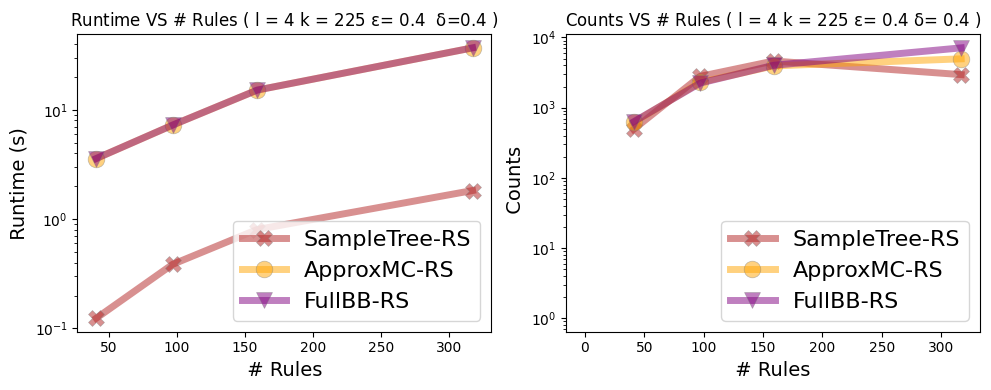

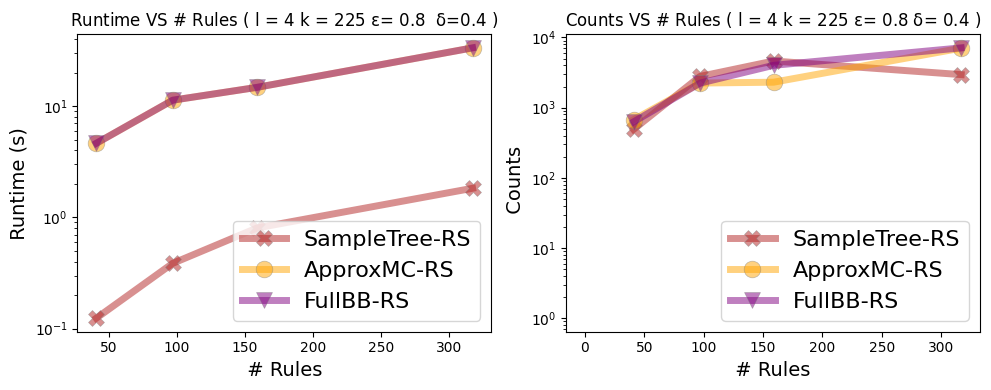

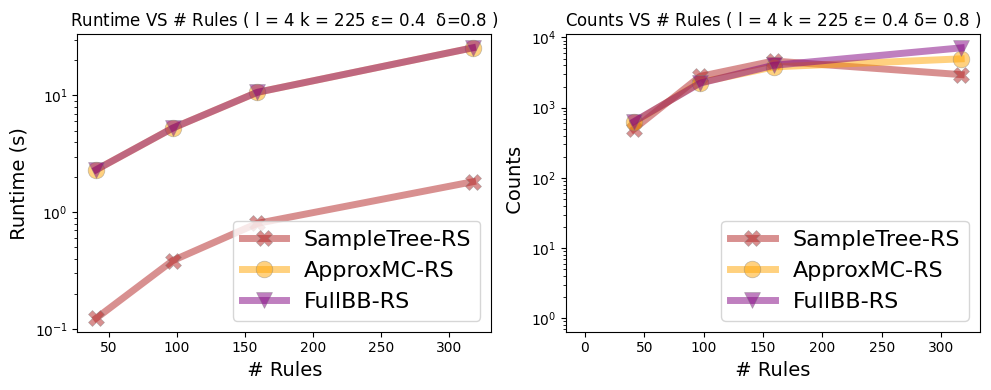

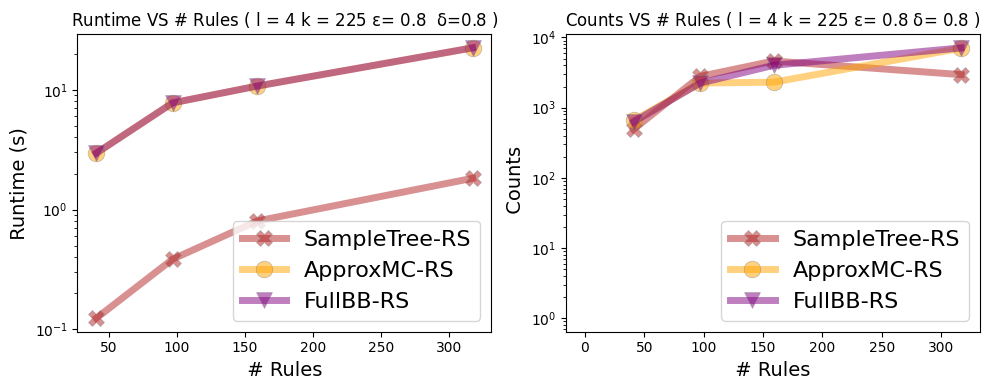

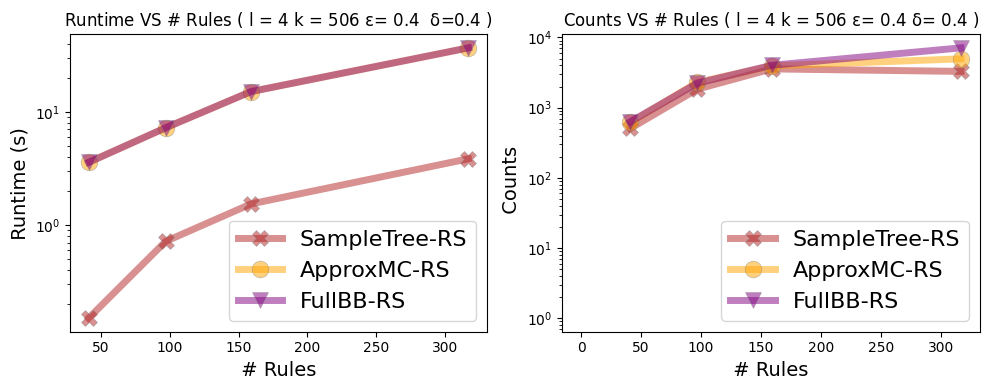

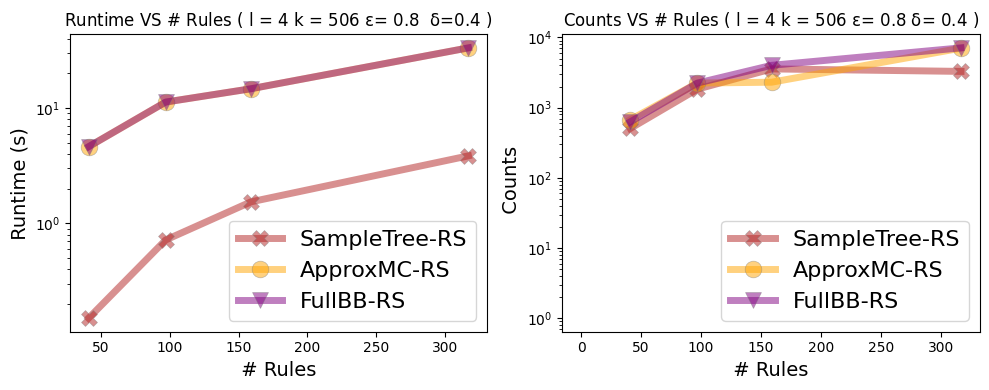

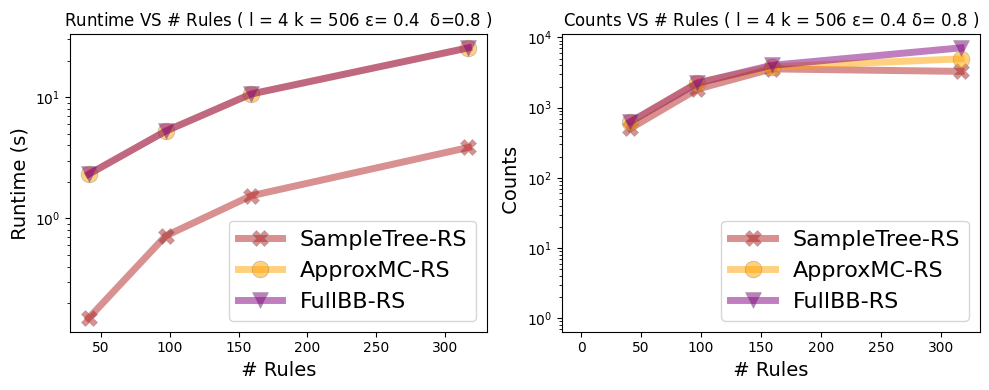

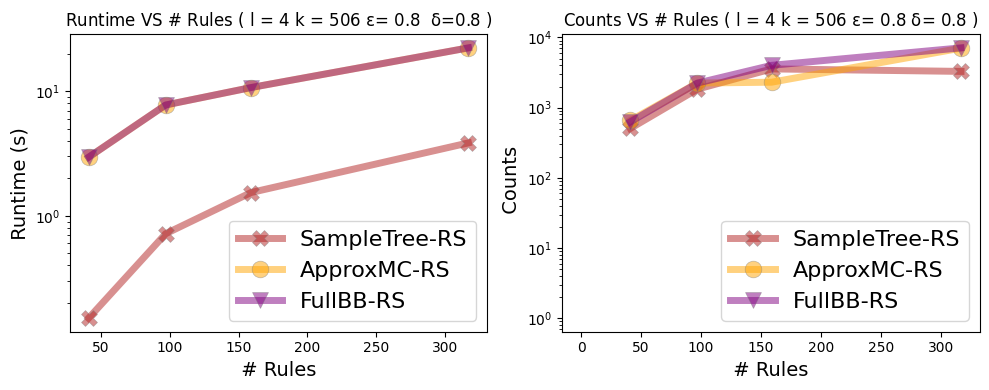

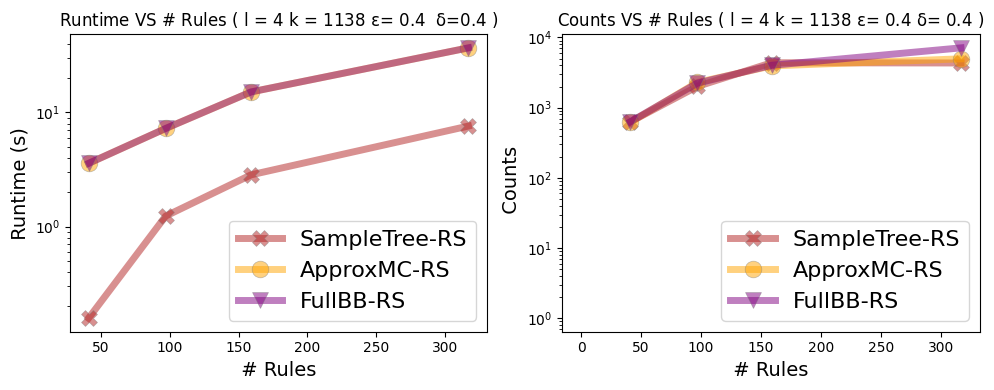

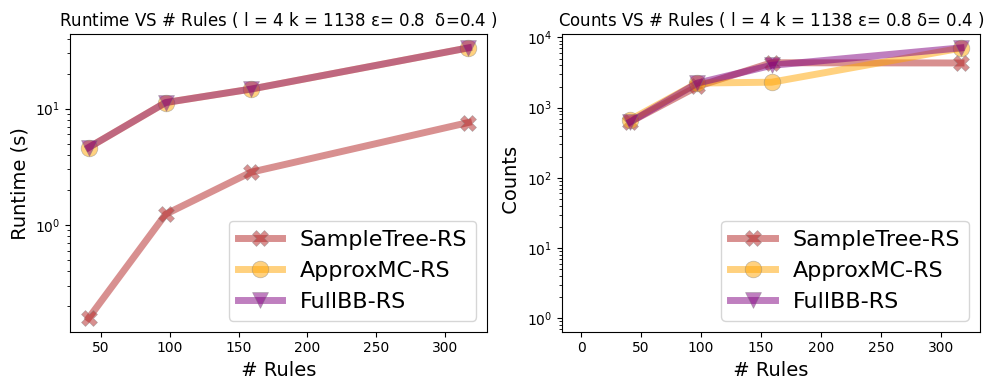

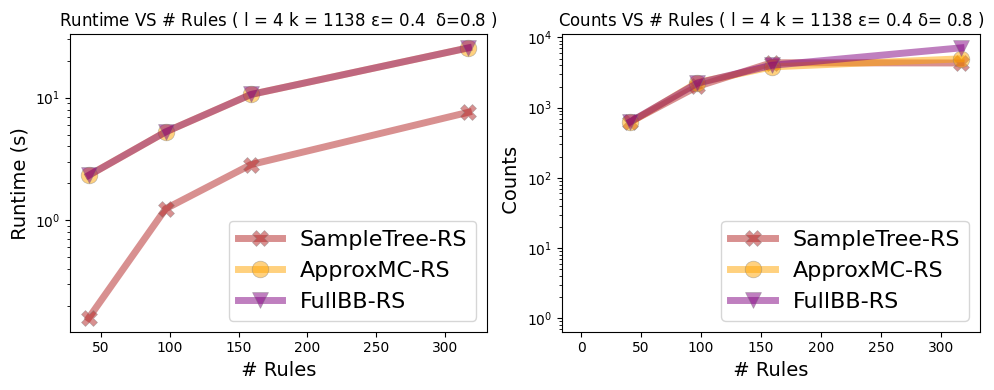

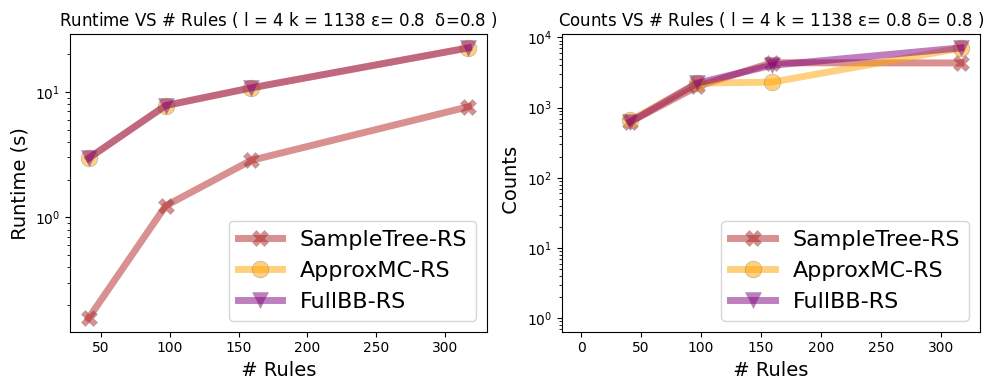

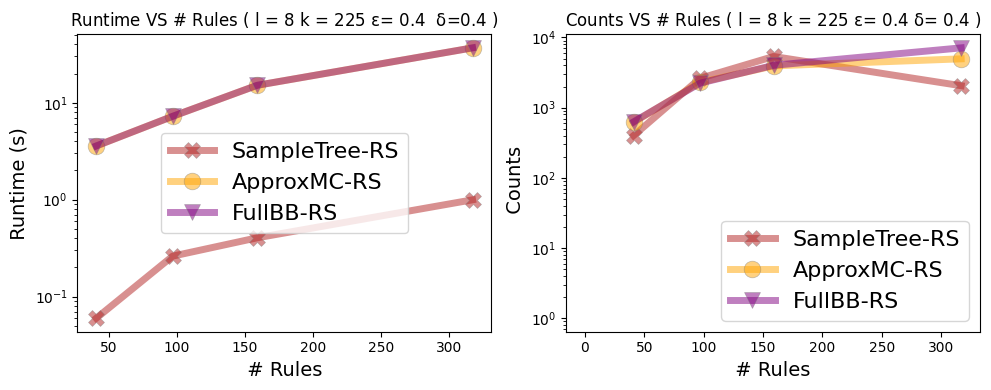

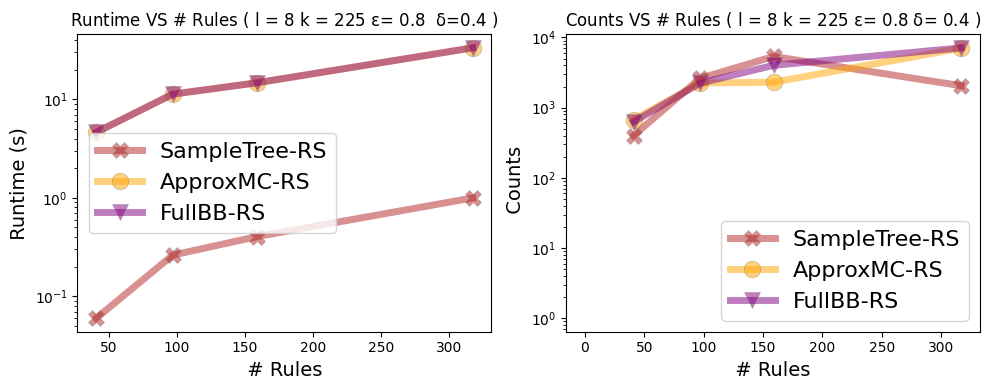

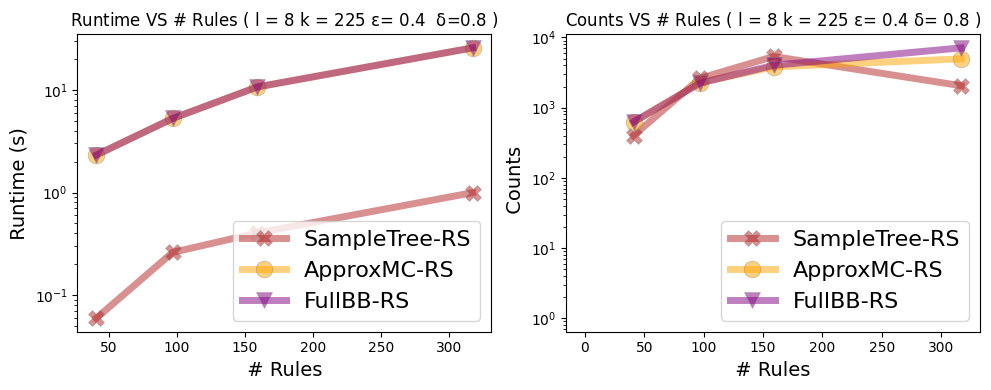

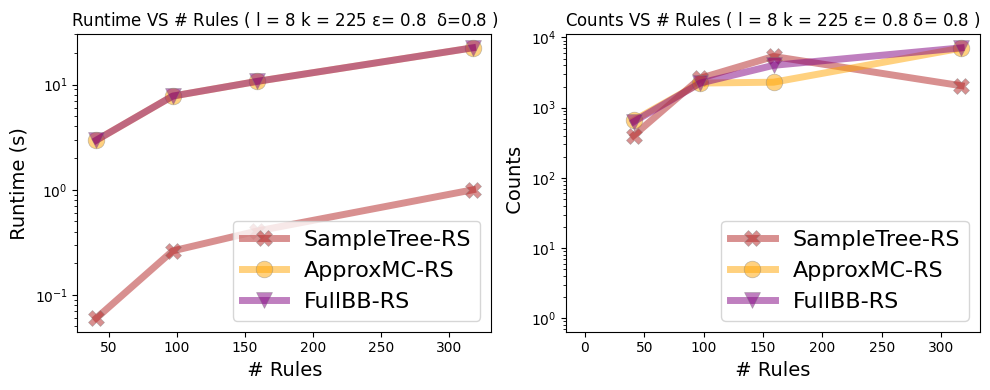

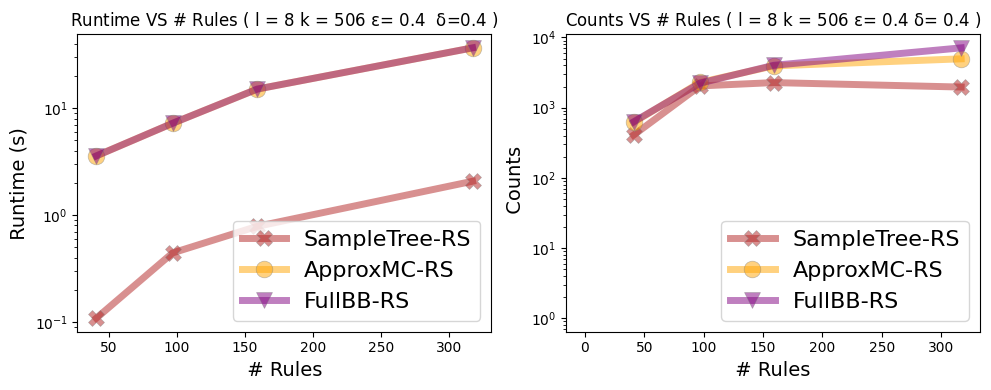

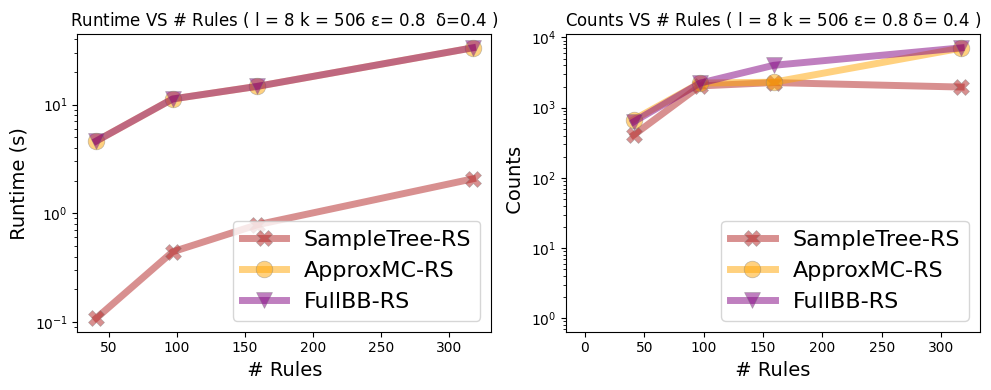

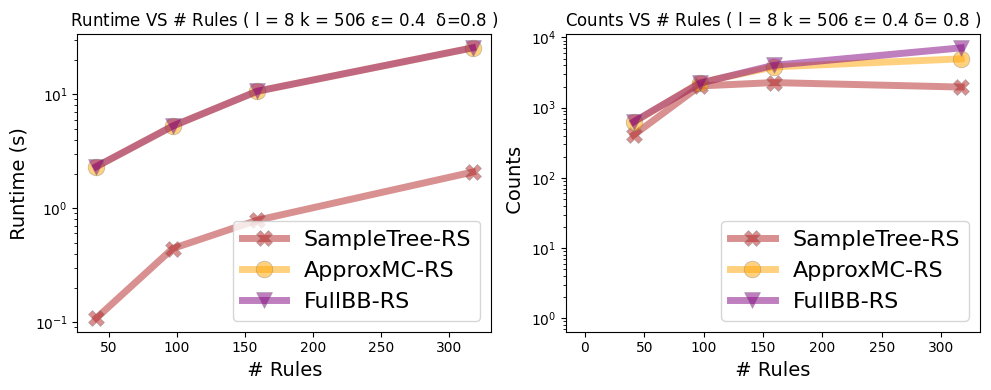

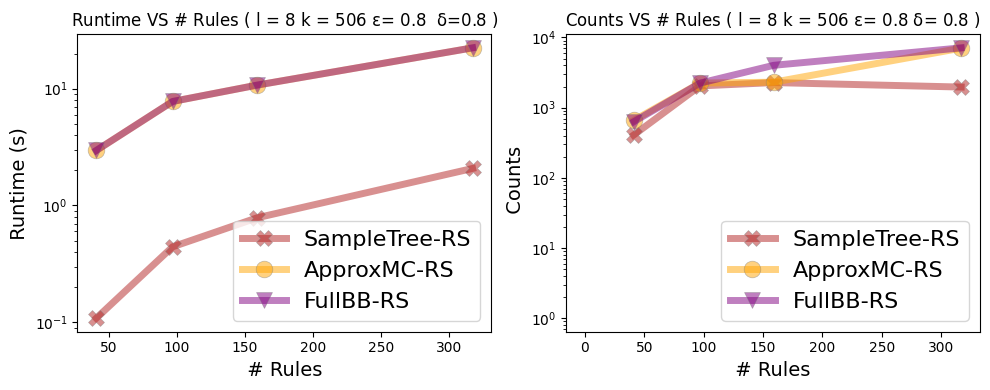

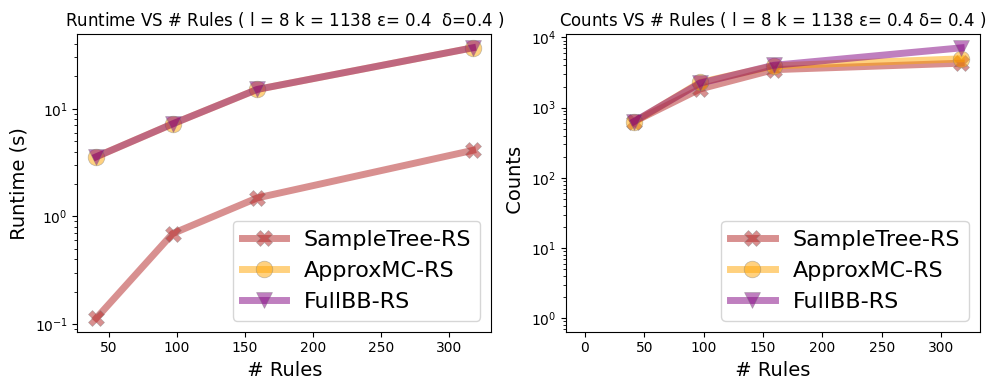

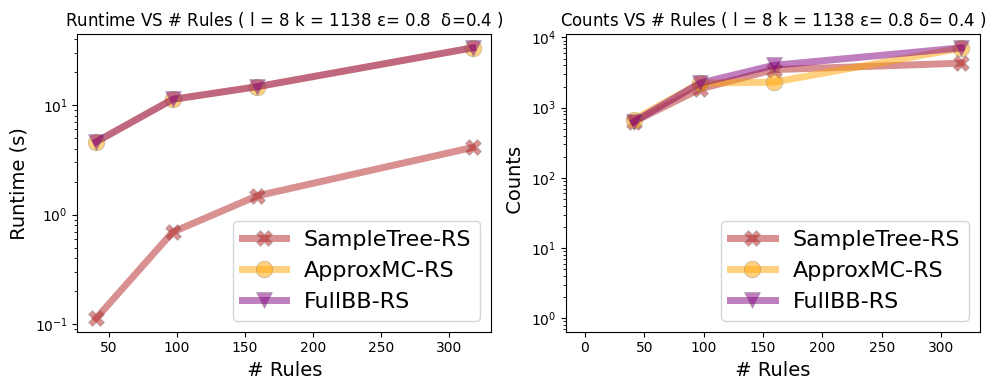

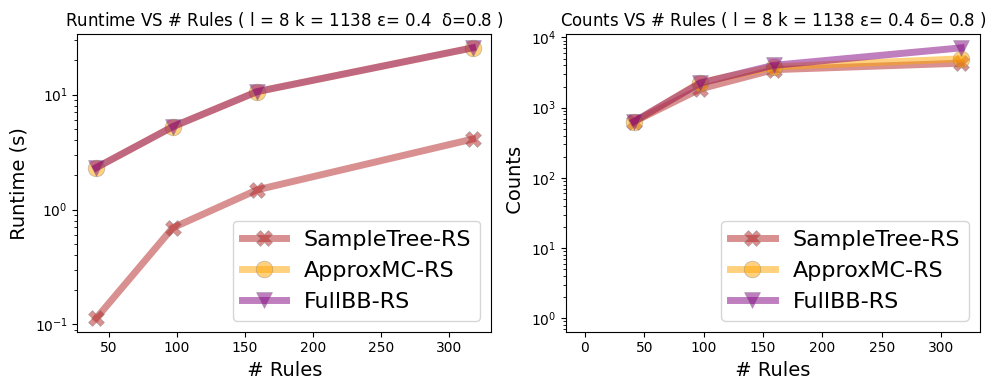

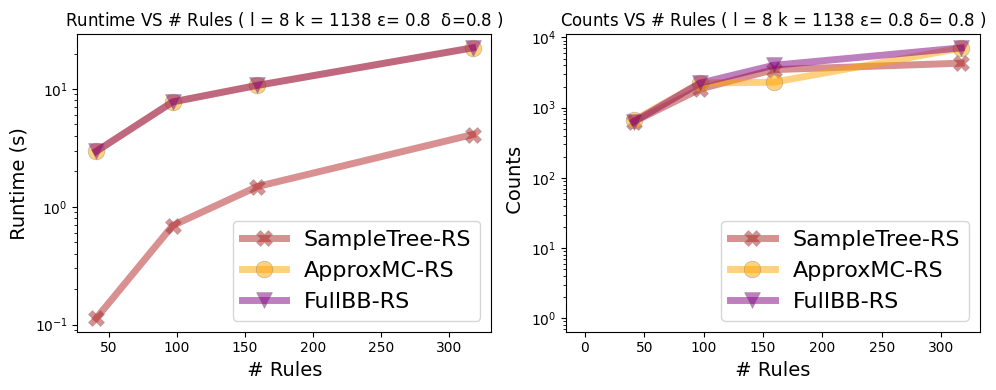

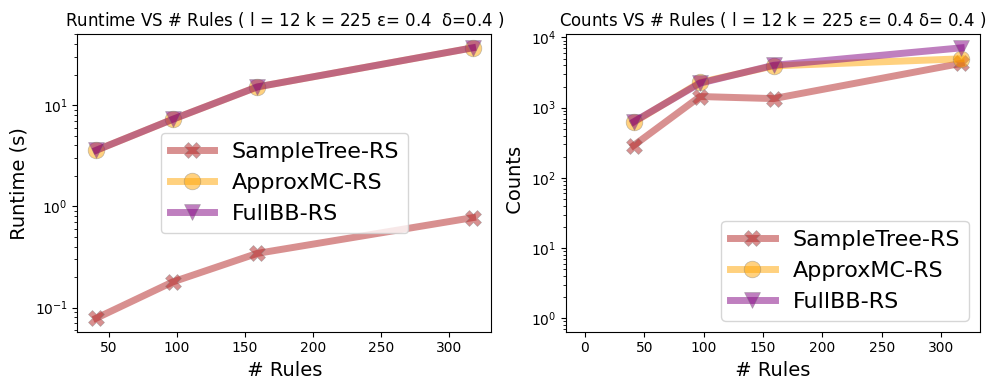

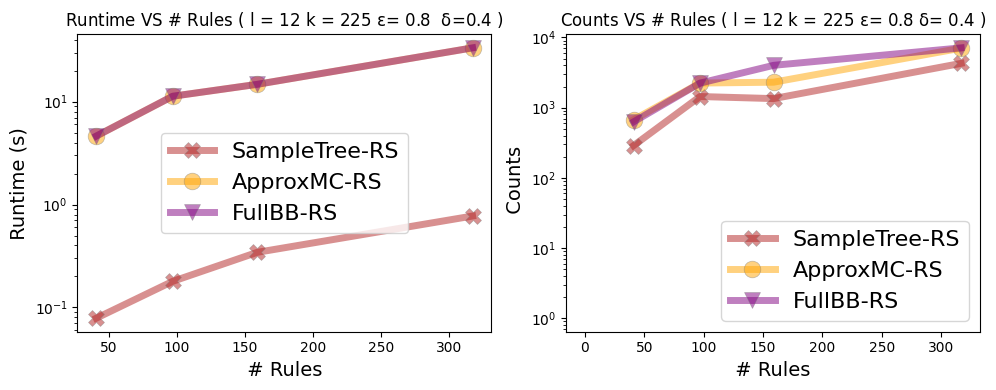

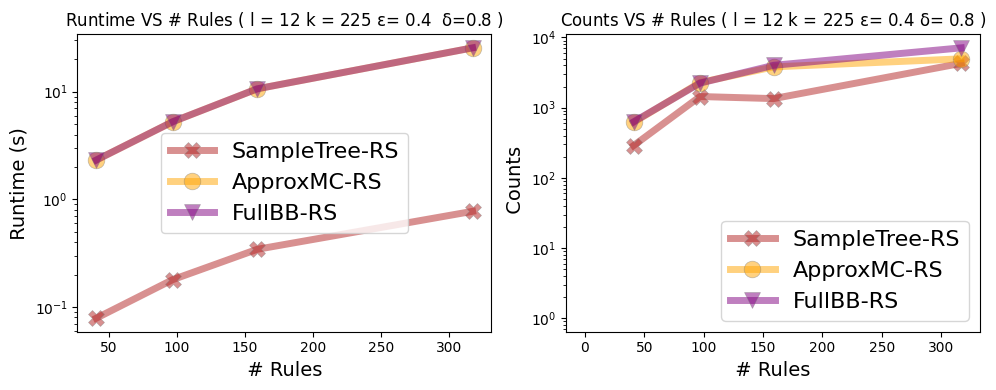

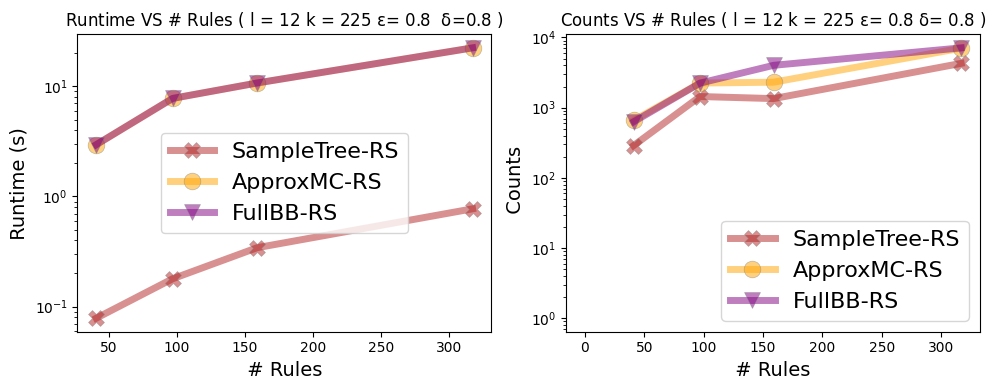

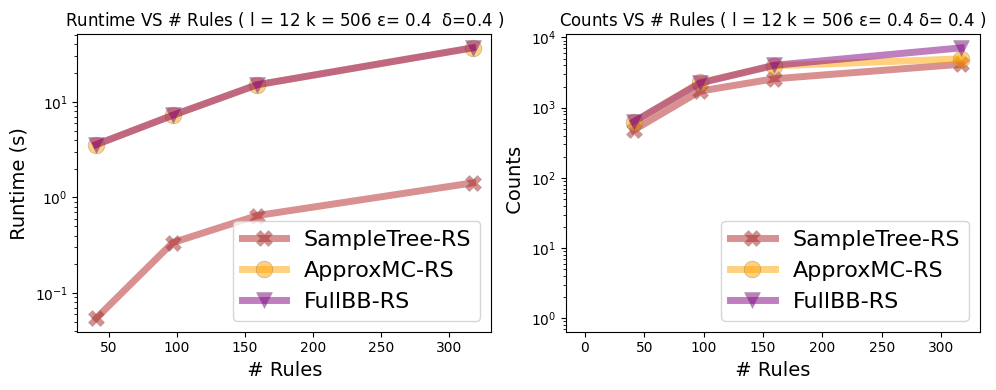

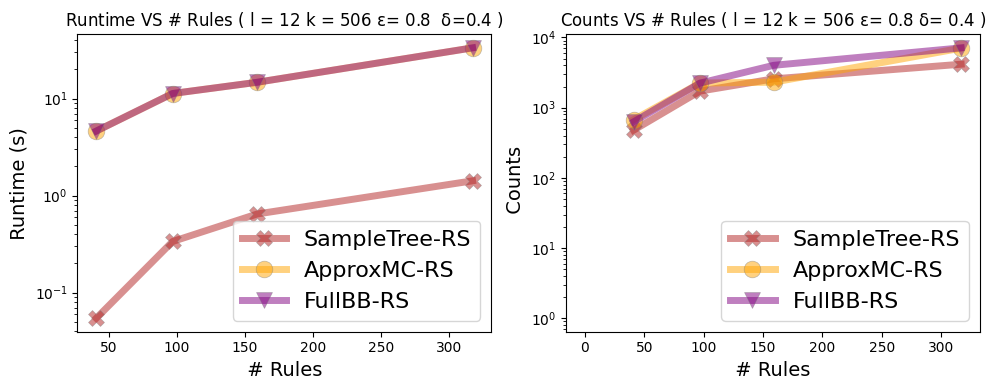

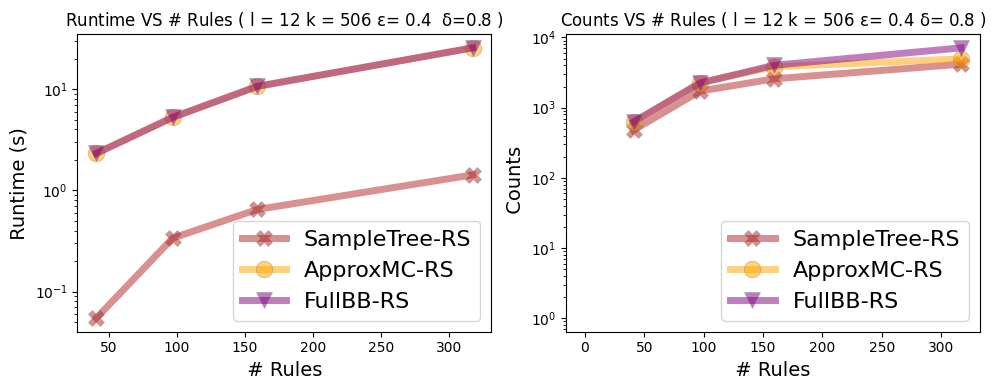

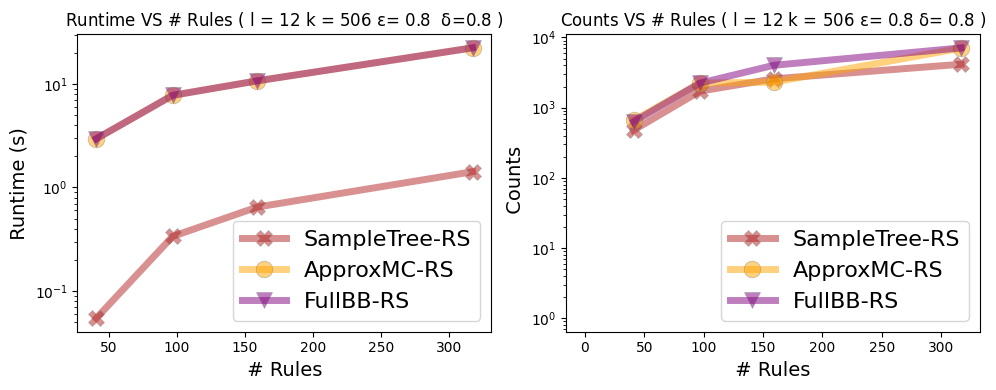

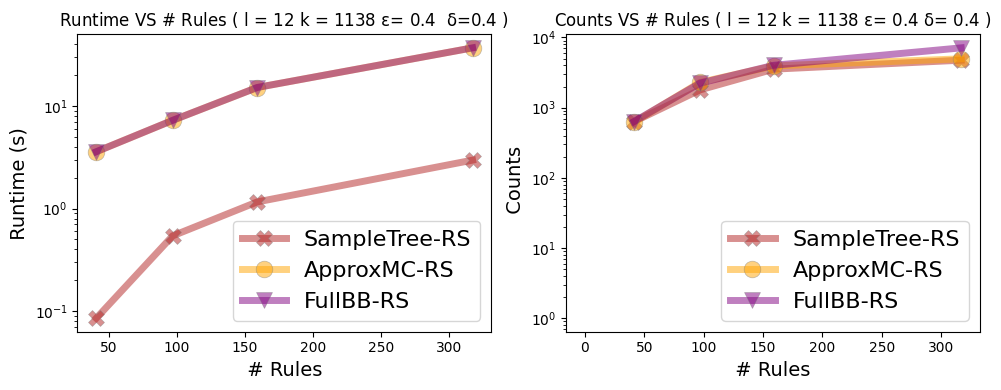

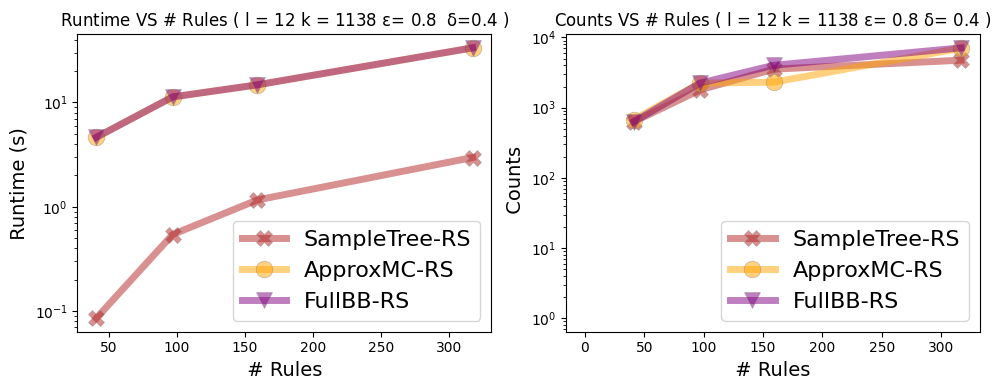

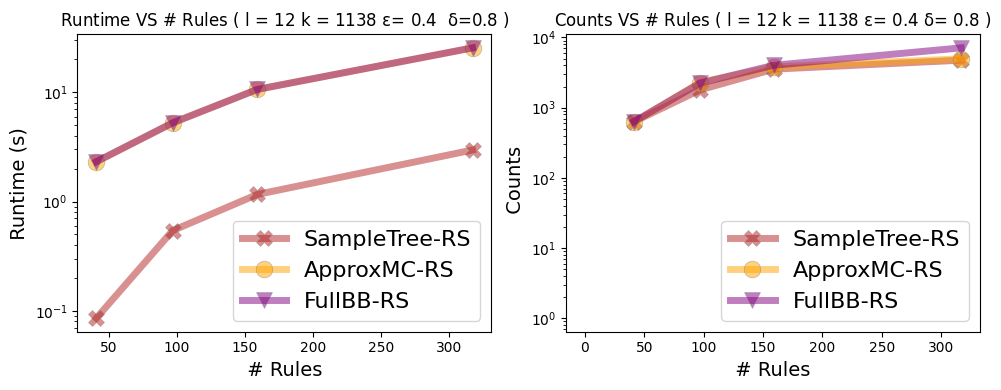

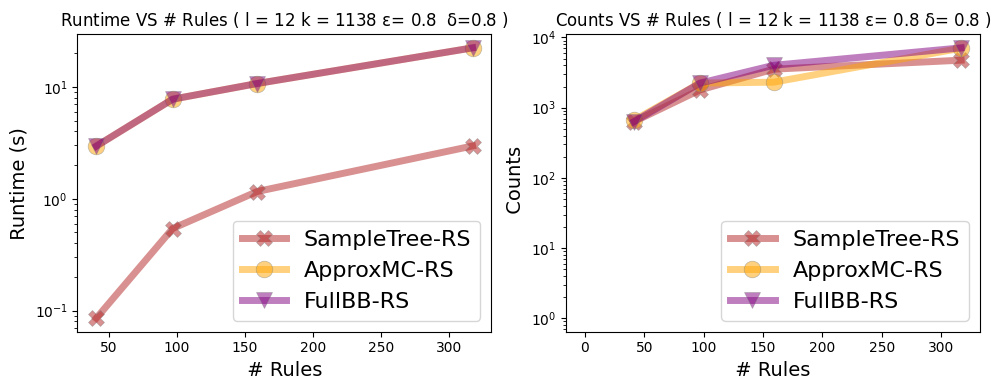

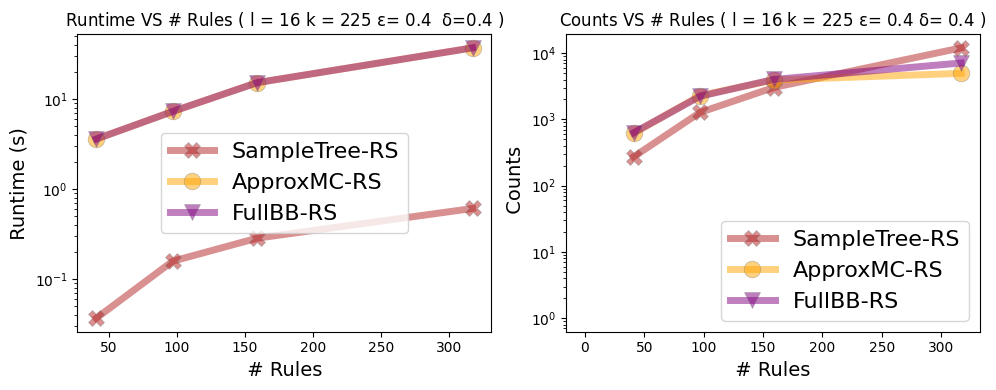

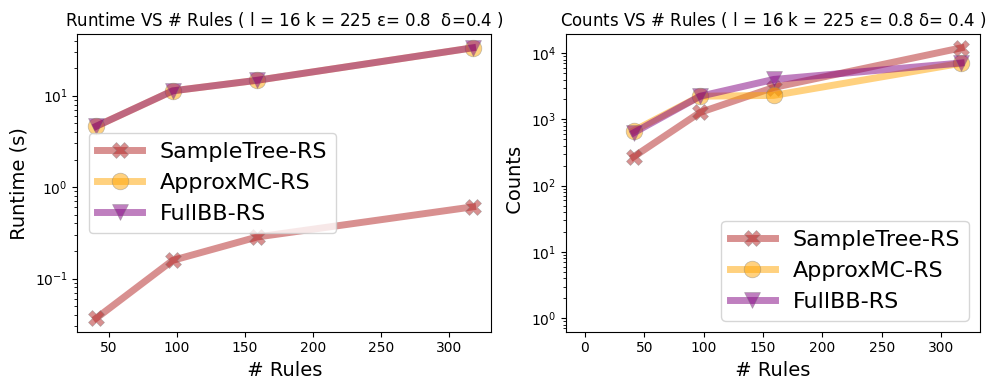

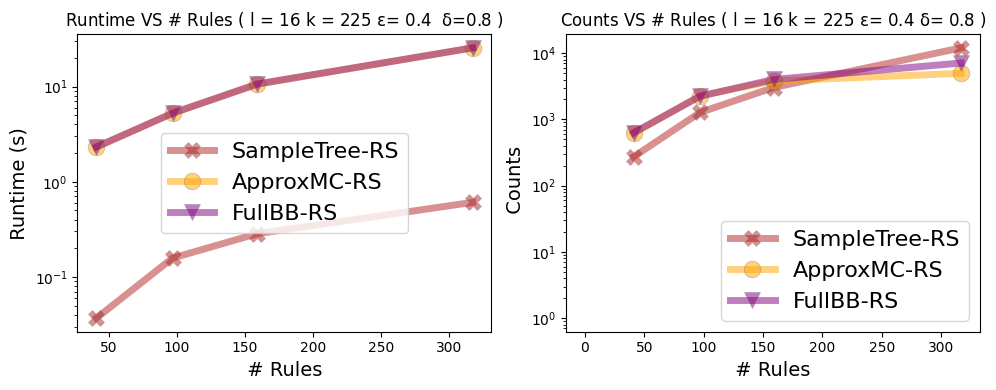

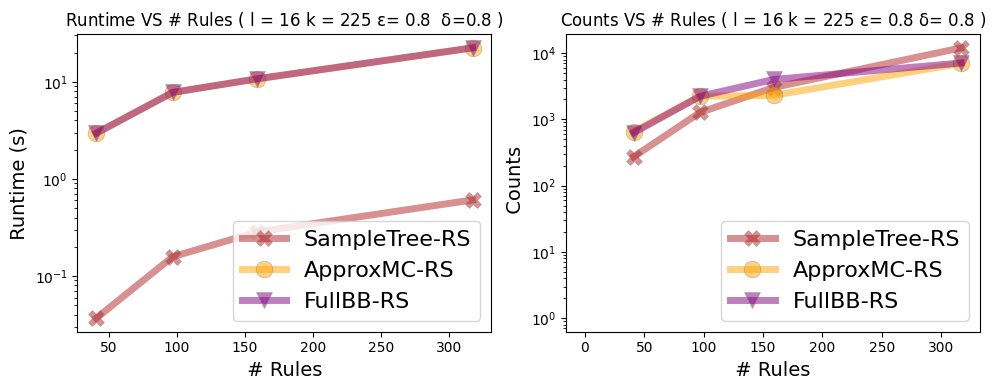

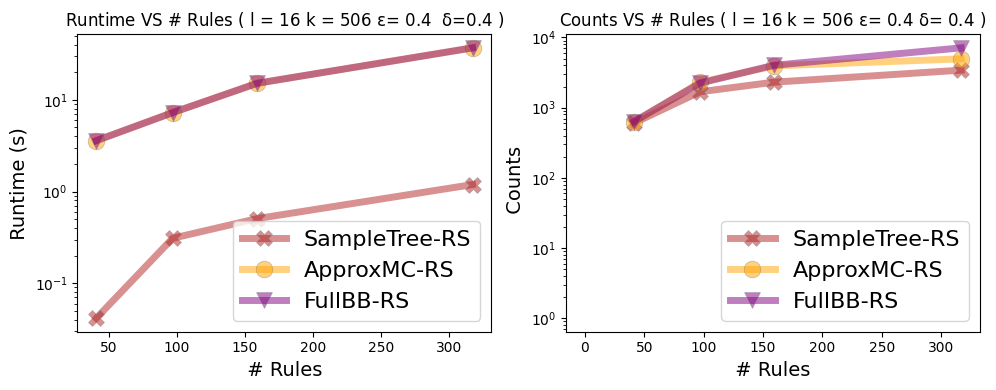

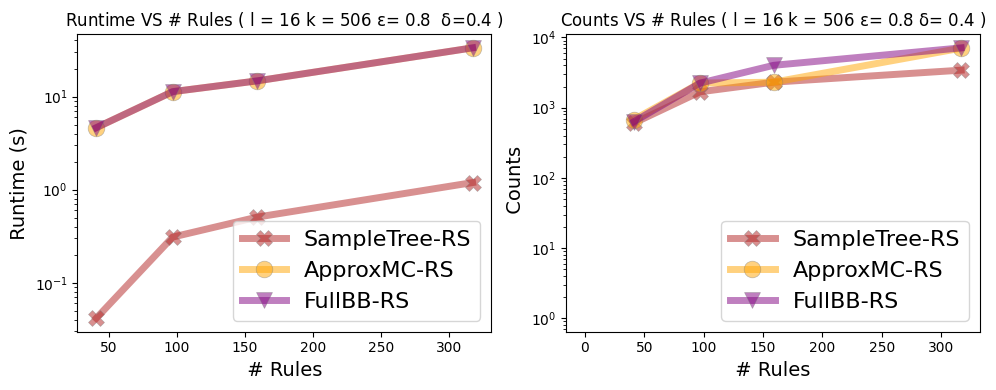

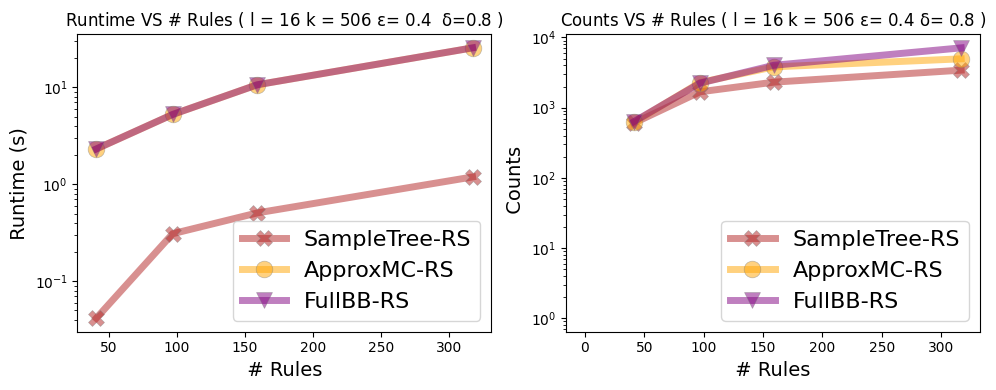

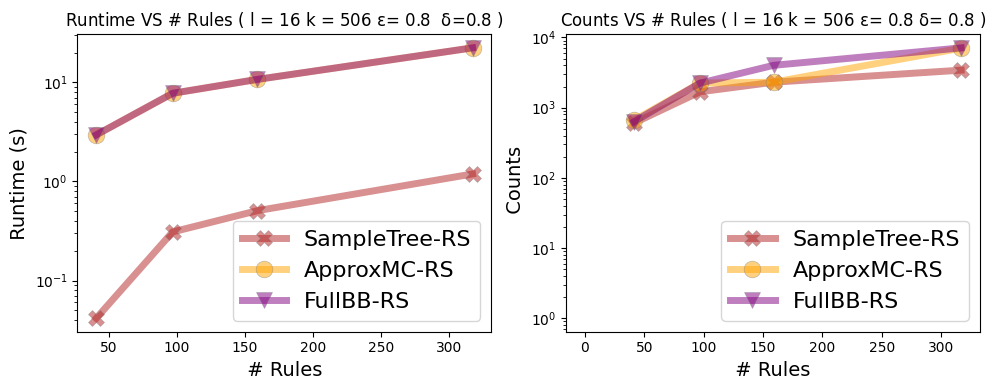

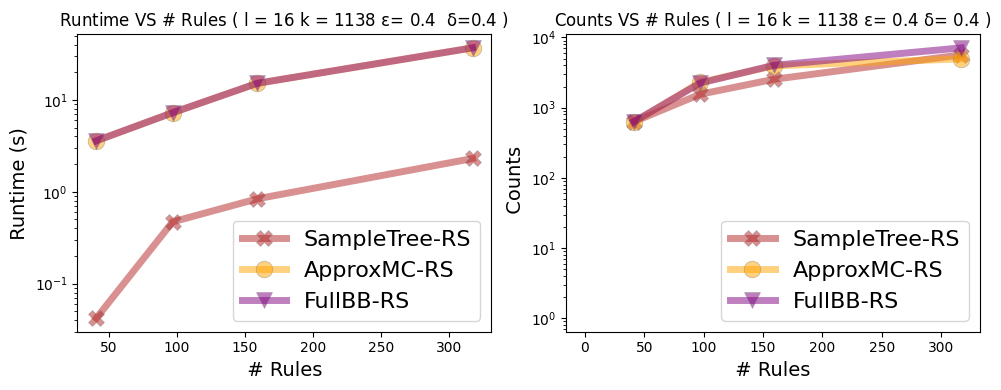

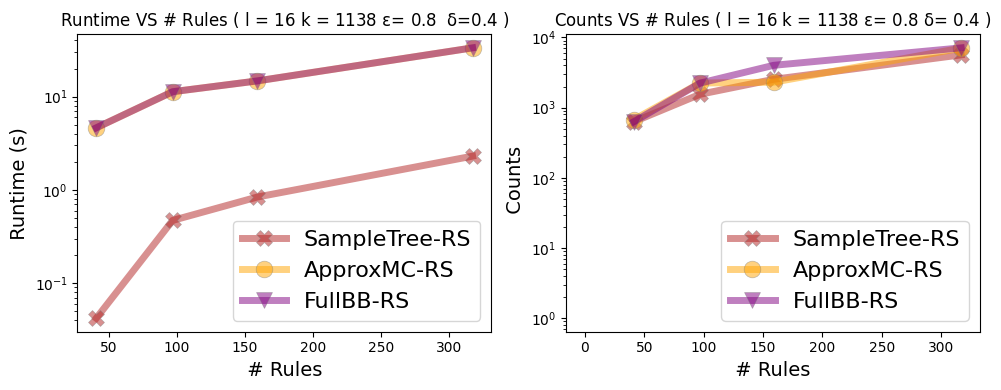

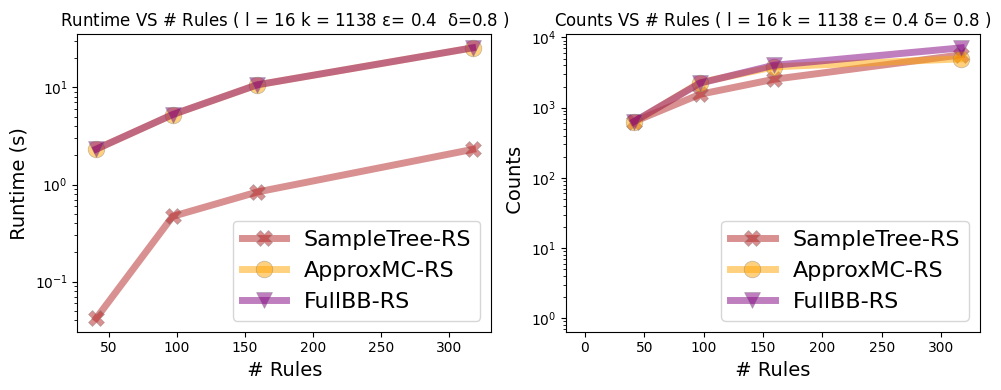

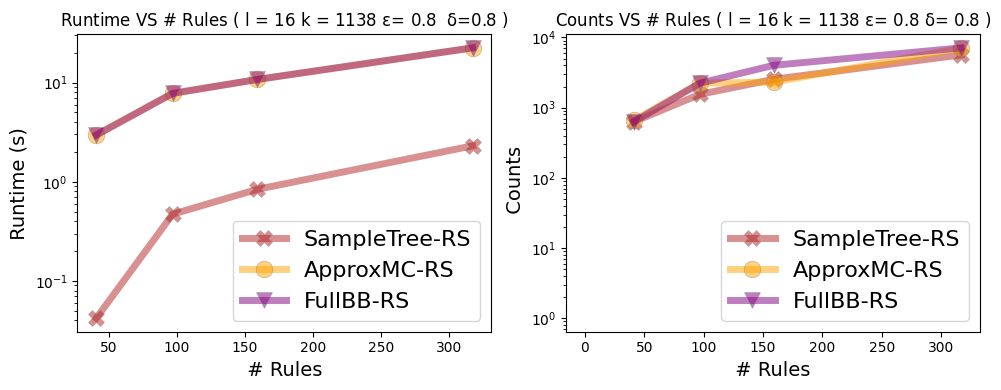

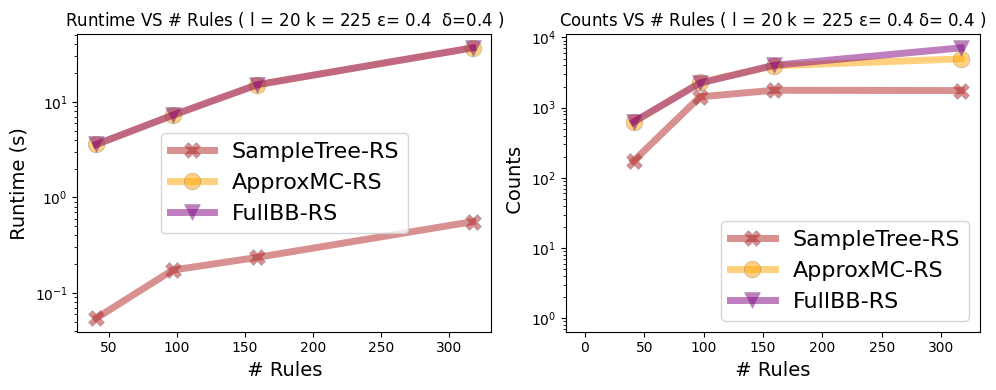

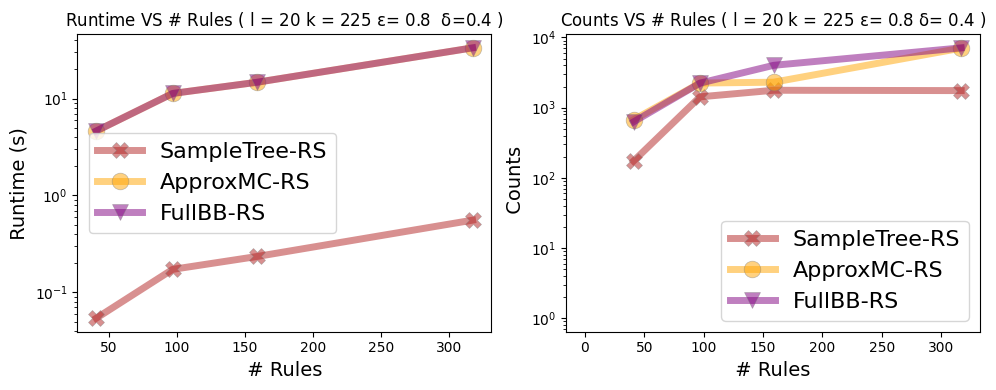

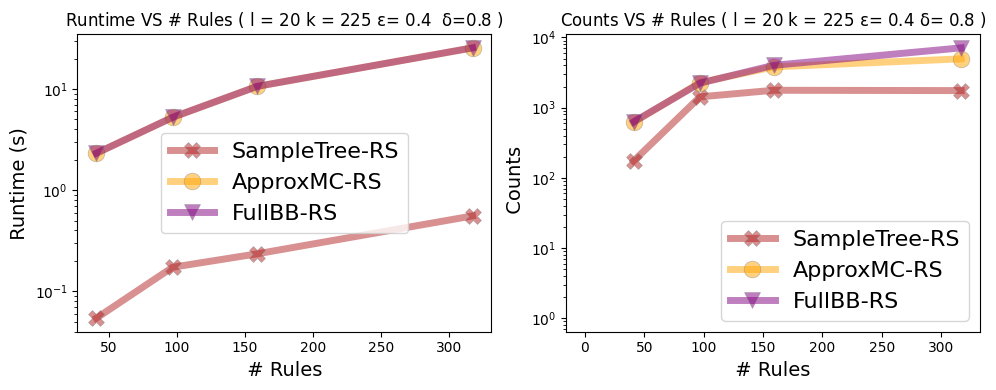

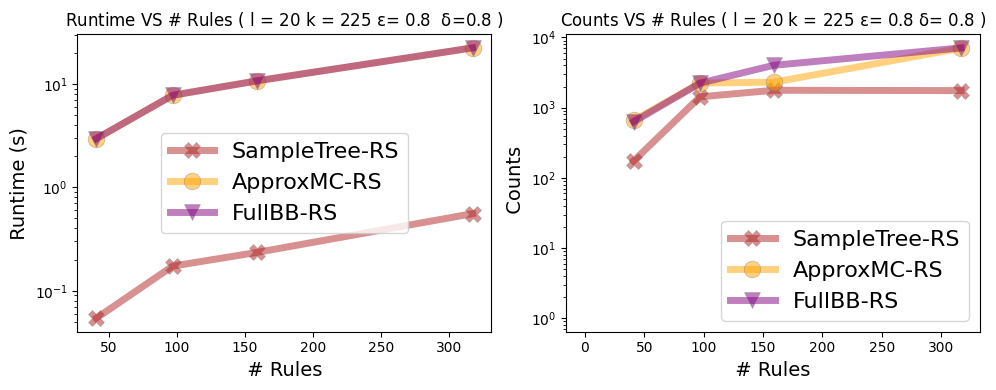

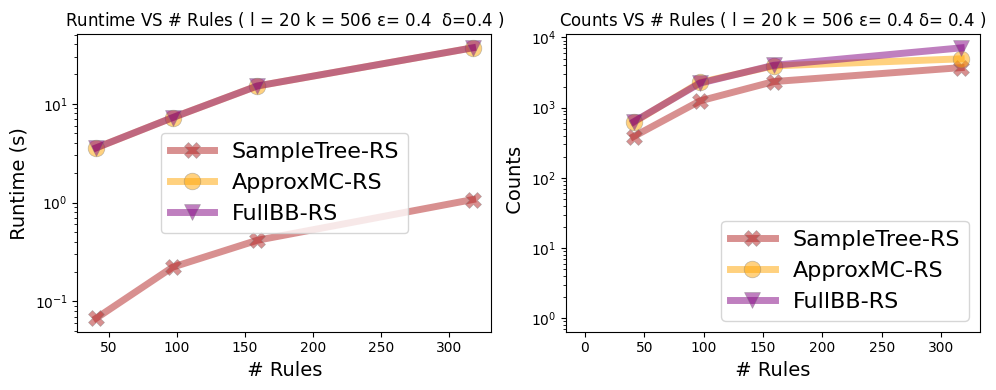

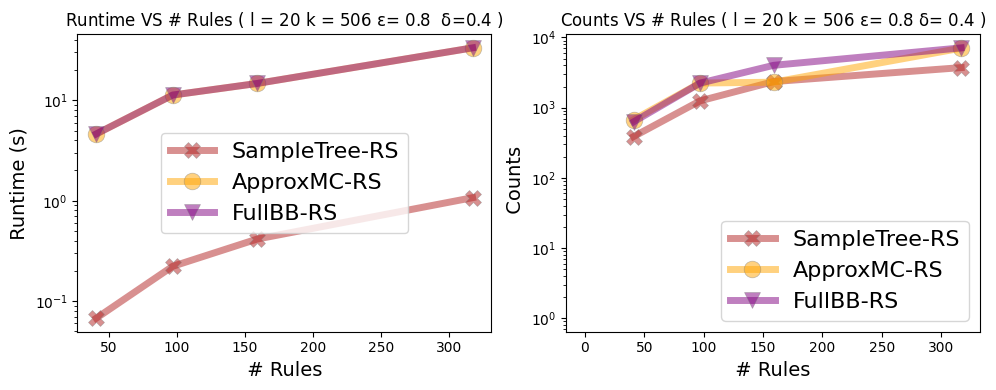

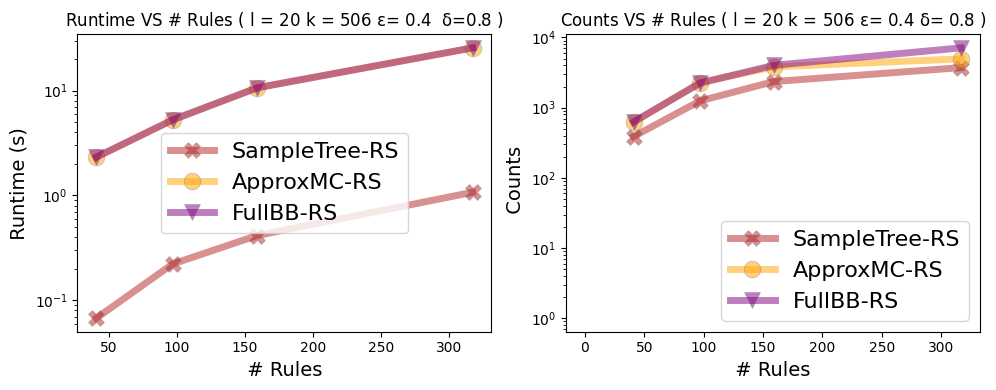

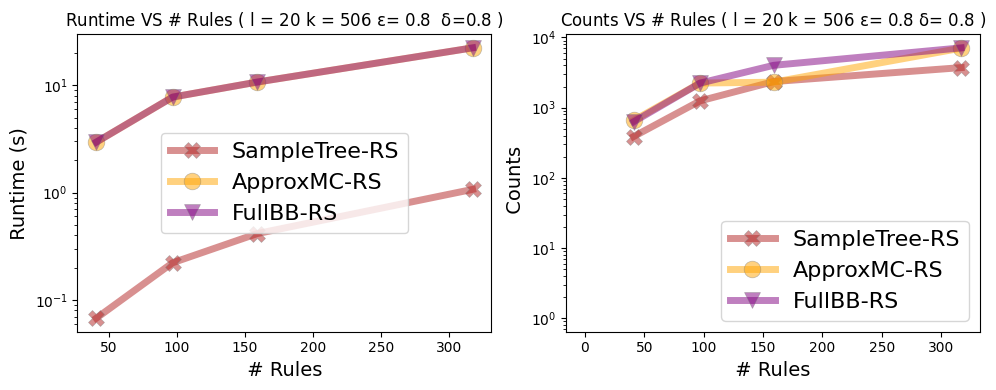

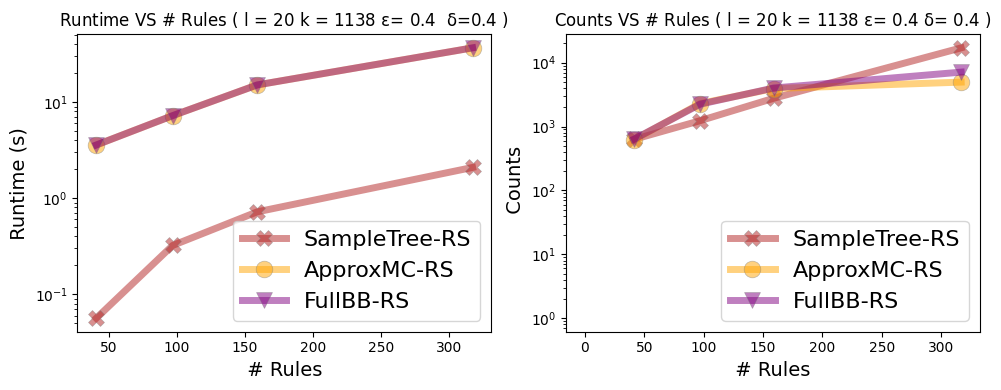

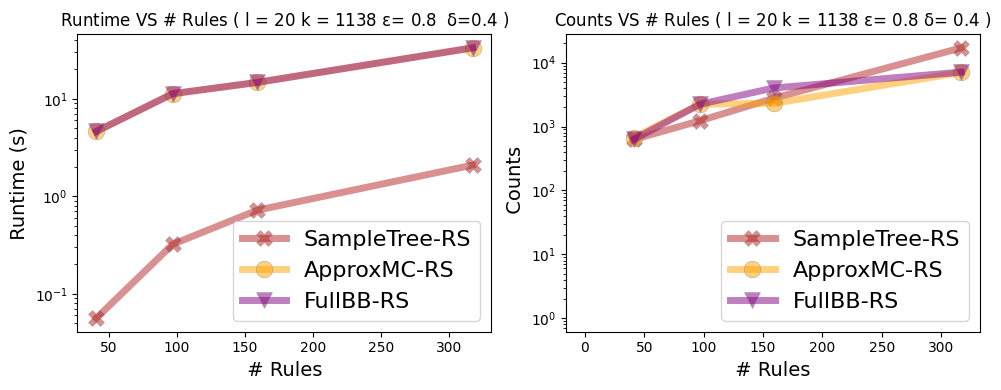

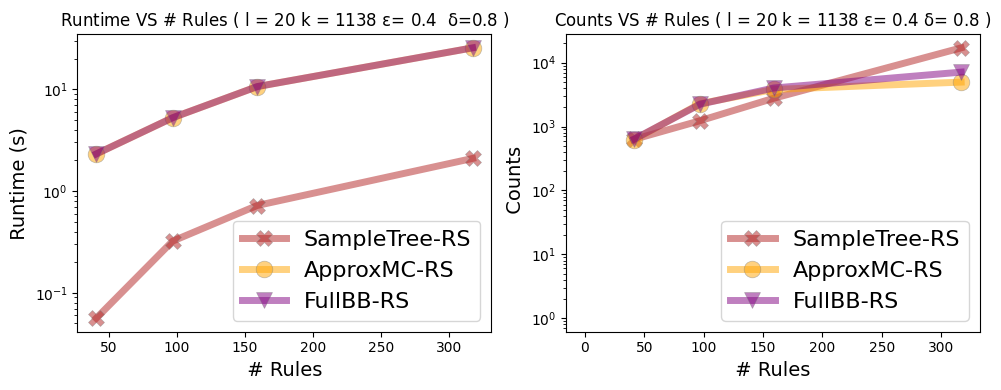

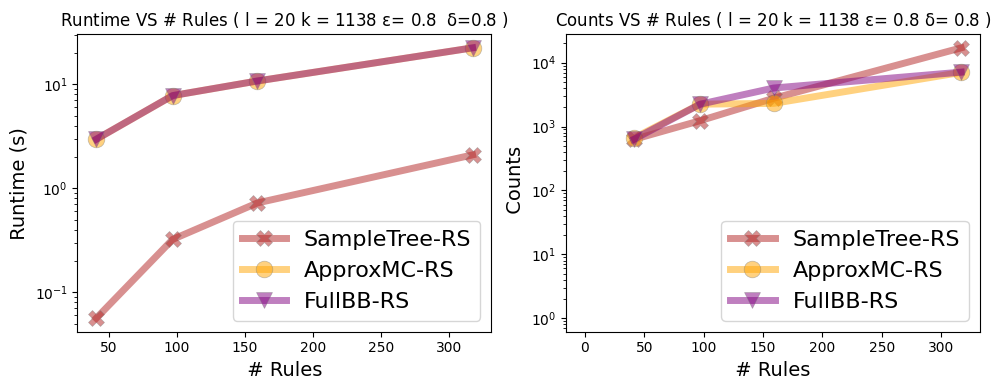

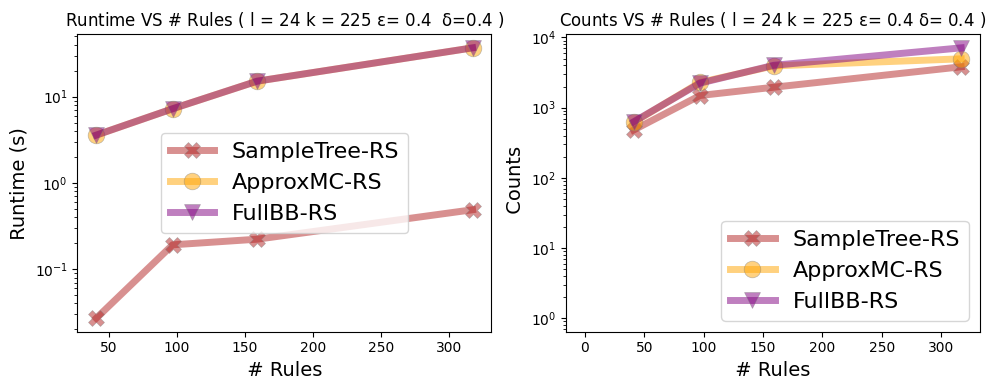

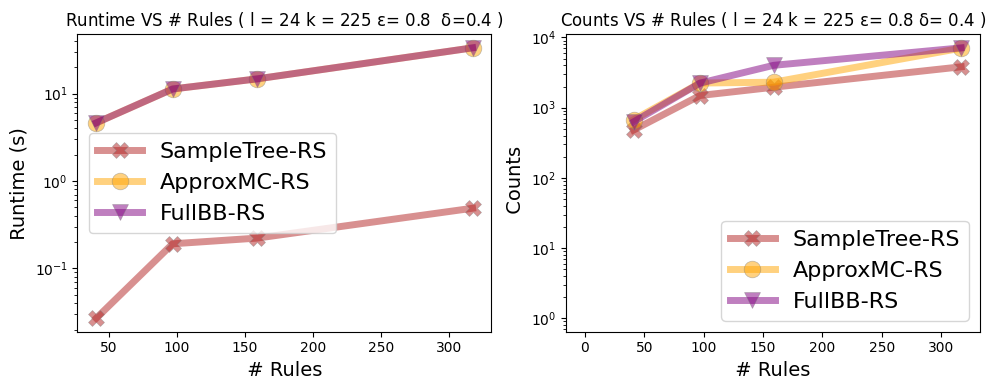

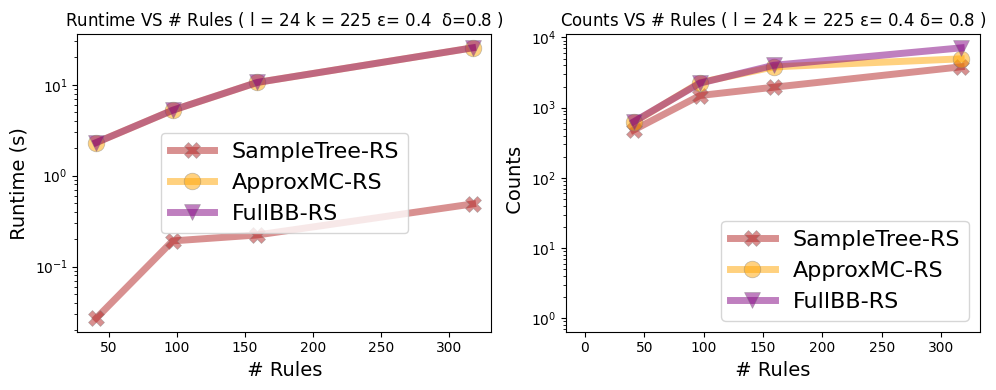

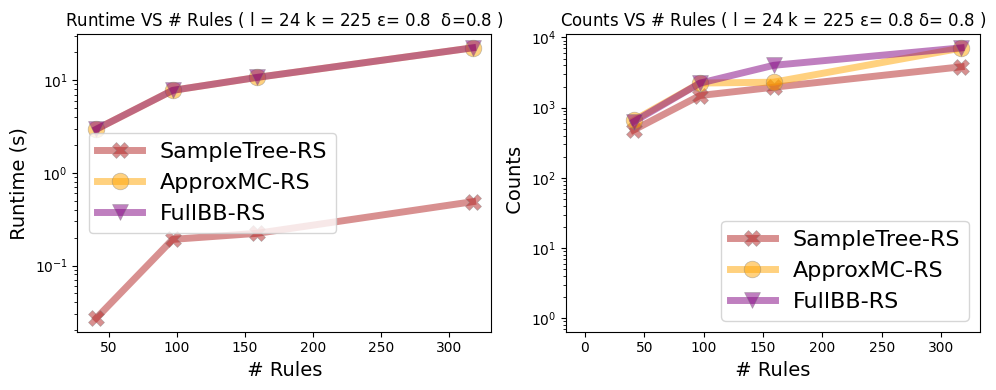

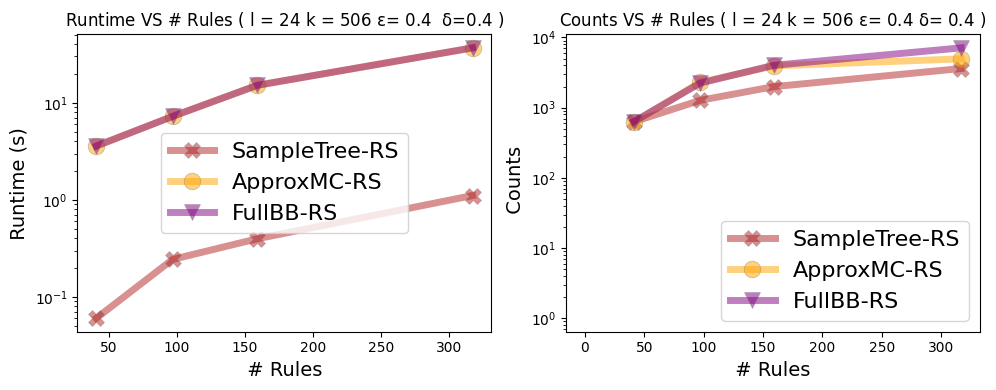

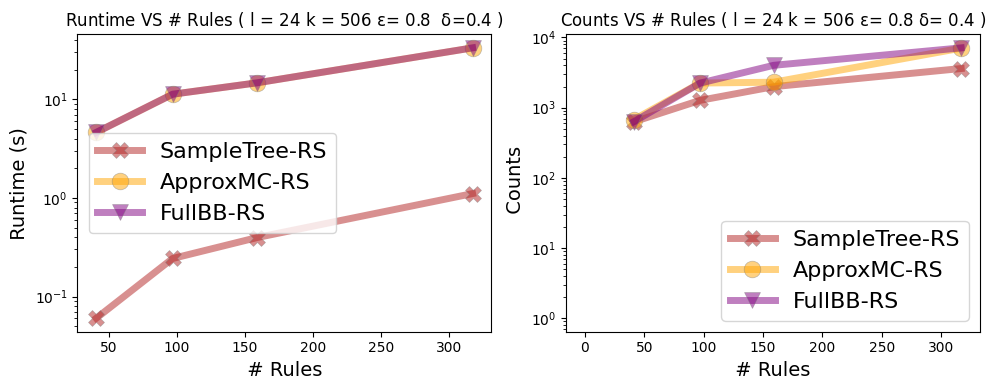

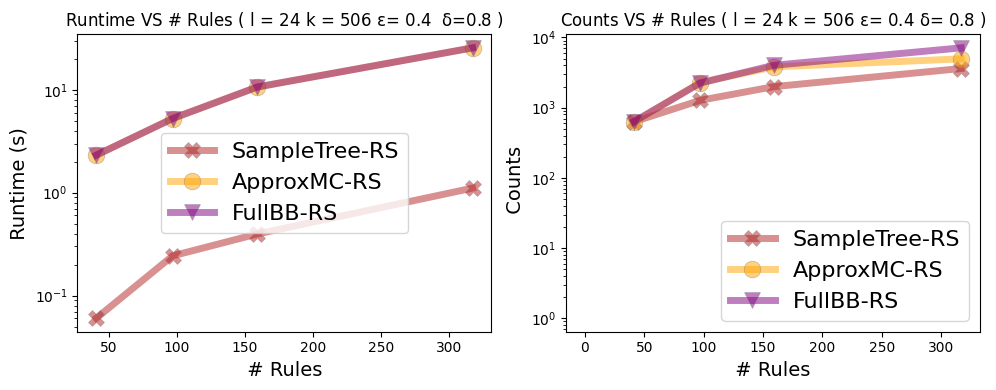

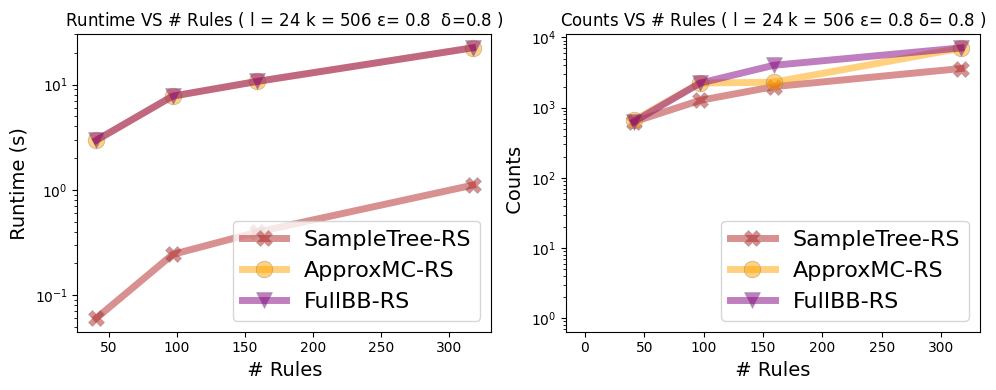

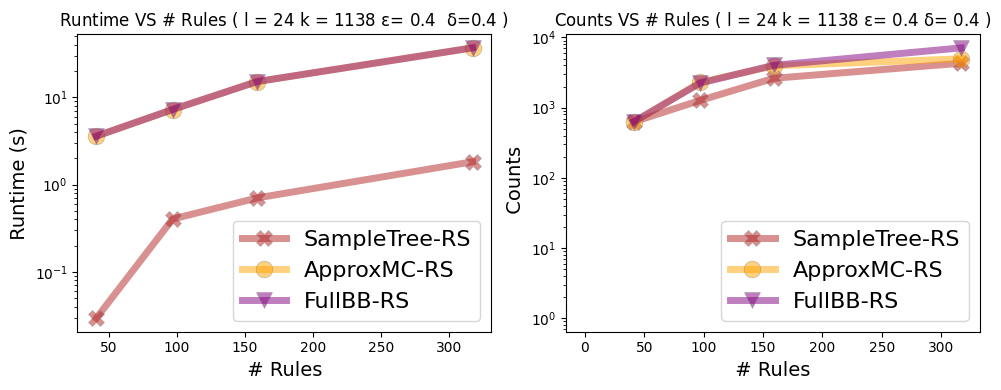

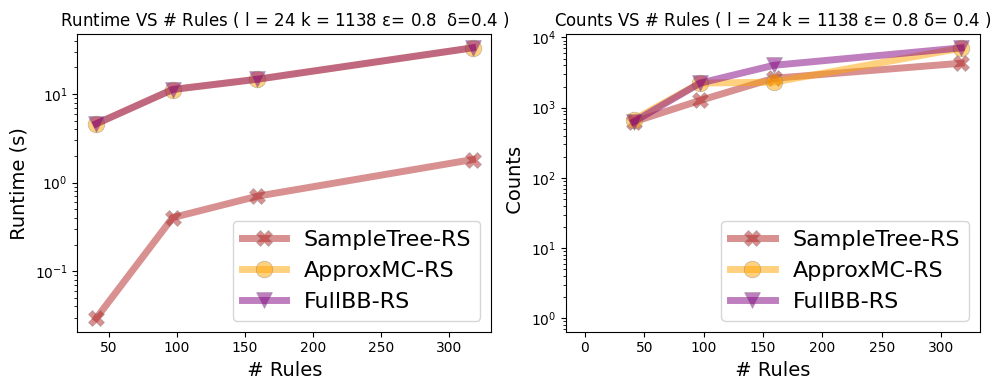

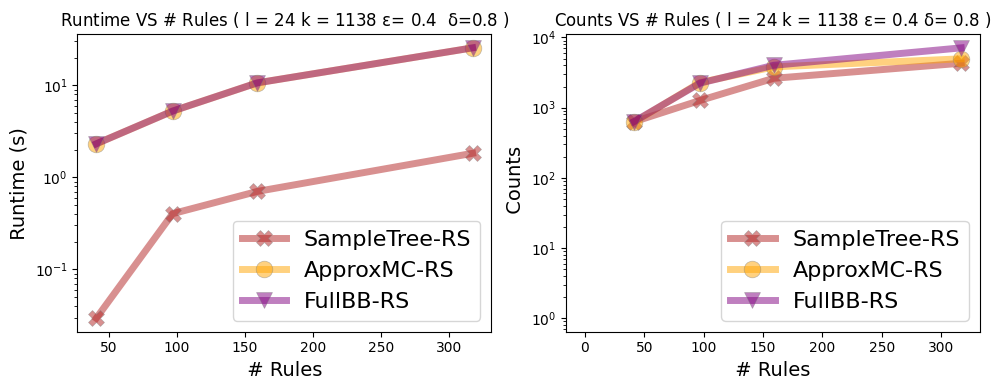

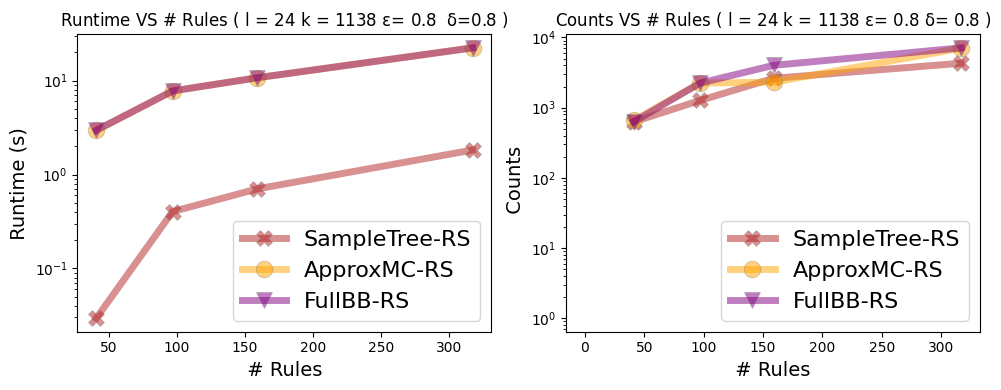

In [60]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


for l in [4, 8, 12, 16, 20, 24]: 
    for k in  [225, 506, 1138]:
        #
        for delta in [0.4, 0.8]: 
            for eps in [0.4, 0.8]:
                #
                #
                times = read_pickle(  "times_by_rules_" + dataset + "_" + str(n_rules) + "_" + str(l) + "_" + str(k)  )[0]
                counts = read_pickle(  "counts_by_rules_" + dataset + "_" + str(n_rules) + "_" + str(l) + "_" + str(k)  )[0]

                times_MC = [] 
                counts_MC = [] 

                times_GT = [] 
                counts_GT = []

                #for n_rules in all_n_rules: 

                times_MC = read_pickle(  "all_averages_times_MC_" + dataset + "_" + str(n_rules) + "_" + str(eps) + "_" + str(delta)  )[0]

                    #"times_MC.append(this_times_MC[0]) 

                cnts_MC = read_pickle(  "all_averages_counts_MC_" + dataset + "__" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)   )[0]

                   # counts_MC.append(this_cnts_MC[0]) 

                times_GT = read_pickle(  "all_averages_times_GT_" + dataset + "_" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)    )[0] 

                 #   times_GT.append(this_times_GT[0]) 

                cnts_GT = read_pickle(  "all_averages_counts_GT_" + dataset + "_" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)  )[0] 


                #plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
                mpl.rcParams['axes.facecolor'] = 'white'
                mpl.rcParams['grid.color'] = 'lightgray'
                mpl.rcParams["mathtext.default"] = "regular"
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
                # Plot the first data on the first subplot
                #ax1.plot([61 , 77, 104], y1, color='red')
                #ax1.set_title('Plot 1')

                #all_n_rules = [61, 77, 104, 151, 262, 312]
                all_n_rules = [41, 97, 159, 317]
                
                x = all_n_rules

                #print(times_MC)

                ax1.plot(x, times,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax1.plot(x, times_MC, marker='o', color = "orange" ,  label = "ApproxMC-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
                ax1.plot(x, times_GT, marker='v', 
                        color = "purple", label = "FullBB-RS",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 


                ax1.legend(fontsize = 16)

                ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " " + r"$\epsilon$= " + str(eps) +  " " + r" $\delta$=" + str(delta) +  " )" , fontsize = 12)

                ax1.set_xlabel(" # Rules ", fontsize = 14 )

                ax1.set_ylabel(" Runtime (s) " , fontsize = 14 ) 

                ax1.set_yscale('log')  # Set y-axis to logarithmic scale


                ax2.plot(x, counts,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax2.plot(x, cnts_MC, marker='o', color = "orange" , label = "ApproxMC-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
                ax2.plot(x, cnts_GT, marker='v', 
                        color = "purple",  label = "FullBB-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax2.legend(fontsize = 16)        

                ax2.set_title('Counts VS # Rules ( l = ' + str(l) + " k = " + str(k) + r" $\epsilon$=" +  " " + str(eps) + r" $\delta$=" + " " + str(delta) +  " )" , fontsize = 12  )


                ax2.set_xlabel(" # Rules ", fontsize = 14 )

                ax2.set_ylabel(" Counts" , fontsize = 14 ) 

                ax2.set_yscale('log')  # Set y-axis to logarithmic scale


                hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
                hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
                #legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
                hB.set_visible(False)
                hS.set_visible(False)
                hHP.set_visible(False)


                # Adjust spacing between subplots
                plt.tight_layout()


                plt.savefig("sample_tree_by_rules_" + dataset + "_" + str(l) + "_" + str(k) + "_log.pdf") 

                # Display the plots
                plt.show()
